# SuperVised Learning Algorithm to find out the Aspect Catergory from the sentences.




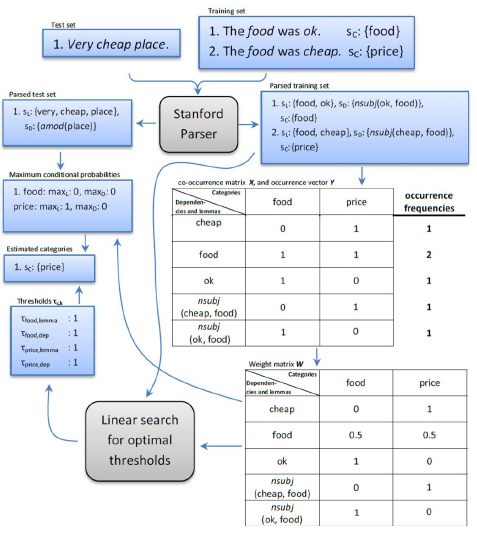

### Step 1st find out the Part of Speech of the all the training and the testing data

In [1]:
# Import all necessar Packeges

import pandas as pd
import xml.etree.ElementTree as ET, getopt, logging, sys, random, re, copy
from xml.sax.saxutils import escape
import io


from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")


In [2]:
print ("Test")

Test


## Fetching the Data

In [3]:
# we have give a json file which consists of all information about
# the products
# loading the data using pandas' read_json file.
#xml_data1 = open('D:\ABSA\semeval_data\Restaurants_Train.xml').read()

xml_data1 = open('semeval_data\Restaurants_Train.xml').read()

                                                        # Fetch the sentence data
xml_data_pol = io.StringIO(xml_data1)

def xml2df(xml_data_pol):
    root = ET.XML(xml_data_pol) # element tree
    all_records = [] #This is our record list which we will convert into a dataframe
    for i, child in enumerate(root): #Begin looping through our root tree
        record = {} #Place holder for our record
        for subchild in child: #iterate through the subchildren to user-agent, Ex: ID, String, Description.
            if(subchild.tag == 'text'):
                record[subchild.tag] = subchild.text
                all_records.append(record)
            #record[subchild.tag] = subchild.text #Extract the text create a new dictionary key, value pair
            #print(subchild.text)
            #all_records.append(record) #Append this record to all_records.
            
    return pd.DataFrame(all_records) #return records as DataFrame

#  Fetching Id
def iter_docs(sentences):
    author_attr = sentences.attrib
    for doc in sentences.iter('sentence'):
        
        #print(doc.find('text'))
        doc_dict = author_attr.copy()
        #print(author_attr['aspectTerm'])
        #print(doc.attrib)
        doc_dict.update(doc.attrib)  # doc.attribute give the value of the sentence id e.g. {'id': 12334}
        #doc_dict['data'] = doc.text
        #print(doc_dict)
        yield doc_dict
        


xml_data_pol = io.StringIO(xml_data1)

etree = ET.parse(xml_data_pol) #create an ElementTree object 
doc_df = pd.DataFrame(list(iter_docs(etree.getroot())))

sentence_data = xml2df(xml_data1)

print(doc_df)

print(sentence_data)

        id
0     3121
1     2777
2     1634
3     2534
4      583
5     2846
6     1571
7     1458
8     3161
9     2391
10     986
11     296
12    1793
13    2200
14    3195
15    3119
16    3359
17      70
18    1829
19    2935
20    1805
21    2559
22     716
23    2464
24     385
25    1350
26    3534
27    1407
28     565
29     387
...    ...
3014   902
3015   568
3016  3133
3017  2553
3018  2624
3019  2116
3020   317
3021  2151
3022   944
3023  3014
3024   900
3025  2739
3026   279
3027  2937
3028   333
3029   236
3030  1420
3031  2259
3032   608
3033  2834
3034  3168
3035  2798
3036  2378
3037  1027
3038  1735
3039  1063
3040   777
3041   875
3042   671
3043   617

[3044 rows x 1 columns]
                                                   text
0                  But the staff was so horrible to us.
1     To be completely fair, the only redeeming fact...
2     The food is uniformly exceptional, with a very...
3     Where Gabriela personaly greets you and recomm...
4     For tho

In [4]:
# Fetched Sentence data.
sentence_data

text
0                  But the staff was so horrible to us.
1     To be completely fair, the only redeeming fact...
2     The food is uniformly exceptional, with a very...
3     Where Gabriela personaly greets you and recomm...
4     For those that go once and don't enjoy it, all...
5     Not only was the food outstanding, but the lit...
6             It is very overpriced and not very tasty.
7     Our agreed favorite is the orrechiete with sau...
8     The Bagels have an outstanding taste with a te...
9          Nevertheless the food itself is pretty good.
10    i've noticed megadeth, mr. scruff, st. germain...
11    They did not have mayonnaise, forgot our toast...
12    It took half an hour to get our check, which w...
13           The design and atmosphere is just as good.
14    He has visited Thailand and is quite expert on...
15    I would definitely recommend Mary's and am mak...
16    The pizza is the best if you like thin crusted...
17    My Girlfriend and I stumbled onto this hopping...
18            He can't help, they're bought up so fast.
19    Secondly, on this night the place was overwhel...
20    i have eaten here a handful of times, for no r...
21               Obviously run by folks who know a pie.
22                           We were very disappointed.
23             IT IS DEFINITELY SPECIAL AND AFFORDABLE.
24                           I really liked this place.
25                      I will be going back very soon.
26    All the money went into the interior decoratio...
27    The seats are uncomfortable if you are sitting...
28               I asked for seltzer with lime, no ice.
29                       It was pretty inexpensive too.
...                                                 ...
3014  At first i was rolling my ideas of yet another...
3015  To my right, the hostess stood over a busboy a...
3016  In China the phrase for a good restaurant is h...
3017  After dealing with subpar pizza all over the K...
3018        I thought this place was totally overrated.
3019  then we ordered a dinosaur rolls and white tun...
3020         You won't find that anywhere in Manhattan.
3021                              How do you rate home?
3022        I went here in the afternoon with a friend.
3023  Our first greeting when we entered was The las...
3024                                Interior was so so.
3025                        I'm partial to the Gnocchi.
3026  I guess the way my friends and I described it ...
3027  they were able to squeeze me in at 6 after i c...
3028                                   Boy was I wrong!
3029  I visit New Green Bo when I have money or when...
3030  Note that they do not serve beer, you must bri...
3031  We ate outside at Haru's Sake bar because Haru...
3032  When we walked in it seemed like it was there ...
3033                                            Ahhh...
3034  Better than the bagel shop on the corner, but ...
3035                it helps if you know what to order.
3036  The service was typical short-order, dinner type.
3037  We shared a bottle of sake, an order of edamam...
3038  I can't believe people complain about no chees...
3039                     But that is highly forgivable.
3040  From the appetizers we ate, the dim sum and ot...
3041  When we arrived at 6:00 PM, the restaurant was...
3042  Each table has a pot of boiling water sunken i...
3043          I am going to the mid town location next.

[3044 rows x 1 columns]

In [5]:
sentence_data = pd.concat([doc_df, sentence_data], axis=1)
sentence_data

id                                               text
0     3121               But the staff was so horrible to us.
1     2777  To be completely fair, the only redeeming fact...
2     1634  The food is uniformly exceptional, with a very...
3     2534  Where Gabriela personaly greets you and recomm...
4      583  For those that go once and don't enjoy it, all...
5     2846  Not only was the food outstanding, but the lit...
6     1571          It is very overpriced and not very tasty.
7     1458  Our agreed favorite is the orrechiete with sau...
8     3161  The Bagels have an outstanding taste with a te...
9     2391       Nevertheless the food itself is pretty good.
10     986  i've noticed megadeth, mr. scruff, st. germain...
11     296  They did not have mayonnaise, forgot our toast...
12    1793  It took half an hour to get our check, which w...
13    2200         The design and atmosphere is just as good.
14    3195  He has visited Thailand and is quite expert on...
15    3119  I would definitely recommend Mary's and am mak...
16    3359  The pizza is the best if you like thin crusted...
17      70  My Girlfriend and I stumbled onto this hopping...
18    1829          He can't help, they're bought up so fast.
19    2935  Secondly, on this night the place was overwhel...
20    1805  i have eaten here a handful of times, for no r...
21    2559             Obviously run by folks who know a pie.
22     716                         We were very disappointed.
23    2464           IT IS DEFINITELY SPECIAL AND AFFORDABLE.
24     385                         I really liked this place.
25    1350                    I will be going back very soon.
26    3534  All the money went into the interior decoratio...
27    1407  The seats are uncomfortable if you are sitting...
28     565             I asked for seltzer with lime, no ice.
29     387                     It was pretty inexpensive too.
...    ...                                                ...
3014   902  At first i was rolling my ideas of yet another...
3015   568  To my right, the hostess stood over a busboy a...
3016  3133  In China the phrase for a good restaurant is h...
3017  2553  After dealing with subpar pizza all over the K...
3018  2624        I thought this place was totally overrated.
3019  2116  then we ordered a dinosaur rolls and white tun...
3020   317         You won't find that anywhere in Manhattan.
3021  2151                              How do you rate home?
3022   944        I went here in the afternoon with a friend.
3023  3014  Our first greeting when we entered was The las...
3024   900                                Interior was so so.
3025  2739                        I'm partial to the Gnocchi.
3026   279  I guess the way my friends and I described it ...
3027  2937  they were able to squeeze me in at 6 after i c...
3028   333                                   Boy was I wrong!
3029   236  I visit New Green Bo when I have money or when...
3030  1420  Note that they do not serve beer, you must bri...
3031  2259  We ate outside at Haru's Sake bar because Haru...
3032   608  When we walked in it seemed like it was there ...
3033  2834                                            Ahhh...
3034  3168  Better than the bagel shop on the corner, but ...
3035  2798                it helps if you know what to order.
3036  2378  The service was typical short-order, dinner type.
3037  1027  We shared a bottle of sake, an order of edamam...
3038  1735  I can't believe people complain about no chees...
3039  1063                     But that is highly forgivable.
3040   777  From the appetizers we ate, the dim sum and ot...
3041   875  When we arrived at 6:00 PM, the restaurant was...
3042   671  Each table has a pot of boiling water sunken i...
3043   617          I am going to the mid town location next.

[3044 rows x 2 columns]

In [6]:
aspect_category_records = []
for node in etree.iter():
    record = {} 
    #print(node.attrib)
    #print(node.tag)
    
    
    if(node.tag == 'sentence'):
        id = node.attrib.get('id')
        #print("1:",id)
        
    if(node.tag == 'aspectCategory' ):
        
        #print("2",id)
        record['id'] = id
        record['category'] = node.attrib.get('category')
        record['polarity'] = node.attrib.get('polarity')
        
        aspect_category_records.append(record)

        
aspect_category = pd.DataFrame(aspect_category_records)
aspect_category

category    id  polarity
0                     service  3121  negative
1                        food  2777  positive
2     anecdotes/miscellaneous  2777  negative
3                        food  1634  positive
4                     service  2534  positive
5     anecdotes/miscellaneous   583  positive
6                        food  2846  positive
7                     service  2846  positive
8                        food  1571  negative
9                       price  1571  negative
10                       food  1458  positive
11                    service  1458  positive
12                       food  3161  positive
13                       food  2391  positive
14                   ambience   986   neutral
15                       food   296  negative
16                    service  1793  conflict
17                   ambience  2200  positive
18                       food  3195  positive
19    anecdotes/miscellaneous  3119  positive
20                       food  3359  positive
21    anecdotes/miscellaneous    70  positive
22    anecdotes/miscellaneous  1829   neutral
23                   ambience  2935  negative
24    anecdotes/miscellaneous  1805   neutral
25                    service  2559  positive
26    anecdotes/miscellaneous   716  negative
27    anecdotes/miscellaneous  2464  positive
28                      price  2464  positive
29    anecdotes/miscellaneous   385  positive
...                       ...   ...       ...
3684  anecdotes/miscellaneous   902   neutral
3685                  service   568  negative
3686  anecdotes/miscellaneous  3133   neutral
3687  anecdotes/miscellaneous  2553  positive
3688  anecdotes/miscellaneous  2624  negative
3689                     food  2116   neutral
3690  anecdotes/miscellaneous   317  positive
3691  anecdotes/miscellaneous  2151  positive
3692  anecdotes/miscellaneous   944   neutral
3693                  service  3014  negative
3694                 ambience   900  negative
3695                     food  2739  positive
3696  anecdotes/miscellaneous   279   neutral
3697  anecdotes/miscellaneous  2937   neutral
3698  anecdotes/miscellaneous   333   neutral
3699                    price   236   neutral
3700                  service  1420  negative
3701  anecdotes/miscellaneous  2259   neutral
3702  anecdotes/miscellaneous   608   neutral
3703  anecdotes/miscellaneous  2834   neutral
3704  anecdotes/miscellaneous  3168  negative
3705  anecdotes/miscellaneous  2798   neutral
3706                  service  2378   neutral
3707                     food  1027   neutral
3708  anecdotes/miscellaneous  1735   neutral
3709  anecdotes/miscellaneous  1063  positive
3710                     food   777  positive
3711  anecdotes/miscellaneous   875   neutral
3712                     food   671   neutral
3713  anecdotes/miscellaneous   617   neutral

[3714 rows x 3 columns]

In [15]:
# Store the Sentence data and the Category data in the pickle file.
sentence_data.to_pickle('pickels/260k_sentence_data')
aspect_category.to_pickle('pickels/180k_aspect_category')



In [ ]:
# Stemming Word Result

In [7]:
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [8]:
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('better', wordnet.ADV)

lemmatizer.lemmatize('better', wordnet.ADV)


'well'

In [9]:
text = "It is better."
text = text.lower()
print (text)
text = word_tokenize(text)

print ("Tokenized Text", text)

a = nltk.pos_tag(text)
def nlp_test_lemmatizing(total_text, index, column):
    if(total_text) is not int:
        
        
        string = ""
        total_text = total_text.lower()
        total_text = word_tokenize(total_text)
        a = nltk.pos_tag(total_text)
        print('a:', a)
        for w in a:
            try:
                string += lemmatizer.lemmatize(w[0], get_wordnet_pos(w[1])) + " "
            except:
                string += w[0] + " "
    sentence_data[column][index] = string
print (type(sentence_data))


it is better.
Tokenized Text ['it', 'is', 'better', '.']
<class 'pandas.core.frame.DataFrame'>


In [11]:
start_time = time.clock()
for index, row in sentence_data.iterrows():
    nlp_test_lemmatizing(row['text'], index, 'text')
    
print (time.clock() - start_time, "second")


a: [('but', 'CC'), ('the', 'DT'), ('staff', 'NN'), ('was', 'VBD'), ('so', 'RB'), ('horrible', 'JJ'), ('to', 'TO'), ('us', 'PRP'), ('.', '.')]
a: [('to', 'TO'), ('be', 'VB'), ('completely', 'RB'), ('fair', 'JJ'), (',', ','), ('the', 'DT'), ('only', 'JJ'), ('redeeming', 'NN'), ('factor', 'NN'), ('was', 'VBD'), ('the', 'DT'), ('food', 'NN'), (',', ','), ('which', 'WDT'), ('was', 'VBD'), ('above', 'IN'), ('average', 'NN'), (',', ','), ('but', 'CC'), ('could', 'MD'), ("n't", 'RB'), ('make', 'VB'), ('up', 'RP'), ('for', 'IN'), ('all', 'PDT'), ('the', 'DT'), ('other', 'JJ'), ('deficiencies', 'NNS'), ('of', 'IN'), ('teodora', 'NN'), ('.', '.')]
a: [('the', 'DT'), ('food', 'NN'), ('is', 'VBZ'), ('uniformly', 'JJ'), ('exceptional', 'JJ'), (',', ','), ('with', 'IN'), ('a', 'DT'), ('very', 'RB'), ('capable', 'JJ'), ('kitchen', 'NN'), ('which', 'WDT'), ('will', 'MD'), ('proudly', 'RB'), ('whip', 'VB'), ('up', 'RP'), ('whatever', 'WDT'), ('you', 'PRP'), ('feel', 'VBP'), ('like', 'IN'), ('eating', 'N

a: [('first', 'RB'), ('went', 'VBD'), ('here', 'RB'), ('to', 'TO'), ('enjoy', 'VB'), ('their', 'PRP$'), ('garden', 'NN'), ('terrace', 'NN'), ('.', '.')]
a: [('my', 'PRP$'), ('husbands', 'NNS'), ('was', 'VBD'), ('perfect', 'JJ'), (',', ','), ('my', 'PRP$'), ('was', 'VBD'), ('well', 'RB'), ('done', 'VBN'), ('and', 'CC'), ('dry', 'JJ'), ('.', '.')]
a: [('everyone', 'NN'), ('i', 'NN'), ('have', 'VBP'), ('spoken', 'VBN'), ('too', 'RB'), ('there', 'EX'), ('is', 'VBZ'), ('super', 'JJR'), ('friendly', 'JJ'), (',', ','), ('helpful', 'JJ'), (',', ','), ('and', 'CC'), ('willing', 'JJ'), ('to', 'TO'), ('the', 'DT'), ('extra', 'JJ'), ('mile', 'NN'), ('for', 'IN'), ('a', 'DT'), ('customer', 'NN'), ('.', '.')]
a: [('the', 'DT'), ('pizza', 'NN'), ('was', 'VBD'), ('pretty', 'RB'), ('good', 'JJ'), ('and', 'CC'), ('huge', 'JJ'), ('.', '.')]
a: [('sapphire', 'NN'), ('is', 'VBZ'), ('the', 'DT'), ('only', 'JJ'), ('indian', 'JJ'), ('restaurant', 'NN'), ('i', 'NN'), ('go', 'VBP'), ('to', 'TO'), ('when', 'WRB'

a: [('suan', 'NN'), ('has', 'VBZ'), ('challenged', 'VBN'), ('this', 'DT'), ('loyalty', 'NN'), ('.', '.')]
a: [('our', 'PRP$'), ('favorite', 'JJ'), ('meal', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('pesto', 'JJ'), ('pizza', 'NN'), (',', ','), ('the', 'DT'), ('house', 'NN'), ('salad', 'NN'), (',', ','), ('and', 'CC'), ('a', 'DT'), ('good', 'JJ'), ('bottle', 'NN'), ('of', 'IN'), ('wine', 'NN'), ('.', '.')]
a: [('and', 'CC'), ('kruno', 'NN'), (',', ','), ('the', 'DT'), ('beverage', 'NN'), ('manager', 'NN'), ('is', 'VBZ'), ('the', 'DT'), ('best', 'JJS'), ('bartender', 'NN'), ('i', 'NN'), ('have', 'VBP'), ('yet', 'RB'), ('to', 'TO'), ('come', 'VB'), ('across', 'IN'), ('.', '.')]
a: [('ambiance', 'NN'), ('and', 'CC'), ('music', 'NN'), ('funky', 'NN'), (',', ','), ('which', 'WDT'), ('i', 'VBP'), ('enjoy', 'VBP'), ('.', '.')]
a: [('the', 'DT'), ('food', 'NN'), (',', ','), ('drinks', 'NNS'), ('and', 'CC'), ('service', 'NN'), ('are', 'VBP'), ('clearly', 'RB'), ('among', 'IN'), ('the', 'DT'), ('best', 

a: [('i', 'NN'), ("'ve", 'VBP'), ('been', 'VBN'), ('back', 'RB'), ('to', 'TO'), ('nha', 'VB'), ('trang', 'NN'), ('literally', 'RB'), ('a', 'DT'), ('hundred', 'JJ'), ('times', 'NNS'), ('for', 'IN'), ('the', 'DT'), ('beef', 'NN'), ('cubes', 'SYM'), ('-', ':'), ('they', 'PRP'), ("'re", 'VBP'), ('that', 'DT'), ('good', 'JJ'), ('.', '.')]
a: [('with', 'IN'), ('so', 'RB'), ('many', 'JJ'), ('poor', 'JJ'), ('experiences', 'NNS'), ('to', 'TO'), ('be', 'VB'), ('had', 'VBN'), ('in', 'IN'), ('the', 'DT'), ('theater', 'NN'), ('district', 'NN'), (',', ','), ('is', 'VBZ'), ('truly', 'RB'), ('an', 'DT'), ('excellent', 'JJ'), ('find', 'NN'), ('!', '.')]
a: [('this', 'DT'), ('has', 'VBZ'), ('got', 'VBN'), ('to', 'TO'), ('be', 'VB'), ('one', 'CD'), ('of', 'IN'), ('the', 'DT'), ('most', 'RBS'), ('overrated', 'JJ'), ('restaurants', 'NNS'), ('in', 'IN'), ('brooklyn', 'NN'), ('.', '.')]
a: [('the', 'DT'), ('service', 'NN'), (',', ','), ('wine', 'JJ'), ('selection', 'NN'), (',', ','), ('ambiance', 'NN'), ('ar

a: [('i', 'NN'), ('had', 'VBD'), ('the', 'DT'), ('salmon', 'JJ'), ('dish', 'NN'), ('and', 'CC'), ('while', 'IN'), ('it', 'PRP'), ('was', 'VBD'), ('fine', 'JJ'), (',', ','), ('for', 'IN'), ('the', 'DT'), ('price', 'NN'), ('paid', 'VBD'), (',', ','), ('i', 'NN'), ('expected', 'VBD'), ('it', 'PRP'), ('to', 'TO'), ('have', 'VB'), ('some', 'DT'), ('type', 'NN'), ('of', 'IN'), ('flavor', 'NN'), ('.', '.')]
a: [('we', 'PRP'), ('ordered', 'VBD'), ('a', 'DT'), ('tuna', 'NN'), ('melt', 'NN'), ('-', ':'), ('it', 'PRP'), ('came', 'VBD'), ('with', 'IN'), ('out', 'IN'), ('cheese', 'NN'), ('which', 'WDT'), ('just', 'RB'), ('made', 'VBD'), ('it', 'PRP'), ('a', 'DT'), ('tuna', 'NN'), ('sandwich', 'NN'), ('.', '.')]
a: [('especially', 'RB'), ('liked', 'VBN'), ('chicken', 'JJ'), ('tikka', 'NN'), ('and', 'CC'), ('the', 'DT'), ('naan', 'NN'), (',', ','), ('and', 'CC'), ('the', 'DT'), ('dals', 'NNS'), ('.', '.')]
a: [('the', 'DT'), ('waiters', 'NNS'), ('were', 'VBD'), ('not', 'RB'), ('attentive', 'JJ'), ('e

a: [('the', 'DT'), ('desserts', 'NNS'), ('are', 'VBP'), ('more', 'RBR'), ('appealing', 'JJ'), ('then', 'RB'), ('stuffy', 'RB'), ('overpriced', 'VBN'), ('french', 'JJ'), ('restaurants', 'NNS'), ('.', '.')]
a: [('the', 'DT'), ('italian', 'JJ'), ('food', 'NN'), ('has', 'VBZ'), ('flavor', 'NN'), ('(', '('), ('that', 'WDT'), ('can', 'MD'), ('be', 'VB'), ('sort', 'NN'), ('of', 'IN'), ('surprising', 'NN'), ('on', 'IN'), ('the', 'DT'), ('ues', 'NNS'), (')', ')'), (',', ','), ('and', 'CC'), ('the', 'DT'), ('service', 'NN'), ('turns', 'VBZ'), ('from', 'IN'), ('a', 'DT'), ('nightmare', 'NN'), ('to', 'TO'), ('attentive', 'VB'), (',', ','), ('they', 'PRP'), ('sort', 'VBP'), ('of', 'IN'), ('remind', 'NN'), ('me', 'PRP'), ('of', 'IN'), ('the', 'DT'), ('ny', 'JJ'), ('yankees', 'NNS'), ('of', 'IN'), ('the', 'DT'), ('late', 'JJ'), ('90', 'CD'), ("'s", 'POS'), (',', ','), ('no', 'DT'), ('matter', 'NN'), ('how', 'WRB'), ('bad', 'JJ'), ('it', 'PRP'), ('look', 'VB'), (',', ','), ('you', 'PRP'), ('knew', 'VB

a: [('this', 'DT'), ('was', 'VBD'), ('a', 'DT'), ('repeat', 'NN'), ('visit', 'NN'), ('and', 'CC'), ('we', 'PRP'), ("'ll", 'MD'), ('definitely', 'RB'), ('be', 'VB'), ('back', 'RB'), ('again', 'RB'), ('.', '.')]
a: [('during', 'IN'), ('happy', 'JJ'), ('hour', 'NN'), ('!', '.')]
a: [('good', 'JJ'), ('for', 'IN'), ('casual', 'JJ'), ('dinner', 'NN'), ('with', 'IN'), ('jeans', 'NNS'), ('and', 'CC'), ('sneakers', 'NNS'), ('.', '.')]
a: [('love', 'NN'), ('yuka', 'NN'), ('.', '.')]
a: [('anyway', 'RB'), (',', ','), ('the', 'DT'), ('food', 'NN'), ('is', 'VBZ'), ('good', 'JJ'), (',', ','), ('the', 'DT'), ('price', 'NN'), ('is', 'VBZ'), ('right', 'JJ'), ('and', 'CC'), ('they', 'PRP'), ('have', 'VBP'), ('a', 'DT'), ('decent', 'JJ'), ('wine', 'NN'), ('list', 'NN'), ('.', '.')]
a: [('go', 'VB'), (',', ','), ('go', 'VB'), (',', ','), ('hurry', 'NN'), (',', ','), ('before', 'IN'), ('everyone', 'NN'), ('finds', 'VBZ'), ('out', 'RP'), ('about', 'IN'), ('it', 'PRP'), ('.', '.')]
a: [('prices', 'NNS'), ('a

a: [('have', 'VBP'), ('always', 'RB'), ('found', 'VBN'), ('that', 'IN'), ('the', 'DT'), ('waiters', 'NNS'), ('will', 'MD'), ('go', 'VB'), ('out', 'IN'), ('of', 'IN'), ('their', 'PRP$'), ('way', 'NN'), ('to', 'TO'), ('be', 'VB'), ('helpful', 'JJ'), (',', ','), ('despite', 'IN'), ('the', 'DT'), ('fact', 'NN'), ('they', 'PRP'), ('are', 'VBP'), ('often', 'RB'), ('busy', 'JJ'), ('with', 'IN'), ('lots', 'NNS'), ('of', 'IN'), ('diners', 'NNS'), ('.', '.')]
a: [('while', 'IN'), ('this', 'DT'), ('is', 'VBZ'), ("n't", 'RB'), ('classical', 'JJ'), ('restaurant', 'NN'), ('fare', 'NN'), (',', ','), ('the', 'DT'), ('chef', 'NN'), ('has', 'VBZ'), ('given', 'VBN'), ('new', 'JJ'), ('life', 'NN'), ('to', 'TO'), ('an', 'DT'), ('old', 'JJ'), ('cuisine', 'NN'), ('with', 'IN'), ('some', 'DT'), ('really', 'RB'), ('innovative', 'JJ'), ('and', 'CC'), ('tasty', 'JJ'), ('dishes', 'NNS'), ('that', 'WDT'), ('are', 'VBP'), ('genuinely', 'RB'), ('indian', 'JJ'), ('without', 'IN'), ('being', 'VBG'), ('heavy', 'JJ'), (

a: [('i', 'NN'), ('definitely', 'RB'), ('would', 'MD'), ("n't", 'RB'), ('go', 'VB'), ('back', 'RB'), ('.', '.')]
a: [('it', 'PRP'), ('is', 'VBZ'), ('not', 'RB'), ('worth', 'JJ'), ('for', 'IN'), ('that', 'DT'), ('bucks', 'NNS'), ('.', '.')]
a: [('brick', 'NN'), ('oven', 'RB'), ('gallery', 'NN'), ('is', 'VBZ'), ('my', 'PRP$'), ('pick', 'NN'), ('for', 'IN'), ('best', 'JJS'), ('pizza', 'NN'), ('restaurant', 'NN'), ('anywhere', 'RB'), ('.', '.')]
a: [('add', 'VB'), ('to', 'TO'), ('that', 'DT'), ('great', 'JJ'), ('service', 'NN'), ('and', 'CC'), ('great', 'JJ'), ('food', 'NN'), ('at', 'IN'), ('a', 'DT'), ('reasonable', 'JJ'), ('price', 'NN'), ('and', 'CC'), ('you', 'PRP'), ('have', 'VBP'), ('yourself', 'PRP'), ('the', 'DT'), ('beginning', 'NN'), ('of', 'IN'), ('a', 'DT'), ('great', 'JJ'), ('evening', 'NN'), ('.', '.')]
a: [('for', 'IN'), ('many', 'JJ'), ('people', 'NNS'), (',', ','), ('this', 'DT'), ('may', 'MD'), ('not', 'RB'), ('seem', 'VB'), ('like', 'IN'), ('aunthentic', 'JJ'), ('thai', 

a: [('looking', 'VBG'), ('around', 'IN'), (',', ','), ('i', 'NN'), ('saw', 'VBD'), ('a', 'DT'), ('room', 'NN'), ('full', 'JJ'), ('of', 'IN'), ('new', 'JJ'), ('yorkers', 'NNS'), ('enjoying', 'VBG'), ('a', 'DT'), ('real', 'JJ'), ('meal', 'NN'), ('in', 'IN'), ('a', 'DT'), ('real', 'JJ'), ('restaurant', 'NN'), (',', ','), ('not', 'RB'), ('a', 'DT'), ('clubhouse', 'NN'), ('of', 'IN'), ('the', 'DT'), ('fabulous', 'JJ'), ('trying', 'VBG'), ('to', 'TO'), ('be', 'VB'), ('seen', 'VBN'), ('.', '.')]
a: [('keep', 'VB'), ('up', 'IN'), ('the', 'DT'), ('good', 'JJ'), ('work', 'NN'), ('guys', 'NNS'), ('!', '.')]
a: [('hurley', 'NN'), ("'s", 'POS'), ('is', 'VBZ'), ('terrific', 'JJ'), ('!', '.')]
a: [('they', 'PRP'), ('do', 'VBP'), ("n't", 'RB'), ('walk', 'VB'), ('around', 'IN'), ('with', 'IN'), ('the', 'DT'), ('trays', 'NNS'), ('of', 'IN'), ('dim', 'NN'), ('sum', 'NN'), ('.', '.')]
a: [('took', 'VBD'), ('my', 'PRP$'), ('sister', 'NN'), ('here', 'RB'), ('before', 'RB'), ('attending', 'VBG'), ('a', 'DT')

a: [('all', 'PDT'), ('the', 'DT'), ('pastas', 'NNS'), ('are', 'VBP'), ('fantastic', 'JJ'), ('and', 'CC'), ('the', 'DT'), ('homemade', 'NN'), ('lasagna', 'NN'), ('is', 'VBZ'), ('some', 'DT'), ('of', 'IN'), ('the', 'DT'), ('best', 'JJS'), ('that', 'IN'), ('i', 'NN'), ('have', 'VBP'), ('had', 'VBN'), ('in', 'IN'), ('the', 'DT'), ('city', 'NN'), ('.', '.')]
a: [('what', 'WP'), ('for', 'IN'), ('?', '.')]
a: [('fantastic', 'JJ'), ('!', '.')]
a: [('they', 'PRP'), ('were', 'VBD'), ('dry', 'JJ'), ('and', 'CC'), ('disgusting', 'NN'), (',', ','), ('i', 'NN'), ('did', 'VBD'), ("n't", 'RB'), ('even', 'RB'), ('finish', 'VB'), ('my', 'PRP$'), ('first', 'JJ'), ('piece', 'NN'), ('.', '.')]
a: [('highly', 'RB'), ('recommended', 'VBN'), ('for', 'IN'), ('a', 'DT'), ('first', 'JJ'), ('date', 'NN'), ('.', '.')]
a: [('we', 'PRP'), ('laughed', 'VBD'), ('when', 'WRB'), ('he', 'PRP'), ('finally', 'RB'), ('offered', 'VBD'), ('us', 'PRP'), ('a', 'DT'), ('dessert', 'JJ'), ('menu', 'NN'), ('and', 'CC'), ('we', 'PRP

a: [('eating', 'VBG'), ('at', 'IN'), ('ottimo', 'NN'), ('is', 'VBZ'), ('like', 'IN'), ('eating', 'VBG'), ('in', 'IN'), ('chef', 'NN'), ('salvatore', 'NN'), ('esposito', 'NN'), ("'s", 'POS'), ('home', 'NN'), ('.', '.')]
a: [('katz', 'NN'), ("'s", 'POS'), ('deli', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('great', 'JJ'), ('ny', 'JJ'), ('experience', 'NN'), ('.', '.')]
a: [('check', 'VB'), ('it', 'PRP'), ('out', 'RP'), ('.', '.')]
a: [('the', 'DT'), ('only', 'JJ'), ('positive', 'JJ'), ('was', 'VBD'), ('the', 'DT'), ('wait', 'JJ'), ('staff', 'NN'), (',', ','), ('which', 'WDT'), ('was', 'VBD'), ('prompt', 'NN'), (',', ','), ('knowledgable', 'JJ'), (',', ','), ('and', 'CC'), ('likeable', 'JJ'), ('.', '.')]
a: [('i', 'NN'), ('could', 'MD'), ("n't", 'RB'), ('reccommend', 'VB'), ('their', 'PRP$'), ('godmother', 'NN'), ('pizza', 'NN'), ('any', 'DT'), ('higher', 'JJR'), ('.', '.')]
a: [('i', 'NN'), ('am', 'VBP'), ('not', 'RB'), ('a', 'DT'), ('vegetarian', 'JJ'), ('but', 'CC'), (',', ','), ('almost', 'R

a: [('admittedly', 'RB'), ('some', 'DT'), ('nights', 'NNS'), ('inside', 'IN'), ('the', 'DT'), ('restaurant', 'NN'), ('were', 'VBD'), ('rather', 'RB'), ('warm', 'JJ'), (',', ','), ('but', 'CC'), ('the', 'DT'), ('open', 'JJ'), ('kitchen', 'NN'), ('is', 'VBZ'), ('part', 'NN'), ('of', 'IN'), ('the', 'DT'), ('charm', 'NN'), ('.', '.')]
a: [('my', 'PRP$'), ('six', 'CD'), ('year', 'NN'), ('old', 'JJ'), ('loved', 'VBD'), ('it', 'PRP'), ('.', '.')]
a: [('pizza', 'NN'), ('was', 'VBD'), ('a', 'DT'), ('little', 'JJ'), ('soggy', 'NN'), ('.', '.')]
a: [('the', 'DT'), ('food', 'NN'), ('inludes', 'NNS'), ('famous', 'JJ'), ('scrumptious', 'JJ'), ('bombay', 'NN'), ('style', 'NN'), ('chaat', 'NN'), ('such', 'JJ'), ('as', 'IN'), ('bhelpuri', 'NN'), (',', ','), ('sevpuri', 'NN'), ('and', 'CC'), ('samosa', 'NN'), ('chaats', 'NNS'), (',', ','), ('as', 'RB'), ('well', 'RB'), ('as', 'IN'), ('other', 'JJ'), ('great', 'JJ'), ('indian', 'JJ'), ('appetizers', 'NNS'), ('.', '.')]
a: [('the', 'DT'), ('singapore', 'N

a: [('an', 'DT'), ('excellent', 'JJ'), ('alternative', 'NN'), ('to', 'TO'), ('fast', 'VB'), ('food', 'NN'), ('joints', 'NNS'), ('and', 'CC'), ('ordering', 'VBG'), ('in', 'IN'), ('but', 'CC'), (',', ','), ('the', 'DT'), ('food', 'NN'), ('was', 'VBD'), ('slightly', 'RB'), ('disappointing', 'JJ'), ('.', '.')]
a: [('mermaid', 'NN'), ('inn', 'NN'), ('is', 'VBZ'), ('an', 'DT'), ('overall', 'JJ'), ('good', 'JJ'), ('restaurant', 'NN'), ('with', 'IN'), ('really', 'RB'), ('good', 'JJ'), ('seafood', 'NN'), ('.', '.')]
a: [('i', 'JJ'), ('work', 'NN'), ('around', 'IN'), ('the', 'DT'), ('corner', 'NN'), ('and', 'CC'), ('tried', 'VBD'), ('it', 'PRP'), ('with', 'IN'), ('a', 'DT'), ('colleague', 'NN'), ('for', 'IN'), ('the', 'DT'), ('first', 'JJ'), ('time', 'NN'), ('.', '.')]
a: [('i', 'NN'), ('went', 'VBD'), ('here', 'RB'), ('with', 'IN'), ('my', 'PRP$'), ('boyfriend', 'NN'), ('and', 'CC'), ('another', 'DT'), ('couple', 'NN'), ('.', '.')]
a: [('the', 'DT'), ('staff', 'NN'), ('is', 'VBZ'), ('also', 'RB

a: [('from', 'IN'), ('the', 'DT'), ('moment', 'NN'), ('you', 'PRP'), ('enter', 'VBP'), ('till', 'VB'), ('the', 'DT'), ('moment', 'NN'), ('you', 'PRP'), ('walk', 'VBP'), ('out', 'IN'), ('the', 'DT'), ('friendly', 'JJ'), ('and', 'CC'), ('helpful', 'JJ'), ('staff', 'NN'), ('was', 'VBD'), ('was', 'VBD'), ('just', 'RB'), ('fantastic', 'JJ'), ('.', '.')]
a: [('service', 'NN'), ('was', 'VBD'), ('good', 'JJ'), ('and', 'CC'), ('food', 'NN'), ('is', 'VBZ'), ('wonderful', 'JJ'), ('.', '.')]
a: [('i', 'NN'), ('only', 'RB'), ('have', 'VBP'), ('friends', 'NNS'), ('.', '.')]
a: [('she', 'PRP'), ('gets', 'VBZ'), ('10', 'CD'), ('for', 'IN'), ('her', 'PRP$'), ('excellent', 'JJ'), ('service', 'NN'), ('and', 'CC'), ('advice', 'NN'), ('.', '.')]
a: [('the', 'DT'), ('restaurant', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('bit', 'NN'), ('noisy', 'JJ'), ('but', 'CC'), ('that', 'DT'), ('is', 'VBZ'), ('something', 'NN'), ('that', 'WDT'), ('can', 'MD'), ('be', 'VB'), ('overlooked', 'VBN'), ('once', 'RB'), ('you', 'PRP

a: [('the', 'DT'), ('one', 'CD'), ('vegetarian', 'JJ'), ('entree', 'NN'), ('(', '('), ('abby', 'NN'), ("'s", 'POS'), ('treasure', 'NN'), (')', ')'), ('was', 'VBD'), ('actually', 'RB'), ('quite', 'RB'), ('a', 'DT'), ('surprise', 'NN'), ('-', ':'), ('it', 'PRP'), ('was', 'VBD'), ('delicious', 'JJ'), ('and', 'CC'), ('had', 'VBD'), ('wintermelon', 'NN'), ('covering', 'VBG'), ('an', 'DT'), ('assortment', 'NN'), ('of', 'IN'), ('fresh', 'JJ'), ('mushrooms', 'NNS'), ('and', 'CC'), ('vegetables', 'NNS'), ('.', '.')]
a: [('at', 'IN'), ('5', 'CD'), ('dumplings', 'NNS'), ('for', 'IN'), ('$', '$'), ('1', 'CD'), (',', ','), ('you', 'PRP'), ('just', 'RB'), ('can', 'MD'), ('not', 'RB'), ('go', 'VB'), ('wrong', 'JJ'), ('.', '.')]
a: [('but', 'CC'), ('the', 'DT'), ('pizza', 'NN'), ('is', 'VBZ'), ('way', 'NN'), ('to', 'TO'), ('expensive', 'VB'), ('.', '.')]
a: [('and', 'CC'), ('the', 'DT'), ('staff', 'NN'), ('is', 'VBZ'), ('also', 'RB'), ('young', 'JJ'), (',', ','), ('energeic', 'JJ'), ('and', 'CC'), ('h

a: [('there', 'EX'), ('is', 'VBZ'), ('no', 'DT'), ('excuse', 'NN'), ('for', 'IN'), ('such', 'JJ'), ('lousy', 'JJ'), ('service', 'NN'), ('!', '.')]
a: [('three', 'CD'), ('strikes', 'NNS'), ('and', 'CC'), ('this', 'DT'), ('restaurant', 'NN'), ('is', 'VBZ'), ('out', 'RP'), ('.', '.')]
a: [('we', 'PRP'), ('bring', 'VBP'), ('in', 'IN'), ('a', 'DT'), ('party', 'NN'), ('of', 'IN'), ('ten', 'NN'), ('or', 'CC'), ('so', 'RB'), ('every', 'DT'), ('week', 'NN'), ('.', '.')]
a: [('my', 'PRP$'), ('boyfriend', 'NN'), ('had', 'VBD'), ('the', 'DT'), ('new', 'JJ'), ('england', 'NN'), ('chowder', 'NN'), ('it', 'PRP'), ('was', 'VBD'), ('good', 'JJ'), ('but', 'CC'), ('i', 'JJ'), ('think', 'VBP'), ('the', 'DT'), ('award', 'NN'), ('should', 'MD'), ('go', 'VB'), ('to', 'TO'), ('the', 'DT'), ('lobster', 'NN'), ('bisque', 'NN'), ('.', '.')]
a: [('so', 'RB'), (',', ','), ('a', 'DT'), ('little', 'JJ'), ('inconsistency', 'NN'), ('there', 'RB'), ('but', 'CC'), ('either', 'DT'), ('way', 'NN'), (',', ','), ('both', 'D

a: [('while', 'IN'), ('the', 'DT'), ('staff', 'NN'), ('at', 'IN'), ('this', 'DT'), ('little', 'JJ'), ('bistro', 'NN'), ('is', 'VBZ'), ('very', 'RB'), ('friendly', 'JJ'), (',', ','), ('i', 'NNS'), ('have', 'VBP'), ('never', 'RB'), ('experienced', 'VBN'), ('more', 'JJR'), ('incompetency', 'NN'), ('.', '.')]
a: [('the', 'DT'), ('quail', 'NN'), ('was', 'VBD'), ('fantastic', 'JJ'), ('and', 'CC'), ('unique', 'JJ'), ('and', 'CC'), ('the', 'DT'), ('pastas', 'NNS'), ('were', 'VBD'), ('full', 'JJ'), ('of', 'IN'), ('flavor', 'NN'), ('.', '.')]
a: [('when', 'WRB'), ('we', 'PRP'), ('left', 'VBD'), ('at', 'IN'), ('8:00', 'CD'), ('pm', 'NN'), (',', ','), ('it', 'PRP'), ('was', 'VBD'), ('packed', 'VBN'), ('and', 'CC'), ('noisy', 'RB'), ('.', '.')]
a: [('okay', 'NN'), (',', ','), ('so', 'IN'), ('i', 'JJ'), ('never', 'RB'), ('write', 'VBP'), ('but', 'CC'), ('there', 'RB'), ('does', 'VBZ'), ("n't", 'RB'), ('seem', 'VB'), ('to', 'TO'), ('fair', 'JJ'), ('balance', 'NN'), ('of', 'IN'), ('positive', 'JJ'), (

a: [('it', 'PRP'), ('was', 'VBD'), ('good', 'JJ'), (',', ','), ('but', 'CC'), ('was', 'VBD'), ('not', 'RB'), ('what', 'WP'), ('i', 'VB'), ('thought', 'VBD'), ('it', 'PRP'), ('would', 'MD'), ('be', 'VB'), ('.', '.')]
a: [('the', 'DT'), ('music', 'NN'), ('is', 'VBZ'), ('the', 'DT'), ('best', 'JJS'), ('among', 'IN'), ('all', 'PDT'), ('the', 'DT'), ('indian', 'JJ'), ('restaurants', 'NNS'), ('i', 'VBP'), ('have', 'VBP'), ('visited', 'VBN'), ('.', '.')]
a: [('the', 'DT'), ('bread', 'NN'), ('and', 'CC'), ('lamb', 'JJ'), ('chops', 'NNS'), ('i', 'NN'), ('had', 'VBD'), ('before', 'IN'), ('the', 'DT'), ('meal', 'NN'), ('were', 'VBD'), ('quite', 'RB'), ('good', 'JJ'), (',', ','), ('however', 'RB'), ('.', '.')]
a: [('he', 'PRP'), ('always', 'RB'), ('says', 'VBZ'), (',', ','), ('i', 'NNS'), ('do', 'VBP'), ("n't", 'RB'), ('have', 'VB'), ('customers', 'NNS'), ('.', '.')]
a: [('rao', 'NN'), ("'s", 'POS'), ('has', 'VBZ'), ('the', 'DT'), ('best', 'JJS'), ('service', 'NN'), ('and', 'CC'), ('atmosphere', '

a: [('i', 'NNS'), ('take', 'VBP'), ('all', 'DT'), ('my', 'PRP$'), ('nyc', 'JJ'), ('guests', 'NNS'), ('to', 'TO'), ('vt', 'VB'), ("'s", 'POS'), ('.', '.')]
a: [('it', 'PRP'), ('is', 'VBZ'), ('sometimes', 'RB'), ('a', 'DT'), ('little', 'JJ'), ('cramped', 'NN'), (',', ','), ('and', 'CC'), ('can', 'MD'), ('get', 'VB'), ('a', 'DT'), ('little', 'JJ'), ('warm', 'JJ'), (',', ','), ('but', 'CC'), ('hello', 'UH'), (',', ','), ('it', 'PRP'), ("'s", 'VBZ'), ('nyc', 'JJ'), ('!', '.')]
a: [('we', 'PRP'), ('had', 'VBD'), ('great', 'JJ'), ('desserts', 'NNS'), ('(', '('), ('including', 'VBG'), ('the', 'DT'), ('best', 'JJS'), ('cannoli', 'NN'), ('i', 'NN'), ("'ve", 'VBP'), ('ever', 'RB'), ('had', 'VBN'), (')', ')'), ('and', 'CC'), ('then', 'RB'), ('they', 'PRP'), ('offered', 'VBD'), ('an', 'DT'), ('after', 'IN'), ('dinner', 'NN'), ('drink', 'NN'), (',', ','), ('on', 'IN'), ('the', 'DT'), ('house', 'NN'), ('.', '.')]
a: [('good', 'JJ'), ('crowd', 'NN'), (',', ','), ('good', 'JJ'), ('outdoor', 'NN'), ('se

a: [('the', 'DT'), ('eggplant', 'JJ'), ('parmesan', 'NN'), ('is', 'VBZ'), ('also', 'RB'), ('great', 'JJ'), (',', ','), ('and', 'CC'), ('my', 'PRP$'), ('friend', 'NN'), ('who', 'WP'), ('grew', 'VBD'), ('up', 'RP'), ('in', 'IN'), ('manhattan', 'NN'), ('claims', 'NNS'), ('that', 'IN'), ('no', 'DT'), ('one', 'NN'), ('serves', 'VBZ'), ('a', 'DT'), ('better', 'JJR'), ('baked', 'VBN'), ('ziti', 'NN'), ('with', 'IN'), ('meatsauce', 'NN'), ('.', '.')]
a: [('quality', 'NN'), ('ingredients', 'NNS'), ('preparation', 'VBP'), ('all', 'DT'), ('around', 'RB'), (',', ','), ('and', 'CC'), ('a', 'DT'), ('very', 'RB'), ('fair', 'JJ'), ('price', 'NN'), ('for', 'IN'), ('nyc', 'NN'), ('.', '.')]
a: [('service', 'NN'), ('was', 'VBD'), ('very', 'RB'), ('good', 'JJ'), ('-', ':'), ('prompt', 'NN'), (',', ','), ('attentive', 'JJ'), ('and', 'CC'), ('non-intrusive', 'JJ'), ('.', '.')]
a: [('my', 'PRP$'), ('entree', 'NN'), ('of', 'IN'), ('hot', 'JJ'), ('pot', 'NN'), ('with', 'IN'), ('seafood', 'NN'), ('was', 'VBD'),

a: [('ambiance', 'NN'), ('is', 'VBZ'), ('barely', 'RB'), ('romantic', 'JJ'), ('but', 'CC'), ('management', 'NN'), ('tries', 'NNS'), ('.', '.')]
a: [('i', 'NN'), ('must', 'MD'), ('warn', 'VB'), ('the', 'DT'), ('reader', 'NN'), ('that', 'IN'), ('the', 'DT'), ('portions', 'NNS'), ('sizes', 'NNS'), ('are', 'VBP'), ('very', 'RB'), ('small', 'JJ'), ('(', '('), ('especially', 'RB'), ('the', 'DT'), ('appetizers', 'NNS'), (')', ')'), (',', ','), ('so', 'RB'), ('if', 'IN'), ('you', 'PRP'), ('plan', 'VBP'), ('to', 'TO'), ('eat', 'VB'), ('until', 'IN'), ('you', 'PRP'), ('are', 'VBP'), ('full', 'JJ'), ('and', 'CC'), ('do', 'VB'), ('not', 'RB'), ('intend', 'VB'), ('to', 'TO'), ('order', 'NN'), ('the', 'DT'), ('chef', 'NN'), ("'s", 'POS'), ('special', 'JJ'), ('tasting', 'NN'), ('menu', 'NN'), (',', ','), ('prepare', 'NN'), ('to', 'TO'), ('order', 'NN'), ('and', 'CC'), ('pay', 'NN'), ('for', 'IN'), ('an', 'DT'), ('appetizer', 'NN'), ('(', '('), ('1', 'CD'), ('dish', 'NN'), ('for', 'IN'), ('each', 'DT'

a: [('the', 'DT'), ('barebecued', 'JJ'), ('salmon', 'NN'), ('is', 'VBZ'), ('elegantly', 'RB'), ('spiced', 'VBN'), ('and', 'CC'), ('not', 'RB'), ('at', 'IN'), ('all', 'DT'), ('dry', 'NN'), ('.', '.')]
a: [('same', 'JJ'), ('owner', 'NN'), ('as', 'IN'), ('the', 'DT'), ('guy', 'NN'), ('who', 'WP'), ('owns', 'VBZ'), ('typhoon', 'NN'), (',', ','), ('which', 'WDT'), ('is', 'VBZ'), ('just', 'RB'), ('down', 'RP'), ('the', 'DT'), ('street', 'NN'), ('on', 'IN'), ('st.', 'NN'), ('marks', 'NNS'), ('and', 'CC'), ('1st', 'CD'), ('ave', 'NN'), ('.', '.')]
a: [('what', 'WP'), ('generous', 'JJ'), ('portions', 'NNS'), ('!', '.')]
a: [('the', 'DT'), ('workers', 'NNS'), ('there', 'RB'), ('also', 'RB'), ('absolutely', 'RB'), ('load', 'VBZ'), ('the', 'DT'), ('bagel', 'NN'), ('with', 'IN'), ('cream', 'NN'), ('cheese', 'NN'), ('(', '('), ('gets', 'VBZ'), ('a', 'DT'), ('little', 'JJ'), ('messy', 'NN'), (')', ')'), ('.', '.')]
a: [('i', 'NN'), ('was', 'VBD'), ('wrong', 'JJ'), ('.', '.')]
a: [('the', 'DT'), ('win

a: [('bravo', 'NN'), (',', ','), ('blue', 'JJ'), ('hill', 'NN'), ('!', '.')]
a: [('conveniently', 'RB'), ('located', 'VBN'), ('too', 'RB'), (',', ','), ('being', 'VBG'), ('right', 'JJ'), ('on', 'IN'), ('bedford', 'NN'), ('ave', 'NN'), ('.', '.')]
a: [('my', 'PRP$'), ('friends', 'NNS'), ('and', 'CC'), ('i', 'NN'), ('came', 'VBD'), ('across', 'IN'), ('this', 'DT'), ('place', 'NN'), ('while', 'IN'), ('walking', 'VBG'), ('in', 'IN'), ('the', 'DT'), ('village', 'NN'), ('.', '.')]
a: [('bottom', 'JJ'), ('line', 'NN'), (':', ':'), ('b+', 'NN'), ('for', 'IN'), ('the', 'DT'), ('food', 'NN'), (',', ','), ('f', 'NN'), ('for', 'IN'), ('the', 'DT'), ('service', 'NN'), ('.', '.')]
a: [('the', 'DT'), ('only', 'JJ'), ('thing', 'NN'), ('the', 'DT'), ('waiters', 'NNS'), ('do', 'VBP'), ("n't", 'RB'), ('do', 'VB'), ('for', 'IN'), ('you', 'PRP'), ('is', 'VBZ'), ('wipe', 'JJ'), ('your', 'PRP$'), ('chin', 'NN'), ('when', 'WRB'), ('you', 'PRP'), ('leave', 'VBP'), ('.', '.')]
a: [('this', 'DT'), ('place', 'NN'

a: [('our', 'PRP$'), ('waiter', 'NN'), ('was', 'VBD'), ('fine', 'JJ'), (',', ','), ('the', 'DT'), ('place', 'NN'), ('looks', 'VBZ'), ('nice', 'JJ'), ('in', 'IN'), ('that', 'DT'), ('not-trying-too-hard', 'JJ'), ('way', 'NN'), (',', ','), ('but', 'CC'), ('at', 'IN'), ('those', 'DT'), ('prices', 'NNS'), (',', ','), ('a', 'DT'), ('little', 'RB'), ('more', 'RBR'), ('should', 'MD'), ('be', 'VB'), ('expected', 'VBN'), ('of', 'IN'), ('your', 'PRP$'), ('food', 'NN'), ('.', '.')]
a: [('coming', 'VBG'), ('from', 'IN'), ('boston', 'NN'), ('this', 'DT'), ('place', 'NN'), ('is', 'VBZ'), ('like', 'IN'), ('emma', 'NN'), ("'s", 'POS'), ('pizza', 'NN'), ('in', 'IN'), ('kendall', 'DT'), ('square', 'NN'), ('in', 'IN'), ('cambridge', 'NN'), ('(', '('), ('although', 'IN'), ('they', 'PRP'), ('have', 'VBP'), ('more', 'JJR'), ('funky', 'JJ'), ('toppings', 'NNS'), ('!', '.'), (')', ')')]
a: [('when', 'WRB'), ('my', 'PRP$'), ('husband', 'NN'), ('and', 'CC'), ('go', 'VB'), ('there', 'RB'), (',', ','), ('we', 'PRP

a: [('i', 'NN'), ('ordered', 'VBD'), ('a', 'DT'), ('lassi', 'NN'), ('and', 'CC'), ('asked', 'VBD'), ('4', 'CD'), ('times', 'NNS'), ('for', 'IN'), ('it', 'PRP'), ('but', 'CC'), ('never', 'RB'), ('got', 'VBD'), ('it', 'PRP'), ('.', '.')]
a: [('their', 'PRP$'), ('coffee', 'NN'), ('is', 'VBZ'), ('quite', 'RB'), ('good', 'JJ'), ('too', 'RB'), ('!', '.')]
a: [('i', 'NN'), ('would', 'MD'), ('not', 'RB'), ('recommend', 'VB'), ('this', 'DT'), ('place', 'NN'), ('to', 'TO'), ('anyone', 'NN'), ('.', '.')]
a: [('great', 'JJ'), ('wine', 'JJ'), ('list', 'NN'), ('(', '('), ('italian', 'JJ'), (')', ')'), (',', ','), ('good', 'JJ'), ('food', 'NN'), (',', ','), ('service', 'NN'), ('was', 'VBD'), ('initially', 'RB'), ('fine', 'JJ'), ('.', '.')]
a: [('despite', 'IN'), ('the', 'DT'), ('fact', 'NN'), ('that', 'IN'), ('the', 'DT'), ('space', 'NN'), ('is', 'VBZ'), ('large', 'JJ'), (',', ','), ('they', 'PRP'), ("'ve", 'VBP'), ('overcrowded', 'VBN'), ('the', 'DT'), ('floor', 'NN'), ('with', 'IN'), ('tables', 'NN

a: [('even', 'RB'), ('with', 'IN'), ('a', 'DT'), ('relatively', 'RB'), ('inexpensive', 'JJ'), ('botle', 'NN'), ('of', 'IN'), ('wine', 'NN'), (',', ','), ('if', 'IN'), ('you', 'PRP'), ('can', 'MD'), ('call', 'VB'), ('$', '$'), ('70.00', 'CD'), ('inexpensive', 'JJ'), (',', ','), ('the', 'DT'), ('cost', 'NN'), ('is', 'VBZ'), ('through', 'IN'), ('the', 'DT'), ('roof', 'NN'), ('for', 'IN'), ('better', 'JJR'), ('than', 'IN'), ('average', 'JJ'), ('fare', 'NN'), ('.', '.')]
a: [('service', 'NN'), ('was', 'VBD'), ('slow', 'JJ'), (',', ','), ('but', 'CC'), ('the', 'DT'), ('people', 'NNS'), ('were', 'VBD'), ('friendly', 'RB'), ('.', '.')]
a: [('steamed', 'VBN'), ('fresh', 'JJ'), ('so', 'RB'), ('brought', 'JJ'), ('hot', 'JJ'), ('hot', 'JJ'), ('hot', 'JJ'), ('to', 'TO'), ('your', 'PRP$'), ('table', 'NN'), ('.', '.')]
a: [('the', 'DT'), ('steak', 'NN'), ('was', 'VBD'), ('very', 'RB'), ('fatty', 'JJ'), ('and', 'CC'), ('the', 'DT'), ('sauce', 'NN'), ('was', 'VBD'), ('overpowering', 'VBG'), ('and', 'CC

a: [('if', 'IN'), ('you', 'PRP'), ("'re", 'VBP'), ('not', 'RB'), ('familiar', 'JJ'), ('with', 'IN'), ('the', 'DT'), ('cuisine', 'NN'), (',', ','), ('you', 'PRP'), ('may', 'MD'), ('encounter', 'VB'), ('problems', 'NNS'), ('ordering', 'VBG'), ('here', 'RB'), ('and', 'CC'), ('be', 'VB'), ('sure', 'JJ'), ('to', 'TO'), ('bring', 'VB'), ('plenty', 'NN'), ('of', 'IN'), ('cash', 'NN'), ('with', 'IN'), ('you', 'PRP'), ('as', 'IN'), ('they', 'PRP'), ('do', 'VBP'), ("n't", 'RB'), ('accept', 'VB'), ('credit', 'NN'), ('cards', 'NNS'), ('.', '.')]
a: [('both', 'DT'), ('are', 'VBP'), ('very', 'RB'), ('reasonably', 'RB'), ('priced', 'VBN'), ('(', '('), ('around', 'IN'), ('$', '$'), ('8', 'CD'), ('for', 'IN'), ('dinner', 'NN'), ('and', 'CC'), ('$', '$'), ('5', 'CD'), ('for', 'IN'), ('lunch', 'NN'), (')', ')'), (',', ','), ('and', 'CC'), ('are', 'VBP'), ('delicious', 'JJ'), ('and', 'CC'), ('filling', 'NN'), ('.', '.')]
a: [('problem', 'NN'), ('is', 'VBZ'), ('nothing', 'NN'), ('at', 'IN'), ('prune', 'NN'

a: [('i', 'JJ'), ('went', 'VBD'), ('with', 'IN'), ('5', 'CD'), ('friends', 'NNS'), ('and', 'CC'), ('we', 'PRP'), ('lingered', 'VBD'), ('at', 'IN'), ('the', 'DT'), ('table', 'NN'), ('for', 'IN'), ('a', 'DT'), ('bit', 'NN'), ('and', 'CC'), ('did', 'VBD'), ("n't", 'RB'), ('feel', 'VB'), ('rushed', 'VBN'), ('at', 'IN'), ('all', 'DT'), ('even', 'RB'), ('though', 'IN'), ('there', 'EX'), ('was', 'VBD'), ('a', 'DT'), ('wait', 'NN'), ('.', '.')]
a: [('i', 'JJ'), ('went', 'VBD'), ('to', 'TO'), ('ruby', 'VB'), ('foos', 'NN'), ('for', 'IN'), ('my', 'PRP$'), ('birthday', 'NN'), ('and', 'CC'), ('enjoyed', 'VB'), ('our', 'PRP$'), ('experience', 'NN'), ('there', 'RB'), ('.', '.')]
a: [('i', 'JJ'), ("'d", 'MD'), ('highly', 'RB'), ('recommend', 'VB'), ('it', 'PRP'), ('for', 'IN'), ('a', 'DT'), ('special', 'JJ'), ('occasion', 'NN'), ('--', ':'), ('it', 'PRP'), ('provides', 'VBZ'), ('and', 'CC'), ('intimate', 'VB'), ('setting', 'NN'), ('and', 'CC'), ('nice', 'JJ'), ('service', 'NN'), ('.', '.')]
a: [('the

a: [('we', 'PRP'), ('were', 'VBD'), ('told', 'VBN'), ('that', 'IN'), ('they', 'PRP'), ('were', 'VBD'), ('booked', 'VBN'), ('solid', 'JJ'), ('and', 'CC'), ('no', 'DT'), ('other', 'JJ'), ('table', 'NN'), ('was', 'VBD'), ('available', 'JJ'), ('.', '.')]
a: [('the', 'DT'), ('restaraurant', 'NN'), ('is', 'VBZ'), ('very', 'RB'), ('small', 'JJ'), ('so', 'IN'), ('reservations', 'NNS'), ('are', 'VBP'), ('a', 'DT'), ('must', 'MD'), ('.', '.')]
a: [('visited', 'VBN'), ('there', 'EX'), ('while', 'IN'), ('on', 'IN'), ('vacation', 'NN'), ('and', 'CC'), ('reading', 'VBG'), ('the', 'DT'), ('reviews', 'NNS'), ('.', '.')]
a: [('a', 'DT'), ('one', 'CD'), ('women', 'NNS'), ('show', 'VBP'), ('!', '.')]
a: [('you', 'PRP'), ('ca', 'MD'), ("n't", 'RB'), ('go', 'VB'), ('wrong', 'JJ'), ('here', 'RB'), ('.', '.')]
a: [('at', 'IN'), ('first', 'JJ'), ('i', 'NN'), ('was', 'VBD'), ('rolling', 'VBG'), ('my', 'PRP$'), ('ideas', 'NNS'), ('of', 'IN'), ('yet', 'RB'), ('another', 'DT'), ('french', 'JJ'), ('place', 'NN'), 

In [11]:
sentence_data

stemmed_sentence_data = copy.deepcopy(sentence_data)
stemmed_sentence_data



id                                               text
0     3121               But the staff was so horrible to us.
1     2777  To be completely fair, the only redeeming fact...
2     1634  The food is uniformly exceptional, with a very...
3     2534  Where Gabriela personaly greets you and recomm...
4      583  For those that go once and don't enjoy it, all...
5     2846  Not only was the food outstanding, but the lit...
6     1571          It is very overpriced and not very tasty.
7     1458  Our agreed favorite is the orrechiete with sau...
8     3161  The Bagels have an outstanding taste with a te...
9     2391       Nevertheless the food itself is pretty good.
10     986  i've noticed megadeth, mr. scruff, st. germain...
11     296  They did not have mayonnaise, forgot our toast...
12    1793  It took half an hour to get our check, which w...
13    2200         The design and atmosphere is just as good.
14    3195  He has visited Thailand and is quite expert on...
15    3119  I would definitely recommend Mary's and am mak...
16    3359  The pizza is the best if you like thin crusted...
17      70  My Girlfriend and I stumbled onto this hopping...
18    1829          He can't help, they're bought up so fast.
19    2935  Secondly, on this night the place was overwhel...
20    1805  i have eaten here a handful of times, for no r...
21    2559             Obviously run by folks who know a pie.
22     716                         We were very disappointed.
23    2464           IT IS DEFINITELY SPECIAL AND AFFORDABLE.
24     385                         I really liked this place.
25    1350                    I will be going back very soon.
26    3534  All the money went into the interior decoratio...
27    1407  The seats are uncomfortable if you are sitting...
28     565             I asked for seltzer with lime, no ice.
29     387                     It was pretty inexpensive too.
...    ...                                                ...
3014   902  At first i was rolling my ideas of yet another...
3015   568  To my right, the hostess stood over a busboy a...
3016  3133  In China the phrase for a good restaurant is h...
3017  2553  After dealing with subpar pizza all over the K...
3018  2624        I thought this place was totally overrated.
3019  2116  then we ordered a dinosaur rolls and white tun...
3020   317         You won't find that anywhere in Manhattan.
3021  2151                              How do you rate home?
3022   944        I went here in the afternoon with a friend.
3023  3014  Our first greeting when we entered was The las...
3024   900                                Interior was so so.
3025  2739                        I'm partial to the Gnocchi.
3026   279  I guess the way my friends and I described it ...
3027  2937  they were able to squeeze me in at 6 after i c...
3028   333                                   Boy was I wrong!
3029   236  I visit New Green Bo when I have money or when...
3030  1420  Note that they do not serve beer, you must bri...
3031  2259  We ate outside at Haru's Sake bar because Haru...
3032   608  When we walked in it seemed like it was there ...
3033  2834                                            Ahhh...
3034  3168  Better than the bagel shop on the corner, but ...
3035  2798                it helps if you know what to order.
3036  2378  The service was typical short-order, dinner type.
3037  1027  We shared a bottle of sake, an order of edamam...
3038  1735  I can't believe people complain about no chees...
3039  1063                     But that is highly forgivable.
3040   777  From the appetizers we ate, the dim sum and ot...
3041   875  When we arrived at 6:00 PM, the restaurant was...
3042   671  Each table has a pot of boiling water sunken i...
3043   617          I am going to the mid town location next.

[3044 rows x 2 columns]

In [10]:
# Generate Dependecy Parser
import os
java_path = "C:/Program Files/Java/jdk1.8.0_101/bin/java.exe"
os.environ['JAVAHOME'] = java_path


In [11]:
# POS Tagger
from nltk.corpus import wordnet
from nltk.parse.stanford import StanfordDependencyParser
from nltk.tag.stanford import StanfordPOSTagger as POS_Tag

path_to_jar = 'D:/Stanford Core NLP/stanford-corenlp-full-2017-06-09/stanford-corenlp-3.8.0.jar'
path_to_models_jar = 'D:/Stanford Core NLP/stanford-corenlp-full-2017-06-09/stanford-corenlp-3.8.0-models.jar'

dependency_parser = StanfordDependencyParser(path_to_jar=path_to_jar, path_to_models_jar=path_to_models_jar)



result = dependency_parser.raw_parse('but the staff be so horrible to us .')

#result = dependency_parser.raw_parse('but the staff was so horrible to us .')
r1 = dependency_parser.raw_parse('Very good service and very good prices')

dep = result.__next__()


list(dep.triples())
print (list(dep.triples()))

dep = r1.__next__()
list(dep.triples())
print (list(dep.triples()))


[(('horrible', 'JJ'), 'cc', ('but', 'CC')), (('horrible', 'JJ'), 'nsubj', ('staff', 'NN')), (('staff', 'NN'), 'det', ('the', 'DT')), (('horrible', 'JJ'), 'cop', ('be', 'VB')), (('horrible', 'JJ'), 'advmod', ('so', 'RB')), (('horrible', 'JJ'), 'nmod', ('us', 'PRP')), (('us', 'PRP'), 'case', ('to', 'TO'))]
[(('service', 'NN'), 'amod', ('good', 'JJ')), (('good', 'JJ'), 'advmod', ('Very', 'RB')), (('service', 'NN'), 'cc', ('and', 'CC')), (('service', 'NN'), 'conj', ('prices', 'NNS')), (('prices', 'NNS'), 'amod', ('good', 'JJ')), (('good', 'JJ'), 'advmod', ('very', 'RB'))]


In [21]:
# Set of the Stop_Words
# Remove the Dependency where the stop word is present
stop_words = set(stopwords.words('english'))
stop_words.add('dont')
print ('List of Stop Words', stop_words)

dependecy = list(dep.triples())
print (len(dependecy))
print (dependecy)
print ("After")

dellist = []
for i in range(0 , len(dependecy)):
    if (dependecy[i][0][0] in stop_words or  dependecy[i][2][0] in stop_words):
        dellist.append(i)
    
print (dellist)

for i in range(len(dellist), 0, -1):
    del dependecy[dellist[i-1]]
    
print (dependecy)

List of Stop Words {'when', 'what', 'down', 'then', 'am', 'in', 'those', 'hasn', 'herself', 'been', 'while', 'had', 'didn', 'to', 'before', 'a', 'between', 'll', 'just', 'wouldn', 'other', 's', 'only', 'through', 'after', 'he', 'me', 'at', 'won', 'about', 'over', 'mightn', 'be', 'does', 'for', 'do', 'y', 've', 'their', 'myself', 'will', 'weren', 'now', 'she', 'nor', 'same', 'yourselves', 'few', 'further', 'that', 'ma', 'doesn', 'more', 'these', 'on', 'here', 'where', 'wasn', 'themselves', 'they', 'our', 'its', 'why', 'against', 'each', 'my', 'shouldn', 'himself', 'above', 'of', 'doing', 'isn', 'you', 'off', 'should', 'as', 'yours', 'are', 'all', 'from', 'who', 'by', 'was', 'ourselves', 'but', 'i', 'theirs', 'this', 'whom', 'aren', 'ours', 'needn', 'don', 'his', 'is', 're', 'we', 'mustn', 'being', 'because', 'itself', 'ain', 'very', 'it', 'both', 'them', 'until', 'most', 'haven', 'o', 'some', 'if', 'no', 'not', 'him', 'd', 'any', 'out', 'the', 'm', 'having', 'how', 'which', 'too', 'can'

In [7]:

def stanford_dependecy_parser(total_text, index, column):
    #total_text = total_text.lower()
    record = {}
    result = dependency_parser.raw_parse(total_text)
    dep = result.__next__()
    list(dep.triples())
       
    dependecy = list(dep.triples())
    
    dellist = []
    for i in range(0 , len(dependecy)):
        if (dependecy[i][0][0] in stop_words or  dependecy[i][2][0] in stop_words):
            dellist.append(i)
    
    for i in range(len(dellist), 0, -1):
        del dependecy[dellist[i-1]]
  
    
    record['dependency'] = dependecy   
    dependecy_records.append(record)

        

    
    
    

In [70]:
# Dependency Data:


In [17]:
dependecy_records = []
start_time = time.clock()
for index, row in stemmed_sentence_data.iterrows():
    stanford_dependecy_parser(row['text'], index, 'text')
    
print (time.clock() - start_time, "second")
dependecy_data.to_pickle('pickels/180k_dependecy_data')
dependecy_data = pd.DataFrame(dependecy_records)

3390.1973245702516 second


NameError: name 'dependecy_data' is not defined

In [16]:
dependency_data = pd.DataFrame(dependecy_records)
dependency_data.to_pickle('pickels/180k_dependecy_data')
#dependecy_data = pd.DataFrame(dependecy_records)

NameError: name 'dependecy_records' is not defined

In [17]:


dependency_data

NameError: name 'dependency_data' is not defined

In [18]:
l = list(dep.triples())
print (len(l))
print (l[0][0])
print (l[0][0][0])
print (l[0][1])
print (l[0][2][0])
for i in range(0, len(l)):
    print (l[i])
  

7
('horrible', 'JJ')
horrible
cc
but
(('horrible', 'JJ'), 'cc', ('but', 'CC'))
(('horrible', 'JJ'), 'nsubj', ('staff', 'NN'))
(('staff', 'NN'), 'det', ('the', 'DT'))
(('horrible', 'JJ'), 'cop', ('be', 'VB'))
(('horrible', 'JJ'), 'advmod', ('so', 'RB'))
(('horrible', 'JJ'), 'nmod', ('us', 'PRP'))
(('us', 'PRP'), 'case', ('to', 'TO'))


In [43]:
# Remove the Stop-Words from the Lammetize Output
def nlp_stopwordRemove(total_text, index, column):
    #print(total_text)
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            word = ''.join(e for e in words if e.isalnum())
            word = word.lower()
            # Remove stop words
            if not word in stop_words:
                string += word + " "
    stemmed_sentence_data[column][index] = string





In [44]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in stemmed_sentence_data.iterrows():
    nlp_stopwordRemove(row['text'], index, 'text')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

0.634130133091503 seconds


In [45]:
stemmed_sentence_data
stemmed_sentence_data.to_pickle('pickels/180k_stemmed_sentence_data')

stemmed_sentence_data

id                                               text
0     3121                                staff horrible us  
1     2777  completely fair  redeeming factor food  averag...
2     1634  food uniformly exceptional  capable kitchen pr...
3     2534          gabriela personaly greets recommend eat  
4      583                          go nt enjoy  say nt get  
5     2846            food outstanding  little perks  great  
6     1571                                 overpriced tasty  
7     1458  agree favorite orrechiete sausage chicken  usu...
8     3161  bagel outstanding taste terrific texture  chew...
9     2391                    nevertheless food pretty good  
10     986  notice megadeth  mr scruff  st germain  tradit...
11     296  mayonnaise  forget toast  leave ingredient  ie...
12    1793  take half hour get check  perfect since could ...
13    2200                           design atmosphere good  
14    3195              visit thailand quite expert cuisine  
15    3119  would definitely recommend mary make one regul...
16    3359                 pizza best like thin crust pizza  
17      70  girlfriend stumble onto hop place night great ...
18    1829                             ca nt help  buy fast  
19    2935  secondly  night place overwhelm upper east sid...
20    1805  eat handful time  reason besides sheer conveni...
21    2559                      obviously run folk know pie  
22     716                                     disappointed  
23    2464                    definitely special affordable  
24     385                                really like place  
25    1350                                     go back soon  
26    3534       money go interior decoration  none go chef  
27    1407         seat uncomfortable sit wall wooden bench  
28     565                            ask seltzer lime  ice  
29     387                               pretty inexpensive  
...    ...                                                ...
3014   902     first roll idea yet another french place ues  
3015   568  right  hostess stand busboy hiss rapido  rapid...
3016  3133            china phrase good restaurant hot loud  
3017  2553  deal subpar pizza kensington neighborhood  fin...
3018  2624                     think place totally overrate  
3019  2116           order dinosaur roll white tuna sashimi  
3020   317                    wo nt find anywhere manhattan  
3021  2151                                        rate home  
3022   944                              go afternoon friend  
3023  3014              first greeting enter last call 1015  
3024   900                                         interior  
3025  2739                                  partial gnocchi  
3026   279          guess way friend describe french colony  
3027  2937  able squeeze 6 call night anniversary friday n...
3028   333                                        boy wrong  
3029   236                   visit new green bo money broke  
3030  1420                      note serve beer  must bring  
3031  2259  eat outside haru sake bar haru restaurant next...
3032   608                          walk seem like 200 year  
3033  2834                                             ahhh  
3034  3168    good bagel shop corner  worth go way  opinion  
3035  2798                                  help know order  
3036  2378          service typical shortorder  dinner type  
3037  1027  share bottle sake  order edamames  sushi plate...
3038  1735       ca nt believe people complain cheese stick  
3039  1063                                highly forgivable  
3040   777  appetizer eat  dim sum variety food  impossibl...
3041   875      arrive 600 pm  restaurant practically empty  
3042   671  table pot boil water sink surface  get platter...
3043   617                        go mid town location next  

[3044 rows x 2 columns]

In [4]:
stemmed_sentence_data = pd.read_pickle('pickels/180k_stemmed_sentence_data')
dependecy_data = pd.read_pickle('pickels/180k_dependecy_data')
Wij = pd.read_pickle('pickels/260_Wij_matrix_n')
Wij

food   service     price  ambience  \
staff                    0.147059  0.686275  0.000000  0.137255   
horrible                 0.347826  0.347826  0.000000  0.130435   
us                       0.200000  0.564706  0.035294  0.023529   
                         0.000000  0.000000  0.000000  0.000000   
completely               0.545455  0.181818  0.000000  0.090909   
fair                     0.400000  0.000000  0.200000  0.100000   
food                     0.547120  0.166230  0.103403  0.099476   
average                  0.450000  0.225000  0.150000  0.075000   
could                    0.302632  0.263158  0.039474  0.131579   
nt                       0.287926  0.201238  0.102167  0.092879   
make                     0.369565  0.217391  0.057971  0.152174   
exceptional              0.571429  0.285714  0.142857  0.000000   
kitchen                  0.333333  0.250000  0.000000  0.250000   
feel                     0.157895  0.184211  0.026316  0.342105   
like                     0.400000  0.177143  0.040000  0.154286   
whether                  0.428571  0.142857  0.000000  0.142857   
menu                     0.627273  0.127273  0.100000  0.063636   
recommend                0.280000  0.070000  0.040000  0.070000   
eat                      0.323077  0.069231  0.084615  0.123077   
go                       0.190031  0.077882  0.049844  0.090343   
enjoy                    0.322581  0.177419  0.016129  0.225806   
say                      0.271429  0.157143  0.100000  0.071429   
get                      0.265766  0.238739  0.108108  0.117117   
outstanding              0.523810  0.285714  0.047619  0.047619   
little                   0.272727  0.204545  0.136364  0.227273   
great                    0.376190  0.185714  0.135714  0.159524   
overpriced               0.416667  0.000000  0.500000  0.083333   
tasty                    0.703704  0.055556  0.222222  0.018519   
agree                    0.142857  0.428571  0.000000  0.000000   
favorite                 0.324324  0.054054  0.054054  0.000000   
...                           ...       ...       ...       ...   
restaurant,nmod,area     0.250000  0.000000  0.000000  0.000000   
like,dobj,food           1.000000  0.000000  0.000000  0.000000   
waste,neg,n't            0.333333  0.166667  0.000000  0.166667   
excellent,nsubj,food     0.545455  0.181818  0.181818  0.090909   
food,nmod,restaurant     0.571429  0.000000  0.285714  0.142857   
place,amod,many          0.000000  0.000000  0.000000  0.000000   
place,compound,pizza     0.000000  0.000000  0.000000  0.000000   
recommend,nmod,anyone    0.187500  0.125000  0.125000  0.062500   
restaurant,amod,thai     0.000000  0.000000  0.000000  0.000000   
go,advmod,often          0.000000  0.000000  0.200000  0.000000   
year,amod,last           0.400000  0.000000  0.200000  0.000000   
small,nsubj,portion      0.666667  0.166667  0.166667  0.000000   
drink,nmod,bar           0.400000  0.200000  0.200000  0.000000   
know,neg,n't             0.142857  0.142857  0.000000  0.142857   
experience,amod,great    0.200000  0.200000  0.000000  0.000000   
night,compound,saturday  0.000000  0.333333  0.000000  0.000000   
like,advmod,much         0.600000  0.000000  0.000000  0.200000   
stay,compound:prt,away   0.250000  0.250000  0.000000  0.000000   
attentive,nsubj,staff    0.142857  0.714286  0.000000  0.142857   
service,amod,excellent   0.272727  0.454545  0.090909  0.181818   
expect,aux,would         0.200000  0.800000  0.000000  0.000000   
make,ccomp,feel          0.125000  0.500000  0.000000  0.375000   
bad,neg,n't              0.000000  0.250000  0.000000  0.500000   
excellent,nsubj,service  0.266667  0.533333  0.000000  0.200000   
expect,neg,n't           0.200000  0.400000  0.000000  0.400000   
village,amod,east        0.200000  0.000000  0.000000  0.400000   
good,aux,could           0.000000  0.333333  0.000000  0.333333   
great,advmod,also        0.666667  0.000000  0.000000  0.000000   
size,comp

In [20]:
lemma_dependency = pd.concat([doc_df, stemmed_sentence_data, dependecy_data], axis=1)
lemma_dependency.to_pickle('pickels/text_dependecy')
lemma_dependency


NameError: name 'dependecy_data' is not defined

In [5]:
lemma_dependency = pd.concat([ stemmed_sentence_data, dependecy_data], axis=1)
lemma_dependency

id                                               text  \
0     3121                                staff horrible us     
1     2777  completely fair  redeeming factor food  averag...   
2     1634  food uniformly exceptional  capable kitchen pr...   
3     2534          gabriela personaly greets recommend eat     
4      583                          go nt enjoy  say nt get     
5     2846            food outstanding  little perks  great     
6     1571                                 overpriced tasty     
7     1458  agree favorite orrechiete sausage chicken  usu...   
8     3161  bagel outstanding taste terrific texture  chew...   
9     2391                    nevertheless food pretty good     
10     986  notice megadeth  mr scruff  st germain  tradit...   
11     296  mayonnaise  forget toast  leave ingredient  ie...   
12    1793  take half hour get check  perfect since could ...   
13    2200                           design atmosphere good     
14    3195              visit thailand quite expert cuisine     
15    3119  would definitely recommend mary make one regul...   
16    3359                 pizza best like thin crust pizza     
17      70  girlfriend stumble onto hop place night great ...   
18    1829                             ca nt help  buy fast     
19    2935  secondly  night place overwhelm upper east sid...   
20    1805  eat handful time  reason besides sheer conveni...   
21    2559                      obviously run folk know pie     
22     716                                     disappointed     
23    2464                    definitely special affordable     
24     385                                really like place     
25    1350                                     go back soon     
26    3534       money go interior decoration  none go chef     
27    1407         seat uncomfortable sit wall wooden bench     
28     565                            ask seltzer lime  ice     
29     387                               pretty inexpensive     
...    ...                                                ...   
3014   902     first roll idea yet another french place ues     
3015   568  right  hostess stand busboy hiss rapido  rapid...   
3016  3133            china phrase good restaurant hot loud     
3017  2553  deal subpar pizza kensington neighborhood  fin...   
3018  2624                     think place totally overrate     
3019  2116           order dinosaur roll white tuna sashimi     
3020   317                    wo nt find anywhere manhattan     
3021  2151                                        rate home     
3022   944                              go afternoon friend     
3023  3014              first greeting enter last call 1015     
3024   900                                         interior     
3025  2739                                  partial gnocchi     
3026   279          guess way friend describe french colony     
3027  2937  able squeeze 6 call night anniversary friday n...   
3028   333                                        boy wrong     
3029   236                   visit new green bo money broke     
3030  1420                      note serve beer  must bring     
3031  2259  eat outside haru sake bar haru restaurant next...   
3032   608                          walk seem like 200 year     
3033  2834                                             ahhh     
3034  3168    good bagel shop corner  worth go way  opinion     
3035  2798                                  help know order     
3036  2378          service typical shortorder  dinner type     
3037  1027  share bottle sake  order edamames  sushi plate...   
3038  1735       ca nt believe people complain cheese stick     
3039  1063                                highly forgivable     
3040   777  appetizer eat  dim sum variety food  impossibl...   
3041   875      arrive 600 pm  restaurant practically empty     
3042   671  table pot boil water sink surface  get platter...   
3043   617                        go mid to

In [6]:
# Determine Weight Matrix 
# 1. Unique categories
c = {'food', 'service', 'price', 'ambience', 'anecdotes/miscellaneous'}
print (c)
print (type(c))
#print (unique_categories())
engineers = set(['John', 'Jane', 'Jack', 'Janice'])

print (type(engineers))


{'service', 'price', 'food', 'anecdotes/miscellaneous', 'ambience'}
<class 'set'>
<class 'set'>


In [7]:
C = ['food', 'service', 'price', 'ambience', 'anecdotes/miscellaneous']
print (C)
print (c)

['food', 'service', 'price', 'ambience', 'anecdotes/miscellaneous']
{'service', 'price', 'food', 'anecdotes/miscellaneous', 'ambience'}


In [8]:
category_record = []
for node in etree.iter():
    record = {} 
    #print(node.attrib)
    #print(node.tag)
    
    
    if(node.tag == 'sentence'):
        id = node.attrib.get('id')
        category = []
        id_flag = 0
        #print ("1")
        
        #print("1:",id)
        
    #if (node.tag == 'aspectCategories'):
    
    
    if(node.tag == 'aspectCategory' ):
            #print ("Execute :", id)
            #print("2",id)
        
        record['id'] = id
        #record['category'] = node.attrib.get('category')
        category.append(node.attrib.get('category'))
        record['category'] = category
        #print (category)
        if (id_flag is 0):
            category_record.append(record)
            id_flag = 1

        
category_record = pd.DataFrame(category_record)
category_record

category    id
0                            [service]  3121
1      [food, anecdotes/miscellaneous]  2777
2                               [food]  1634
3                            [service]  2534
4            [anecdotes/miscellaneous]   583
5                      [food, service]  2846
6                        [food, price]  1571
7                      [food, service]  1458
8                               [food]  3161
9                               [food]  2391
10                          [ambience]   986
11                              [food]   296
12                           [service]  1793
13                          [ambience]  2200
14                              [food]  3195
15           [anecdotes/miscellaneous]  3119
16                              [food]  3359
17           [anecdotes/miscellaneous]    70
18           [anecdotes/miscellaneous]  1829
19                          [ambience]  2935
20           [anecdotes/miscellaneous]  1805
21                           [service]  2559
22           [anecdotes/miscellaneous]   716
23    [anecdotes/miscellaneous, price]  2464
24           [anecdotes/miscellaneous]   385
25           [anecdotes/miscellaneous]  1350
26                    [ambience, food]  3534
27                          [ambience]  1407
28                              [food]   565
29                             [price]   387
...                                ...   ...
3014         [anecdotes/miscellaneous]   902
3015                         [service]   568
3016         [anecdotes/miscellaneous]  3133
3017         [anecdotes/miscellaneous]  2553
3018         [anecdotes/miscellaneous]  2624
3019                            [food]  2116
3020         [anecdotes/miscellaneous]   317
3021         [anecdotes/miscellaneous]  2151
3022         [anecdotes/miscellaneous]   944
3023                         [service]  3014
3024                        [ambience]   900
3025                            [food]  2739
3026         [anecdotes/miscellaneous]   279
3027         [anecdotes/miscellaneous]  2937
3028         [anecdotes/miscellaneous]   333
3029                           [price]   236
3030                         [service]  1420
3031         [anecdotes/miscellaneous]  2259
3032         [anecdotes/miscellaneous]   608
3033         [anecdotes/miscellaneous]  2834
3034         [anecdotes/miscellaneous]  3168
3035         [anecdotes/miscellaneous]  2798
3036                         [service]  2378
3037                            [food]  1027
3038         [anecdotes/miscellaneous]  1735
3039         [anecdotes/miscellaneous]  1063
3040                            [food]   777
3041         [anecdotes/miscellaneous]   875
3042                            [food]   671
3043         [anecdotes/miscellaneous]   617

[3044 rows x 2 columns]

In [9]:
dependecy_data = pd.read_pickle('pickels/180k_dependecy_data')
dependecy_data

dependency
0     [((horrible, JJ), nsubj, (staff, NN)), ((horri...
1     [((food, NN), advcl, (fair, JJ)), ((fair, JJ),...
2     [((kitchen, NN), nsubj, (food, NN)), ((kitchen...
3     [((greets, VBZ), dep, (gabriela, JJ)), ((greet...
4     [((go, VBP), conj, (enjoy, VB)), ((enjoy, VB),...
5     [((food, NN), amod, (outstanding, JJ)), ((grea...
6               [((overpriced, JJ), conj, (tasty, JJ))]
7     [((agree, VBP), dobj, (favorite, NN)), ((favor...
8     [((taste, NN), amod, (outstanding, JJ)), ((tas...
9     [((food, NN), dep, (nevertheless, RB)), ((food...
10    [(('ve, VBP), dobj, (megadeth, NN)), ((megadet...
11    [((forget, VB), dobj, (toast, NN)), ((leave, V...
12    [((take, VBP), dobj, (hour, NN)), ((hour, NN),...
13    [((good, JJ), nsubj, (design, NN)), ((design, ...
14    [((visit, VB), xcomp, (thailand, JJ)), ((visit...
15    [((recommend, VB), aux, (would, MD)), ((recomm...
16    [((best, JJS), nsubj, (pizza, NN)), ((best, JJ...
17    [((stumble, VBP), nsubj, (girlfriend, NN)), ((...
18    [(('re, VBP), ccomp, (help, VB)), ((help, VB),...
19    [((overwhelm, VBG), advmod, (secondly, RB)), (...
20    [((eat, VB), dobj, (handful, NN)), ((handful, ...
21    [((run, VB), advmod, (obviously, RB)), ((run, ...
22                                                   []
23    [((special, JJ), advmod, (definitely, RB)), ((...
24    [((like, VBP), advmod, (really, RB)), ((like, ...
25    [((go, VB), advmod, (soon, RB)), ((soon, RB), ...
26    [((go, VBP), ccomp, (go, VBP)), ((go, VBP), ns...
27    [((uncomfortable, JJ), nsubj, (seat, NN)), ((u...
28    [((ask, VBP), nmod, (seltzer, NN)), ((ask, VBP...
29          [((inexpensive, JJ), advmod, (pretty, RB))]
...                                                 ...
3014  [((roll, VBP), dobj, (idea, NN)), ((idea, NN),...
3015  [((stand, VBP), nmod, (right, NN)), ((stand, V...
3016  [((hot, JJ), nmod, (china, NN)), ((hot, JJ), n...
3017  [((find, VBP), nmod, (deal, NN)), ((deal, NN),...
3018  [((think, VBP), ccomp, (overrate, JJ)), ((over...
3019  [((order, VB), dobj, (roll, NN)), ((roll, NN),...
3020  [((find, VB), aux, (wo, MD)), ((find, VB), neg...
3021                  [((rate, VBP), dobj, (home, NN))]
3022  [((go, VBP), nmod, (afternoon, NN)), ((afterno...
3023  [((call, VBP), nsubj, (greeting, NN)), ((greet...
3024                                                 []
3025  [((partial, JJ), cop, ('m, VBP)), ((partial, J...
3026  [((guess, VBP), dobj, (way, NN)), ((way, NN), ...
3027  [((treat, VB), dep, (able, JJ)), ((able, JJ), ...
3028              [((wrong, JJ), discourse, (boy, UH))]
3029  [((visit, VBP), dobj, (bo, NN)), ((bo, NN), am...
3030  [((bring, VB), ccomp, (note, VBP)), ((note, VB...
3031  [((eat, VBP), advmod, (outside, RB)), ((eat, V...
3032  [((seem, VBP), advcl, (walk, VBP)), ((year, NN...
3033                                                 []
3034  [((go, VBP), nsubj, (good, JJ)), ((good, JJ), ...
3035  [((help, VBP), advcl, (know, VBP)), ((know, VB...
3036  [((typical, JJ), nsubj, (service, NN)), ((typi...
3037  [((share, VBP), dobj, (bottle, NN)), ((bottle,...
3038  [((believe, VB), aux, (ca, MD)), ((believe, VB...
3039         [((forgivable, JJ), advmod, (highly, RB))]
3040  [((impossible, JJ), nmod, (appetizer, NN)), ((...
3041  [((empty, JJ), advcl, (arrive, VBP)), ((arrive...
3042  [((sink, VB), nsubj, (pot, NN)), ((pot, NN), n...
3043  [((go, VB), nmod, (location, NN)), ((location,...

[3044 rows x 1 columns]

In [11]:
lemma_dependency
print (type(lemma_dependency))
lemma_dependency

<class 'pandas.core.frame.DataFrame'>


id                                               text  \
0     3121                                staff horrible us     
1     2777  completely fair  redeeming factor food  averag...   
2     1634  food uniformly exceptional  capable kitchen pr...   
3     2534          gabriela personaly greets recommend eat     
4      583                          go nt enjoy  say nt get     
5     2846            food outstanding  little perks  great     
6     1571                                 overpriced tasty     
7     1458  agree favorite orrechiete sausage chicken  usu...   
8     3161  bagel outstanding taste terrific texture  chew...   
9     2391                    nevertheless food pretty good     
10     986  notice megadeth  mr scruff  st germain  tradit...   
11     296  mayonnaise  forget toast  leave ingredient  ie...   
12    1793  take half hour get check  perfect since could ...   
13    2200                           design atmosphere good     
14    3195              visit thailand quite expert cuisine     
15    3119  would definitely recommend mary make one regul...   
16    3359                 pizza best like thin crust pizza     
17      70  girlfriend stumble onto hop place night great ...   
18    1829                             ca nt help  buy fast     
19    2935  secondly  night place overwhelm upper east sid...   
20    1805  eat handful time  reason besides sheer conveni...   
21    2559                      obviously run folk know pie     
22     716                                     disappointed     
23    2464                    definitely special affordable     
24     385                                really like place     
25    1350                                     go back soon     
26    3534       money go interior decoration  none go chef     
27    1407         seat uncomfortable sit wall wooden bench     
28     565                            ask seltzer lime  ice     
29     387                               pretty inexpensive     
...    ...                                                ...   
3014   902     first roll idea yet another french place ues     
3015   568  right  hostess stand busboy hiss rapido  rapid...   
3016  3133            china phrase good restaurant hot loud     
3017  2553  deal subpar pizza kensington neighborhood  fin...   
3018  2624                     think place totally overrate     
3019  2116           order dinosaur roll white tuna sashimi     
3020   317                    wo nt find anywhere manhattan     
3021  2151                                        rate home     
3022   944                              go afternoon friend     
3023  3014              first greeting enter last call 1015     
3024   900                                         interior     
3025  2739                                  partial gnocchi     
3026   279          guess way friend describe french colony     
3027  2937  able squeeze 6 call night anniversary friday n...   
3028   333                                        boy wrong     
3029   236                   visit new green bo money broke     
3030  1420                      note serve beer  must bring     
3031  2259  eat outside haru sake bar haru restaurant next...   
3032   608                          walk seem like 200 year     
3033  2834                                             ahhh     
3034  3168    good bagel shop corner  worth go way  opinion     
3035  2798                                  help know order     
3036  2378          service typical shortorder  dinner type     
3037  1027  share bottle sake  order edamames  sushi plate...   
3038  1735       ca nt believe people complain cheese stick     
3039  1063                                highly forgivable     
3040   777  appetizer eat  dim sum variety food  impossibl...   
3041   875      arrive 600 pm  restaurant practically empty     
3042   671  table pot boil water sink surface  get platter...   
3043   617                        go mid to

In [49]:
# Create a dependency list of the D1, D2 and D3
# Read the data from the pickle file
# dependency_data.to_pickle('pickels/180k_dependecy_data')
#dependecy_data = pd.read_pickle('pickels/180k_dependecy_data')

dependecy_record = []
dependency_list = []

dependecy_record2 = []
dependency_list2 = []

dependecy_record3 = []
dependency_list3 = []


d2 = []
d3 = []
for index, row in lemma_dependency.iterrows():
    record = {}
    record2 = {}
    record3 = {}
    dependecy_record_list = []
    dependecy_record_list2 = []
    dependecy_record_list3 = []
    record['id'] = row['id']
    record2['id'] = row['id']
    record3['id'] = row['id']
     
    for i in range(0, len(row['dependency'])):
        list_data = []
        list_data.append(row['dependency'][i][0][0])
        list_data.append(row['dependency'][i][1])                                      
        list_data.append(row['dependency'][i][2][0])
        
        
        list_d2 = []
        list_d2.append(row['dependency'][i][1])
        list_d2.append(row['dependency'][i][2][0])
        
        list_d3 = []
        list_d3.append(row['dependency'][i][1])
        list_d3.append(row['dependency'][i][0][0])
        
        t = tuple(list_data)
        str11 = ','.join(t)
        #print (str11)
        
        t2 = tuple(list_d2)
        str12 = ','.join(t2)
        #print (str12)
    
        t3 = tuple(list_d3)
        str13 = ','.join(t3)
        #print (str13)
           
        
        dependecy_record_list.append(str11)
        dependency_list.append(str11)
        
        dependecy_record_list2.append(str12)
        dependency_list2.append(str12)
        
        dependecy_record_list3.append(str13)
        dependency_list3.append(str13)
        
        
        
    record['dependency'] = dependecy_record_list
    dependecy_record.append(record) 
    
    record2['dependency'] = dependecy_record_list2
    dependecy_record2.append(record2)
    
    record3['dependency'] = dependecy_record_list3
    dependecy_record3.append(record3) 

dependecy_record = pd.DataFrame(dependecy_record)

dependecy_record2 = pd.DataFrame(dependecy_record2)
dependecy_record3 = pd.DataFrame(dependecy_record3)


#print (dependency_list)
print (dependecy_record)

print (dependecy_record2)
print (dependecy_record3)

                                             dependency    id
0              [horrible,nsubj,staff, horrible,nmod,us]  3121
1     [food,advcl,fair, fair,advmod,completely, food...  2777
2     [kitchen,nsubj,food, kitchen,advmod,exceptiona...  1634
3     [greets,dep,gabriela, greets,advmod,personaly,...  2534
4           [go,conj,enjoy, enjoy,neg,n't, get,neg,n't]   583
5     [food,amod,outstanding, great,nsubj,perks, per...  2846
6                               [overpriced,conj,tasty]  1571
7     [agree,dobj,favorite, favorite,dep,orrechiete,...  1458
8     [taste,amod,outstanding, taste,nmod,texture, t...  3161
9     [food,dep,nevertheless, food,ccomp,good, good,...  2391
10    ['ve,dobj,megadeth, megadeth,compound,notice, ...   986
11    [forget,dobj,toast, leave,dobj,ingredient, ing...   296
12    [take,dobj,hour, hour,advmod,half, take,advcl,...  1793
13          [good,nsubj,design, design,conj,atmosphere]  2200
14    [visit,xcomp,thailand, visit,conj,expert, expe...  3195
15    [r

In [50]:
# Generate Y Vector 
Y = []
Y1 = []
Y2 = []
Y3 = []
Y4 = []
words_list = []
category_list = []
dependecy_count = Counter(dependency_list)
dependecy_count2 = Counter(dependency_list2)
dependecy_count3 = Counter(dependency_list3)



print (len(dependecy_count))
#print (dependecy_count)

stemmed_sentence_data
sent = ""
for index, row in stemmed_sentence_data.iterrows():
    sent += row['text'] 
#print (sent)
word_count = Counter(list(sent.split(" ")))

word_count_list = list(word_count.items())
dependecy_count_list = list(dependecy_count.items())
dependecy_count_list2 = list(dependecy_count2.items())
dependecy_count_list3 = list(dependecy_count3.items())




for i in range(0, len(word_count_list)):
    record = {}
    
    record['word'] = word_count_list[i][0]
    record['count'] = word_count_list[i][1]
    
    
    if (record['count'] >= 4):
        words_list.append(word_count_list[i][0])
        Y.append(record)
        Y1.append(record)
    
for i in range(0, len(dependecy_count_list)):
    record = {}
    record['word'] = dependecy_count_list[i][0]
    record['count'] = dependecy_count_list[i][1]
    
    if(record['count'] >= 4):
        category_list.append(dependecy_count_list[i][0])
        Y2.append(record)
        Y.append(record)
        
for i in range(0, len(dependecy_count_list2)):
    record = {}
    record['word'] = dependecy_count_list2[i][0]
    record['count'] = dependecy_count_list2[i][1]
    
    if(record['count'] >= 4):
        category_list.append(dependecy_count_list2[i][0])
        Y2.append(record)
        Y.append(record)

for i in range(0, len(dependecy_count_list3)):
    record = {}
    
    record['word'] = dependecy_count_list3[i][0]
    record['count'] = dependecy_count_list3[i][1]
    
    if(record['count'] >= 4):
        print ("Here", record)
        category_list.append(dependecy_count_list3[i][0])
        Y2.append(record)
        Y.append(record)
        
    
    
    
Y = pd.DataFrame(Y)
Y1 = pd.DataFrame(Y1)
Y2 = pd.DataFrame(Y2)

print (word_count)
print ("Word listh",words_list)
print (category_list)
print ("Y List")
print (Y)
print ("Y1 List")
print (Y1)
print ("Y3 List")
print (Y2)
    








14907
Here {'word': 'nsubj,horrible', 'count': 8}
Here {'word': 'nsubj,food', 'count': 6}
Here {'word': 'acl:relcl,food', 'count': 6}
Here {'word': 'conj,average', 'count': 9}
Here {'word': 'aux,make', 'count': 5}
Here {'word': 'neg,make', 'count': 4}
Here {'word': 'nmod,make', 'count': 22}
Here {'word': 'dobj,feel', 'count': 5}
Here {'word': 'nmod,feel', 'count': 11}
Here {'word': 'ccomp,feel', 'count': 5}
Here {'word': 'conj,go', 'count': 31}
Here {'word': 'neg,get', 'count': 10}
Here {'word': 'amod,food', 'count': 123}
Here {'word': 'nsubj,great', 'count': 53}
Here {'word': 'nmod,dish', 'count': 7}
Here {'word': 'xcomp,get', 'count': 18}
Here {'word': 'amod,taste', 'count': 6}
Here {'word': 'nmod,taste', 'count': 9}
Here {'word': 'dep,food', 'count': 16}
Here {'word': 'advmod,good', 'count': 76}
Here {'word': "dobj,'ve", 'count': 5}
Here {'word': 'appos,megadeth', 'count': 5}
Here {'word': "conj,'ve", 'count': 5}
Here {'word': 'dobj,forget', 'count': 6}
Here {'word': 'dobj,leave', '

Here {'word': 'amod,date', 'count': 4}
Here {'word': 'conj,date', 'count': 4}
Here {'word': 'dobj,see', 'count': 7}
Here {'word': 'nmod,see', 'count': 9}
Here {'word': 'nsubj,arrive', 'count': 4}
Here {'word': 'advmod,arrive', 'count': 4}
Here {'word': 'dep,excellent', 'count': 7}
Here {'word': 'nsubj,so-so', 'count': 4}
Here {'word': 'nsubj,large', 'count': 6}
Here {'word': 'conj,large', 'count': 4}
Here {'word': 'amod,seat', 'count': 6}
Here {'word': 'compound,dinner', 'count': 11}
Here {'word': 'amod,music', 'count': 4}
Here {'word': 'amod,wait', 'count': 5}
Here {'word': 'nsubj,expect', 'count': 6}
Here {'word': 'advmod,enough', 'count': 4}
Here {'word': 'conj,cute', 'count': 5}
Here {'word': 'conj,excellent', 'count': 14}
Here {'word': 'nsubj,rude', 'count': 4}
Here {'word': 'advmod,rude', 'count': 6}
Here {'word': 'conj,appetizer', 'count': 11}
Here {'word': 'neg,disappoint', 'count': 4}
Here {'word': 'aux,say', 'count': 9}
Here {'word': 'aux,like', 'count': 8}
Here {'word': 'adv

In [25]:
Y

count              word
0        72             staff
1        13          horrible
2        70                us
3      5443                  
4         8        completely
5         6              fair
6       464              food
7        25           average
8        58             could
9       251                nt
10      102              make
11        4       exceptional
12       10           kitchen
13       31              feel
14      147              like
15        6           whether
16       83              menu
17       83         recommend
18      109               eat
19      271                go
20       44             enjoy
21       56               say
22      175               get
23       14       outstanding
24       63            little
25      267             great
26        6        overpriced
27       38             tasty
28        6             agree
29       33          favorite
...     ...               ...
2950      5         dep,staff
2951      4       conj,decent
2952      4         conj,seat
2953      4       advmod,wait
2954      4    compound,plate
2955      4        amod,crust
2956      4         nsubj,put
2957      4           amod,bo
2958      4        ccomp,mean
2959      4           dep,way
2960      4     compound,look
2961      4      nmod,average
2962      4         ccomp,use
2963      4          amod,tea
2964      4        amod,woman
2965      5        conj,bread
2966      6     compound,size
2967      5     compound,girl
2968      4       nsubj,empty
2969      5      nmod,perfect
2970      4       advmod,pack
2971      4          conj,hot
2972      4           dep,put
2973      5      nmod,chicken
2974      4         dep,sushi
2975      4        nsubj,show
2976      4         dobj,live
2977      4  advmod,overprice
2978      4         nmod,fell
2979      4       advcl,great

[2980 rows x 2 columns]

In [51]:
Y

count              word
0        72             staff
1        13          horrible
2        70                us
3      5443                  
4         8        completely
5         6              fair
6       464              food
7        25           average
8        58             could
9       251                nt
10      102              make
11        4       exceptional
12       10           kitchen
13       31              feel
14      147              like
15        6           whether
16       83              menu
17       83         recommend
18      109               eat
19      271                go
20       44             enjoy
21       56               say
22      175               get
23       14       outstanding
24       63            little
25      267             great
26        6        overpriced
27       38             tasty
28        6             agree
29       33          favorite
...     ...               ...
2950      5         dep,staff
2951      4       conj,decent
2952      4         conj,seat
2953      4       advmod,wait
2954      4    compound,plate
2955      4        amod,crust
2956      4         nsubj,put
2957      4           amod,bo
2958      4        ccomp,mean
2959      4           dep,way
2960      4     compound,look
2961      4      nmod,average
2962      4         ccomp,use
2963      4          amod,tea
2964      4        amod,woman
2965      5        conj,bread
2966      6     compound,size
2967      5     compound,girl
2968      4       nsubj,empty
2969      5      nmod,perfect
2970      4       advmod,pack
2971      4          conj,hot
2972      4           dep,put
2973      5      nmod,chicken
2974      4         dep,sushi
2975      4        nsubj,show
2976      4         dobj,live
2977      4  advmod,overprice
2978      4         nmod,fell
2979      4       advcl,great

[2980 rows x 2 columns]

In [52]:
Y['word']

cccc = len(Y)

X = np.zeros((len(Y), len(C)))
r_names = [_ for _ in Y['word'] ]
c_names = [_ for _ in C]
df_X = pd.DataFrame(X, index=r_names, columns= c_names)

df_X




food  service  price  ambience  anecdotes/miscellaneous
staff              0.0      0.0    0.0       0.0                      0.0
horrible           0.0      0.0    0.0       0.0                      0.0
us                 0.0      0.0    0.0       0.0                      0.0
                   0.0      0.0    0.0       0.0                      0.0
completely         0.0      0.0    0.0       0.0                      0.0
fair               0.0      0.0    0.0       0.0                      0.0
food               0.0      0.0    0.0       0.0                      0.0
average            0.0      0.0    0.0       0.0                      0.0
could              0.0      0.0    0.0       0.0                      0.0
nt                 0.0      0.0    0.0       0.0                      0.0
make               0.0      0.0    0.0       0.0                      0.0
exceptional        0.0      0.0    0.0       0.0                      0.0
kitchen            0.0      0.0    0.0       0.0                      0.0
feel               0.0      0.0    0.0       0.0                      0.0
like               0.0      0.0    0.0       0.0                      0.0
whether            0.0      0.0    0.0       0.0                      0.0
menu               0.0      0.0    0.0       0.0                      0.0
recommend          0.0      0.0    0.0       0.0                      0.0
eat                0.0      0.0    0.0       0.0                      0.0
go                 0.0      0.0    0.0       0.0                      0.0
enjoy              0.0      0.0    0.0       0.0                      0.0
say                0.0      0.0    0.0       0.0                      0.0
get                0.0      0.0    0.0       0.0                      0.0
outstanding        0.0      0.0    0.0       0.0                      0.0
little             0.0      0.0    0.0       0.0                      0.0
great              0.0      0.0    0.0       0.0                      0.0
overpriced         0.0      0.0    0.0       0.0                      0.0
tasty              0.0      0.0    0.0       0.0                      0.0
agree              0.0      0.0    0.0       0.0                      0.0
favorite           0.0      0.0    0.0       0.0                      0.0
...                ...      ...    ...       ...                      ...
dep,staff          0.0      0.0    0.0       0.0                      0.0
conj,decent        0.0      0.0    0.0       0.0                      0.0
conj,seat          0.0      0.0    0.0       0.0                      0.0
advmod,wait        0.0      0.0    0.0       0.0                      0.0
compound,plate     0.0      0.0    0.0       0.0                      0.0
amod,crust         0.0      0.0    0.0       0.0                      0.0
nsubj,put          0.0      0.0    0.0       0.0                      0.0
amod,bo            0.0      0.0    0.0       0.0                      0.0
ccomp,mean         0.0      0.0    0.0       0.0                      0.0
dep,way            0.0      0.0    0.0       0.0                      0.0
compound,look      0.0      0.0    0.0       0.0                      0.0
nmod,average       0.0      0.0    0.0       0.0                      0.0
ccomp,use          0.0      0.0    0.0       0.0                      0.0
amod,tea           0.0      0.0    0.0       0.0                      0.0
amod,woman         0.0      0.0    0.0       0.0                      0.0
conj,bread         0.0      0.0    0.0       0.0                      0.0
compound,size      0.0      0.0    0.0       0.0                      0.0
compound,girl      0.0      0.0    0.0       0.0                      0.0
nsubj,empty        0.0      0.0    0.0       0.0                      0.0
nmod,perfect       0.0      0.0    0.0       0.0                      0.0
advmod,pack        0.0      0.0    0.0       0.0                      0.0
conj,hot           0.0      0.0    0.0       0.0                      0.0
dep,put            0.0

In [53]:

#words = Y1['words'].values.tolist()
category_list
words_list


['staff',
 'horrible',
 'us',
 '',
 'completely',
 'fair',
 'food',
 'average',
 'could',
 'nt',
 'make',
 'exceptional',
 'kitchen',
 'feel',
 'like',
 'whether',
 'menu',
 'recommend',
 'eat',
 'go',
 'enjoy',
 'say',
 'get',
 'outstanding',
 'little',
 'great',
 'overpriced',
 'tasty',
 'agree',
 'favorite',
 'chicken',
 'usually',
 'waiter',
 'kind',
 'enough',
 'split',
 'dish',
 'half',
 'meat',
 'bagel',
 'taste',
 'terrific',
 'yet',
 'pretty',
 'good',
 'notice',
 'st',
 'traditional',
 'vietnamese',
 'black',
 'forget',
 'toast',
 'leave',
 'ingredient',
 'cheese',
 'hot',
 'cook',
 'plate',
 'touch',
 'take',
 'hour',
 'check',
 'perfect',
 'since',
 'sit',
 'drink',
 'talk',
 'atmosphere',
 'visit',
 'quite',
 'cuisine',
 'would',
 'definitely',
 'one',
 'regular',
 'neighborhood',
 'pizza',
 'best',
 'thin',
 'crust',
 'girlfriend',
 'stumble',
 'hop',
 'place',
 'night',
 'time',
 'ca',
 'help',
 'buy',
 'fast',
 'overwhelm',
 'upper',
 'east',
 'side',
 'lady',
 'reason'

In [54]:
category_list

["make,neg,n't",
 "get,neg,n't",
 'good,advmod,pretty',
 'recommend,aux,would',
 'time,amod,great',
 "go,neg,n't",
 'people,nummod,two',
 'try,dobj,dish',
 'service,amod,friendly',
 "miss,neg,n't",
 'food,amod,great',
 'food,nmod,price',
 'price,amod,reasonable',
 'beat,aux,ca',
 "beat,neg,n't",
 'reasonable,nsubj,price',
 "place,cop,'s",
 'food,compound,indian',
 'delicious,nsubj,food',
 'delicious,conj,come',
 'list,nsubj,wine',
 'restaurant,amod,many',
 'restaurant,compound,thai',
 'glass,nmod,wine',
 'recommend,advmod,highly',
 'place,amod,great',
 'go,compound:prt,back',
 'service,conj,food',
 "'ve,ccomp,time",
 'service,amod,great',
 'go,nmod,dinner',
 'experience,compound,din',
 'wait,aux,ca',
 "wait,neg,n't",
 'go,advmod,back',
 'selection,compound,wine',
 'place,amod,good',
 'good,nsubj,pizza',
 'restaurant,compound,indian',
 'brewery,compound,heartland',
 'one,nmod,place',
 'place,amod,best',
 'place,nmod,nyc',
 'write,dobj,review',
 'friendly,nsubj,staff',
 'staff,compound,w

In [55]:
start_time = time.clock()
for index, row in stemmed_sentence_data.iterrows():
    id = row['id']
    text = row['text']
    
    # fre = counter_data.loc[counter_data['Word'] == w2, 'Frequency'].iloc[0]
    cat = category_record.loc[category_record['id'] == id, 'category'].iloc[0]
    dependecy_record
    dep = dependecy_record.loc[dependecy_record['id'] == id, 'dependency'].iloc[0]
    
    dep2 = dependecy_record2.loc[dependecy_record2['id'] == id, 'dependency'].iloc[0]
    dep3 = dependecy_record3.loc[dependecy_record3['id'] == id, 'dependency'].iloc[0]
    
    text = text.split()
    
    
    print (len(cat))
    if (len(cat) <= 1):
        print (cat[0])
        for i in range(0, len(text)):
            if (text[i] in words_list):
                val = df_X.loc[text[i], cat[0]]
                df_X.loc[text[i], cat[0]] = val + 1
                
        for i in range(0, len(dep)):
            if (dep[i] in category_list):
                try:
                    val11 = df_X.loc[dep[i], cat[0]]
                    df_X.loc[dep[i], cat[0]] = val11 + 1
                except:
                    print ("Continue")
                    continue
        
        for i in range(0, len(dep2)):
            if (dep2[i] in category_list):
                try:
                    val12 = df_X.loc[dep2[i], cat[0]]
                    df_X.loc[dep2[i], cat[0]] = val12 + 1
                except:
                    print ("Continue")
                    continue
                    
        for i in range(0, len(dep3)):
            if (dep2[i] in category_list):
                try:
                    val13 = df_X.loc[dep[i], cat[0]]
                    df_X.loc[dep3[i], cat[0]] = val13 + 1
                except:
                    print ("Continue")
                    continue
            
    else:
        for i in range (0, len(cat)):
            for j in range(0, len(text)):
                if (text[j] in words_list):
                    val = df_X.loc[text[j], cat[i]]
                    df_X.loc[text[j], cat[i]] = val + 1
                
            for j in range(0, len(dep)):
                if (dep[j] in category_list):
                    try:
                        val11 = df_X.loc[dep[j], cat[i]]
                        df_X.loc[dep[j], cat[i]] = val11 + 1
                    except:
                        continue
                        
            for j in range(0, len(dep2)):
                if (dep2[j] in category_list):
                    try:
                        val11 = df_X.loc[dep2[j], cat[i]]
                        df_X.loc[dep2[j], cat[i]] = val11 + 1
                    except:
                        continue
                        
            for j in range(0, len(dep3)):
                if (dep3[j] in category_list):
                    try:
                        val11 = df_X.loc[dep3[j], cat[i]]
                        df_X.loc[dep3[j], cat[i]] = val11 + 1
                    except:
                        continue
                        
            
            
                    
            if (i > 0):
                for j in range(0, len(text)):
                    if (text[j] in words_list):
                        try:
                            Y.loc[Y['word'] == text[j] , 'count'] += 1
                        except:
                            continue
                            
                for j in range(0, len(dep)):
                    if (dep[j] in category_list):
                        try:
                            Y.loc[Y['word'] == dep[j] , 'count'] += 1
                        except:
                            continue
                            
                for j in range(0, len(dep2)):
                    if (dep2[j] in category_list):
                        try:
                            Y.loc[Y['word'] == dep2[j] , 'count'] += 1
                        except:
                            continue
                
                for j in range(0, len(dep3)):
                    if (dep3[j] in category_list):
                        try:
                            Y.loc[Y['word'] == dep3[j] , 'count'] += 1
                        except:
                            continue
     
    #print (dep)
print (text)
print ("Finished Time :", time.clock() - start_time)

1
service
Continue
Continue
2
1
food
Continue
Continue
Continue
Continue
Continue
1
service
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
2
2
2
1
food
Continue
Continue
1
food
Continue
1
ambience
Continue
Continue
Continue
1
food
Continue
Continue
1
service
Continue
Continue
Continue
Continue
Continue
Continue
1
ambience
Continue
1
food
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
Continue
Continue
1
food
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
1
ambience
Continue
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
1
service
Continue
1
anecdotes/miscellaneous
2
1
anecdotes/miscellaneous
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
2
1
ambience
Continue
1
food
1
price
Continue
1
anecdotes/miscellaneous
1
food
Continue
Continue
Continue
Continue
Continue
Continue
Continue
1
food
Continue
Continue
Continue
Conti

1
anecdotes/miscellaneous
1
anecdotes/miscellaneous
1
food
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
1
service
Continue
Continue
Continue
Continue
1
food
Continue
Continue
1
food
Continue
Continue
Continue
Continue
Continue
2
1
anecdotes/miscellaneous
Continue
Continue
Continue
1
service
Continue
Continue
Continue
Continue
1
food
Continue
Continue
Continue
1
food
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
Continue
Continue
1
service
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
Continue
1
food
Continue
Continue
1
food
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
1
food
Continue
Continue
1
anecdotes/miscellaneous
1
anecdotes/miscellaneous
Continue
2
1
food
Continue
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
Cont

1
food
Continue
Continue
1
food
Continue
Continue
Continue
1
service
Continue
Continue
Continue
Continue
2
1
anecdotes/miscellaneous
Continue
Continue
Continue
1
price
Continue
Continue
Continue
Continue
Continue
Continue
3
2
1
ambience
Continue
1
anecdotes/miscellaneous
1
service
Continue
Continue
2
1
food
Continue
Continue
Continue
2
1
service
Continue
Continue
Continue
Continue
Continue
Continue
Continue
1
food
Continue
1
food
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
Continue
Continue
Continue
3
1
service
Continue
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
1
food
Continue
2
1
price
Continue
Continue
2
1
food
Continue
Continue
Continue
Continue
Continue
Continue
1
food
Continue
Continue
Continue
Continue
Continue
Continue
Continue
1
food
Continue
Continue
1
price
Continue
Continue
Continue
Continue
Continue
Continue
1
food
1
food
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue


1
ambience
Continue
Continue
Continue
Continue
Continue
Continue
Continue
3
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
1
service
Continue
Continue
Continue
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
Continue
1
food
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
2
1
anecdotes/miscellaneous
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
1
food
Continue
Continue
Continue
Continue
Continue
1
ambience
Continue
Continue
Continue
1
food
Continue
Continue
1
anecdotes/miscellaneous
Continue
2
1
anecdotes/miscellaneous
Continue
Continue
Continue
3
1
price
Continue
1
anecdotes/miscellaneous
2
1
service
Continue
Continue
Continue
Continue
1
food
Continue
Continue
Continue
1
food
Continue
Continue
Continue

1
food
Continue
1
anecdotes/miscellaneous
1
food
Continue
Continue
2
1
price
Continue
Continue
1
food
Continue
Continue
Continue
Continue
1
food
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
2
1
anecdotes/miscellaneous
Continue
Continue
1
food
1
food
Continue
Continue
Continue
Continue
1
food
Continue
Continue
1
food
Continue
Continue
Continue
1
food
1
service
Continue
Continue
Continue
Continue
1
food
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
1
food
Continue
Continue
Continue
1
food
1
anecdotes/miscellaneous
1
anecdotes/miscellaneous
1
food
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
1
service
Continue
Continue
Continue
Continue
Continue
Continue
1
price
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
1
service
Continue
Continue
Continue
1
service
Continue
Continue
Con

1
food
Continue
Continue
1
ambience
Continue
Continue
1
food
Continue
2
1
anecdotes/miscellaneous
Continue
Continue
Continue
1
food
Continue
1
anecdotes/miscellaneous
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
1
food
1
anecdotes/miscellaneous
Continue
Continue
Continue
1
ambience
Continue
Continue
Continue
1
food
Continue
Continue
Continue
Continue
Continue
2
1
anecdotes/miscellaneous
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
2
1
food
Continue
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
2
2
1
anecdotes/miscellaneous
Continue
1
service
Continue
Continue
2
2
1
ambience
Continue
Continue
Continue
Continue
1
food
Continue
Continue
Continue
Continue
Continue
1
food
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
1
ambience
Continue
Continue
Continue
Continue
Continue
Continue
1
ambience
Continue
Continue
1
service
Continue
Continue
Continue
Continue
Continue


1
food
Continue
Continue
Continue
Continue
Continue
Continue
1
food
Continue
1
anecdotes/miscellaneous
Continue
3
2
1
ambience
Continue
Continue
1
food
Continue
Continue
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
1
service
Continue
Continue
Continue
Continue
Continue
Continue
1
ambience
Continue
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
1
anecdotes/miscellaneous
1
food
Continue
2
1
food
Continue
2
1
food
Continue
Continue
Continue
Continue
2
1
food
Continue
Continue
Continue
Continue
1
service
Continue
Continue
1
food
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
1
price
Continue
Continue
Continue
1
price
Continue
1
service
Continue
Continue
1
food
Continue
Continue
Continue
Continue
Continue
Continue
1
service
Continue
Continue
Continue
1
food
Continue
1
food
Continue
3
1
anecdotes/miscellaneous
1
anecdotes/miscellaneous
Continue
Continue
1
ambience
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
1
anecdote

1
anecdotes/miscellaneous
Continue
Continue
2
1
food
Continue
Continue
Continue
1
food
Continue
Continue
Continue
1
food
Continue
Continue
Continue
1
food
Continue
Continue
1
anecdotes/miscellaneous
Continue
1
anecdotes/miscellaneous
2
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
Continue
1
service
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
1
ambience
Continue
Continue
1
anecdotes/miscellaneous
2
1
food
Continue
Continue
Continue
1
food
1
food
Continue
1
food
Continue
Continue
Continue
Continue
Continue
1
ambience
Continue
1
anecdotes/miscellaneous
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
1
ambience
Continue
Continue
Continue
Continue
Continue
3
1
food
Continue
Continue
Continue
Continue
2
1
anecdotes/miscellaneous
Continue
Continue
Continue
1
food
Continue
Continue
1
service
Continue
1
price
Continue
1
service
Continue
Continue
Continue
1
food
Continue
Contin

2
1
service
Continue
Continue
Continue
1
food
Continue
Continue
Continue
1
food
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
Continue
1
food
Continue
Continue
2
1
service
Continue
Continue
Continue
Continue
Continue
Continue
2
1
food
Continue
Continue
Continue
Continue
3
2
3
2
1
service
1
food
Continue
Continue
1
food
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
1
food
1
anecdotes/miscellaneous
Continue
Continue
Continue
1
food
Continue
Continue
Continue
Continue
Continue
Continue
Continue
2
1
food
2
1
anecdotes/miscellaneous
Continue
1
food
Continue
Continue
1
anecdotes/miscellaneous
1
ambience
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
Continue
2
2
1
service
Continue
Continue
Continue
Continue
1
food
Continue
Continue
1
food
Continue
1
ambience
Continue
Continue
1
anecdotes/miscellaneous
Continue
2
1
food
Continue
Continue
Continue
Continue
Continue
1
food
Continue
Continue
Continue
1
anecdotes/miscellaneous
1
service
Cont

Continue
Continue
1
service
Continue
Continue
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
2
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
Continue
Continue
1
food
Continue
1
service
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
1
service
Continue
Continue
1
food
Continue
Continue
Continue
Continue
1
service
Continue
Continue
Continue
Continue
Continue
Continue
1
food
Continue
Continue
Continue
Continue
Continue
1
ambience
Continue
Continue
1
ambience
Continue
Continue
2
1
anecdotes/miscellaneous
Continue
1
anecdotes/miscellaneous
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
Continue
2
1
service
Continue
1
anecdotes/miscellaneous
2
2
1
anecdotes/miscellaneous
Continue
Continue
Continue
1
service
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
2
1
anecdotes/miscellaneous
1
anecdotes/miscellaneous
2
1
price
Continue
1
anecdotes/miscellaneous
Continue
Continue
1
food
Continu

2
1
ambience
Continue
Continue
Continue
Continue
Continue
1
food
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
2
1
food
1
food
Continue
Continue
1
anecdotes/miscellaneous
1
anecdotes/miscellaneous
1
food
Continue
Continue
1
ambience
Continue
Continue
Continue
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
1
service
1
ambience
Continue
Continue
Continue
Continue
Continue
1
service
Continue
1
food
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
Continue
Continue
1
anecdotes/miscellaneous
Continue
Continue
Continue
2
1
food
2
2
1
food
Continue
1
ambience
Continue
Continue
Continue
1
food
Continue
Continue
Continue
1
service
Continue
Continue
Continue
Continue
Continue
1
service
Continue
Continue
Continue
Continue
Continue
Continue
Continue
1
price
Continue
Continue
Continue
1
food
Continue
Continue
Continue
1
service
Continue
Continue
2
1
anecdotes/miscellaneous
Continue
Continue
Continue
Continue
Continue
1

In [56]:
df_X

food  service  price  ambience  anecdotes/miscellaneous
staff              15.0     70.0    0.0      14.0                      3.0
horrible            8.0      8.0    0.0       3.0                      4.0
us                 17.0     48.0    3.0       2.0                     15.0
                    0.0      0.0    0.0       0.0                      0.0
completely          6.0      2.0    0.0       1.0                      2.0
fair                4.0      0.0    2.0       1.0                      3.0
food              418.0    127.0   79.0      76.0                     64.0
average            18.0      9.0    6.0       3.0                      4.0
could              23.0     20.0    3.0      10.0                     20.0
nt                 93.0     65.0   33.0      30.0                    102.0
make               51.0     30.0    8.0      21.0                     28.0
exceptional         4.0      2.0    1.0       0.0                      0.0
kitchen             4.0      3.0    0.0       3.0                      2.0
feel                6.0      7.0    1.0      13.0                     11.0
like               70.0     31.0    7.0      27.0                     40.0
whether             3.0      1.0    0.0       1.0                      2.0
menu               69.0     14.0   11.0       7.0                      9.0
recommend          28.0      7.0    4.0       7.0                     54.0
eat                42.0      9.0   11.0      16.0                     52.0
go                 61.0     25.0   16.0      29.0                    190.0
enjoy              20.0     11.0    1.0      14.0                     16.0
say                19.0     11.0    7.0       5.0                     28.0
get                59.0     53.0   24.0      26.0                     60.0
outstanding        11.0      6.0    1.0       1.0                      2.0
little             24.0     18.0   12.0      20.0                     14.0
great             158.0     78.0   57.0      67.0                     60.0
overpriced          5.0      0.0    6.0       1.0                      0.0
tasty              38.0      3.0   12.0       1.0                      0.0
agree               1.0      3.0    0.0       0.0                      3.0
favorite           12.0      2.0    2.0       0.0                     21.0
...                 ...      ...    ...       ...                      ...
dep,staff           0.0      1.0    0.0       1.0                      0.0
conj,decent         3.0      0.0    1.0       3.0                      1.0
conj,seat           1.0      4.0    0.0       0.0                      1.0
advmod,wait         0.0      0.0    0.0       0.0                      0.0
compound,plate      1.0      0.0    2.0       1.0                      0.0
amod,crust          0.0      0.0    0.0       0.0                      0.0
nsubj,put           1.0      1.0    1.0       0.0                      0.0
amod,bo             0.0      0.0    0.0       0.0                      0.0
ccomp,mean          1.0      0.0    1.0       0.0                      1.0
dep,way             2.0      3.0    1.0       0.0                      0.0
compound,look       1.0      0.0    0.0       2.0                      1.0
nmod,average        2.0      3.0    1.0       0.0                      2.0
ccomp,use           4.0      1.0    0.0       0.0                      1.0
amod,tea            0.0      0.0    0.0       0.0                      0.0
amod,woman          0.0      0.0    0.0       0.0                      0.0
conj,bread          3.0      3.0    0.0       0.0                      0.0
compound,size       5.0      1.0    1.0       1.0                      1.0
compound,girl       1.0      0.0    0.0       0.0                      2.0
nsubj,empty         0.0      0.0    0.0       0.0                      0.0
nmod,perfect        1.0      0.0    1.0       0.0                      0.0
advmod,pack         0.0      1.0    0.0       1.0                      0.0
conj,hot            3.0      0.0    0.0     

In [57]:
df_X.index

Index(['staff', 'horrible', 'us', '', 'completely', 'fair', 'food', 'average',
       'could', 'nt',
       ...
       'advmod,pack', 'conj,hot', 'dep,put', 'nmod,chicken', 'dep,sushi',
       'nsubj,show', 'dobj,live', 'advmod,overprice', 'nmod,fell',
       'advcl,great'],
      dtype='object', length=2980)

In [58]:
Y
val = Y.loc[Y['word'] == 'food' , 'count'].iloc[0]
print (val)

764


In [59]:
Y.to_pickle('pickels/260k_Y_vect')
df_X.to_pickle('pickels/180k_X_mat')
Y2.to_pickle('pickels/180_Yorg_vect')

In [39]:
stemmed_sentence_data.to_pickle('pickels/260_stemmed_sentence_data_n')
category_record.to_pickle('pickels/260_category_record_n')
dependecy_record.to_pickle('pickels/260_dependecy_record_n')

## Create W Co-Occurance Matrix
Use Y vector and X matrix
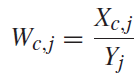



In [60]:
W = np.zeros((len(Y), len(C)))
r_names = [_ for _ in Y['word'] ]
c_names = [_ for _ in C]
df_W = pd.DataFrame(W, index=r_names, columns= c_names)



In [17]:
df_W

food   service     price  ambience  \
staff             0.147059  0.686275  0.000000  0.137255   
horrible          0.347826  0.347826  0.000000  0.130435   
us                0.200000  0.564706  0.035294  0.023529   
                  0.000000  0.000000  0.000000  0.000000   
completely        0.545455  0.181818  0.000000  0.090909   
fair              0.400000  0.000000  0.200000  0.100000   
food              0.547120  0.166230  0.103403  0.099476   
average           0.450000  0.225000  0.150000  0.075000   
could             0.302632  0.263158  0.039474  0.131579   
nt                0.287926  0.201238  0.102167  0.092879   
make              0.369565  0.217391  0.057971  0.152174   
exceptional       0.571429  0.285714  0.142857  0.000000   
kitchen           0.333333  0.250000  0.000000  0.250000   
feel              0.157895  0.184211  0.026316  0.342105   
like              0.400000  0.177143  0.040000  0.154286   
whether           0.428571  0.142857  0.000000  0.142857   
menu              0.627273  0.127273  0.100000  0.063636   
recommend         0.280000  0.070000  0.040000  0.070000   
eat               0.323077  0.069231  0.084615  0.123077   
go                0.190031  0.077882  0.049844  0.090343   
enjoy             0.322581  0.177419  0.016129  0.225806   
say               0.271429  0.157143  0.100000  0.071429   
get               0.265766  0.238739  0.108108  0.117117   
outstanding       0.523810  0.285714  0.047619  0.047619   
little            0.272727  0.204545  0.136364  0.227273   
great             0.376190  0.185714  0.135714  0.159524   
overpriced        0.416667  0.000000  0.500000  0.083333   
tasty             0.703704  0.055556  0.222222  0.018519   
agree             0.142857  0.428571  0.000000  0.000000   
favorite          0.324324  0.054054  0.054054  0.000000   
...                    ...       ...       ...       ...   
dep,staff         0.000000  0.166667  0.000000  0.166667   
conj,decent       0.375000  0.000000  0.125000  0.375000   
conj,seat         0.200000  0.800000  0.000000  0.000000   
advmod,wait       0.000000  0.000000  0.000000  0.000000   
compound,plate    0.166667  0.000000  0.333333  0.166667   
amod,crust        0.000000  0.000000  0.000000  0.000000   
nsubj,put         0.166667  0.166667  0.166667  0.000000   
amod,bo           0.000000  0.000000  0.000000  0.000000   
ccomp,mean        0.200000  0.000000  0.200000  0.000000   
dep,way           0.333333  0.500000  0.166667  0.000000   
compound,look     0.166667  0.000000  0.000000  0.333333   
nmod,average      0.285714  0.428571  0.142857  0.000000   
ccomp,use         0.666667  0.166667  0.000000  0.000000   
amod,tea          0.000000  0.000000  0.000000  0.000000   
amod,woman        0.000000  0.000000  0.000000  0.000000   
conj,bread        0.375000  0.375000  0.000000  0.000000   
compound,size     0.555556  0.111111  0.111111  0.111111   
compound,girl     0.166667  0.000000  0.000000  0.000000   
nsubj,empty       0.000000  0.000000  0.000000  0.000000   
nmod,perfect      0.166667  0.000000  0.166667  0.000000   
advmod,pack       0.000000  0.200000  0.000000  0.200000   
conj,hot          0.750000  0.000000  0.000000  0.250000   
dep,put           0.166667  0.166667  0.166667  0.000000   
nmod,chicken      1.000000  0.000000  0.000000  0.000000   
dep,sushi         0.428571  0.000000  0.142857  0.285714   
nsubj,show        0.200000  0.400000  0.000000  0.200000   
dobj,live         0.000000  0.000000  0.000000  0.200000   
advmod,overprice  0.375000  0.000000  0.375000  0.125000   
nmod,fell         0.200000  0.000000  0.000000  0.000000   
advcl,great       0.444444  0.222222  0.333333  0.111111   

                  anecdotes/miscellaneous  
staff                            0.029412  
horrible                         0.173913  
us                               0.176471  
                                 0.000000  
completely                       0.181818  
fair                             0.30

In [2]:
df_X = pd.read_pickle('pickels/180k_X_mat')


In [62]:
print (C)
start_time = time.clock()
for index, row in Y.iterrows():
    for cc in range(0, len(C)):
        #print( row['word'], C[cc], ",,")
        print (row)
        X_ij = df_X.loc[row['word'], C[cc]]
        #print (X_ij)
        Y_j = Y.loc[Y['word'] == row['word'] , 'count'].iloc[0]
        #print ("Y ::",Y_i)
        df_W.loc[row['word'], C[cc]] = X_ij/Y_j
    
    

print ("Finish Time:", time.clock() - start_time)

['food', 'service', 'price', 'ambience', 'anecdotes/miscellaneous']
count      102
word     staff
Name: 0, dtype: object
count      102
word     staff
Name: 0, dtype: object
count      102
word     staff
Name: 0, dtype: object
count      102
word     staff
Name: 0, dtype: object
count      102
word     staff
Name: 0, dtype: object
count          23
word     horrible
Name: 1, dtype: object
count          23
word     horrible
Name: 1, dtype: object
count          23
word     horrible
Name: 1, dtype: object
count          23
word     horrible
Name: 1, dtype: object
count          23
word     horrible
Name: 1, dtype: object
count    85
word     us
Name: 2, dtype: object
count    85
word     us
Name: 2, dtype: object
count    85
word     us
Name: 2, dtype: object
count    85
word     us
Name: 2, dtype: object
count    85
word     us
Name: 2, dtype: object
count    5443
word         
Name: 3, dtype: object
count    5443
word         
Name: 3, dtype: object
count    5443
word         
Name: 3

Name: 39, dtype: object
count       42
word     bagel
Name: 39, dtype: object
count       42
word     bagel
Name: 39, dtype: object
count       42
word     bagel
Name: 39, dtype: object
count       42
word     bagel
Name: 39, dtype: object
count       65
word     taste
Name: 40, dtype: object
count       65
word     taste
Name: 40, dtype: object
count       65
word     taste
Name: 40, dtype: object
count       65
word     taste
Name: 40, dtype: object
count       65
word     taste
Name: 40, dtype: object
count          19
word     terrific
Name: 41, dtype: object
count          19
word     terrific
Name: 41, dtype: object
count          19
word     terrific
Name: 41, dtype: object
count          19
word     terrific
Name: 41, dtype: object
count          19
word     terrific
Name: 41, dtype: object
count     30
word     yet
Name: 42, dtype: object
count     30
word     yet
Name: 42, dtype: object
count     30
word     yet
Name: 42, dtype: object
count     30
word     yet
Name: 42, dtyp

Name: 79, dtype: object
count       11
word     crust
Name: 79, dtype: object
count       11
word     crust
Name: 79, dtype: object
count       11
word     crust
Name: 79, dtype: object
count       11
word     crust
Name: 79, dtype: object
count            12
word     girlfriend
Name: 80, dtype: object
count            12
word     girlfriend
Name: 80, dtype: object
count            12
word     girlfriend
Name: 80, dtype: object
count            12
word     girlfriend
Name: 80, dtype: object
count            12
word     girlfriend
Name: 80, dtype: object
count          7
word     stumble
Name: 81, dtype: object
count          7
word     stumble
Name: 81, dtype: object
count          7
word     stumble
Name: 81, dtype: object
count          7
word     stumble
Name: 81, dtype: object
count          7
word     stumble
Name: 81, dtype: object
count     10
word     hop
Name: 82, dtype: object
count     10
word     hop
Name: 82, dtype: object
count     10
word     hop
Name: 82, dtype: object


count     42
word     two
Name: 118, dtype: object
count     42
word     two
Name: 118, dtype: object
count     42
word     two
Name: 118, dtype: object
count        87
word     people
Name: 119, dtype: object
count        87
word     people
Name: 119, dtype: object
count        87
word     people
Name: 119, dtype: object
count        87
word     people
Name: 119, dtype: object
count        87
word     people
Name: 119, dtype: object
count       14
word     whole
Name: 120, dtype: object
count       14
word     whole
Name: 120, dtype: object
count       14
word     whole
Name: 120, dtype: object
count       14
word     whole
Name: 120, dtype: object
count       14
word     whole
Name: 120, dtype: object
count            78
word     experience
Name: 121, dtype: object
count            78
word     experience
Name: 121, dtype: object
count            78
word     experience
Name: 121, dtype: object
count            78
word     experience
Name: 121, dtype: object
count            78
word   

count            6
word     celebrate
Name: 156, dtype: object
count            6
word     celebrate
Name: 156, dtype: object
count            6
word     celebrate
Name: 156, dtype: object
count          15
word     birthday
Name: 157, dtype: object
count          15
word     birthday
Name: 157, dtype: object
count          15
word     birthday
Name: 157, dtype: object
count          15
word     birthday
Name: 157, dtype: object
count          15
word     birthday
Name: 157, dtype: object
count              6
word     anniversary
Name: 158, dtype: object
count              6
word     anniversary
Name: 158, dtype: object
count              6
word     anniversary
Name: 158, dtype: object
count              6
word     anniversary
Name: 158, dtype: object
count              6
word     anniversary
Name: 158, dtype: object
count      21
word     cute
Name: 159, dtype: object
count      21
word     cute
Name: 159, dtype: object
count      21
word     cute
Name: 159, dtype: object
count      2

Name: 193, dtype: object
count        26
word     course
Name: 193, dtype: object
count        26
word     course
Name: 193, dtype: object
count        28
word     choice
Name: 194, dtype: object
count        28
word     choice
Name: 194, dtype: object
count        28
word     choice
Name: 194, dtype: object
count        28
word     choice
Name: 194, dtype: object
count        28
word     choice
Name: 194, dtype: object
count         18
word     include
Name: 195, dtype: object
count         18
word     include
Name: 195, dtype: object
count         18
word     include
Name: 195, dtype: object
count         18
word     include
Name: 195, dtype: object
count         18
word     include
Name: 195, dtype: object
count          116
word     excellent
Name: 196, dtype: object
count          116
word     excellent
Name: 196, dtype: object
count          116
word     excellent
Name: 196, dtype: object
count          116
word     excellent
Name: 196, dtype: object
count          116
word     e

Name: 233, dtype: object
count      104
word     table
Name: 233, dtype: object
count      104
word     table
Name: 233, dtype: object
count          15
word     fabulous
Name: 234, dtype: object
count          15
word     fabulous
Name: 234, dtype: object
count          15
word     fabulous
Name: 234, dtype: object
count          15
word     fabulous
Name: 234, dtype: object
count          15
word     fabulous
Name: 234, dtype: object
count           29
word     fantastic
Name: 235, dtype: object
count           29
word     fantastic
Name: 235, dtype: object
count           29
word     fantastic
Name: 235, dtype: object
count           29
word     fantastic
Name: 235, dtype: object
count           29
word     fantastic
Name: 235, dtype: object
count       8
word     hear
Name: 236, dtype: object
count       8
word     hear
Name: 236, dtype: object
count       8
word     hear
Name: 236, dtype: object
count       8
word     hear
Name: 236, dtype: object
count       8
word     hear
Name:

Name: 273, dtype: object
count      14
word     jazz
Name: 273, dtype: object
count       15
word     point
Name: 274, dtype: object
count       15
word     point
Name: 274, dtype: object
count       15
word     point
Name: 274, dtype: object
count       15
word     point
Name: 274, dtype: object
count       15
word     point
Name: 274, dtype: object
count       34
word     thing
Name: 275, dtype: object
count       34
word     thing
Name: 275, dtype: object
count       34
word     thing
Name: 275, dtype: object
count       34
word     thing
Name: 275, dtype: object
count       34
word     thing
Name: 275, dtype: object
count      23
word     felt
Name: 276, dtype: object
count      23
word     felt
Name: 276, dtype: object
count      23
word     felt
Name: 276, dtype: object
count      23
word     felt
Name: 276, dtype: object
count      23
word     felt
Name: 276, dtype: object
count      16
word     rush
Name: 277, dtype: object
count      16
word     rush
Name: 277, dtype: object
c

count          5
word     brewery
Name: 310, dtype: object
count          5
word     brewery
Name: 310, dtype: object
count          5
word     brewery
Name: 310, dtype: object
count     12
word     old
Name: 311, dtype: object
count     12
word     old
Name: 311, dtype: object
count     12
word     old
Name: 311, dtype: object
count     12
word     old
Name: 311, dtype: object
count     12
word     old
Name: 311, dtype: object
count       17
word     write
Name: 312, dtype: object
count       17
word     write
Name: 312, dtype: object
count       17
word     write
Name: 312, dtype: object
count       17
word     write
Name: 312, dtype: object
count       17
word     write
Name: 312, dtype: object
count        39
word     review
Name: 313, dtype: object
count        39
word     review
Name: 313, dtype: object
count        39
word     review
Name: 313, dtype: object
count        39
word     review
Name: 313, dtype: object
count        39
word     review
Name: 313, dtype: object
count   

count        15
word     entire
Name: 344, dtype: object
count        15
word     entire
Name: 344, dtype: object
count        15
word     entire
Name: 344, dtype: object
count        15
word     entire
Name: 344, dtype: object
count        15
word     entire
Name: 344, dtype: object
count         39
word     however
Name: 345, dtype: object
count         39
word     however
Name: 345, dtype: object
count         39
word     however
Name: 345, dtype: object
count         39
word     however
Name: 345, dtype: object
count         39
word     however
Name: 345, dtype: object
count         16
word     lobster
Name: 346, dtype: object
count         16
word     lobster
Name: 346, dtype: object
count         16
word     lobster
Name: 346, dtype: object
count         16
word     lobster
Name: 346, dtype: object
count         16
word     lobster
Name: 346, dtype: object
count          24
word     sandwich
Name: 347, dtype: object
count          24
word     sandwich
Name: 347, dtype: object
cou

count            5
word     artisanal
Name: 377, dtype: object
count            5
word     artisanal
Name: 377, dtype: object
count            5
word     artisanal
Name: 377, dtype: object
count            5
word     artisanal
Name: 377, dtype: object
count            5
word     artisanal
Name: 377, dtype: object
count          23
word     consider
Name: 378, dtype: object
count          23
word     consider
Name: 378, dtype: object
count          23
word     consider
Name: 378, dtype: object
count          23
word     consider
Name: 378, dtype: object
count          23
word     consider
Name: 378, dtype: object
count       5
word     baby
Name: 379, dtype: object
count       5
word     baby
Name: 379, dtype: object
count       5
word     baby
Name: 379, dtype: object
count       5
word     baby
Name: 379, dtype: object
count       5
word     baby
Name: 379, dtype: object
count      10
word     wish
Name: 380, dtype: object
count      10
word     wish
Name: 380, dtype: object
count    

count            4
word     regularly
Name: 411, dtype: object
count      28
word     keep
Name: 412, dtype: object
count      28
word     keep
Name: 412, dtype: object
count      28
word     keep
Name: 412, dtype: object
count      28
word     keep
Name: 412, dtype: object
count      28
word     keep
Name: 412, dtype: object
count      4
word     raw
Name: 413, dtype: object
count      4
word     raw
Name: 413, dtype: object
count      4
word     raw
Name: 413, dtype: object
count      4
word     raw
Name: 413, dtype: object
count      4
word     raw
Name: 413, dtype: object
count         5
word     crappy
Name: 414, dtype: object
count         5
word     crappy
Name: 414, dtype: object
count         5
word     crappy
Name: 414, dtype: object
count         5
word     crappy
Name: 414, dtype: object
count         5
word     crappy
Name: 414, dtype: object
count      29
word     deal
Name: 415, dtype: object
count      29
word     deal
Name: 415, dtype: object
count      29
word     dea

count      32
word     away
Name: 450, dtype: object
count      32
word     away
Name: 450, dtype: object
count         5
word     murray
Name: 451, dtype: object
count         5
word     murray
Name: 451, dtype: object
count         5
word     murray
Name: 451, dtype: object
count         5
word     murray
Name: 451, dtype: object
count         5
word     murray
Name: 451, dtype: object
count          21
word     anything
Name: 452, dtype: object
count          21
word     anything
Name: 452, dtype: object
count          21
word     anything
Name: 452, dtype: object
count          21
word     anything
Name: 452, dtype: object
count          21
word     anything
Name: 452, dtype: object
count      19
word     part
Name: 453, dtype: object
count      19
word     part
Name: 453, dtype: object
count      19
word     part
Name: 453, dtype: object
count      19
word     part
Name: 453, dtype: object
count      19
word     part
Name: 453, dtype: object
count            21
word     disappoint

count      10
word     item
Name: 489, dtype: object
count      10
word     item
Name: 489, dtype: object
count      10
word     item
Name: 489, dtype: object
count      10
word     item
Name: 489, dtype: object
count     8
word     30
Name: 490, dtype: object
count     8
word     30
Name: 490, dtype: object
count     8
word     30
Name: 490, dtype: object
count     8
word     30
Name: 490, dtype: object
count     8
word     30
Name: 490, dtype: object
count       11
word     clean
Name: 491, dtype: object
count       11
word     clean
Name: 491, dtype: object
count       11
word     clean
Name: 491, dtype: object
count       11
word     clean
Name: 491, dtype: object
count       11
word     clean
Name: 491, dtype: object
count       6
word     cash
Name: 492, dtype: object
count       6
word     cash
Name: 492, dtype: object
count       6
word     cash
Name: 492, dtype: object
count       6
word     cash
Name: 492, dtype: object
count       6
word     cash
Name: 492, dtype: object
cou

count       18
word     pasta
Name: 528, dtype: object
count       18
word     pasta
Name: 528, dtype: object
count       18
word     pasta
Name: 528, dtype: object
count       18
word     pasta
Name: 528, dtype: object
count       18
word     pasta
Name: 528, dtype: object
count      16
word     main
Name: 529, dtype: object
count      16
word     main
Name: 529, dtype: object
count      16
word     main
Name: 529, dtype: object
count      16
word     main
Name: 529, dtype: object
count      16
word     main
Name: 529, dtype: object
count         10
word     suggest
Name: 530, dtype: object
count         10
word     suggest
Name: 530, dtype: object
count         10
word     suggest
Name: 530, dtype: object
count         10
word     suggest
Name: 530, dtype: object
count         10
word     suggest
Name: 530, dtype: object
count         4
word     sister
Name: 531, dtype: object
count         4
word     sister
Name: 531, dtype: object
count         4
word     sister
Name: 531, dtype: o

Name: 566, dtype: object
count        14
word     either
Name: 566, dtype: object
count        14
word     either
Name: 566, dtype: object
count        14
word     either
Name: 566, dtype: object
count        14
word     either
Name: 566, dtype: object
count      16
word     fact
Name: 567, dtype: object
count      16
word     fact
Name: 567, dtype: object
count      16
word     fact
Name: 567, dtype: object
count      16
word     fact
Name: 567, dtype: object
count      16
word     fact
Name: 567, dtype: object
count       6
word     kick
Name: 568, dtype: object
count       6
word     kick
Name: 568, dtype: object
count       6
word     kick
Name: 568, dtype: object
count       6
word     kick
Name: 568, dtype: object
count       6
word     kick
Name: 568, dtype: object
count        7
word     filet
Name: 569, dtype: object
count        7
word     filet
Name: 569, dtype: object
count        7
word     filet
Name: 569, dtype: object
count        7
word     filet
Name: 569, dtype: obje

count          5
word     cooking
Name: 605, dtype: object
count          5
word     cooking
Name: 605, dtype: object
count          5
word     cooking
Name: 605, dtype: object
count          5
word     cooking
Name: 605, dtype: object
count          5
word     cooking
Name: 605, dtype: object
count       7
word     joya
Name: 606, dtype: object
count       7
word     joya
Name: 606, dtype: object
count       7
word     joya
Name: 606, dtype: object
count       7
word     joya
Name: 606, dtype: object
count       7
word     joya
Name: 606, dtype: object
count       9
word     prix
Name: 607, dtype: object
count       9
word     prix
Name: 607, dtype: object
count       9
word     prix
Name: 607, dtype: object
count       9
word     prix
Name: 607, dtype: object
count       9
word     prix
Name: 607, dtype: object
count      10
word     fixe
Name: 608, dtype: object
count      10
word     fixe
Name: 608, dtype: object
count      10
word     fixe
Name: 608, dtype: object
count      10
wo

count           7
word     overbear
Name: 642, dtype: object
count     12
word     tip
Name: 643, dtype: object
count     12
word     tip
Name: 643, dtype: object
count     12
word     tip
Name: 643, dtype: object
count     12
word     tip
Name: 643, dtype: object
count     12
word     tip
Name: 643, dtype: object
count      27
word     walk
Name: 644, dtype: object
count      27
word     walk
Name: 644, dtype: object
count      27
word     walk
Name: 644, dtype: object
count      27
word     walk
Name: 644, dtype: object
count      27
word     walk
Name: 644, dtype: object
count        18
word     bistro
Name: 645, dtype: object
count        18
word     bistro
Name: 645, dtype: object
count        18
word     bistro
Name: 645, dtype: object
count        18
word     bistro
Name: 645, dtype: object
count        18
word     bistro
Name: 645, dtype: object
count       7
word     tend
Name: 646, dtype: object
count       7
word     tend
Name: 646, dtype: object
count       7
word     tend


count       5
word     naan
Name: 681, dtype: object
count       5
word     naan
Name: 681, dtype: object
count       5
word     naan
Name: 681, dtype: object
count       5
word     naan
Name: 681, dtype: object
count       5
word     naan
Name: 681, dtype: object
count      23
word     bill
Name: 682, dtype: object
count      23
word     bill
Name: 682, dtype: object
count      23
word     bill
Name: 682, dtype: object
count      23
word     bill
Name: 682, dtype: object
count      23
word     bill
Name: 682, dtype: object
count           20
word     beautiful
Name: 683, dtype: object
count           20
word     beautiful
Name: 683, dtype: object
count           20
word     beautiful
Name: 683, dtype: object
count           20
word     beautiful
Name: 683, dtype: object
count           20
word     beautiful
Name: 683, dtype: object
count      17
word     wife
Name: 684, dtype: object
count      17
word     wife
Name: 684, dtype: object
count      17
word     wife
Name: 684, dtype: obj

Name: 720, dtype: object
count      14
word     view
Name: 720, dtype: object
count        7
word     light
Name: 721, dtype: object
count        7
word     light
Name: 721, dtype: object
count        7
word     light
Name: 721, dtype: object
count        7
word     light
Name: 721, dtype: object
count        7
word     light
Name: 721, dtype: object
count            8
word     otherwise
Name: 722, dtype: object
count            8
word     otherwise
Name: 722, dtype: object
count            8
word     otherwise
Name: 722, dtype: object
count            8
word     otherwise
Name: 722, dtype: object
count            8
word     otherwise
Name: 722, dtype: object
count        8
word     along
Name: 723, dtype: object
count        8
word     along
Name: 723, dtype: object
count        8
word     along
Name: 723, dtype: object
count        8
word     along
Name: 723, dtype: object
count        8
word     along
Name: 723, dtype: object
count           7
word     attitude
Name: 724, dtype: obj

count       12
word     soggy
Name: 759, dtype: object
count       12
word     soggy
Name: 759, dtype: object
count       12
word     soggy
Name: 759, dtype: object
count       12
word     soggy
Name: 759, dtype: object
count       12
word     soggy
Name: 759, dtype: object
count       9
word     plan
Name: 760, dtype: object
count       9
word     plan
Name: 760, dtype: object
count       9
word     plan
Name: 760, dtype: object
count       9
word     plan
Name: 760, dtype: object
count       9
word     plan
Name: 760, dtype: object
count         6
word     others
Name: 761, dtype: object
count         6
word     others
Name: 761, dtype: object
count         6
word     others
Name: 761, dtype: object
count         6
word     others
Name: 761, dtype: object
count         6
word     others
Name: 761, dtype: object
count             5
word     appreciate
Name: 762, dtype: object
count             5
word     appreciate
Name: 762, dtype: object
count             5
word     appreciate
Name:

Name: 797, dtype: object
count        4
word     phone
Name: 797, dtype: object
count        4
word     phone
Name: 797, dtype: object
count         12
word     typical
Name: 798, dtype: object
count         12
word     typical
Name: 798, dtype: object
count         12
word     typical
Name: 798, dtype: object
count         12
word     typical
Name: 798, dtype: object
count         12
word     typical
Name: 798, dtype: object
count         7
word     option
Name: 799, dtype: object
count         7
word     option
Name: 799, dtype: object
count         7
word     option
Name: 799, dtype: object
count         7
word     option
Name: 799, dtype: object
count         7
word     option
Name: 799, dtype: object
count            5
word     tasteless
Name: 800, dtype: object
count            5
word     tasteless
Name: 800, dtype: object
count            5
word     tasteless
Name: 800, dtype: object
count            5
word     tasteless
Name: 800, dtype: object
count            5
word     taste

count      10
word     stop
Name: 838, dtype: object
count      10
word     stop
Name: 838, dtype: object
count      10
word     stop
Name: 838, dtype: object
count      10
word     stop
Name: 838, dtype: object
count      10
word     stop
Name: 838, dtype: object
count      9
word     kid
Name: 839, dtype: object
count      9
word     kid
Name: 839, dtype: object
count      9
word     kid
Name: 839, dtype: object
count      9
word     kid
Name: 839, dtype: object
count      9
word     kid
Name: 839, dtype: object
count         10
word     outdoor
Name: 840, dtype: object
count         10
word     outdoor
Name: 840, dtype: object
count         10
word     outdoor
Name: 840, dtype: object
count         10
word     outdoor
Name: 840, dtype: object
count         10
word     outdoor
Name: 840, dtype: object
count         5
word     twenty
Name: 841, dtype: object
count         5
word     twenty
Name: 841, dtype: object
count         5
word     twenty
Name: 841, dtype: object
count         

count         5
word     locate
Name: 878, dtype: object
count         5
word     locate
Name: 878, dtype: object
count        7
word     allow
Name: 879, dtype: object
count        7
word     allow
Name: 879, dtype: object
count        7
word     allow
Name: 879, dtype: object
count        7
word     allow
Name: 879, dtype: object
count        7
word     allow
Name: 879, dtype: object
count         7
word     jekyll
Name: 880, dtype: object
count         7
word     jekyll
Name: 880, dtype: object
count         7
word     jekyll
Name: 880, dtype: object
count         7
word     jekyll
Name: 880, dtype: object
count         7
word     jekyll
Name: 880, dtype: object
count       7
word     hyde
Name: 881, dtype: object
count       7
word     hyde
Name: 881, dtype: object
count       7
word     hyde
Name: 881, dtype: object
count       7
word     hyde
Name: 881, dtype: object
count       7
word     hyde
Name: 881, dtype: object
count      4
word     pub
Name: 882, dtype: object
count     

count         5
word     awsome
Name: 918, dtype: object
count       4
word     bean
Name: 919, dtype: object
count       4
word     bean
Name: 919, dtype: object
count       4
word     bean
Name: 919, dtype: object
count       4
word     bean
Name: 919, dtype: object
count       4
word     bean
Name: 919, dtype: object
count         4
word     jersey
Name: 920, dtype: object
count         4
word     jersey
Name: 920, dtype: object
count         4
word     jersey
Name: 920, dtype: object
count         4
word     jersey
Name: 920, dtype: object
count         4
word     jersey
Name: 920, dtype: object
count         4
word     exotic
Name: 921, dtype: object
count         4
word     exotic
Name: 921, dtype: object
count         4
word     exotic
Name: 921, dtype: object
count         4
word     exotic
Name: 921, dtype: object
count         4
word     exotic
Name: 921, dtype: object
count    8
word     1
Name: 922, dtype: object
count    8
word     1
Name: 922, dtype: object
count    8
wor

count                   12
word     people,nummod,two
Name: 958, dtype: object
count                   12
word     people,nummod,two
Name: 958, dtype: object
count                4
word     try,dobj,dish
Name: 959, dtype: object
count                4
word     try,dobj,dish
Name: 959, dtype: object
count                4
word     try,dobj,dish
Name: 959, dtype: object
count                4
word     try,dobj,dish
Name: 959, dtype: object
count                4
word     try,dobj,dish
Name: 959, dtype: object
count                       15
word     service,amod,friendly
Name: 960, dtype: object
count                       15
word     service,amod,friendly
Name: 960, dtype: object
count                       15
word     service,amod,friendly
Name: 960, dtype: object
count                       15
word     service,amod,friendly
Name: 960, dtype: object
count                       15
word     service,amod,friendly
Name: 960, dtype: object
count               7
word     miss,neg,n't
Name: 96

Name: 999, dtype: object
count                  6
word     pizza,amod,good
Name: 999, dtype: object
count                  6
word     pizza,amod,good
Name: 999, dtype: object
count                  6
word     pizza,amod,good
Name: 999, dtype: object
count                  6
word     pizza,amod,good
Name: 999, dtype: object
count                6
word     've,neg,never
Name: 1000, dtype: object
count                6
word     've,neg,never
Name: 1000, dtype: object
count                6
word     've,neg,never
Name: 1000, dtype: object
count                6
word     've,neg,never
Name: 1000, dtype: object
count                6
word     've,neg,never
Name: 1000, dtype: object
count                14
word     time,amod,many
Name: 1001, dtype: object
count                14
word     time,amod,many
Name: 1001, dtype: object
count                14
word     time,amod,many
Name: 1001, dtype: object
count                14
word     time,amod,many
Name: 1001, dtype: object
count              

count                  19
word     great,nsubj,food
Name: 1038, dtype: object
count                  19
word     great,nsubj,food
Name: 1038, dtype: object
count               4
word     look,neg,n't
Name: 1039, dtype: object
count               4
word     look,neg,n't
Name: 1039, dtype: object
count               4
word     look,neg,n't
Name: 1039, dtype: object
count               4
word     look,neg,n't
Name: 1039, dtype: object
count               4
word     look,neg,n't
Name: 1039, dtype: object
count                      7
word     eat,nmod,restaurant
Name: 1040, dtype: object
count                      7
word     eat,nmod,restaurant
Name: 1040, dtype: object
count                      7
word     eat,nmod,restaurant
Name: 1040, dtype: object
count                      7
word     eat,nmod,restaurant
Name: 1040, dtype: object
count                      7
word     eat,nmod,restaurant
Name: 1040, dtype: object
count                 11
word     night,amod,last
Name: 1041, dtype: objec

count                    12
word     food,compound,thai
Name: 1078, dtype: object
count                    12
word     food,compound,thai
Name: 1078, dtype: object
count                    12
word     food,compound,thai
Name: 1078, dtype: object
count                   6
word     read,dobj,review
Name: 1079, dtype: object
count                   6
word     read,dobj,review
Name: 1079, dtype: object
count                   6
word     read,dobj,review
Name: 1079, dtype: object
count                   6
word     read,dobj,review
Name: 1079, dtype: object
count                   6
word     read,dobj,review
Name: 1079, dtype: object
count                  5
word     make,xcomp,sure
Name: 1080, dtype: object
count                  5
word     make,xcomp,sure
Name: 1080, dtype: object
count                  5
word     make,xcomp,sure
Name: 1080, dtype: object
count                  5
word     make,xcomp,sure
Name: 1080, dtype: object
count                  5
word     make,xcomp,sure
Name: 1080

count                  16
word     price,amod,great
Name: 1115, dtype: object
count                  16
word     price,amod,great
Name: 1115, dtype: object
count                  16
word     price,amod,great
Name: 1115, dtype: object
count                  16
word     price,amod,great
Name: 1115, dtype: object
count                  16
word     price,amod,great
Name: 1115, dtype: object
count                  4
word     keep,xcomp,come
Name: 1116, dtype: object
count                  4
word     keep,xcomp,come
Name: 1116, dtype: object
count                  4
word     keep,xcomp,come
Name: 1116, dtype: object
count                  4
word     keep,xcomp,come
Name: 1116, dtype: object
count                  4
word     keep,xcomp,come
Name: 1116, dtype: object
count                             8
word     experience,compound,dining
Name: 1117, dtype: object
count                             8
word     experience,compound,dining
Name: 1117, dtype: object
count                             

count                         4
word     stay,compound:prt,away
Name: 1155, dtype: object
count                         4
word     stay,compound:prt,away
Name: 1155, dtype: object
count                        7
word     attentive,nsubj,staff
Name: 1156, dtype: object
count                        7
word     attentive,nsubj,staff
Name: 1156, dtype: object
count                        7
word     attentive,nsubj,staff
Name: 1156, dtype: object
count                        7
word     attentive,nsubj,staff
Name: 1156, dtype: object
count                        7
word     attentive,nsubj,staff
Name: 1156, dtype: object
count                        11
word     service,amod,excellent
Name: 1157, dtype: object
count                        11
word     service,amod,excellent
Name: 1157, dtype: object
count                        11
word     service,amod,excellent
Name: 1157, dtype: object
count                        11
word     service,amod,excellent
Name: 1157, dtype: object
count               

count                24
word     advmod,usually
Name: 1186, dtype: object
count               12
word     advmod,enough
Name: 1187, dtype: object
count               12
word     advmod,enough
Name: 1187, dtype: object
count               12
word     advmod,enough
Name: 1187, dtype: object
count               12
word     advmod,enough
Name: 1187, dtype: object
count               12
word     advmod,enough
Name: 1187, dtype: object
count           22
word     dobj,dish
Name: 1188, dtype: object
count           22
word     dobj,dish
Name: 1188, dtype: object
count           22
word     dobj,dish
Name: 1188, dtype: object
count           22
word     dobj,dish
Name: 1188, dtype: object
count           22
word     dobj,dish
Name: 1188, dtype: object
count           26
word     advcl,get
Name: 1189, dtype: object
count           26
word     advcl,get
Name: 1189, dtype: object
count           26
word     advcl,get
Name: 1189, dtype: object
count           26
word     advcl,get
Name: 1189, dtyp

Name: 1215, dtype: object
count           275
word     amod,great
Name: 1216, dtype: object
count           275
word     amod,great
Name: 1216, dtype: object
count           275
word     amod,great
Name: 1216, dtype: object
count           275
word     amod,great
Name: 1216, dtype: object
count           275
word     amod,great
Name: 1216, dtype: object
count        48
word     aux,ca
Name: 1217, dtype: object
count        48
word     aux,ca
Name: 1217, dtype: object
count        48
word     aux,ca
Name: 1217, dtype: object
count        48
word     aux,ca
Name: 1217, dtype: object
count        48
word     aux,ca
Name: 1217, dtype: object
count            27
word     nmod,night
Name: 1218, dtype: object
count            27
word     nmod,night
Name: 1218, dtype: object
count            27
word     nmod,night
Name: 1218, dtype: object
count            27
word     nmod,night
Name: 1218, dtype: object
count            27
word     nmod,night
Name: 1218, dtype: object
count            104
wor

count                  9
word     amod,incredible
Name: 1250, dtype: object
count                  9
word     amod,incredible
Name: 1250, dtype: object
count                  9
word     amod,incredible
Name: 1250, dtype: object
count                  9
word     amod,incredible
Name: 1250, dtype: object
count                  9
word     amod,incredible
Name: 1250, dtype: object
count              56
word     nmod,service
Name: 1251, dtype: object
count              56
word     nmod,service
Name: 1251, dtype: object
count              56
word     nmod,service
Name: 1251, dtype: object
count              56
word     nmod,service
Name: 1251, dtype: object
count              56
word     nmod,service
Name: 1251, dtype: object
count               36
word     amod,friendly
Name: 1252, dtype: object
count               36
word     amod,friendly
Name: 1252, dtype: object
count               36
word     amod,friendly
Name: 1252, dtype: object
count               36
word     amod,friendly
Name: 12

count             6
word     amod,empty
Name: 1286, dtype: object
count             6
word     amod,empty
Name: 1286, dtype: object
count             6
word     amod,empty
Name: 1286, dtype: object
count             6
word     amod,empty
Name: 1286, dtype: object
count            19
word     nsubj,wine
Name: 1287, dtype: object
count            19
word     nsubj,wine
Name: 1287, dtype: object
count            19
word     nsubj,wine
Name: 1287, dtype: object
count            19
word     nsubj,wine
Name: 1287, dtype: object
count            19
word     nsubj,wine
Name: 1287, dtype: object
count                 11
word     xcomp,excellent
Name: 1288, dtype: object
count                 11
word     xcomp,excellent
Name: 1288, dtype: object
count                 11
word     xcomp,excellent
Name: 1288, dtype: object
count                 11
word     xcomp,excellent
Name: 1288, dtype: object
count                 11
word     xcomp,excellent
Name: 1288, dtype: object
count           44
word   

count             33
word     nmod,people
Name: 1321, dtype: object
count             33
word     nmod,people
Name: 1321, dtype: object
count             33
word     nmod,people
Name: 1321, dtype: object
count          187
word     amod,good
Name: 1322, dtype: object
count          187
word     amod,good
Name: 1322, dtype: object
count          187
word     amod,good
Name: 1322, dtype: object
count          187
word     amod,good
Name: 1322, dtype: object
count          187
word     amod,good
Name: 1322, dtype: object
count             38
word     nmod,dinner
Name: 1323, dtype: object
count             38
word     nmod,dinner
Name: 1323, dtype: object
count             38
word     nmod,dinner
Name: 1323, dtype: object
count             38
word     nmod,dinner
Name: 1323, dtype: object
count             38
word     nmod,dinner
Name: 1323, dtype: object
count                  9
word     conj,experience
Name: 1324, dtype: object
count                  9
word     conj,experience
Name: 1324

count          63
word     amod,new
Name: 1356, dtype: object
count          63
word     amod,new
Name: 1356, dtype: object
count          63
word     amod,new
Name: 1356, dtype: object
count          63
word     amod,new
Name: 1356, dtype: object
count               75
word     advmod,always
Name: 1357, dtype: object
count               75
word     advmod,always
Name: 1357, dtype: object
count               75
word     advmod,always
Name: 1357, dtype: object
count               75
word     advmod,always
Name: 1357, dtype: object
count               75
word     advmod,always
Name: 1357, dtype: object
count                9
word     advmod,around
Name: 1358, dtype: object
count                9
word     advmod,around
Name: 1358, dtype: object
count                9
word     advmod,around
Name: 1358, dtype: object
count                9
word     advmod,around
Name: 1358, dtype: object
count                9
word     advmod,around
Name: 1358, dtype: object
count          21
word     conj,

count         7
word     case,'
Name: 1392, dtype: object
count         7
word     case,'
Name: 1392, dtype: object
count         7
word     case,'
Name: 1392, dtype: object
count          25
word     amod,big
Name: 1393, dtype: object
count          25
word     amod,big
Name: 1393, dtype: object
count          25
word     amod,big
Name: 1393, dtype: object
count          25
word     amod,big
Name: 1393, dtype: object
count          25
word     amod,big
Name: 1393, dtype: object
count         25
word     aux,may
Name: 1394, dtype: object
count         25
word     aux,may
Name: 1394, dtype: object
count         25
word     aux,may
Name: 1394, dtype: object
count         25
word     aux,may
Name: 1394, dtype: object
count         25
word     aux,may
Name: 1394, dtype: object
count             22
word     amod,french
Name: 1395, dtype: object
count             22
word     amod,french
Name: 1395, dtype: object
count             22
word     amod,french
Name: 1395, dtype: object
count       

count              42
word     advmod,still
Name: 1427, dtype: object
count              42
word     advmod,still
Name: 1427, dtype: object
count              42
word     advmod,still
Name: 1427, dtype: object
count              42
word     advmod,still
Name: 1427, dtype: object
count            13
word     xcomp,find
Name: 1428, dtype: object
count            13
word     xcomp,find
Name: 1428, dtype: object
count            13
word     xcomp,find
Name: 1428, dtype: object
count            13
word     xcomp,find
Name: 1428, dtype: object
count            13
word     xcomp,find
Name: 1428, dtype: object
count                  15
word     dobj,reservation
Name: 1429, dtype: object
count                  15
word     dobj,reservation
Name: 1429, dtype: object
count                  15
word     dobj,reservation
Name: 1429, dtype: object
count                  15
word     dobj,reservation
Name: 1429, dtype: object
count                  15
word     dobj,reservation
Name: 1429, dtype: object


Name: 1463, dtype: object
count            5
word     conj,keep
Name: 1463, dtype: object
count            5
word     conj,keep
Name: 1463, dtype: object
count                   4
word     advmod,regularly
Name: 1464, dtype: object
count                   4
word     advmod,regularly
Name: 1464, dtype: object
count                   4
word     advmod,regularly
Name: 1464, dtype: object
count                   4
word     advmod,regularly
Name: 1464, dtype: object
count                   4
word     advmod,regularly
Name: 1464, dtype: object
count          11
word     nsubj,us
Name: 1465, dtype: object
count          11
word     nsubj,us
Name: 1465, dtype: object
count          11
word     nsubj,us
Name: 1465, dtype: object
count          11
word     nsubj,us
Name: 1465, dtype: object
count          11
word     nsubj,us
Name: 1465, dtype: object
count            12
word     nmod,order
Name: 1466, dtype: object
count            12
word     nmod,order
Name: 1466, dtype: object
count         

count             14
word     advmod,away
Name: 1500, dtype: object
count             14
word     advmod,away
Name: 1500, dtype: object
count             14
word     advmod,away
Name: 1500, dtype: object
count             14
word     advmod,away
Name: 1500, dtype: object
count           10
word     nmod,part
Name: 1501, dtype: object
count           10
word     nmod,part
Name: 1501, dtype: object
count           10
word     nmod,part
Name: 1501, dtype: object
count           10
word     nmod,part
Name: 1501, dtype: object
count           10
word     nmod,part
Name: 1501, dtype: object
count            37
word     appos,food
Name: 1502, dtype: object
count            37
word     appos,food
Name: 1502, dtype: object
count            37
word     appos,food
Name: 1502, dtype: object
count            37
word     appos,food
Name: 1502, dtype: object
count            37
word     appos,food
Name: 1502, dtype: object
count           5
word     amod,red
Name: 1503, dtype: object
count           

Name: 1536, dtype: object
count          11
word     dep,come
Name: 1536, dtype: object
count                9
word     nmod,ambiance
Name: 1537, dtype: object
count                9
word     nmod,ambiance
Name: 1537, dtype: object
count                9
word     nmod,ambiance
Name: 1537, dtype: object
count                9
word     nmod,ambiance
Name: 1537, dtype: object
count                9
word     nmod,ambiance
Name: 1537, dtype: object
count              7
word     nummod,five
Name: 1538, dtype: object
count              7
word     nummod,five
Name: 1538, dtype: object
count              7
word     nummod,five
Name: 1538, dtype: object
count              7
word     nummod,five
Name: 1538, dtype: object
count              7
word     nummod,five
Name: 1538, dtype: object
count              8
word     nmod,waiter
Name: 1539, dtype: object
count              8
word     nmod,waiter
Name: 1539, dtype: object
count              8
word     nmod,waiter
Name: 1539, dtype: object
count   

count          19
word     advcl,go
Name: 1574, dtype: object
count          19
word     advcl,go
Name: 1574, dtype: object
count          19
word     advcl,go
Name: 1574, dtype: object
count          19
word     advcl,go
Name: 1574, dtype: object
count          19
word     advcl,go
Name: 1574, dtype: object
count              6
word     nsubj,thing
Name: 1575, dtype: object
count              6
word     nsubj,thing
Name: 1575, dtype: object
count              6
word     nsubj,thing
Name: 1575, dtype: object
count              6
word     nsubj,thing
Name: 1575, dtype: object
count              6
word     nsubj,thing
Name: 1575, dtype: object
count                 34
word     advmod,actually
Name: 1576, dtype: object
count                 34
word     advmod,actually
Name: 1576, dtype: object
count                 34
word     advmod,actually
Name: 1576, dtype: object
count                 34
word     advmod,actually
Name: 1576, dtype: object
count                 34
word     advmod,actua

count                 5
word     compound,bread
Name: 1609, dtype: object
count                 5
word     compound,pasta
Name: 1610, dtype: object
count                 5
word     compound,pasta
Name: 1610, dtype: object
count                 5
word     compound,pasta
Name: 1610, dtype: object
count                 5
word     compound,pasta
Name: 1610, dtype: object
count                 5
word     compound,pasta
Name: 1610, dtype: object
count                  4
word     advmod,recently
Name: 1611, dtype: object
count                  4
word     advmod,recently
Name: 1611, dtype: object
count                  4
word     advmod,recently
Name: 1611, dtype: object
count                  4
word     advmod,recently
Name: 1611, dtype: object
count                  4
word     advmod,recently
Name: 1611, dtype: object
count              12
word     amod,amazing
Name: 1612, dtype: object
count              12
word     amod,amazing
Name: 1612, dtype: object
count              12
word     amod,

count                13
word     conj,wonderful
Name: 1646, dtype: object
count                13
word     conj,wonderful
Name: 1646, dtype: object
count                13
word     conj,wonderful
Name: 1646, dtype: object
count            10
word     case,worth
Name: 1647, dtype: object
count            10
word     case,worth
Name: 1647, dtype: object
count            10
word     case,worth
Name: 1647, dtype: object
count            10
word     case,worth
Name: 1647, dtype: object
count            10
word     case,worth
Name: 1647, dtype: object
count           7
word     dep,look
Name: 1648, dtype: object
count           7
word     dep,look
Name: 1648, dtype: object
count           7
word     dep,look
Name: 1648, dtype: object
count           7
word     dep,look
Name: 1648, dtype: object
count           7
word     dep,look
Name: 1648, dtype: object
count              13
word     compound,fun
Name: 1649, dtype: object
count              13
word     compound,fun
Name: 1649, dtype: objec

Name: 1682, dtype: object
count            6
word     conj,know
Name: 1682, dtype: object
count                   12
word     advmod,absolutely
Name: 1683, dtype: object
count                   12
word     advmod,absolutely
Name: 1683, dtype: object
count                   12
word     advmod,absolutely
Name: 1683, dtype: object
count                   12
word     advmod,absolutely
Name: 1683, dtype: object
count                   12
word     advmod,absolutely
Name: 1683, dtype: object
count                    8
word     nsubjpass,service
Name: 1684, dtype: object
count                    8
word     nsubjpass,service
Name: 1684, dtype: object
count                    8
word     nsubjpass,service
Name: 1684, dtype: object
count                    8
word     nsubjpass,service
Name: 1684, dtype: object
count                    8
word     nsubjpass,service
Name: 1684, dtype: object
count             24
word     advmod,much
Name: 1685, dtype: object
count             24
word     advmod,much


Name: 1718, dtype: object
count              9
word     amod,lovely
Name: 1718, dtype: object
count             6
word     nmod,scene
Name: 1719, dtype: object
count             6
word     nmod,scene
Name: 1719, dtype: object
count             6
word     nmod,scene
Name: 1719, dtype: object
count             6
word     nmod,scene
Name: 1719, dtype: object
count             6
word     nmod,scene
Name: 1719, dtype: object
count           6
word     conj,way
Name: 1720, dtype: object
count           6
word     conj,way
Name: 1720, dtype: object
count           6
word     conj,way
Name: 1720, dtype: object
count           6
word     conj,way
Name: 1720, dtype: object
count           6
word     conj,way
Name: 1720, dtype: object
count                   7
word     amod,inexpensive
Name: 1721, dtype: object
count                   7
word     amod,inexpensive
Name: 1721, dtype: object
count                   7
word     amod,inexpensive
Name: 1721, dtype: object
count                   7
word  

count                 13
word     compound,dining
Name: 1753, dtype: object
count                 13
word     compound,dining
Name: 1753, dtype: object
count                 13
word     compound,dining
Name: 1753, dtype: object
count                 13
word     compound,dining
Name: 1753, dtype: object
count                 13
word     compound,dining
Name: 1753, dtype: object
count                 8
word     nmod:tmod,week
Name: 1754, dtype: object
count                 8
word     nmod:tmod,week
Name: 1754, dtype: object
count                 8
word     nmod:tmod,week
Name: 1754, dtype: object
count                 8
word     nmod:tmod,week
Name: 1754, dtype: object
count                 8
word     nmod:tmod,week
Name: 1754, dtype: object
count             5
word     xcomp,sure
Name: 1755, dtype: object
count             5
word     xcomp,sure
Name: 1755, dtype: object
count             5
word     xcomp,sure
Name: 1755, dtype: object
count             5
word     xcomp,sure
Name: 1755, 

count                 9
word     compound,order
Name: 1789, dtype: object
count             11
word     amod,simple
Name: 1790, dtype: object
count             11
word     amod,simple
Name: 1790, dtype: object
count             11
word     amod,simple
Name: 1790, dtype: object
count             11
word     amod,simple
Name: 1790, dtype: object
count             11
word     amod,simple
Name: 1790, dtype: object
count            6
word     dobj,wait
Name: 1791, dtype: object
count            6
word     dobj,wait
Name: 1791, dtype: object
count            6
word     dobj,wait
Name: 1791, dtype: object
count            6
word     dobj,wait
Name: 1791, dtype: object
count            6
word     dobj,wait
Name: 1791, dtype: object
count        18
word     aux,wo
Name: 1792, dtype: object
count        18
word     aux,wo
Name: 1792, dtype: object
count        18
word     aux,wo
Name: 1792, dtype: object
count        18
word     aux,wo
Name: 1792, dtype: object
count        18
word     aux,wo
Na

count                14
word     nsubj,ambience
Name: 1825, dtype: object
count            33
word     conj,great
Name: 1826, dtype: object
count            33
word     conj,great
Name: 1826, dtype: object
count            33
word     conj,great
Name: 1826, dtype: object
count            33
word     conj,great
Name: 1826, dtype: object
count            33
word     conj,great
Name: 1826, dtype: object
count            19
word     conj,staff
Name: 1827, dtype: object
count            19
word     conj,staff
Name: 1827, dtype: object
count            19
word     conj,staff
Name: 1827, dtype: object
count            19
word     conj,staff
Name: 1827, dtype: object
count            19
word     conj,staff
Name: 1827, dtype: object
count           12
word     conj,menu
Name: 1828, dtype: object
count           12
word     conj,menu
Name: 1828, dtype: object
count           12
word     conj,menu
Name: 1828, dtype: object
count           12
word     conj,menu
Name: 1828, dtype: object
count     

Name: 1862, dtype: object
count             5
word     nsubj,rice
Name: 1862, dtype: object
count             5
word     nsubj,rice
Name: 1862, dtype: object
count           12
word     nmod,beer
Name: 1863, dtype: object
count           12
word     nmod,beer
Name: 1863, dtype: object
count           12
word     nmod,beer
Name: 1863, dtype: object
count           12
word     nmod,beer
Name: 1863, dtype: object
count           12
word     nmod,beer
Name: 1863, dtype: object
count            9
word     conj,want
Name: 1864, dtype: object
count            9
word     conj,want
Name: 1864, dtype: object
count            9
word     conj,want
Name: 1864, dtype: object
count            9
word     conj,want
Name: 1864, dtype: object
count            9
word     conj,want
Name: 1864, dtype: object
count                  12
word     nmod:npmod,least
Name: 1865, dtype: object
count                  12
word     nmod:npmod,least
Name: 1865, dtype: object
count                  12
word     nmod:npmod,

Name: 1899, dtype: object
count          9
word     nmod,pm
Name: 1899, dtype: object
count          9
word     nmod,pm
Name: 1899, dtype: object
count          9
word     nmod,pm
Name: 1899, dtype: object
count          9
word     nmod,pm
Name: 1899, dtype: object
count              6
word     nsubj,bread
Name: 1900, dtype: object
count              6
word     nsubj,bread
Name: 1900, dtype: object
count              6
word     nsubj,bread
Name: 1900, dtype: object
count              6
word     nsubj,bread
Name: 1900, dtype: object
count              6
word     nsubj,bread
Name: 1900, dtype: object
count             6
word     nsubj,chef
Name: 1901, dtype: object
count             6
word     nsubj,chef
Name: 1901, dtype: object
count             6
word     nsubj,chef
Name: 1901, dtype: object
count             6
word     nsubj,chef
Name: 1901, dtype: object
count             6
word     nsubj,chef
Name: 1901, dtype: object
count              10
word     advmod,truly
Name: 1902, dtype: o

Name: 1936, dtype: object
count             12
word     nmod,minute
Name: 1936, dtype: object
count             12
word     nmod,minute
Name: 1936, dtype: object
count             12
word     nmod,minute
Name: 1936, dtype: object
count           7
word     amod,top
Name: 1937, dtype: object
count           7
word     amod,top
Name: 1937, dtype: object
count           7
word     amod,top
Name: 1937, dtype: object
count           7
word     amod,top
Name: 1937, dtype: object
count           7
word     amod,top
Name: 1937, dtype: object
count                13
word     nmod,appetizer
Name: 1938, dtype: object
count                13
word     nmod,appetizer
Name: 1938, dtype: object
count                13
word     nmod,appetizer
Name: 1938, dtype: object
count                13
word     nmod,appetizer
Name: 1938, dtype: object
count                13
word     nmod,appetizer
Name: 1938, dtype: object
count            6
word     ccomp,use
Name: 1939, dtype: object
count            6
word   

Name: 1973, dtype: object
count                  7
word     compound,shrimp
Name: 1973, dtype: object
count              10
word     compound,sum
Name: 1974, dtype: object
count              10
word     compound,sum
Name: 1974, dtype: object
count              10
word     compound,sum
Name: 1974, dtype: object
count              10
word     compound,sum
Name: 1974, dtype: object
count              10
word     compound,sum
Name: 1974, dtype: object
count             5
word     amod,usual
Name: 1975, dtype: object
count             5
word     amod,usual
Name: 1975, dtype: object
count             5
word     amod,usual
Name: 1975, dtype: object
count             5
word     amod,usual
Name: 1975, dtype: object
count             5
word     amod,usual
Name: 1975, dtype: object
count                6
word     nmod,birthday
Name: 1976, dtype: object
count                6
word     nmod,birthday
Name: 1976, dtype: object
count                6
word     nmod,birthday
Name: 1976, dtype: object
co

Name: 2006, dtype: object
count                   5
word     ccomp,disappoint
Name: 2007, dtype: object
count                   5
word     ccomp,disappoint
Name: 2007, dtype: object
count                   5
word     ccomp,disappoint
Name: 2007, dtype: object
count                   5
word     ccomp,disappoint
Name: 2007, dtype: object
count                   5
word     ccomp,disappoint
Name: 2007, dtype: object
count             15
word     ccomp,think
Name: 2008, dtype: object
count             15
word     ccomp,think
Name: 2008, dtype: object
count             15
word     ccomp,think
Name: 2008, dtype: object
count             15
word     ccomp,think
Name: 2008, dtype: object
count             15
word     ccomp,think
Name: 2008, dtype: object
count                9
word     compound,fish
Name: 2009, dtype: object
count                9
word     compound,fish
Name: 2009, dtype: object
count                9
word     compound,fish
Name: 2009, dtype: object
count                9
word 

count                   4
word     compound,nothing
Name: 2042, dtype: object
count                   4
word     advmod,seriously
Name: 2043, dtype: object
count                   4
word     advmod,seriously
Name: 2043, dtype: object
count                   4
word     advmod,seriously
Name: 2043, dtype: object
count                   4
word     advmod,seriously
Name: 2043, dtype: object
count                   4
word     advmod,seriously
Name: 2043, dtype: object
count           13
word     conj,nice
Name: 2044, dtype: object
count           13
word     conj,nice
Name: 2044, dtype: object
count           13
word     conj,nice
Name: 2044, dtype: object
count           13
word     conj,nice
Name: 2044, dtype: object
count           13
word     conj,nice
Name: 2044, dtype: object
count                   6
word     compound,sichuan
Name: 2045, dtype: object
count                   6
word     compound,sichuan
Name: 2045, dtype: object
count                   6
word     compound,sichuan
Name

Name: 2078, dtype: object
count           5
word     neg,make
Name: 2078, dtype: object
count           30
word     nmod,make
Name: 2079, dtype: object
count           30
word     nmod,make
Name: 2079, dtype: object
count           30
word     nmod,make
Name: 2079, dtype: object
count           30
word     nmod,make
Name: 2079, dtype: object
count           30
word     nmod,make
Name: 2079, dtype: object
count            6
word     dobj,feel
Name: 2080, dtype: object
count            6
word     dobj,feel
Name: 2080, dtype: object
count            6
word     dobj,feel
Name: 2080, dtype: object
count            6
word     dobj,feel
Name: 2080, dtype: object
count            6
word     dobj,feel
Name: 2080, dtype: object
count           17
word     nmod,feel
Name: 2081, dtype: object
count           17
word     nmod,feel
Name: 2081, dtype: object
count           17
word     nmod,feel
Name: 2081, dtype: object
count           17
word     nmod,feel
Name: 2081, dtype: object
count           

Name: 2114, dtype: object
count            27
word     amod,pizza
Name: 2115, dtype: object
count            27
word     amod,pizza
Name: 2115, dtype: object
count            27
word     amod,pizza
Name: 2115, dtype: object
count            27
word     amod,pizza
Name: 2115, dtype: object
count            27
word     amod,pizza
Name: 2115, dtype: object
count                16
word     compound,pizza
Name: 2116, dtype: object
count                16
word     compound,pizza
Name: 2116, dtype: object
count                16
word     compound,pizza
Name: 2116, dtype: object
count                16
word     compound,pizza
Name: 2116, dtype: object
count                16
word     compound,pizza
Name: 2116, dtype: object
count               8
word     nmod,stumble
Name: 2117, dtype: object
count               8
word     nmod,stumble
Name: 2117, dtype: object
count               8
word     nmod,stumble
Name: 2117, dtype: object
count               8
word     nmod,stumble
Name: 2117, dtype: o

count          30
word     conj,get
Name: 2153, dtype: object
count          30
word     conj,get
Name: 2153, dtype: object
count          30
word     conj,get
Name: 2153, dtype: object
count          30
word     conj,get
Name: 2153, dtype: object
count                 58
word     amod,atmosphere
Name: 2154, dtype: object
count                 58
word     amod,atmosphere
Name: 2154, dtype: object
count                 58
word     amod,atmosphere
Name: 2154, dtype: object
count                 58
word     amod,atmosphere
Name: 2154, dtype: object
count                 58
word     amod,atmosphere
Name: 2154, dtype: object
count                 18
word     nmod,atmosphere
Name: 2155, dtype: object
count                 18
word     nmod,atmosphere
Name: 2155, dtype: object
count                 18
word     nmod,atmosphere
Name: 2155, dtype: object
count                 18
word     nmod,atmosphere
Name: 2155, dtype: object
count                 18
word     nmod,atmosphere
Name: 2155, dtype:

count            4
word     amod,rice
Name: 2189, dtype: object
count            4
word     amod,rice
Name: 2189, dtype: object
count                6
word     nsubj,include
Name: 2190, dtype: object
count                6
word     nsubj,include
Name: 2190, dtype: object
count                6
word     nsubj,include
Name: 2190, dtype: object
count                6
word     nsubj,include
Name: 2190, dtype: object
count                6
word     nsubj,include
Name: 2190, dtype: object
count              15
word     dobj,include
Name: 2191, dtype: object
count              15
word     dobj,include
Name: 2191, dtype: object
count              15
word     dobj,include
Name: 2191, dtype: object
count              15
word     dobj,include
Name: 2191, dtype: object
count              15
word     dobj,include
Name: 2191, dtype: object
count                5
word     dep,delicious
Name: 2192, dtype: object
count                5
word     dep,delicious
Name: 2192, dtype: object
count             

count                16
word     amod,appetizer
Name: 2225, dtype: object
count                16
word     amod,appetizer
Name: 2225, dtype: object
count                16
word     amod,appetizer
Name: 2225, dtype: object
count           23
word     dep,worth
Name: 2226, dtype: object
count           23
word     dep,worth
Name: 2226, dtype: object
count           23
word     dep,worth
Name: 2226, dtype: object
count           23
word     dep,worth
Name: 2226, dtype: object
count           23
word     dep,worth
Name: 2226, dtype: object
count              16
word     advmod,worth
Name: 2227, dtype: object
count              16
word     advmod,worth
Name: 2227, dtype: object
count              16
word     advmod,worth
Name: 2227, dtype: object
count              16
word     advmod,worth
Name: 2227, dtype: object
count              16
word     advmod,worth
Name: 2227, dtype: object
count           39
word     ccomp,'ve
Name: 2228, dtype: object
count           39
word     ccomp,'ve
Name: 

Name: 2262, dtype: object
count                 9
word     compound,guest
Name: 2262, dtype: object
count                 9
word     compound,guest
Name: 2262, dtype: object
count                 9
word     compound,guest
Name: 2262, dtype: object
count                 9
word     compound,guest
Name: 2262, dtype: object
count             19
word     xcomp,place
Name: 2263, dtype: object
count             19
word     xcomp,place
Name: 2263, dtype: object
count             19
word     xcomp,place
Name: 2263, dtype: object
count             19
word     xcomp,place
Name: 2263, dtype: object
count             19
word     xcomp,place
Name: 2263, dtype: object
count              21
word     advmod,place
Name: 2264, dtype: object
count              21
word     advmod,place
Name: 2264, dtype: object
count              21
word     advmod,place
Name: 2264, dtype: object
count              21
word     advmod,place
Name: 2264, dtype: object
count              21
word     advmod,place
Name: 2264, dt

count            15
word     conj,order
Name: 2299, dtype: object
count            15
word     conj,order
Name: 2299, dtype: object
count            15
word     conj,order
Name: 2299, dtype: object
count            15
word     conj,order
Name: 2299, dtype: object
count               4
word     nsubj,forget
Name: 2300, dtype: object
count               4
word     nsubj,forget
Name: 2300, dtype: object
count               4
word     nsubj,forget
Name: 2300, dtype: object
count               4
word     nsubj,forget
Name: 2300, dtype: object
count               4
word     nsubj,forget
Name: 2300, dtype: object
count             6
word     nmod,check
Name: 2301, dtype: object
count             6
word     nmod,check
Name: 2301, dtype: object
count             6
word     nmod,check
Name: 2301, dtype: object
count             6
word     nmod,check
Name: 2301, dtype: object
count             6
word     nmod,check
Name: 2301, dtype: object
count           41
word     nmod,good
Name: 2302, dtype:

count           14
word     conj,love
Name: 2334, dtype: object
count           14
word     conj,love
Name: 2334, dtype: object
count              6
word     nmod,plenty
Name: 2335, dtype: object
count              6
word     nmod,plenty
Name: 2335, dtype: object
count              6
word     nmod,plenty
Name: 2335, dtype: object
count              6
word     nmod,plenty
Name: 2335, dtype: object
count              6
word     nmod,plenty
Name: 2335, dtype: object
count           11
word     amod,room
Name: 2336, dtype: object
count           11
word     amod,room
Name: 2336, dtype: object
count           11
word     amod,room
Name: 2336, dtype: object
count           11
word     amod,room
Name: 2336, dtype: object
count           11
word     amod,room
Name: 2336, dtype: object
count                8
word     compound,cake
Name: 2337, dtype: object
count                8
word     compound,cake
Name: 2337, dtype: object
count                8
word     compound,cake
Name: 2337, dtype: obj

Name: 2370, dtype: object
count                  4
word     amod,ingredient
Name: 2370, dtype: object
count                  4
word     amod,ingredient
Name: 2370, dtype: object
count             8
word     nsubj,know
Name: 2371, dtype: object
count             8
word     nsubj,know
Name: 2371, dtype: object
count             8
word     nsubj,know
Name: 2371, dtype: object
count             8
word     nsubj,know
Name: 2371, dtype: object
count             8
word     nsubj,know
Name: 2371, dtype: object
count            26
word     ccomp,know
Name: 2372, dtype: object
count            26
word     ccomp,know
Name: 2372, dtype: object
count            26
word     ccomp,know
Name: 2372, dtype: object
count            26
word     ccomp,know
Name: 2372, dtype: object
count            26
word     ccomp,know
Name: 2372, dtype: object
count          19
word     nsubj,'s
Name: 2373, dtype: object
count          19
word     nsubj,'s
Name: 2373, dtype: object
count          19
word     nsubj,'s
Na

Name: 2408, dtype: object
count            23
word     conj,fresh
Name: 2408, dtype: object
count            23
word     conj,fresh
Name: 2408, dtype: object
count            23
word     conj,fresh
Name: 2408, dtype: object
count            23
word     conj,fresh
Name: 2408, dtype: object
count                4
word     nsubj,nothing
Name: 2409, dtype: object
count                4
word     nsubj,nothing
Name: 2409, dtype: object
count                4
word     nsubj,nothing
Name: 2409, dtype: object
count                4
word     nsubj,nothing
Name: 2409, dtype: object
count                4
word     nsubj,nothing
Name: 2409, dtype: object
count               7
word     nmod,nothing
Name: 2410, dtype: object
count               7
word     nmod,nothing
Name: 2410, dtype: object
count               7
word     nmod,nothing
Name: 2410, dtype: object
count               7
word     nmod,nothing
Name: 2410, dtype: object
count               7
word     nmod,nothing
Name: 2410, dtype: object


count                6
word     compound,meal
Name: 2438, dtype: object
count                6
word     compound,meal
Name: 2438, dtype: object
count                6
word     compound,meal
Name: 2438, dtype: object
count                6
word     compound,meal
Name: 2438, dtype: object
count           12
word     nmod,love
Name: 2439, dtype: object
count           12
word     nmod,love
Name: 2439, dtype: object
count           12
word     nmod,love
Name: 2439, dtype: object
count           12
word     nmod,love
Name: 2439, dtype: object
count           12
word     nmod,love
Name: 2439, dtype: object
count                 6
word     cop,restaurant
Name: 2440, dtype: object
count                 6
word     cop,restaurant
Name: 2440, dtype: object
count                 6
word     cop,restaurant
Name: 2440, dtype: object
count                 6
word     cop,restaurant
Name: 2440, dtype: object
count                 6
word     cop,restaurant
Name: 2440, dtype: object
count               7


count           17
word     dobj,keep
Name: 2474, dtype: object
count           17
word     dobj,keep
Name: 2474, dtype: object
count           17
word     dobj,keep
Name: 2474, dtype: object
count           17
word     dobj,keep
Name: 2474, dtype: object
count           17
word     dobj,keep
Name: 2474, dtype: object
count            6
word     nmod,keep
Name: 2475, dtype: object
count            6
word     nmod,keep
Name: 2475, dtype: object
count            6
word     nmod,keep
Name: 2475, dtype: object
count            6
word     nmod,keep
Name: 2475, dtype: object
count            6
word     nmod,keep
Name: 2475, dtype: object
count             13
word     ccomp,great
Name: 2476, dtype: object
count             13
word     ccomp,great
Name: 2476, dtype: object
count             13
word     ccomp,great
Name: 2476, dtype: object
count             13
word     ccomp,great
Name: 2476, dtype: object
count             13
word     ccomp,great
Name: 2476, dtype: object
count            5
w

Name: 2510, dtype: object
count             10
word     advmod,slow
Name: 2510, dtype: object
count             10
word     advmod,slow
Name: 2510, dtype: object
count             10
word     advmod,slow
Name: 2510, dtype: object
count            11
word     nsubj,slow
Name: 2511, dtype: object
count            11
word     nsubj,slow
Name: 2511, dtype: object
count            11
word     nsubj,slow
Name: 2511, dtype: object
count            11
word     nsubj,slow
Name: 2511, dtype: object
count            11
word     nsubj,slow
Name: 2511, dtype: object
count             6
word     ccomp,glad
Name: 2512, dtype: object
count             6
word     ccomp,glad
Name: 2512, dtype: object
count             6
word     ccomp,glad
Name: 2512, dtype: object
count             6
word     ccomp,glad
Name: 2512, dtype: object
count             6
word     ccomp,glad
Name: 2512, dtype: object
count              20
word     amod,portion
Name: 2513, dtype: object
count              20
word     amod,port

Name: 2547, dtype: object
count              17
word     compound,sum
Name: 2548, dtype: object
count              17
word     compound,sum
Name: 2548, dtype: object
count              17
word     compound,sum
Name: 2548, dtype: object
count              17
word     compound,sum
Name: 2548, dtype: object
count              17
word     compound,sum
Name: 2548, dtype: object
count         10
word     conj,ok
Name: 2549, dtype: object
count         10
word     conj,ok
Name: 2549, dtype: object
count         10
word     conj,ok
Name: 2549, dtype: object
count         10
word     conj,ok
Name: 2549, dtype: object
count         10
word     conj,ok
Name: 2549, dtype: object
count             6
word     dobj,taste
Name: 2550, dtype: object
count             6
word     dobj,taste
Name: 2550, dtype: object
count             6
word     dobj,taste
Name: 2550, dtype: object
count             6
word     dobj,taste
Name: 2550, dtype: object
count             6
word     dobj,taste
Name: 2550, dtype: o

Name: 2583, dtype: object
count           10
word     nmod,menu
Name: 2583, dtype: object
count           10
word     nmod,menu
Name: 2583, dtype: object
count           10
word     nmod,menu
Name: 2583, dtype: object
count           10
word     nmod,menu
Name: 2583, dtype: object
count          23
word     amod,way
Name: 2584, dtype: object
count          23
word     amod,way
Name: 2584, dtype: object
count          23
word     amod,way
Name: 2584, dtype: object
count          23
word     amod,way
Name: 2584, dtype: object
count          23
word     amod,way
Name: 2584, dtype: object
count            16
word     dobj,spend
Name: 2585, dtype: object
count            16
word     dobj,spend
Name: 2585, dtype: object
count            16
word     dobj,spend
Name: 2585, dtype: object
count            16
word     dobj,spend
Name: 2585, dtype: object
count            16
word     dobj,spend
Name: 2585, dtype: object
count            23
word     nsubj,nice
Name: 2586, dtype: object
count       

count            5
word     amod,date
Name: 2619, dtype: object
count            6
word     conj,date
Name: 2620, dtype: object
count            6
word     conj,date
Name: 2620, dtype: object
count            6
word     conj,date
Name: 2620, dtype: object
count            6
word     conj,date
Name: 2620, dtype: object
count            6
word     conj,date
Name: 2620, dtype: object
count           7
word     dobj,see
Name: 2621, dtype: object
count           7
word     dobj,see
Name: 2621, dtype: object
count           7
word     dobj,see
Name: 2621, dtype: object
count           7
word     dobj,see
Name: 2621, dtype: object
count           7
word     dobj,see
Name: 2621, dtype: object
count           9
word     nmod,see
Name: 2622, dtype: object
count           9
word     nmod,see
Name: 2622, dtype: object
count           9
word     nmod,see
Name: 2622, dtype: object
count           9
word     nmod,see
Name: 2622, dtype: object
count           9
word     nmod,see
Name: 2622, dtype: obj

Name: 2657, dtype: object
count                6
word     amod,favorite
Name: 2657, dtype: object
count                6
word     amod,favorite
Name: 2657, dtype: object
count                6
word     amod,favorite
Name: 2657, dtype: object
count                 4
word     compound,bagel
Name: 2658, dtype: object
count                 4
word     compound,bagel
Name: 2658, dtype: object
count                 4
word     compound,bagel
Name: 2658, dtype: object
count                 4
word     compound,bagel
Name: 2658, dtype: object
count                 4
word     compound,bagel
Name: 2658, dtype: object
count              23
word     nmod,quality
Name: 2659, dtype: object
count              23
word     nmod,quality
Name: 2659, dtype: object
count              23
word     nmod,quality
Name: 2659, dtype: object
count              23
word     nmod,quality
Name: 2659, dtype: object
count              23
word     nmod,quality
Name: 2659, dtype: object
count            6
word     amod,hour


count            19
word     nmod,table
Name: 2695, dtype: object
count            19
word     nmod,table
Name: 2695, dtype: object
count            19
word     nmod,table
Name: 2695, dtype: object
count            19
word     nmod,table
Name: 2695, dtype: object
count                 6
word     nsubj,surprise
Name: 2696, dtype: object
count                 6
word     nsubj,surprise
Name: 2696, dtype: object
count                 6
word     nsubj,surprise
Name: 2696, dtype: object
count                 6
word     nsubj,surprise
Name: 2696, dtype: object
count                 6
word     nsubj,surprise
Name: 2696, dtype: object
count                  7
word     advmod,surprise
Name: 2697, dtype: object
count                  7
word     advmod,surprise
Name: 2697, dtype: object
count                  7
word     advmod,surprise
Name: 2697, dtype: object
count                  7
word     advmod,surprise
Name: 2697, dtype: object
count                  7
word     advmod,surprise
Name: 2697, 

count          9
word     dep,try
Name: 2732, dtype: object
count          9
word     dep,try
Name: 2732, dtype: object
count          9
word     dep,try
Name: 2732, dtype: object
count          9
word     dep,try
Name: 2732, dtype: object
count          9
word     dep,try
Name: 2732, dtype: object
count           20
word     conj,time
Name: 2733, dtype: object
count           20
word     conj,time
Name: 2733, dtype: object
count           20
word     conj,time
Name: 2733, dtype: object
count           20
word     conj,time
Name: 2733, dtype: object
count           20
word     conj,time
Name: 2733, dtype: object
count            7
word     dobj,skip
Name: 2734, dtype: object
count            7
word     dobj,skip
Name: 2734, dtype: object
count            7
word     dobj,skip
Name: 2734, dtype: object
count            7
word     dobj,skip
Name: 2734, dtype: object
count            7
word     dobj,skip
Name: 2734, dtype: object
count              5
word     ccomp,claim
Name: 2735, dtype:

count           10
word     nmod,give
Name: 2768, dtype: object
count           19
word     nmod,take
Name: 2769, dtype: object
count           19
word     nmod,take
Name: 2769, dtype: object
count           19
word     nmod,take
Name: 2769, dtype: object
count           19
word     nmod,take
Name: 2769, dtype: object
count           19
word     nmod,take
Name: 2769, dtype: object
count             6
word     amod,touch
Name: 2770, dtype: object
count             6
word     amod,touch
Name: 2770, dtype: object
count             6
word     amod,touch
Name: 2770, dtype: object
count             6
word     amod,touch
Name: 2770, dtype: object
count             6
word     amod,touch
Name: 2770, dtype: object
count               8
word     amod,chicken
Name: 2771, dtype: object
count               8
word     amod,chicken
Name: 2771, dtype: object
count               8
word     amod,chicken
Name: 2771, dtype: object
count               8
word     amod,chicken
Name: 2771, dtype: object
count 

count            8
word     conj,fish
Name: 2805, dtype: object
count            8
word     conj,fish
Name: 2805, dtype: object
count          4
word     aux,see
Name: 2806, dtype: object
count          4
word     aux,see
Name: 2806, dtype: object
count          4
word     aux,see
Name: 2806, dtype: object
count          4
word     aux,see
Name: 2806, dtype: object
count          4
word     aux,see
Name: 2806, dtype: object
count               8
word     nmod,prepare
Name: 2807, dtype: object
count               8
word     nmod,prepare
Name: 2807, dtype: object
count               8
word     nmod,prepare
Name: 2807, dtype: object
count               8
word     nmod,prepare
Name: 2807, dtype: object
count               8
word     nmod,prepare
Name: 2807, dtype: object
count               7
word     amod,evening
Name: 2808, dtype: object
count               7
word     amod,evening
Name: 2808, dtype: object
count               7
word     amod,evening
Name: 2808, dtype: object
count       

count              12
word     nmod,compare
Name: 2842, dtype: object
count              12
word     nmod,compare
Name: 2842, dtype: object
count              12
word     nmod,compare
Name: 2842, dtype: object
count              12
word     nmod,compare
Name: 2842, dtype: object
count              12
word     nmod,compare
Name: 2842, dtype: object
count               4
word     advmod,bland
Name: 2843, dtype: object
count               4
word     advmod,bland
Name: 2843, dtype: object
count               4
word     advmod,bland
Name: 2843, dtype: object
count               4
word     advmod,bland
Name: 2843, dtype: object
count               4
word     advmod,bland
Name: 2843, dtype: object
count             14
word     nmod,dinner
Name: 2844, dtype: object
count             14
word     nmod,dinner
Name: 2844, dtype: object
count             14
word     nmod,dinner
Name: 2844, dtype: object
count             14
word     nmod,dinner
Name: 2844, dtype: object
count             14
word   

count                    5
word     compound:prt,stay
Name: 2878, dtype: object
count                    5
word     compound:prt,stay
Name: 2878, dtype: object
count                    5
word     compound:prt,stay
Name: 2878, dtype: object
count                    5
word     compound:prt,stay
Name: 2878, dtype: object
count                    5
word     compound:prt,stay
Name: 2878, dtype: object
count              4
word     advmod,stay
Name: 2879, dtype: object
count              4
word     advmod,stay
Name: 2879, dtype: object
count              4
word     advmod,stay
Name: 2879, dtype: object
count              4
word     advmod,stay
Name: 2879, dtype: object
count              4
word     advmod,stay
Name: 2879, dtype: object
count                 8
word     nsubj,mediocre
Name: 2880, dtype: object
count                 8
word     nsubj,mediocre
Name: 2880, dtype: object
count                 8
word     nsubj,mediocre
Name: 2880, dtype: object
count                 8
word     nsubj

Name: 2915, dtype: object
count              7
word     nsubj,think
Name: 2915, dtype: object
count              7
word     nsubj,think
Name: 2915, dtype: object
count              7
word     nsubj,think
Name: 2915, dtype: object
count               7
word     advmod,think
Name: 2916, dtype: object
count               7
word     advmod,think
Name: 2916, dtype: object
count               7
word     advmod,think
Name: 2916, dtype: object
count               7
word     advmod,think
Name: 2916, dtype: object
count               7
word     advmod,think
Name: 2916, dtype: object
count            4
word     dobj,walk
Name: 2917, dtype: object
count            4
word     dobj,walk
Name: 2917, dtype: object
count            4
word     dobj,walk
Name: 2917, dtype: object
count            4
word     dobj,walk
Name: 2917, dtype: object
count            4
word     dobj,walk
Name: 2917, dtype: object
count                  8
word     compound,bistro
Name: 2918, dtype: object
count                  8

count            5
word     conj,seat
Name: 2952, dtype: object
count              4
word     advmod,wait
Name: 2953, dtype: object
count              4
word     advmod,wait
Name: 2953, dtype: object
count              4
word     advmod,wait
Name: 2953, dtype: object
count              4
word     advmod,wait
Name: 2953, dtype: object
count              4
word     advmod,wait
Name: 2953, dtype: object
count                 6
word     compound,plate
Name: 2954, dtype: object
count                 6
word     compound,plate
Name: 2954, dtype: object
count                 6
word     compound,plate
Name: 2954, dtype: object
count                 6
word     compound,plate
Name: 2954, dtype: object
count                 6
word     compound,plate
Name: 2954, dtype: object
count             4
word     amod,crust
Name: 2955, dtype: object
count             4
word     amod,crust
Name: 2955, dtype: object
count             4
word     amod,crust
Name: 2955, dtype: object
count             4
word    

In [63]:
for index, row in Y.iterrows():
    print (row)

count      102
word     staff
Name: 0, dtype: object
count          23
word     horrible
Name: 1, dtype: object
count    85
word     us
Name: 2, dtype: object
count    5443
word         
Name: 3, dtype: object
count            11
word     completely
Name: 4, dtype: object
count      10
word     fair
Name: 5, dtype: object
count     764
word     food
Name: 6, dtype: object
count         40
word     average
Name: 7, dtype: object
count       76
word     could
Name: 8, dtype: object
count    323
word      nt
Name: 9, dtype: object
count     138
word     make
Name: 10, dtype: object
count              7
word     exceptional
Name: 11, dtype: object
count         12
word     kitchen
Name: 12, dtype: object
count      38
word     feel
Name: 13, dtype: object
count     175
word     like
Name: 14, dtype: object
count          7
word     whether
Name: 15, dtype: object
count     110
word     menu
Name: 16, dtype: object
count          100
word     recommend
Name: 17, dtype: object
count    130
w

count    27
word     ok
Name: 543, dtype: object
count         5
word     effort
Name: 544, dtype: object
count      11
word     pick
Name: 545, dtype: object
count         30
word     without
Name: 546, dtype: object
count                 5
word     recommendation
Name: 547, dtype: object
count      29
word     sure
Name: 548, dtype: object
count        36
word     expect
Name: 549, dtype: object
count         6
word     ignore
Name: 550, dtype: object
count          7
word     takeout
Name: 551, dtype: object
count      5
word     ate
Name: 552, dtype: object
count         17
word     finally
Name: 553, dtype: object
count       4
word     amma
Name: 554, dtype: object
count      41
word     year
Name: 555, dtype: object
count          6
word     hundred
Name: 556, dtype: object
count      25
word     tell
Name: 557, dtype: object
count     12
word     100
Name: 558, dtype: object
count      31
word     must
Name: 559, dtype: object
count           13
word     chocolate
Name: 560, dt

Name: 1535, dtype: object
count          11
word     dep,come
Name: 1536, dtype: object
count                9
word     nmod,ambiance
Name: 1537, dtype: object
count              7
word     nummod,five
Name: 1538, dtype: object
count              8
word     nmod,waiter
Name: 1539, dtype: object
count            9
word     dep,taste
Name: 1540, dtype: object
count             6
word     xcomp,take
Name: 1541, dtype: object
count             32
word     nmod,friend
Name: 1542, dtype: object
count            22
word     nsubj,time
Name: 1543, dtype: object
count             7
word     advcl,take
Name: 1544, dtype: object
count         8
word     det,la
Name: 1545, dtype: object
count           12
word     nmod,door
Name: 1546, dtype: object
count               23
word     compound,menu
Name: 1547, dtype: object
count           5
word     advcl,'s
Name: 1548, dtype: object
count          8
word     aux,get
Name: 1549, dtype: object
count             4
word     nmod,smile
Name: 1550, dtype:

In [64]:
Wij

food   service     price  ambience  \
staff                    0.147059  0.686275  0.000000  0.137255   
horrible                 0.347826  0.347826  0.000000  0.130435   
us                       0.200000  0.564706  0.035294  0.023529   
                         0.000000  0.000000  0.000000  0.000000   
completely               0.545455  0.181818  0.000000  0.090909   
fair                     0.400000  0.000000  0.200000  0.100000   
food                     0.547120  0.166230  0.103403  0.099476   
average                  0.450000  0.225000  0.150000  0.075000   
could                    0.302632  0.263158  0.039474  0.131579   
nt                       0.287926  0.201238  0.102167  0.092879   
make                     0.369565  0.217391  0.057971  0.152174   
exceptional              0.571429  0.285714  0.142857  0.000000   
kitchen                  0.333333  0.250000  0.000000  0.250000   
feel                     0.157895  0.184211  0.026316  0.342105   
like                     0.400000  0.177143  0.040000  0.154286   
whether                  0.428571  0.142857  0.000000  0.142857   
menu                     0.627273  0.127273  0.100000  0.063636   
recommend                0.280000  0.070000  0.040000  0.070000   
eat                      0.323077  0.069231  0.084615  0.123077   
go                       0.190031  0.077882  0.049844  0.090343   
enjoy                    0.322581  0.177419  0.016129  0.225806   
say                      0.271429  0.157143  0.100000  0.071429   
get                      0.265766  0.238739  0.108108  0.117117   
outstanding              0.523810  0.285714  0.047619  0.047619   
little                   0.272727  0.204545  0.136364  0.227273   
great                    0.376190  0.185714  0.135714  0.159524   
overpriced               0.416667  0.000000  0.500000  0.083333   
tasty                    0.703704  0.055556  0.222222  0.018519   
agree                    0.142857  0.428571  0.000000  0.000000   
favorite                 0.324324  0.054054  0.054054  0.000000   
...                           ...       ...       ...       ...   
restaurant,nmod,area     0.250000  0.000000  0.000000  0.000000   
like,dobj,food           1.000000  0.000000  0.000000  0.000000   
waste,neg,n't            0.333333  0.166667  0.000000  0.166667   
excellent,nsubj,food     0.545455  0.181818  0.181818  0.090909   
food,nmod,restaurant     0.571429  0.000000  0.285714  0.142857   
place,amod,many          0.000000  0.000000  0.000000  0.000000   
place,compound,pizza     0.000000  0.000000  0.000000  0.000000   
recommend,nmod,anyone    0.187500  0.125000  0.125000  0.062500   
restaurant,amod,thai     0.000000  0.000000  0.000000  0.000000   
go,advmod,often          0.000000  0.000000  0.200000  0.000000   
year,amod,last           0.400000  0.000000  0.200000  0.000000   
small,nsubj,portion      0.666667  0.166667  0.166667  0.000000   
drink,nmod,bar           0.400000  0.200000  0.200000  0.000000   
know,neg,n't             0.142857  0.142857  0.000000  0.142857   
experience,amod,great    0.200000  0.200000  0.000000  0.000000   
night,compound,saturday  0.000000  0.333333  0.000000  0.000000   
like,advmod,much         0.600000  0.000000  0.000000  0.200000   
stay,compound:prt,away   0.250000  0.250000  0.000000  0.000000   
attentive,nsubj,staff    0.142857  0.714286  0.000000  0.142857   
service,amod,excellent   0.272727  0.454545  0.090909  0.181818   
expect,aux,would         0.200000  0.800000  0.000000  0.000000   
make,ccomp,feel          0.125000  0.500000  0.000000  0.375000   
bad,neg,n't              0.000000  0.250000  0.000000  0.500000   
excellent,nsubj,service  0.266667  0.533333  0.000000  0.200000   
expect,neg,n't           0.200000  0.400000  0.000000  0.400000   
village,amod,east        0.200000  0.000000  0.000000  0.400000   
good,aux,could           0.000000  0.333333  0.000000  0.333333   
great,advmod,also        0.666667  0.000000  0.000000  0.000000   
size,comp

In [66]:
df_W.to_pickle('pickels/260_Wij_matrix_n')

In [12]:
df_W = pd.read_pickle('pickels/260_Wij_matrix_n')
df_W

food   service     price  ambience  \
staff             0.147059  0.686275  0.000000  0.137255   
horrible          0.347826  0.347826  0.000000  0.130435   
us                0.200000  0.564706  0.035294  0.023529   
                  0.000000  0.000000  0.000000  0.000000   
completely        0.545455  0.181818  0.000000  0.090909   
fair              0.400000  0.000000  0.200000  0.100000   
food              0.547120  0.166230  0.103403  0.099476   
average           0.450000  0.225000  0.150000  0.075000   
could             0.302632  0.263158  0.039474  0.131579   
nt                0.287926  0.201238  0.102167  0.092879   
make              0.369565  0.217391  0.057971  0.152174   
exceptional       0.571429  0.285714  0.142857  0.000000   
kitchen           0.333333  0.250000  0.000000  0.250000   
feel              0.157895  0.184211  0.026316  0.342105   
like              0.400000  0.177143  0.040000  0.154286   
whether           0.428571  0.142857  0.000000  0.142857   
menu              0.627273  0.127273  0.100000  0.063636   
recommend         0.280000  0.070000  0.040000  0.070000   
eat               0.323077  0.069231  0.084615  0.123077   
go                0.190031  0.077882  0.049844  0.090343   
enjoy             0.322581  0.177419  0.016129  0.225806   
say               0.271429  0.157143  0.100000  0.071429   
get               0.265766  0.238739  0.108108  0.117117   
outstanding       0.523810  0.285714  0.047619  0.047619   
little            0.272727  0.204545  0.136364  0.227273   
great             0.376190  0.185714  0.135714  0.159524   
overpriced        0.416667  0.000000  0.500000  0.083333   
tasty             0.703704  0.055556  0.222222  0.018519   
agree             0.142857  0.428571  0.000000  0.000000   
favorite          0.324324  0.054054  0.054054  0.000000   
...                    ...       ...       ...       ...   
dep,staff         0.000000  0.166667  0.000000  0.166667   
conj,decent       0.375000  0.000000  0.125000  0.375000   
conj,seat         0.200000  0.800000  0.000000  0.000000   
advmod,wait       0.000000  0.000000  0.000000  0.000000   
compound,plate    0.166667  0.000000  0.333333  0.166667   
amod,crust        0.000000  0.000000  0.000000  0.000000   
nsubj,put         0.166667  0.166667  0.166667  0.000000   
amod,bo           0.000000  0.000000  0.000000  0.000000   
ccomp,mean        0.200000  0.000000  0.200000  0.000000   
dep,way           0.333333  0.500000  0.166667  0.000000   
compound,look     0.166667  0.000000  0.000000  0.333333   
nmod,average      0.285714  0.428571  0.142857  0.000000   
ccomp,use         0.666667  0.166667  0.000000  0.000000   
amod,tea          0.000000  0.000000  0.000000  0.000000   
amod,woman        0.000000  0.000000  0.000000  0.000000   
conj,bread        0.375000  0.375000  0.000000  0.000000   
compound,size     0.555556  0.111111  0.111111  0.111111   
compound,girl     0.166667  0.000000  0.000000  0.000000   
nsubj,empty       0.000000  0.000000  0.000000  0.000000   
nmod,perfect      0.166667  0.000000  0.166667  0.000000   
advmod,pack       0.000000  0.200000  0.000000  0.200000   
conj,hot          0.750000  0.000000  0.000000  0.250000   
dep,put           0.166667  0.166667  0.166667  0.000000   
nmod,chicken      1.000000  0.000000  0.000000  0.000000   
dep,sushi         0.428571  0.000000  0.142857  0.285714   
nsubj,show        0.200000  0.400000  0.000000  0.200000   
dobj,live         0.000000  0.000000  0.000000  0.200000   
advmod,overprice  0.375000  0.000000  0.375000  0.125000   
nmod,fell         0.200000  0.000000  0.000000  0.000000   
advcl,great       0.444444  0.222222  0.333333  0.111111   

                  anecdotes/miscellaneous  
staff                            0.029412  
horrible                         0.173913  
us                               0.176471  
                                 0.000000  
completely                       0.181818  
fair                             0.30

In [4]:

word_cnt = len(words_list)
print (word_cnt)
for i in range(0, len(words_list)):
    print (words_list[i])
    print (df_W.loc[words_list[i], 'food'], "Serv", df_W.loc[words_list[i], 'service'], "Pric", df_W.loc[words_list[i], 'price'])
    print ("amb",df_W.loc[words_list[i], 'ambience'])
    print ("\t anecdotes ", df_W.loc[words_list[i], 'anecdotes/miscellaneous'])
    #print (df_W.loc[df_W['word'] == words_list[i]  , 'count'].iloc[0])
    
    
    

NameError: name 'words_list' is not defined

In [122]:
category_list

["make,neg,n't",
 "get,neg,n't",
 'good,advmod,pretty',
 'recommend,aux,would',
 'time,amod,great',
 "go,neg,n't",
 'people,nummod,two',
 'try,dobj,dish',
 'service,amod,friendly',
 "miss,neg,n't",
 'food,amod,great',
 'food,nmod,price',
 'price,amod,reasonable',
 'beat,aux,ca',
 "beat,neg,n't",
 'reasonable,nsubj,price',
 "place,cop,'s",
 'food,compound,indian',
 'delicious,nsubj,food',
 'delicious,conj,come',
 'list,nsubj,wine',
 'restaurant,amod,many',
 'restaurant,compound,thai',
 'glass,nmod,wine',
 'recommend,advmod,highly',
 'place,amod,great',
 'go,compound:prt,back',
 'service,conj,food',
 "'ve,ccomp,time",
 'service,amod,great',
 'go,nmod,dinner',
 'experience,compound,din',
 'wait,aux,ca',
 "wait,neg,n't",
 'go,advmod,back',
 'selection,compound,wine',
 'place,amod,good',
 'good,nsubj,pizza',
 'restaurant,compound,indian',
 'brewery,compound,heartland',
 'one,nmod,place',
 'place,amod,best',
 'place,nmod,nyc',
 'write,dobj,review',
 'friendly,nsubj,staff',
 'staff,compound,w

In [130]:


#print (category_list)
#print (type(category_list[0]))

cnt = 0
for i in range(0, len(category_list)):
    #print (tuple(dependency_list[i].split(',')))
    dw = tuple(category_list[i].split(','))
    print (dw)
    print ("Food:",df_W.loc[dw, 'food'].iloc[0])
    print ("Serv:", df_W.loc[dw, 'service'].iloc[0])
    print ( "Pric:", df_W.loc[dw, 'price'].iloc[0])
    print ("Atmosphere:", df_W.loc[dw, 'ambience'].iloc[0])
    print ( "Anecdotes:", df_W.loc[dw, 'anecdotes/miscellaneous'].iloc[0])

print (cnt)
        #print (df_W.loc[dependency_list[i], 'food'], "Serv", df_W.loc[dependency_list[i], 'service'], "Pric", df_W.loc[dependency_list[i], 'price'])
    #print ("amb",df_W.loc[dependency_list[i], 'ambience'])
    #print ("\t anecdotes ", df_W.loc[dependency_list[i], 'anecdotes/miscellaneous'])

('make', 'neg', "n't")
Food: 0.242857142857
Serv: 0.142857142857
Pric: 0.0380952380952
Atmosphere: 0.1
Anecdotes: 0.133333333333
('get', 'neg', "n't")
Food: 0.186708860759
Serv: 0.167721518987
Pric: 0.0759493670886
Atmosphere: 0.0822784810127
Anecdotes: 0.189873417722
('good', 'advmod', 'pretty')
Food: 0.305847076462
Serv: 0.0794602698651
Pric: 0.071964017991
Atmosphere: 0.0704647676162
Anecdotes: 0.109445277361
('recommend', 'aux', 'would')
Food: 0.208955223881
Serv: 0.0522388059701
Pric: 0.0298507462687
Atmosphere: 0.0522388059701
Anecdotes: 0.402985074627
('time', 'amod', 'great')
Food: 0.135964912281
Serv: 0.166666666667
Pric: 0.030701754386
Atmosphere: 0.0394736842105
Anecdotes: 0.399122807018
('go', 'neg', "n't")
Food: 0.144893111639
Serv: 0.0593824228029
Pric: 0.0380047505938
Atmosphere: 0.0688836104513
Anecdotes: 0.451306413302
('people', 'nummod', 'two')
Food: 0.170542635659
Serv: 0.186046511628
Pric: 0.0387596899225
Atmosphere: 0.108527131783
Anecdotes: 0.170542635659
('try',

Food: 0.186708860759
Serv: 0.167721518987
Pric: 0.0759493670886
Atmosphere: 0.0822784810127
Anecdotes: 0.189873417722
('next', 'nmod', 'us')
Food: 0.15625
Serv: 0.125
Pric: 0.0
Atmosphere: 0.15625
Anecdotes: 0.5
('go', 'nmod:tmod', 'night')
Food: 0.144893111639
Serv: 0.0593824228029
Pric: 0.0380047505938
Atmosphere: 0.0688836104513
Anecdotes: 0.451306413302
('seat', 'advmod', 'promptly')
Food: 0.0246913580247
Serv: 0.333333333333
Pric: 0.037037037037
Atmosphere: 0.135802469136
Anecdotes: 0.148148148148
('slow', 'nsubj', 'service')
Food: 0.0731707317073
Serv: 0.390243902439
Pric: 0.0487804878049
Atmosphere: 0.0487804878049
Anecdotes: 0.0487804878049
('restaurant', 'compound', 'sushi')
Food: 0.123376623377
Serv: 0.0692640692641
Pric: 0.0606060606061
Atmosphere: 0.0974025974026
Anecdotes: 0.337662337662
('portion', 'amod', 'small')
Food: 0.506329113924
Serv: 0.0632911392405
Pric: 0.0759493670886
Atmosphere: 0.0126582278481
Anecdotes: 0.0126582278481
('food', 'cop', "'s")
Food: 0.306451612

Serv: 0.047619047619
Pric: 0.047619047619
Atmosphere: 0.047619047619
Anecdotes: 0.380952380952
('nice', 'advmod', 'really')
Food: 0.144444444444
Serv: 0.15
Pric: 0.0388888888889
Atmosphere: 0.222222222222
Anecdotes: 0.0666666666667
('go', 'xcomp', 'eat')
Food: 0.144893111639
Serv: 0.0593824228029
Pric: 0.0380047505938
Atmosphere: 0.0688836104513
Anecdotes: 0.451306413302
('20', 'dep', '$')
Food: 0.105263157895
Serv: 0.105263157895
Pric: 0.157894736842
Atmosphere: 0.0526315789474
Anecdotes: 0.105263157895
('food', 'case', 'like')
Food: 0.306451612903
Serv: 0.0931085043988
Pric: 0.057917888563
Atmosphere: 0.0557184750733
Anecdotes: 0.0469208211144
('place', 'det', 'another')
Food: 0.158415841584
Serv: 0.0528052805281
Pric: 0.0528052805281
Atmosphere: 0.138613861386
Anecdotes: 0.293729372937
('tuna', 'amod', 'spicy')
Food: 0.772727272727
Serv: 0.0454545454545
Pric: 0.0909090909091
Atmosphere: 0.0
Anecdotes: 0.0
('like', 'neg', "n't")
Food: 0.30303030303
Serv: 0.134199134199
Pric: 0.030303

#### Find Optimal Thresholds τc,k


In [14]:
# Working on the testing Data set

test_xml_data1 = open('semeval_data\Restaurants_Test_Data_phaseB.xml').read()

                                                        # Fetch the sentence data

test_xml_data = io.StringIO(test_xml_data1)
test_etree = ET.parse(test_xml_data) #create an ElementTree object 
test_doc_df = pd.DataFrame(list(iter_docs(test_etree.getroot())))

test_sentence_data = xml2df(test_xml_data1)

print(test_doc_df)

print(test_sentence_data) 


                     id
0     32897564#894393#2
1     33070600#670328#0
2     33070600#670328#2
3     36244464#949326#5
4     32894246#870052#0
5     32894246#870052#1
6     32894246#870052#2
7     35390182#756337#4
8     35390182#756337#5
9     11447227#436718#3
10   33071731#1007204#3
11    33085939#758010#0
12    11313431#524365#3
13   11359717#1138929#1
14   11359717#1138929#3
15   11359717#1138929#4
16    11313439#692431#0
17    11351513#832512#0
18    35390148#588852#2
19    11351513#832512#1
20    11313431#524365#2
21    35196520#758440#4
22    35196527#481646#2
23    35668126#536759#0
24    35668126#536759#1
25    35668126#536759#2
26   33070286#1133164#0
27   33070286#1133164#4
28   33070286#1133164#6
29    32894336#662479#0
..                  ...
770   35160930#774531#0
771   33085669#409731#2
772   11351628#404492#8
773   32896473#439063#0
774   11464511#471981#1
775   32899282#556036#1
776  32894966#1727613#3
777   32464601#418474#0
778   11432442#650772#2
779  11313290#11

In [15]:
test_aspect_category_records = []
for node in test_etree.iter():
    record = {} 
    
    if(node.tag == 'sentence'):
        id = node.attrib.get('id')
        category = []
        id_flag = 0
        #print("1:",id)
        
    if(node.tag == 'aspectCategory' ):
        
        #print("2",id)
        #record['id'] = id
        category.append(node.attrib.get('category'))
        record['category'] = category
        #print (category)
        if (id_flag is 0):
            test_aspect_category_records.append(record)
            id_flag = 1
        
        
test_aspect_category_records
test_aspect_category = pd.DataFrame(test_aspect_category_records)
test_aspect_category

category
0                                             [food]
1                                          [service]
2                                             [food]
3                                             [food]
4                                   [food, ambience]
5                          [anecdotes/miscellaneous]
6                                             [food]
7                                             [food]
8                                             [food]
9                                             [food]
10                                            [food]
11                                   [food, service]
12                                  [food, ambience]
13                                         [service]
14                                            [food]
15                                            [food]
16                                     [food, price]
17                                   [food, service]
18                                            [food]
19                                         [service]
20                [service, anecdotes/miscellaneous]
21                   [food, anecdotes/miscellaneous]
22                                            [food]
23                         [anecdotes/miscellaneous]
24                         [anecdotes/miscellaneous]
25                                            [food]
26                         [anecdotes/miscellaneous]
27                         [anecdotes/miscellaneous]
28                                            [food]
29                                            [food]
..                                               ...
770                        [anecdotes/miscellaneous]
771                                       [ambience]
772                                        [service]
773                                  [service, food]
774                        [anecdotes/miscellaneous]
775                                           [food]
776                                           [food]
777                                           [food]
778                                           [food]
779  [food, service, price, anecdotes/miscellaneous]
780                  [food, anecdotes/miscellaneous]
781                                           [food]
782                                           [food]
783                                    [food, price]
784                                  [food, service]
785                                    [food, price]
786                  [food, anecdotes/miscellaneous]
787                        [anecdotes/miscellaneous]
788               [service, anecdotes/miscellaneous]
789                                           [food]
790                                       [ambience]
791                                       [ambience]
792                                        [service]
793                        [anecdotes/miscellaneous]
794                                        [service]
795                                        [service]
796                                        [service]
797                                  [food, service]
798                                 [ambience, food]
799                                           [food]

[800 rows x 1 columns]

In [16]:
category_record = []
for node in etree.iter():
    record = {} 
    #print(node.attrib)
    #print(node.tag)
    
    
    if(node.tag == 'sentence'):
        id = node.attrib.get('id')
        category = []
        id_flag = 0
        #print ("1")
        
        #print("1:",id)
        
    #if (node.tag == 'aspectCategories'):
    
    
    if(node.tag == 'aspectCategory' ):
            #print ("Execute :", id)
            #print("2",id)
        
        record['id'] = id
        #record['category'] = node.attrib.get('category')
        category.append(node.attrib.get('category'))
        record['category'] = category
        #print (category)
        if (id_flag is 0):
            category_record.append(record)
            id_flag = 1

        
category_record = pd.DataFrame(category_record)
category_record

category    id
0                            [service]  3121
1      [food, anecdotes/miscellaneous]  2777
2                               [food]  1634
3                            [service]  2534
4            [anecdotes/miscellaneous]   583
5                      [food, service]  2846
6                        [food, price]  1571
7                      [food, service]  1458
8                               [food]  3161
9                               [food]  2391
10                          [ambience]   986
11                              [food]   296
12                           [service]  1793
13                          [ambience]  2200
14                              [food]  3195
15           [anecdotes/miscellaneous]  3119
16                              [food]  3359
17           [anecdotes/miscellaneous]    70
18           [anecdotes/miscellaneous]  1829
19                          [ambience]  2935
20           [anecdotes/miscellaneous]  1805
21                           [service]  2559
22           [anecdotes/miscellaneous]   716
23    [anecdotes/miscellaneous, price]  2464
24           [anecdotes/miscellaneous]   385
25           [anecdotes/miscellaneous]  1350
26                    [ambience, food]  3534
27                          [ambience]  1407
28                              [food]   565
29                             [price]   387
...                                ...   ...
3014         [anecdotes/miscellaneous]   902
3015                         [service]   568
3016         [anecdotes/miscellaneous]  3133
3017         [anecdotes/miscellaneous]  2553
3018         [anecdotes/miscellaneous]  2624
3019                            [food]  2116
3020         [anecdotes/miscellaneous]   317
3021         [anecdotes/miscellaneous]  2151
3022         [anecdotes/miscellaneous]   944
3023                         [service]  3014
3024                        [ambience]   900
3025                            [food]  2739
3026         [anecdotes/miscellaneous]   279
3027         [anecdotes/miscellaneous]  2937
3028         [anecdotes/miscellaneous]   333
3029                           [price]   236
3030                         [service]  1420
3031         [anecdotes/miscellaneous]  2259
3032         [anecdotes/miscellaneous]   608
3033         [anecdotes/miscellaneous]  2834
3034         [anecdotes/miscellaneous]  3168
3035         [anecdotes/miscellaneous]  2798
3036                         [service]  2378
3037                            [food]  1027
3038         [anecdotes/miscellaneous]  1735
3039         [anecdotes/miscellaneous]  1063
3040                            [food]   777
3041         [anecdotes/miscellaneous]   875
3042                            [food]   671
3043         [anecdotes/miscellaneous]   617

[3044 rows x 2 columns]

In [25]:
text = "It is better."
text = text.lower()
print (text)
text = word_tokenize(text)

print ("Tokenized Text", text)

a = nltk.pos_tag(text)
def nlp_testing_lemmatizing(total_text, index, column):
    if(total_text) is not int:
        string = ""
        total_text = total_text.lower()
        total_text = word_tokenize(total_text)
        a = nltk.pos_tag(total_text)
        print('a:', a)
        for w in a:
            try:
                string += lemmatizer.lemmatize(w[0], get_wordnet_pos(w[1])) + " "
            except:
                string += w[0] + " "
    test_sentence_data[column][index] = string

it is better.
Tokenized Text ['it', 'is', 'better', '.']


In [18]:
start_time = time.clock()
for index, row in test_sentence_data.iterrows():
    nlp_testing_lemmatizing(row['text'], index, 'text')
    

    
print (time.clock() - start_time, "second")

a: [('the', 'DT'), ('bread', 'NN'), ('is', 'VBZ'), ('top', 'JJ'), ('notch', 'NN'), ('as', 'RB'), ('well', 'RB'), ('.', '.')]
a: [('i', 'NNS'), ('have', 'VBP'), ('to', 'TO'), ('say', 'VB'), ('they', 'PRP'), ('have', 'VBP'), ('one', 'CD'), ('of', 'IN'), ('the', 'DT'), ('fastest', 'JJS'), ('delivery', 'NN'), ('times', 'NNS'), ('in', 'IN'), ('the', 'DT'), ('city', 'NN'), ('.', '.')]
a: [('food', 'NN'), ('is', 'VBZ'), ('always', 'RB'), ('fresh', 'JJ'), ('and', 'CC'), ('hot-', 'JJ'), ('ready', 'NN'), ('to', 'TO'), ('eat', 'VB'), ('!', '.')]
a: [('did', 'VBD'), ('i', 'VB'), ('mention', 'NN'), ('that', 'IN'), ('the', 'DT'), ('coffee', 'NN'), ('is', 'VBZ'), ('outstanding', 'JJ'), ('?', '.')]
a: [('certainly', 'RB'), ('not', 'RB'), ('the', 'DT'), ('best', 'JJS'), ('sushi', 'NN'), ('in', 'IN'), ('new', 'JJ'), ('york', 'NN'), (',', ','), ('however', 'RB'), (',', ','), ('it', 'PRP'), ('is', 'VBZ'), ('always', 'RB'), ('fresh', 'JJ'), (',', ','), ('and', 'CC'), ('the', 'DT'), ('place', 'NN'), ('is', 

a: [('stay', 'NN'), ('with', 'IN'), ('the', 'DT'), ('roasted', 'VBN'), ('chickens', 'NNS'), ('and', 'CC'), ('you', 'PRP'), ("'ll", 'MD'), ('be', 'VB'), ('fine', 'JJ'), ('.', '.')]
a: [('the', 'DT'), ('atmosphere', 'NN'), ('is', 'VBZ'), ('warm', 'JJ'), (',', ','), ('comfortable', 'JJ'), (',', ','), ('artsy', 'JJ'), ('and', 'CC'), ('sexy', 'NN'), ('.', '.')]
a: [('the', 'DT'), ('food', 'NN'), ('is', 'VBZ'), ('great', 'JJ'), ('(', '('), ('big', 'JJ'), ('selection', 'NN'), (',', ','), ('reasonable', 'JJ'), ('prices', 'NNS'), (')', ')'), ('and', 'CC'), ('the', 'DT'), ('drinks', 'NNS'), ('are', 'VBP'), ('really', 'RB'), ('good', 'JJ'), ('.', '.')]
a: [('the', 'DT'), ('steak', 'NN'), ('melted', 'VBN'), ('in', 'IN'), ('my', 'PRP$'), ('mouth', 'NN'), ('.', '.')]
a: [('the', 'DT'), ('food', 'NN'), ('did', 'VBD'), ('take', 'VB'), ('a', 'DT'), ('few', 'JJ'), ('extra', 'JJ'), ('minutes', 'NNS'), ('to', 'TO'), ('come', 'VB'), (',', ','), ('but', 'CC'), ('the', 'DT'), ('cute', 'JJ'), ('waiters', 'NNS

a: [('finally', 'RB'), (',', ','), ('i', 'NN'), ('got', 'VBD'), ('sick', 'JJ'), ('of', 'IN'), ('the', 'DT'), ('bad', 'JJ'), ('service', 'NN'), (',', ','), ('obnoxious', 'JJ'), ('smirks', 'NNS'), (',', ','), ('and', 'CC'), ('snotty', 'RB'), ('back', 'RB'), ('talk', 'NN'), ('.', '.')]
a: [('how', 'WRB'), ('have', 'VBP'), ('i', 'VBN'), ('never', 'RB'), ('been', 'VBN'), ('to', 'TO'), ('agave', 'VB'), ('before', 'IN'), ('?', '.')]
a: [('you', 'PRP'), ("'re", 'VBP'), ('going', 'VBG'), ('to', 'TO'), ('drop', 'VB'), ('some', 'DT'), ('coin', 'NN'), (',', ','), ('but', 'CC'), ('completely', 'RB'), ('worth', 'IN'), ('it', 'PRP'), (',', ','), ('especially', 'RB'), ('if', 'IN'), ('you', 'PRP'), ('are', 'VBP'), ('looking', 'VBG'), ('to', 'TO'), ('impress', 'VB'), ('someone', 'NN'), ('.', '.')]
a: [('we', 'PRP'), ('ordered', 'VBD'), ('lamb', 'NN'), ('which', 'WDT'), ('was', 'VBD'), ('perfectly', 'RB'), ('cooked', 'VBN'), ('and', 'CC'), ('tasted', 'VBN'), ('awesome', 'NN'), ('.', '.')]
a: [('i', 'NN')

a: [('the', 'DT'), ('menu', 'NN'), ('is', 'VBZ'), ('great', 'JJ'), (',', ','), ('with', 'IN'), ('a', 'DT'), ('good', 'JJ'), ('selection', 'NN'), (',', ','), ('and', 'CC'), ('everything', 'NN'), ('that', 'IN'), ('i', 'NN'), ('have', 'VBP'), ('tried', 'VBN'), ('is', 'VBZ'), ('absolutely', 'RB'), ('delicious', 'JJ'), ('.', '.')]
a: [('we', 'PRP'), ('had', 'VBD'), ('our', 'PRP$'), ('christmas', 'NN'), ('party', 'NN'), ('at', 'IN'), ('dos', 'JJ'), ('caminos', 'NNS'), ('and', 'CC'), ('it', 'PRP'), ('was', 'VBD'), ('wonderful', 'JJ'), ('.', '.')]
a: [('my', 'PRP$'), ('personal', 'JJ'), ('favorite', 'NN'), ('is', 'VBZ'), ('nick', 'JJ'), ('and', 'CC'), ('joe', 'NN'), ("'s", 'POS'), ('.', '.')]
a: [('the', 'DT'), ('sauce', 'NN'), ('is', 'VBZ'), ('zesty', 'JJ'), ('and', 'CC'), ('flavorful', 'JJ'), ('and', 'CC'), ('the', 'DT'), ('crust', 'NN'), ('is', 'VBZ'), ('nice', 'JJ'), ('and', 'CC'), ('crispy', 'NN'), ('.', '.')]
a: [('this', 'DT'), ('place', 'NN'), ('has', 'VBZ'), ('the', 'DT'), ('best', 'J

a: [('i', 'NN'), ("'ve", 'VBP'), ('come', 'VBN'), ('here', 'RB'), ('for', 'IN'), ('casual', 'JJ'), ('lunches', 'NNS'), ('as', 'RB'), ('well', 'RB'), ('as', 'IN'), ('for', 'IN'), ('a', 'DT'), ('friend', 'NN'), ("'s", 'POS'), ('birthday', 'NN'), ('and', 'CC'), ('i', 'NN'), ('always', 'RB'), ('enjoy', 'VB'), ('myself', 'PRP'), ('.', '.')]
a: [('if', 'IN'), ('you', 'PRP'), ('are', 'VBP'), ('a', 'DT'), ('tequila', 'JJ'), ('fan', 'NN'), ('you', 'PRP'), ('will', 'MD'), ('not', 'RB'), ('be', 'VB'), ('disappointed', 'VBN'), ('.', '.')]
a: [('great', 'JJ'), ('beer', 'NN'), ('selection', 'NN'), ('too', 'RB'), (',', ','), ('something', 'NN'), ('like', 'IN'), ('50', 'CD'), ('beers', 'NNS'), ('.', '.')]
a: [('after', 'IN'), ('reading', 'VBG'), ('the', 'DT'), ('great', 'JJ'), ('reviews', 'NNS'), (',', ','), ('i', 'RB'), ('invited', 'VBD'), ('a', 'DT'), ('die-hard', 'JJ'), ('downtown', 'NN'), ('friend', 'NN'), ('of', 'IN'), ('mine', 'NN'), ('to', 'TO'), ('join', 'VB'), ('me', 'PRP'), ('at', 'IN'), ('t

a: [('we', 'PRP'), ('live', 'VBP'), ('in', 'IN'), ('the', 'DT'), ('neighborhood', 'NN'), ('and', 'CC'), ('have', 'VBP'), ('been', 'VBN'), ('going', 'VBG'), ('there', 'RB'), ('twice', 'RB'), ('a', 'DT'), ('week', 'NN'), ('since', 'IN'), ('the', 'DT'), ('day', 'NN'), ('they', 'PRP'), ('first', 'RB'), ('opened', 'VBD'), ('.', '.')]
a: [('glechik', 'NN'), ('might', 'MD'), ('be', 'VB'), ('way', 'NN'), ('too', 'RB'), ('tiny', 'JJ'), ('for', 'IN'), ('a', 'DT'), ('restaurant', 'NN'), ('by', 'IN'), ('russian', 'JJ'), ('standards', 'NNS'), (',', ','), ('but', 'CC'), ('it', 'PRP'), ('is', 'VBZ'), ('cozy', 'JJ'), ('and', 'CC'), ('the', 'DT'), ('food', 'NN'), ('is', 'VBZ'), ('simply', 'RB'), ('great', 'JJ'), ('.', '.')]
a: [('the', 'DT'), ('food', 'NN'), ('was', 'VBD'), ('excellent', 'JJ'), ('-', ':'), ('authentic', 'JJ'), ('italian', 'JJ'), ('cuisine', 'NN'), ('made', 'VBN'), ('absolutely', 'RB'), ('fresh', 'JJ'), ('.', '.')]
a: [('at', 'IN'), ('night', 'NN'), ('the', 'DT'), ('atmoshere', 'JJ'), (

a: [('the', 'DT'), ('prices', 'NNS'), ('are', 'VBP'), ('not', 'RB'), ('terrible', 'JJ'), ('.', '.')]
a: [('15', 'CD'), ('%', 'NN'), ('gratuity', 'NN'), ('automatically', 'RB'), ('added', 'VBD'), ('to', 'TO'), ('the', 'DT'), ('bill', 'NN'), ('.', '.')]
a: [('the', 'DT'), ('halibut', 'NN'), ('cheek', 'JJ'), ('appetizer', 'NN'), ('came', 'VBD'), ('with', 'IN'), ('a', 'DT'), ('generous', 'JJ'), ('portion', 'NN'), ('of', 'IN'), ('foie', 'NN'), ('gras', 'NNS'), (',', ','), ('but', 'CC'), ('that', 'DT'), ("'s", 'VBZ'), ('about', 'IN'), ('the', 'DT'), ('only', 'JJ'), ('positive', 'JJ'), ('thing', 'NN'), ('i', 'NN'), ('can', 'MD'), ('say', 'VB'), ('about', 'IN'), ('the', 'DT'), ('meal', 'NN'), ('.', '.')]
a: [('food', 'NN'), ('is', 'VBZ'), ('excellent', 'JJ'), ('and', 'CC'), ('they', 'PRP'), ('also', 'RB'), ('have', 'VBP'), ('empenadas', 'NNS'), ('and', 'CC'), ('plaintains', 'NNS'), ('which', 'WDT'), ('are', 'VBP'), ('good', 'JJ'), ('for', 'IN'), ('an', 'DT'), ('afternoon', 'NN'), ('snack', 'NN

a: [('after', 'IN'), ('i', 'NN'), ('paid', 'VBD'), ('for', 'IN'), ('my', 'PRP$'), ('purchase', 'NN'), (',', ','), ('i', 'NN'), ('noticed', 'VBD'), ('they', 'PRP'), ('had', 'VBD'), ('not', 'RB'), ('given', 'VBN'), ('me', 'PRP'), ('utensils', 'IN'), ('so', 'IN'), ('i', 'NN'), ('could', 'MD'), ('eat', 'VB'), ('my', 'PRP$'), ('pie', 'NN'), ('.', '.')]
a: [('likewise', 'RB'), ('if', 'IN'), ('you', 'PRP'), ('like', 'VBP'), ('really', 'RB'), ('thin', 'JJ'), ('crust', 'NN'), ('or', 'CC'), ('really', 'RB'), ('big', 'JJ'), ('slices', 'NNS'), ('then', 'RB'), ('nick', 'RB'), ('and', 'CC'), ('joe', 'NN'), ("'s", 'POS'), ('may', 'MD'), ('not', 'RB'), ('be', 'VB'), ('your', 'PRP$'), ('favorite', 'JJ'), ('.', '.')]
a: [('it', 'PRP'), ("'s", 'VBZ'), ('always', 'RB'), ('quiet', 'JJ'), ('because', 'IN'), ('it', 'PRP'), ("'s", 'VBZ'), ('awful', 'JJ'), ('.', '.')]
a: [('no', 'DT'), ('green', 'JJ'), ('beans', 'NNS'), (',', ','), ('no', 'DT'), ('egg', 'NN'), (',', ','), ('no', 'DT'), ('anchovy', 'NN'), ('dre

a: [('the', 'DT'), ('food', 'NN'), ('is', 'VBZ'), ('just', 'RB'), ('okay', 'VBN'), (',', ','), ('and', 'CC'), ('it', 'PRP'), ("'s", 'VBZ'), ('almost', 'RB'), ('not', 'RB'), ('worth', 'JJ'), ('going', 'VBG'), ('unless', 'IN'), ('you', 'PRP'), ("'re", 'VBP'), ('getting', 'VBG'), ('the', 'DT'), ('pialla', 'NN'), (',', ','), ('which', 'WDT'), ('is', 'VBZ'), ('the', 'DT'), ('only', 'JJ'), ('dish', 'NN'), ('that', 'WDT'), ("'s", 'VBZ'), ('really', 'RB'), ('good', 'JJ'), ('.', '.')]
a: [('the', 'DT'), ('guac', 'NN'), ('is', 'VBZ'), ('fresh', 'JJ'), (',', ','), ('yet', 'RB'), ('lacking', 'VBG'), ('flavor', 'NN'), (',', ','), ('we', 'PRP'), ('like', 'VBP'), ('to', 'TO'), ('add', 'VB'), ('our', 'PRP$'), ('fresh', 'JJ'), ('salsa', 'NN'), ('into', 'IN'), ('it', 'PRP'), ('.', '.')]
a: [('the', 'DT'), ('new', 'JJ'), ('menu', 'NN'), ('has', 'VBZ'), ('a', 'DT'), ('few', 'JJ'), ('creative', 'JJ'), ('items', 'NNS'), (',', ','), ('they', 'PRP'), ('were', 'VBD'), ('smart', 'JJ'), ('enough', 'RB'), ('to', 

In [19]:
print (test_sentence_data)

                                                  text
0                    the bread is top notch as well . 
1    i have to say they have one of the fastest del...
2        food is always fresh and hot- ready to eat ! 
3      did i mention that the coffee is outstanding ? 
4    certainly not the best sushi in new york , how...
5    i trust the people at go sushi , it never disa...
6    straight-forward , no surprises , very decent ...
7          best spicy tuna roll , great asian salad . 
8                 try the rose roll ( not on menu ) . 
9    i love the drinks , esp lychee martini , and t...
10   in fact , this was not a nicoise salad and was...
11   while there 's a decent menu , it should n't t...
12   once we sailed , the top-notch food and live e...
13   our waiter was horrible ; so rude and disinter...
14                    the sangria 's - watered down . 
15                        menu - uneventful , small . 
16   anytime and everytime i find myself in the nei...
17        

In [20]:
test_sentence_data

text
0                    the bread is top notch as well . 
1    i have to say they have one of the fastest del...
2        food is always fresh and hot- ready to eat ! 
3      did i mention that the coffee is outstanding ? 
4    certainly not the best sushi in new york , how...
5    i trust the people at go sushi , it never disa...
6    straight-forward , no surprises , very decent ...
7          best spicy tuna roll , great asian salad . 
8                 try the rose roll ( not on menu ) . 
9    i love the drinks , esp lychee martini , and t...
10   in fact , this was not a nicoise salad and was...
11   while there 's a decent menu , it should n't t...
12   once we sailed , the top-notch food and live e...
13   our waiter was horrible ; so rude and disinter...
14                    the sangria 's - watered down . 
15                        menu - uneventful , small . 
16   anytime and everytime i find myself in the nei...
17          great food but the service was dreadful ! 
18   the portions of the food that came out were me...
19   the two waitress 's looked like they had been ...
20   from the beginning , we were met by friendly s...
21   we enjoyed ourselves thoroughly and will be go...
22   desserts are almost incredible : my personal f...
23   i am surprised at the lower reviews because it...
24   maybe the secret was that we went on a sunday ...
25   the food was extremely tasty , creatively pres...
26    we ended up in little italy in late afternoon . 
27     we were pleasantly surprised with our choice . 
28   the lasagna was probably the best i have taste...
29   harumi sushi has the freshest and most delicio...
..                                                 ...
770  i 've been coming here regularly since it open...
771  the atmosphere takes you to that place , the p...
772  several times and put up with the waiters ' ba...
773  the service is great ( maybe even borderline n...
774  we were seated next to a couple whose kitchen ...
775  they are served on focacchia bread and are to ...
776  while the smoothies are a little big for me , ...
777  the food is just okay , and it 's almost not w...
778  the guac is fresh , yet lacking flavor , we li...
779  the new menu has a few creative items , they w...
780  it ' only open for lunch but the food is so go...
781  if you like seafood and/or greek food you will...
782  `` the menu includes pub fare -- burgers , ste...
783  how can they survive serving mediocre food at ...
784  the food was mediocre and the service was seve...
785  i have eaten here on a different occasion - th...
786  i 'm looking forward to going back soon and ev...
787  i just had my first visit to this place and ca...
788  i asked repeatedly what the status of the meal...
789  i stopped by for some brunch today and had the...
790  weekends can get crowded , but still highly re...
791  it gets very crowded so i would suggest that y...
792  sweet irish bartender is always happy and able...
793  i always find myself sitting next to someone i...
794  its good to go there for drinks if you do n't ...
795                     anyway , the owner was fake . 
796              owner is pleasant and entertaining . 
797  i have never in my life sent back food before ...
798  although the restaurant itself is nice , i pre...
799  creamy appetizers -- taramasalata , eggplant s...

[800 rows x 1 columns]

In [29]:
stemmed_test_data = copy.deepcopy(test_sentence_data)
stemmed_test_data

text
0                    the bread is top notch as well . 
1    i have to say they have one of the fastest del...
2        food is always fresh and hot- ready to eat ! 
3      did i mention that the coffee is outstanding ? 
4    certainly not the best sushi in new york , how...
5    i trust the people at go sushi , it never disa...
6    straight-forward , no surprises , very decent ...
7          best spicy tuna roll , great asian salad . 
8                 try the rose roll ( not on menu ) . 
9    i love the drinks , esp lychee martini , and t...
10   in fact , this was not a nicoise salad and was...
11   while there 's a decent menu , it should n't t...
12   once we sailed , the top-notch food and live e...
13   our waiter was horrible ; so rude and disinter...
14                    the sangria 's - watered down . 
15                        menu - uneventful , small . 
16   anytime and everytime i find myself in the nei...
17          great food but the service was dreadful ! 
18   the portions of the food that came out were me...
19   the two waitress 's looked like they had been ...
20   from the beginning , we were met by friendly s...
21   we enjoyed ourselves thoroughly and will be go...
22   desserts are almost incredible : my personal f...
23   i am surprised at the lower reviews because it...
24   maybe the secret was that we went on a sunday ...
25   the food was extremely tasty , creatively pres...
26    we ended up in little italy in late afternoon . 
27     we were pleasantly surprised with our choice . 
28   the lasagna was probably the best i have taste...
29   harumi sushi has the freshest and most delicio...
..                                                 ...
770  i 've been coming here regularly since it open...
771  the atmosphere takes you to that place , the p...
772  several times and put up with the waiters ' ba...
773  the service is great ( maybe even borderline n...
774  we were seated next to a couple whose kitchen ...
775  they are served on focacchia bread and are to ...
776  while the smoothies are a little big for me , ...
777  the food is just okay , and it 's almost not w...
778  the guac is fresh , yet lacking flavor , we li...
779  the new menu has a few creative items , they w...
780  it ' only open for lunch but the food is so go...
781  if you like seafood and/or greek food you will...
782  `` the menu includes pub fare -- burgers , ste...
783  how can they survive serving mediocre food at ...
784  the food was mediocre and the service was seve...
785  i have eaten here on a different occasion - th...
786  i 'm looking forward to going back soon and ev...
787  i just had my first visit to this place and ca...
788  i asked repeatedly what the status of the meal...
789  i stopped by for some brunch today and had the...
790  weekends can get crowded , but still highly re...
791  it gets very crowded so i would suggest that y...
792  sweet irish bartender is always happy and able...
793  i always find myself sitting next to someone i...
794  its good to go there for drinks if you do n't ...
795                     anyway , the owner was fake . 
796              owner is pleasant and entertaining . 
797  i have never in my life sent back food before ...
798  although the restaurant itself is nice , i pre...
799  creamy appetizers -- taramasalata , eggplant s...

[800 rows x 1 columns]

In [30]:
def stanford_dependecy_parser1(total_text, index, column):
    #total_text = total_text.lower()
    record = {}
    result = dependency_parser.raw_parse(total_text)
    dep = result.__next__()
    list(dep.triples())
       
    dependecy = list(dep.triples())
    
    dellist = []
    for i in range(0 , len(dependecy)):
        if (dependecy[i][0][0] in stop_words or  dependecy[i][2][0] in stop_words):
            dellist.append(i)
            
    for i in range(len(dellist), 0, -1):
        del dependecy[dellist[i-1]]
        
    
    record['dependency'] = dependecy  
    record['text_sen'] = total_text
    dependecy_test_records.append(record)

In [31]:
print ("dfdfdf")

dfdfdf


In [15]:
dependecy_test_records= []

start_time = time.clock()
for index, row in stemmed_test_data.iterrows():
    try:
        stanford_dependecy_parser1(row['text'], index, 'text')
        print (index)
    except:
        record = {}
        record['dependency'] = "NA"
        record['text_sen'] = row['text']
        print (row['text'])
        print ("Effeected Index")
        dependecy_test_records.append(record)
        continue
print (time.clock() - start_time, "second")



NameError: name 'stemmed_test_data' is not defined

In [33]:
dependecy_test_records[1]['dependency']


[(('one', 'CD'), 'nmod', ('times', 'NNS')),
 (('times', 'NNS'), 'amod', ('fastest', 'JJS')),
 (('times', 'NNS'), 'compound', ('delivery', 'NN')),
 (('times', 'NNS'), 'nmod', ('city', 'NN'))]

In [39]:
len(dependecy_test_records)
type(dependecy_test_records)





test_dependecy_data = []
for i in range(0, len(dependecy_test_records)):
    record = {} 
    print (i)
    try:
        record['dependecy'] = dependecy_test_records[i]['dependency']
    except:
        record['dependecy'] = 'NA'
        continue
        
    test_dependecy_data.append(record)

        
test_dependecy_data = pd.DataFrame(test_dependecy_data)
test_dependecy_data







0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

dependecy
0    [((well, JJ), nsubj, (bread, NN)), ((well, JJ)...
1    [((one, CD), nmod, (times, NNS)), ((times, NNS...
2    [((fresh, JJ), nsubj, (food, NN)), ((fresh, JJ...
3    [((mention, VB), ccomp, (outstanding, JJ)), ((...
4    [((fresh, JJ), nsubj, (sushi, NN)), ((sushi, N...
5    [((disappoints, VBZ), ccomp, (trust, VBP)), ((...
6    [((japanese, VBP), nsubj, (straight-forward, J...
7    [((best, JJS), dep, (roll, NN)), ((roll, NN), ...
8    [((try, VB), dobj, (rose, NN)), ((rose, NN), d...
9    [((love, VBP), dobj, (drinks, NNS)), ((drinks,...
10   [((salad, NN), nmod, (fact, NN)), ((salad, NN)...
11   [((take, VB), advcl, ('s, VBZ)), (('s, VBZ), n...
12   [((sold, VBD), advcl, (sailed, VBD)), ((sold, ...
13   [((waiter, NN), acl:relcl, (horrible, JJ)), ((...
14   [((watered, VBD), nsubj, (-, NN)), ((-, NN), n...
15   [((small, JJ), dep, (menu, SYM)), ((small, JJ)...
16   [((rose, VBD), dep, (find, VBP)), ((find, VBP)...
17   [((dreadful, JJ), nsubj, (food, NN)), ((food, ...
18   [((mediocre, JJ), nsubj, (portions, NNS)), ((p...
19   [((looked, VBN), nsubjpass, (waitress, NN)), (...
20   [((met, VBN), nmod, (beginning, NN)), ((met, V...
21   [((enjoyed, VBD), advmod, (thoroughly, RB)), (...
22   [((incredible, JJ), nsubj, (desserts, NNS)), (...
23   [((surprised, VBN), nmod, (reviews, NNS)), ((r...
24   [((went, VBD), nmod, (night, NN)), ((night, NN...
25   [((tasty, JJ), nsubj, (food, NN)), ((tasty, JJ...
26   [((ended, VBD), nmod, (italy, NN)), ((italy, N...
27   [((surprised, JJ), advmod, (pleasantly, RB)), ...
28   [((best, JJS), nsubj, (lasagna, NN)), ((best, ...
29   [((sushi, NN), compound, (harumi, NN)), ((arra...
..                                                 ...
770  [((coming, VBG), aux, ('ve, VBP)), ((coming, V...
771  [((takes, VBZ), nsubj, (atmosphere, NN)), ((ta...
772  [((knowing, VBG), nsubj, (times, NNS)), ((time...
773  [((great, JJ), nsubj, (service, NN)), ((great,...
774  [((seated, VBN), advmod, (next, JJ)), ((next, ...
775  [((served, VBN), nmod, (bread, NN)), ((bread, ...
776  [((best, JJS), advcl, (big, JJ)), ((big, JJ), ...
777  [((okay, JJ), nsubj, (food, NN)), ((okay, JJ),...
778  [((like, VBP), ccomp, (fresh, JJ)), ((fresh, J...
779  [((menu, NN), amod, (new, JJ)), ((items, NNS),...
780  [((open, VBP), nmod, (lunch, NN)), ((open, VBP...
781  [((love, VB), advcl, (like, VBP)), ((like, VBP...
782  [((includes, VBZ), nsubj, (menu, NN)), ((inclu...
783  [((survive, VB), xcomp, (serving, VBG)), ((ser...
784  [((mediocre, JJ), nsubj, (food, NN)), ((medioc...
785  [((eaten, VBN), nmod, (occasion, NN)), ((occas...
786  [((looking, VBG), aux, ('m, VBP)), ((looking, ...
787  [((visit, NN), amod, (first, JJ)), ((wait, VB)...
788  [((asked, VBD), advmod, (repeatedly, RB)), ((s...
789  [((stopped, VBD), nmod, (brunch, NN)), ((stopp...
790  [((get, VB), nsubj, (weekends, NNS)), ((get, V...
791  [((gets, VBZ), xcomp, (crowded, JJ)), ((gets, ...
792  [((happy, JJ), nsubj, (bartender, NN)), ((bart...
793  [((find, VBP), advmod, (always, RB)), ((find, ...
794  [((bad, JJ), nsubj, (good, NN)), ((good, NN), ...
795  [((fake, JJ), advmod, (anyway, RB)), ((fake, J...
796  [((pleasant, JJ), nsubj, (owner, NN)), ((pleas...
797  [((sent, VBN), neg, (never, RB)), ((never, RB)...
798  [((prefer, VBP), advcl, (nice, JJ)), ((nice, J...
799  [((appetizers, NNS), amod, (creamy, JJ)), ((ap...

[800 rows x 1 columns]

In [40]:
dependecy_test_data = pd.DataFrame(test_dependecy_data)
dependecy_test_data

dependecy
0    [((well, JJ), nsubj, (bread, NN)), ((well, JJ)...
1    [((one, CD), nmod, (times, NNS)), ((times, NNS...
2    [((fresh, JJ), nsubj, (food, NN)), ((fresh, JJ...
3    [((mention, VB), ccomp, (outstanding, JJ)), ((...
4    [((fresh, JJ), nsubj, (sushi, NN)), ((sushi, N...
5    [((disappoints, VBZ), ccomp, (trust, VBP)), ((...
6    [((japanese, VBP), nsubj, (straight-forward, J...
7    [((best, JJS), dep, (roll, NN)), ((roll, NN), ...
8    [((try, VB), dobj, (rose, NN)), ((rose, NN), d...
9    [((love, VBP), dobj, (drinks, NNS)), ((drinks,...
10   [((salad, NN), nmod, (fact, NN)), ((salad, NN)...
11   [((take, VB), advcl, ('s, VBZ)), (('s, VBZ), n...
12   [((sold, VBD), advcl, (sailed, VBD)), ((sold, ...
13   [((waiter, NN), acl:relcl, (horrible, JJ)), ((...
14   [((watered, VBD), nsubj, (-, NN)), ((-, NN), n...
15   [((small, JJ), dep, (menu, SYM)), ((small, JJ)...
16   [((rose, VBD), dep, (find, VBP)), ((find, VBP)...
17   [((dreadful, JJ), nsubj, (food, NN)), ((food, ...
18   [((mediocre, JJ), nsubj, (portions, NNS)), ((p...
19   [((looked, VBN), nsubjpass, (waitress, NN)), (...
20   [((met, VBN), nmod, (beginning, NN)), ((met, V...
21   [((enjoyed, VBD), advmod, (thoroughly, RB)), (...
22   [((incredible, JJ), nsubj, (desserts, NNS)), (...
23   [((surprised, VBN), nmod, (reviews, NNS)), ((r...
24   [((went, VBD), nmod, (night, NN)), ((night, NN...
25   [((tasty, JJ), nsubj, (food, NN)), ((tasty, JJ...
26   [((ended, VBD), nmod, (italy, NN)), ((italy, N...
27   [((surprised, JJ), advmod, (pleasantly, RB)), ...
28   [((best, JJS), nsubj, (lasagna, NN)), ((best, ...
29   [((sushi, NN), compound, (harumi, NN)), ((arra...
..                                                 ...
770  [((coming, VBG), aux, ('ve, VBP)), ((coming, V...
771  [((takes, VBZ), nsubj, (atmosphere, NN)), ((ta...
772  [((knowing, VBG), nsubj, (times, NNS)), ((time...
773  [((great, JJ), nsubj, (service, NN)), ((great,...
774  [((seated, VBN), advmod, (next, JJ)), ((next, ...
775  [((served, VBN), nmod, (bread, NN)), ((bread, ...
776  [((best, JJS), advcl, (big, JJ)), ((big, JJ), ...
777  [((okay, JJ), nsubj, (food, NN)), ((okay, JJ),...
778  [((like, VBP), ccomp, (fresh, JJ)), ((fresh, J...
779  [((menu, NN), amod, (new, JJ)), ((items, NNS),...
780  [((open, VBP), nmod, (lunch, NN)), ((open, VBP...
781  [((love, VB), advcl, (like, VBP)), ((like, VBP...
782  [((includes, VBZ), nsubj, (menu, NN)), ((inclu...
783  [((survive, VB), xcomp, (serving, VBG)), ((ser...
784  [((mediocre, JJ), nsubj, (food, NN)), ((medioc...
785  [((eaten, VBN), nmod, (occasion, NN)), ((occas...
786  [((looking, VBG), aux, ('m, VBP)), ((looking, ...
787  [((visit, NN), amod, (first, JJ)), ((wait, VB)...
788  [((asked, VBD), advmod, (repeatedly, RB)), ((s...
789  [((stopped, VBD), nmod, (brunch, NN)), ((stopp...
790  [((get, VB), nsubj, (weekends, NNS)), ((get, V...
791  [((gets, VBZ), xcomp, (crowded, JJ)), ((gets, ...
792  [((happy, JJ), nsubj, (bartender, NN)), ((bart...
793  [((find, VBP), advmod, (always, RB)), ((find, ...
794  [((bad, JJ), nsubj, (good, NN)), ((good, NN), ...
795  [((fake, JJ), advmod, (anyway, RB)), ((fake, J...
796  [((pleasant, JJ), nsubj, (owner, NN)), ((pleas...
797  [((sent, VBN), neg, (never, RB)), ((never, RB)...
798  [((prefer, VBP), advcl, (nice, JJ)), ((nice, J...
799  [((appetizers, NNS), amod, (creamy, JJ)), ((ap...

[800 rows x 1 columns]

In [41]:
dependecy_test_data = pd.DataFrame(dependecy_test_data)
dependecy_test_data.to_pickle('pickels/dependecy_test_data')
dependecy_test_data

dependecy
0    [((well, JJ), nsubj, (bread, NN)), ((well, JJ)...
1    [((one, CD), nmod, (times, NNS)), ((times, NNS...
2    [((fresh, JJ), nsubj, (food, NN)), ((fresh, JJ...
3    [((mention, VB), ccomp, (outstanding, JJ)), ((...
4    [((fresh, JJ), nsubj, (sushi, NN)), ((sushi, N...
5    [((disappoints, VBZ), ccomp, (trust, VBP)), ((...
6    [((japanese, VBP), nsubj, (straight-forward, J...
7    [((best, JJS), dep, (roll, NN)), ((roll, NN), ...
8    [((try, VB), dobj, (rose, NN)), ((rose, NN), d...
9    [((love, VBP), dobj, (drinks, NNS)), ((drinks,...
10   [((salad, NN), nmod, (fact, NN)), ((salad, NN)...
11   [((take, VB), advcl, ('s, VBZ)), (('s, VBZ), n...
12   [((sold, VBD), advcl, (sailed, VBD)), ((sold, ...
13   [((waiter, NN), acl:relcl, (horrible, JJ)), ((...
14   [((watered, VBD), nsubj, (-, NN)), ((-, NN), n...
15   [((small, JJ), dep, (menu, SYM)), ((small, JJ)...
16   [((rose, VBD), dep, (find, VBP)), ((find, VBP)...
17   [((dreadful, JJ), nsubj, (food, NN)), ((food, ...
18   [((mediocre, JJ), nsubj, (portions, NNS)), ((p...
19   [((looked, VBN), nsubjpass, (waitress, NN)), (...
20   [((met, VBN), nmod, (beginning, NN)), ((met, V...
21   [((enjoyed, VBD), advmod, (thoroughly, RB)), (...
22   [((incredible, JJ), nsubj, (desserts, NNS)), (...
23   [((surprised, VBN), nmod, (reviews, NNS)), ((r...
24   [((went, VBD), nmod, (night, NN)), ((night, NN...
25   [((tasty, JJ), nsubj, (food, NN)), ((tasty, JJ...
26   [((ended, VBD), nmod, (italy, NN)), ((italy, N...
27   [((surprised, JJ), advmod, (pleasantly, RB)), ...
28   [((best, JJS), nsubj, (lasagna, NN)), ((best, ...
29   [((sushi, NN), compound, (harumi, NN)), ((arra...
..                                                 ...
770  [((coming, VBG), aux, ('ve, VBP)), ((coming, V...
771  [((takes, VBZ), nsubj, (atmosphere, NN)), ((ta...
772  [((knowing, VBG), nsubj, (times, NNS)), ((time...
773  [((great, JJ), nsubj, (service, NN)), ((great,...
774  [((seated, VBN), advmod, (next, JJ)), ((next, ...
775  [((served, VBN), nmod, (bread, NN)), ((bread, ...
776  [((best, JJS), advcl, (big, JJ)), ((big, JJ), ...
777  [((okay, JJ), nsubj, (food, NN)), ((okay, JJ),...
778  [((like, VBP), ccomp, (fresh, JJ)), ((fresh, J...
779  [((menu, NN), amod, (new, JJ)), ((items, NNS),...
780  [((open, VBP), nmod, (lunch, NN)), ((open, VBP...
781  [((love, VB), advcl, (like, VBP)), ((like, VBP...
782  [((includes, VBZ), nsubj, (menu, NN)), ((inclu...
783  [((survive, VB), xcomp, (serving, VBG)), ((ser...
784  [((mediocre, JJ), nsubj, (food, NN)), ((medioc...
785  [((eaten, VBN), nmod, (occasion, NN)), ((occas...
786  [((looking, VBG), aux, ('m, VBP)), ((looking, ...
787  [((visit, NN), amod, (first, JJ)), ((wait, VB)...
788  [((asked, VBD), advmod, (repeatedly, RB)), ((s...
789  [((stopped, VBD), nmod, (brunch, NN)), ((stopp...
790  [((get, VB), nsubj, (weekends, NNS)), ((get, V...
791  [((gets, VBZ), xcomp, (crowded, JJ)), ((gets, ...
792  [((happy, JJ), nsubj, (bartender, NN)), ((bart...
793  [((find, VBP), advmod, (always, RB)), ((find, ...
794  [((bad, JJ), nsubj, (good, NN)), ((good, NN), ...
795  [((fake, JJ), advmod, (anyway, RB)), ((fake, J...
796  [((pleasant, JJ), nsubj, (owner, NN)), ((pleas...
797  [((sent, VBN), neg, (never, RB)), ((never, RB)...
798  [((prefer, VBP), advcl, (nice, JJ)), ((nice, J...
799  [((appetizers, NNS), amod, (creamy, JJ)), ((ap...

[800 rows x 1 columns]

In [42]:
dependecy_test_data = pd.read_pickle('pickels/dependecy_test_data')
dependecy_test_data

dependecy
0    [((well, JJ), nsubj, (bread, NN)), ((well, JJ)...
1    [((one, CD), nmod, (times, NNS)), ((times, NNS...
2    [((fresh, JJ), nsubj, (food, NN)), ((fresh, JJ...
3    [((mention, VB), ccomp, (outstanding, JJ)), ((...
4    [((fresh, JJ), nsubj, (sushi, NN)), ((sushi, N...
5    [((disappoints, VBZ), ccomp, (trust, VBP)), ((...
6    [((japanese, VBP), nsubj, (straight-forward, J...
7    [((best, JJS), dep, (roll, NN)), ((roll, NN), ...
8    [((try, VB), dobj, (rose, NN)), ((rose, NN), d...
9    [((love, VBP), dobj, (drinks, NNS)), ((drinks,...
10   [((salad, NN), nmod, (fact, NN)), ((salad, NN)...
11   [((take, VB), advcl, ('s, VBZ)), (('s, VBZ), n...
12   [((sold, VBD), advcl, (sailed, VBD)), ((sold, ...
13   [((waiter, NN), acl:relcl, (horrible, JJ)), ((...
14   [((watered, VBD), nsubj, (-, NN)), ((-, NN), n...
15   [((small, JJ), dep, (menu, SYM)), ((small, JJ)...
16   [((rose, VBD), dep, (find, VBP)), ((find, VBP)...
17   [((dreadful, JJ), nsubj, (food, NN)), ((food, ...
18   [((mediocre, JJ), nsubj, (portions, NNS)), ((p...
19   [((looked, VBN), nsubjpass, (waitress, NN)), (...
20   [((met, VBN), nmod, (beginning, NN)), ((met, V...
21   [((enjoyed, VBD), advmod, (thoroughly, RB)), (...
22   [((incredible, JJ), nsubj, (desserts, NNS)), (...
23   [((surprised, VBN), nmod, (reviews, NNS)), ((r...
24   [((went, VBD), nmod, (night, NN)), ((night, NN...
25   [((tasty, JJ), nsubj, (food, NN)), ((tasty, JJ...
26   [((ended, VBD), nmod, (italy, NN)), ((italy, N...
27   [((surprised, JJ), advmod, (pleasantly, RB)), ...
28   [((best, JJS), nsubj, (lasagna, NN)), ((best, ...
29   [((sushi, NN), compound, (harumi, NN)), ((arra...
..                                                 ...
770  [((coming, VBG), aux, ('ve, VBP)), ((coming, V...
771  [((takes, VBZ), nsubj, (atmosphere, NN)), ((ta...
772  [((knowing, VBG), nsubj, (times, NNS)), ((time...
773  [((great, JJ), nsubj, (service, NN)), ((great,...
774  [((seated, VBN), advmod, (next, JJ)), ((next, ...
775  [((served, VBN), nmod, (bread, NN)), ((bread, ...
776  [((best, JJS), advcl, (big, JJ)), ((big, JJ), ...
777  [((okay, JJ), nsubj, (food, NN)), ((okay, JJ),...
778  [((like, VBP), ccomp, (fresh, JJ)), ((fresh, J...
779  [((menu, NN), amod, (new, JJ)), ((items, NNS),...
780  [((open, VBP), nmod, (lunch, NN)), ((open, VBP...
781  [((love, VB), advcl, (like, VBP)), ((like, VBP...
782  [((includes, VBZ), nsubj, (menu, NN)), ((inclu...
783  [((survive, VB), xcomp, (serving, VBG)), ((ser...
784  [((mediocre, JJ), nsubj, (food, NN)), ((medioc...
785  [((eaten, VBN), nmod, (occasion, NN)), ((occas...
786  [((looking, VBG), aux, ('m, VBP)), ((looking, ...
787  [((visit, NN), amod, (first, JJ)), ((wait, VB)...
788  [((asked, VBD), advmod, (repeatedly, RB)), ((s...
789  [((stopped, VBD), nmod, (brunch, NN)), ((stopp...
790  [((get, VB), nsubj, (weekends, NNS)), ((get, V...
791  [((gets, VBZ), xcomp, (crowded, JJ)), ((gets, ...
792  [((happy, JJ), nsubj, (bartender, NN)), ((bart...
793  [((find, VBP), advmod, (always, RB)), ((find, ...
794  [((bad, JJ), nsubj, (good, NN)), ((good, NN), ...
795  [((fake, JJ), advmod, (anyway, RB)), ((fake, J...
796  [((pleasant, JJ), nsubj, (owner, NN)), ((pleas...
797  [((sent, VBN), neg, (never, RB)), ((never, RB)...
798  [((prefer, VBP), advcl, (nice, JJ)), ((nice, J...
799  [((appetizers, NNS), amod, (creamy, JJ)), ((ap...

[800 rows x 1 columns]

In [43]:
dependecy_test_records[1]

{'dependency': [(('one', 'CD'), 'nmod', ('times', 'NNS')),
  (('times', 'NNS'), 'amod', ('fastest', 'JJS')),
  (('times', 'NNS'), 'compound', ('delivery', 'NN')),
  (('times', 'NNS'), 'nmod', ('city', 'NN'))],
 'text_sen': 'i have to say they have one of the fastest delivery times in the city . '}

In [44]:
test_dependecy_record = []
test_dependency_list = []

test_dependecy_record2 = []
test_dependency_list2 = []

test_dependecy_record3 = []
test_dependency_list3 = []


for index, row in dependecy_test_data.iterrows():
    record = {}
    record2 = {}
    record3 = {}
    test_dependecy_record_list = []
    test_dependecy_record_list2 = []
    test_dependecy_record_list3 = []
    
    #record['id'] = row['id']
    '''
    if (row['dependecy'] == 'NA' ):
        print (index)
        record['dependency'] = 'NA'
        test_dependecy_record.append(record)
    
        record2['dependency'] = 'NA'
        test_dependecy_record2.append(record2)
    
        record3['dependency'] = 'NA'
        test_dependecy_record3.append(record3)
    '''
    for i in range(0, len(row['dependecy'])):
        
        #print (type(row['dependecy'][i][0][0]))
        try:
            list_data = []
            list_data.append(row['dependecy'][i][0][0])
            list_data.append(row['dependecy'][i][1])                                      
            list_data.append(row['dependecy'][i][2][0])
        
        
            list_d2 = []
            list_d2.append(row['dependecy'][i][1])
            list_d2.append(row['dependecy'][i][2][0])
        
            list_d3 = []
            list_d3.append(row['dependecy'][i][1])
            list_d3.append(row['dependecy'][i][0][0])
        except:
            continue
            '''
            list_data = []
            list_data.append("NA")
            list_data.append("NA")                                      
            list_data.append("NA")
        
        
            list_d2 = []
            list_d2.append("NA")
            list_d2.append("NA")
        
            list_d3 = []
            list_d3.append("NA")
            list_d3.append("NA")
            '''
            
            
            
            
        
        t = tuple(list_data)
        str11 = ','.join(t)
        
        t2 = tuple(list_d2)
        str12 = ','.join(t2)
        
        t3 = tuple(list_d3)
        str13 = ','.join(t3)
        
        
        test_dependecy_record_list.append(str11)
        test_dependency_list.append(str11)
        
        
        test_dependecy_record_list2.append(str12)
        test_dependency_list2.append(str12)
        
        test_dependecy_record_list3.append(str13)
        test_dependency_list3.append(str13)
        
        
    record['dependency'] = test_dependecy_record_list
    test_dependecy_record.append(record)
    
    record2['dependency2'] = test_dependecy_record_list2
    test_dependecy_record2.append(record2)
    
    record3['dependency3'] = test_dependecy_record_list3
    test_dependecy_record3.append(record3) 
    
    
test_dependecy_record

test_dependecy_record2
test_dependecy_record3

test_dependecy_record = pd.DataFrame(test_dependecy_record)

test_dependecy_record2 = pd.DataFrame(test_dependecy_record2)
test_dependecy_record3 = pd.DataFrame(test_dependecy_record3)

#print (test_dependency_list)
print (test_dependecy_record)
print (test_dependecy_record2)
print (test_dependecy_record3)

                                            dependency
0    [well,nsubj,bread, well,dep,notch, notch,amod,...
1    [one,nmod,times, times,amod,fastest, times,com...
2    [fresh,nsubj,food, fresh,advmod,always, fresh,...
3    [mention,ccomp,outstanding, outstanding,nsubj,...
4    [fresh,nsubj,sushi, sushi,advmod,certainly, su...
5    [disappoints,ccomp,trust, trust,dobj,people, t...
6    [japanese,nsubj,straight-forward, straight-for...
7    [best,dep,roll, roll,amod,spicy, roll,compound...
8        [try,dobj,rose, rose,dep,roll, rose,dep,menu]
9    [love,dobj,drinks, drinks,appos,martini, marti...
10   [salad,nmod,fact, salad,amod,nicoise, salad,co...
11   [take,advcl,'s, 's,nsubj,menu, menu,amod,decen...
12   [sold,advcl,sailed, sold,nsubj,food, food,amod...
13   [waiter,acl:relcl,horrible, waiter,dep,rude, r...
14   [watered,nsubj,-, -,nmod:poss,sangria, sangria...
15             [small,dep,menu, small,amod,uneventful]
16   [rose,dep,find, find,nsubj,anytime, find,nmod,...
17   [drea

In [45]:
# Remove stppword from testing data
# Remove the Stop-Words from the Lammetize Output
def nlp_test_stopwordRemove(total_text, index, column):
    #print(total_text)
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            word = ''.join(e for e in words if e.isalnum())
            word = word.lower()
            # Remove stop words
            if not word in stop_words:
                string += word + " "
    stemmed_test_data[column][index] = string



In [46]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in stemmed_test_data.iterrows():
    nlp_test_stopwordRemove(row['text'], index, 'text')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

0.16312071067932266 seconds


In [68]:
stemmed_test_data
stemmed_test_data.rename(columns={'text': 'stem_text'}, inplace=True)
stemmed_test_data

stem_text
0                               bread top notch well  
1                say one fastest delivery times city  
2                    food always fresh hot ready eat  
3                         mention coffee outstanding  
4    certainly best sushi new york  however  always...
5           trust people go sushi  never disappoints  
6    straightforward  surprises  decent japanese fo...
7            best spicy tuna roll  great asian salad  
8                               try rose roll  menu   
9    love drinks  esp lychee martini  food also good  
10                fact  nicoise salad barely eatable  
11   decent menu  nt take ten minutes get drinks 45...
12   sailed  topnotch food live entertainment sold ...
13               waiter horrible  rude disinterested  
14                                  sangria  watered  
15                           menu  uneventful  small  
16   anytime everytime find neighborhood go sushi r...
17                       great food service dreadful  
18                       portions food came mediocre  
19           two waitress looked like sucking lemons  
20   beginning  met friendly staff memebers  convie...
21           enjoyed thoroughly going back desserts   
22   desserts almost incredible  personal favorite ...
23   surprised lower reviews definitely better plac...
24   maybe secret went sunday night everything great  
25   food extremely tasty  creatively presented win...
26                 ended little italy late afternoon  
27                       pleasantly surprised choice  
28                      lasagna probably best tasted  
29   harumi sushi freshest delicious array sushi nyc  
..                                                 ...
770       coming regularly since opened  2 years ago  
771         atmosphere takes place  place many dream  
772  several times put waiters  bad manners  knowin...
773  service great  maybe even borderline nagging l...
774  seated next couple whose kitchen renovated agr...
775                       served focacchia bread die  
776     smoothies little big  fresh juices best ever  
777  food okay  almost worth going unless getting p...
778  guac fresh  yet lacking flavor  like add fresh...
779  new menu creative items  smart enough keep old...
780                             open lunch food good  
781  like seafood andor greek food love place thoug...
782   menu includes pub fare  burgers  steaks sheph...
783  survive serving mediocre food exorbitant price...
784              food mediocre service severely slow  
785   eaten different occasion  food mediocre prices  
786  looking forward going back soon eventually try...
787  first visit place ca nt wait go back slowly wo...
788  asked repeatedly status meal pretty much grunt...
789  stopped brunch today vegan cranberry pancakes ...
790   weekends get crowded  still highly recommended  
791             gets crowded would suggest get early  
792  sweet irish bartender always happy able bring ...
793  always find sitting next someone theatre indus...
794  good go drinks nt want get drunk lucky get one...
795                               anyway  owner fake  
796                      owner pleasant entertaining  
797  never life sent back food  simply  waiter argu...
798         although restaurant nice  prefer go food  
799  creamy appetizers  taramasalata  eggplant sala...

[800 rows x 1 columns]

##### Number of threshold
 1. Lemmas wrt food
 2. Lemmas wrt service
 3. Lemmas wrt price
 4. Lemmas wrt ambience
 5. Lemmas wrt ammonts
 6. Dependency wrt food
 7. Dependency wrt service
 8. Dependency wrt price
 9. Dependency wrt ambience
 10. Dependency wrt ammonts
  



In [48]:
thres_lemma_food = 0.5
thres_lemma_service = 0.5
thres_lemma_price = 0.5
thres_lemma_atmosphere = 0.5
thres_lemma_amb = 0.5
thres_dependecy_food = 0.5
thres_dependecy_service = 0.5
thres_dependecy_price = 0.5
thres_dependecy_atmosphere = 0.5
thres_dependecy_amb = 0.5




In [69]:
testing_data = pd.concat([test_doc_df, stemmed_test_data, test_dependecy_record,test_dependecy_record2, test_dependecy_record3, test_aspect_category], axis=1)
testing_data

id                                          stem_text  \
0     32897564#894393#2                             bread top notch well     
1     33070600#670328#0              say one fastest delivery times city     
2     33070600#670328#2                  food always fresh hot ready eat     
3     36244464#949326#5                       mention coffee outstanding     
4     32894246#870052#0  certainly best sushi new york  however  always...   
5     32894246#870052#1         trust people go sushi  never disappoints     
6     32894246#870052#2  straightforward  surprises  decent japanese fo...   
7     35390182#756337#4          best spicy tuna roll  great asian salad     
8     35390182#756337#5                             try rose roll  menu      
9     11447227#436718#3  love drinks  esp lychee martini  food also good     
10   33071731#1007204#3               fact  nicoise salad barely eatable     
11    33085939#758010#0  decent menu  nt take ten minutes get drinks 45...   
12    11313431#524365#3  sailed  topnotch food live entertainment sold ...   
13   11359717#1138929#1              waiter horrible  rude disinterested     
14   11359717#1138929#3                                 sangria  watered     
15   11359717#1138929#4                          menu  uneventful  small     
16    11313439#692431#0  anytime everytime find neighborhood go sushi r...   
17    11351513#832512#0                      great food service dreadful     
18    35390148#588852#2                      portions food came mediocre     
19    11351513#832512#1          two waitress looked like sucking lemons     
20    11313431#524365#2  beginning  met friendly staff memebers  convie...   
21    35196520#758440#4          enjoyed thoroughly going back desserts      
22    35196527#481646#2  desserts almost incredible  personal favorite ...   
23    35668126#536759#0  surprised lower reviews definitely better plac...   
24    35668126#536759#1  maybe secret went sunday night everything great     
25    35668126#536759#2  food extremely tasty  creatively presented win...   
26   33070286#1133164#0                ended little italy late afternoon     
27   33070286#1133164#4                      pleasantly surprised choice     
28   33070286#1133164#6                     lasagna probably best tasted     
29    32894336#662479#0  harumi sushi freshest delicious array sushi nyc     
..                  ...                                                ...   
770   35160930#774531#0       coming regularly since opened  2 years ago     
771   33085669#409731#2         atmosphere takes place  place many dream     
772   11351628#404492#8  several times put waiters  bad manners  knowin...   
773   32896473#439063#0  service great  maybe even borderline nagging l...   
774   11464511#471981#1  seated next couple whose kitchen renovated agr...   
775   32899282#556036#1                       served focacchia bread die     
776  32894966#1727613#3     smoothies little big  fresh juices best ever     
777   32464601#418474#0  food okay  almost worth going unless getting p...   
778   11432442#650772#2  guac fresh  yet lacking flavor  like add fresh...   
779  11313290#1139539#1  new menu creative items  smart enough keep old...   
780   33061445#591371#0                             open lunch food good     
781   33070383#592089#1  like seafood andor greek food love place thoug...   
782        35668286#0#2   menu includes pub fare  burgers  steaks sheph...   
783  35714274#1076679#1  survive serving mediocre food exorbitant price...   
784   11351725#582163#2              food mediocre service severely slow     
785  33060905#1138585#4   eaten different occasion  food mediocre prices     
786  35695422#1464305#5  looking forward going back soon eventually try...   
787  36220672#1714981#0  first visit place ca nt wait go back slowly wo...   
788  33068909#1189415#4  asked repeatedly status meal pretty much grunt...   
789  33067279#1612676#0  stopped brunch tod

In [70]:
#store the final testing data in the Pickels files
testing_data.to_pickle('pickels/final_testing_data')

In [16]:
testing_data = pd.read_pickle('pickels/final_testing_data')


In [17]:
testing_data

id                                          stem_text  \
0     32897564#894393#2                             bread top notch well     
1     33070600#670328#0              say one fastest delivery times city     
2     33070600#670328#2                  food always fresh hot ready eat     
3     36244464#949326#5                       mention coffee outstanding     
4     32894246#870052#0  certainly best sushi new york  however  always...   
5     32894246#870052#1         trust people go sushi  never disappoints     
6     32894246#870052#2  straightforward  surprises  decent japanese fo...   
7     35390182#756337#4          best spicy tuna roll  great asian salad     
8     35390182#756337#5                             try rose roll  menu      
9     11447227#436718#3  love drinks  esp lychee martini  food also good     
10   33071731#1007204#3               fact  nicoise salad barely eatable     
11    33085939#758010#0  decent menu  nt take ten minutes get drinks 45...   
12    11313431#524365#3  sailed  topnotch food live entertainment sold ...   
13   11359717#1138929#1              waiter horrible  rude disinterested     
14   11359717#1138929#3                                 sangria  watered     
15   11359717#1138929#4                          menu  uneventful  small     
16    11313439#692431#0  anytime everytime find neighborhood go sushi r...   
17    11351513#832512#0                      great food service dreadful     
18    35390148#588852#2                      portions food came mediocre     
19    11351513#832512#1          two waitress looked like sucking lemons     
20    11313431#524365#2  beginning  met friendly staff memebers  convie...   
21    35196520#758440#4          enjoyed thoroughly going back desserts      
22    35196527#481646#2  desserts almost incredible  personal favorite ...   
23    35668126#536759#0  surprised lower reviews definitely better plac...   
24    35668126#536759#1  maybe secret went sunday night everything great     
25    35668126#536759#2  food extremely tasty  creatively presented win...   
26   33070286#1133164#0                ended little italy late afternoon     
27   33070286#1133164#4                      pleasantly surprised choice     
28   33070286#1133164#6                     lasagna probably best tasted     
29    32894336#662479#0  harumi sushi freshest delicious array sushi nyc     
..                  ...                                                ...   
770   35160930#774531#0       coming regularly since opened  2 years ago     
771   33085669#409731#2         atmosphere takes place  place many dream     
772   11351628#404492#8  several times put waiters  bad manners  knowin...   
773   32896473#439063#0  service great  maybe even borderline nagging l...   
774   11464511#471981#1  seated next couple whose kitchen renovated agr...   
775   32899282#556036#1                       served focacchia bread die     
776  32894966#1727613#3     smoothies little big  fresh juices best ever     
777   32464601#418474#0  food okay  almost worth going unless getting p...   
778   11432442#650772#2  guac fresh  yet lacking flavor  like add fresh...   
779  11313290#1139539#1  new menu creative items  smart enough keep old...   
780   33061445#591371#0                             open lunch food good     
781   33070383#592089#1  like seafood andor greek food love place thoug...   
782        35668286#0#2   menu includes pub fare  burgers  steaks sheph...   
783  35714274#1076679#1  survive serving mediocre food exorbitant price...   
784   11351725#582163#2              food mediocre service severely slow     
785  33060905#1138585#4   eaten different occasion  food mediocre prices     
786  35695422#1464305#5  looking forward going back soon eventually try...   
787  36220672#1714981#0  first visit place ca nt wait go back slowly wo...   
788  33068909#1189415#4  asked repeatedly status meal pretty much grunt...   
789  33067279#1612676#0  stopped brunch tod

In [18]:
# Determine the which chatagory of the sentence is belongs.

words_data_list = ['food', 'service', 'ambience', 'price', 'anecdotes/miscellaneous']
CM = np.zeros((5,5 ))
names = [_ for _ in words_data_list ]
CM = pd.DataFrame(CM, index=names, columns=names)

start_time = time.clock()
lemm_food_m = 0.0


declare_values = [0.5471, 0.537, 0.52, 0.492, 0.80] #0.5471
declare_values_dep = [0.72, 0.55, 0.55, 0.5, 0.82]
declare_values_dep2 = [0.6, 0.55, 0.5, 0.5, 0.82]
declare_values_dep3 = [0.6, 0.55, 0.5, 0.5, 0.82]
print (len(declare_values))

['food', 'service', 'ambience', 'price', 'anecdotes/miscellaneous']

for index, row in testing_data.iterrows():
    
    lemmas_det = np.zeros(5)
    lemm_food_m = 0.0
    
    
    lemmas = row['stem_text'].split()
    print (index,":",lemmas)
    for j in range(0, len(words_data_list)):
        for i in range(0, len(lemmas)):
            try:
                if df_W.loc[lemmas[i], words_data_list[j]] >= lemmas_det[j]:
                    lemmas_det[j]= df_W.loc[lemmas[i], words_data_list[j]]                 
            except:
                continue
                
                
         
    print("Lemmas Vector:", lemmas_det)
    predicted_lemma_set = set()
    for k in range(0, len(words_data_list)):
        if (lemmas_det[k] > declare_values[k]):
            predicted_lemma_set.add(words_data_list[k])
    
    
    depp = row['dependency']
    
    
    
    dependecy_det = np.zeros(5)
    for j in range(0, len(words_data_list)):
        #if(index == 799):
        #    break;
        for i in range(len(row['dependency'])):
            try:
                if df_W.loc[depp[i], words_data_list[j]] > dependecy_det[j]:
                    dependecy_det[j]= df_W.loc[depp[i], words_data_list[j]]
                    #print (Wij.loc[depp[i], words_data_list[j]])
            except:
                continue
    print ("D1 vector::",dependecy_det)
    
    
    predicted_d1_set = set()
    for k in range(0, len(words_data_list)):
        if (dependecy_det[k] > declare_values_dep[k]):
            predicted_d1_set.add(words_data_list[k])
    
    
    depp2 = row['dependency2']
    
    dependecy_det2 = np.zeros(5)
    for j in range(0, len(words_data_list)):
        for i in range(len(row['dependency2'])):
            try:
                if df_W.loc[depp2[i], words_data_list[j]] > dependecy_det2[j]:
                    dependecy_det2[j]= df_W.loc[depp2[i], words_data_list[j]]
                    #print (Wij.loc[depp[i], words_data_list[j]])
            except:
                continue
    print ("D2 vector::",dependecy_det2)
    
    
    predicted_d2_set = set()
    for k in range(0, len(words_data_list)):
        if (dependecy_det2[k] > declare_values_dep2[k]):
            predicted_d2_set.add(words_data_list[k])
    
    
    depp3 = row['dependency3']
    
    dependecy_det3 = np.zeros(5)
    for j in range(0, len(words_data_list)):
        for i in range(len(row['dependency3'])):
            try:
                if df_W.loc[depp3[i], words_data_list[j]] > dependecy_det3[j]:
                    dependecy_det3[j]= df_W.loc[depp3[i], words_data_list[j]]
                    #print (Wij.loc[depp[i], words_data_list[j]])
            except:
                continue
    print ("D3 vector::",dependecy_det3)
    
    predicted_d3_set = set()
    for k in range(0, len(words_data_list)):
        if (dependecy_det3[k] > declare_values_dep3[k]):
            predicted_d3_set.add(words_data_list[k])
    
    predicted_cat = []
    
    predicted_lemma_set = predicted_lemma_set.union(predicted_d1_set)
    predicted_lemma_set = predicted_lemma_set.union(predicted_d2_set)
    predicted_lemma_set = predicted_lemma_set.union(predicted_d3_set)
    if(len(predicted_lemma_set) == 0):
        predicted_lemma_set.add('anecdotes/miscellaneous')
    predicted_lemma_list = list(predicted_lemma_set)
    print ("Predicted List:", sorted(predicted_lemma_list))
    print ("Actucal List:", sorted(row['category']))
    
    for wo in predicted_lemma_list:
        if wo in row['category']:
            CM.loc[wo, wo] = CM.loc[wo, wo] + 1
        elif wo not in row['category'] :
            for w2 in row['category']:
                CM.loc[w2, wo] = CM.loc[w2, wo] + 1
       
    
    #print ( row['text'], row['dependency'] )Wij
print ("Finish Time:", time.clock() - start_time)

5
0 : ['bread', 'top', 'notch', 'well']
Lemmas Vector: [ 0.75        0.2         0.17391304  0.11764706  0.2173913 ]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.66666667  0.33333333  0.          0.14285714  0.28571429]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['food']
Actucal List: ['food']
1 : ['say', 'one', 'fastest', 'delivery', 'times', 'city']
Lemmas Vector: [ 0.34        0.53846154  0.13207547  0.11320755  0.4       ]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.38461538  0.5         0.1025641   0.16666667  0.38461538]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['service']
Actucal List: ['service']
2 : ['food', 'always', 'fresh', 'hot', 'ready', 'eat']
Lemmas Vector: [ 0.77941176  0.29807692  0.14423077  0.10340314  0.4       ]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.32        0.25333333  0.24        0.01333333  0.36      ]
D3 vector:: [ 0.26666667  0.15        0.06666667  0.06666667  0.05      ]
Predicted List: ['food']
Actucal List: ['food']

D2 vector:: [ 0.21621622  0.62162162  0.13513514  0.03378378  0.8       ]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['ambience', 'anecdotes/miscellaneous', 'food', 'service']
Actucal List: ['ambience', 'food', 'service']
35 : ['happy', 'experience']
Lemmas Vector: [ 0.35294118  0.23529412  0.03846154  0.08974359  0.51282051]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.  0.  0.  0.  0.]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['anecdotes/miscellaneous']
Actucal List: ['anecdotes/miscellaneous']
36 : ['food', 'surprisingly', 'good', 'decor', 'nice']
Lemmas Vector: [ 0.54712042  0.24107143  0.53571429  0.11294118  0.33333333]
D1 vector:: [ 0.62264151  0.0754717   0.11320755  0.13207547  0.05660377]
D2 vector:: [ 0.5         0.16        0.64        0.04        0.33333333]
D3 vector:: [ 0.10280374  0.2173913   0.26086957  0.10280374  0.08695652]
Predicted List: ['ambience', 'food']
Actucal List: ['ambience', 'food']
37 : ['pretentious', 'inappropriate', 'mj', 'grill'

D3 vector:: [ 0.28571429  0.10714286  0.13095238  0.11904762  0.02380952]
Predicted List: ['food']
Actucal List: ['food']
94 : ['mojitos', 'service', 'best', 'part']
Lemmas Vector: [ 0.48591549  0.53982301  0.15789474  0.07042254  0.26315789]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.42682927  0.13414634  0.1097561   0.06097561  0.26829268]
D3 vector:: [ 0.14285714  0.          0.          0.          0.14285714]
Predicted List: ['service']
Actucal List: ['food', 'service']
95 : ['sandwiches', 'burgers', 'salads', 'like', 'lemondressed', 'cobb', 'classic', 'successes']
Lemmas Vector: [ 0.625       0.17714286  0.25        0.125       0.22857143]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.6         0.18309859  0.4         0.2         0.14084507]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['food']
Actucal List: ['food']
96 : ['restaurant', 'absolutely', 'beautiful']
Lemmas Vector: [ 0.42857143  0.10062893  0.5         0.1         0.49056604]
D1 vector:: [ 0.  0.  0. 

Actucal List: ['price']
157 : ['everything', 'place', 'wonderful']
Lemmas Vector: [ 0.50877193  0.22641509  0.19905213  0.07582938  0.42180095]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.5   0.1   0.15  0.05  0.2 ]
D3 vector:: [ 0.35714286  0.28571429  0.07142857  0.          0.07142857]
Predicted List: ['anecdotes/miscellaneous']
Actucal List: ['anecdotes/miscellaneous']
158 : ['avocado', 'salad', 'personal', 'fave']
Lemmas Vector: [ 0.90322581  0.03225806  0.16666667  0.          0.16666667]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 1.          0.          0.16666667  0.          0.16666667]
D3 vector:: [ 0.22222222  0.          0.22222222  0.          0.11111111]
Predicted List: ['food']
Actucal List: ['food']
159 : ['honey', 'bbq', 'rib', 'tips', 'yummy']
Lemmas Vector: [ 0.91666667  0.          0.08333333  0.          0.        ]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.  0.  0.  0.  0.]
D3 vector:: [ 0.2  0.   0.2  0.   0. ]
Predicted List: ['food']
Actucal 

D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.  0.  0.  0.  0.]
D3 vector:: [ 0.23076923  0.15384615  0.07692308  0.          0.07692308]
Predicted List: ['anecdotes/miscellaneous']
Actucal List: ['food']
194 : ['delish', 'made', 'liking']
Lemmas Vector: [ 0.  0.  0.  0.  0.]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.  0.  0.  0.  0.]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['anecdotes/miscellaneous']
Actucal List: ['food']
195 : ['great', 'food', 'great', 'drinks', 'nice', 'dining', 'atmosphere']
Lemmas Vector: [ 0.54712042  0.24107143  0.49038462  0.13571429  0.47368421]
D1 vector:: [ 0.4375    0.234375  0.15625   0.15625   0.015625]
D2 vector:: [ 0.34545455  0.19354839  0.32258065  0.14181818  0.46153846]
D3 vector:: [ 0.22413793  0.18965517  0.29310345  0.10909091  0.125     ]
Predicted List: ['food']
Actucal List: ['ambience', 'food']
196 : ['price', 'pay', 'food', 'expect', 'least', 'par', 'japanese', 'restaurants']
Lemmas Vector: [ 0.54712042  0.33333333  0

Predicted List: ['service']
Actucal List: ['service']
259 : ['con', 'slow', 'bar', 'service']
Lemmas Vector: [ 0.25        0.64        0.21568627  0.08        0.23529412]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.30769231  0.23076923  0.15384615  0.07692308  0.07692308]
D3 vector:: [ 0.29104478  0.62162162  0.14925373  0.05970149  0.01351351]
Predicted List: ['service']
Actucal List: ['service']
260 : ['dessert', 'also', 'die']
Lemmas Vector: [ 0.65116279  0.25581395  0.09859155  0.11267606  0.57142857]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.  0.  0.  0.  0.]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['food']
Actucal List: ['food']
261 : ['btw', 'service', 'good']
Lemmas Vector: [ 0.48        0.53982301  0.13716814  0.11294118  0.17176471]
D1 vector:: [ 0.17647059  0.58823529  0.23529412  0.          0.        ]
D2 vector:: [ 0.21621622  0.62162162  0.13513514  0.03378378  0.01351351]
D3 vector:: [ 0.10280374  0.07476636  0.06542056  0.10280374  0.05607477]
P

Actucal List: ['service']
302 : ['decided', 'try', 'place', 'hearing', 'many', 'magazines']
Lemmas Vector: [ 0.42335766  0.10416667  0.19905213  0.08333333  0.54166667]
D1 vector:: [ 0.  0.  0.  0.  1.]
D2 vector:: [ 0.22727273  0.09090909  0.12962963  0.09090909  0.62962963]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['anecdotes/miscellaneous']
Actucal List: ['anecdotes/miscellaneous']
303 : ['everything', 'food', 'atmosphere', 'incrediby', 'kind', 'gracious', 'hostess']
Lemmas Vector: [ 0.54712042  0.88888889  0.49038462  0.10340314  0.23809524]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.24444444  0.11851852  0.25185185  0.12592593  0.25925926]
D3 vector:: [ 0.4  0.   0.   0.   0.2]
Predicted List: ['food', 'service']
Actucal List: ['ambience', 'food', 'service']
304 : ['moved', 'truly', 'miss', 'place']
Lemmas Vector: [ 0.22748815  0.5         0.19905213  0.13333333  0.53333333]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.12962963  0.5         0.12962963  0.1    

Predicted List: ['food']
Actucal List: ['anecdotes/miscellaneous']
359 : ['p', 'diddy', 'party', 'butter', 'nt', 'mean', 'automatically', 'impressed']
Lemmas Vector: [ 0.33333333  0.41176471  0.17647059  0.11111111  0.4       ]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.29292929  0.19191919  0.09427609  0.10774411  0.31313131]
D3 vector:: [ 0.2  0.   0.   0.2  0.2]
Predicted List: ['anecdotes/miscellaneous']
Actucal List: ['anecdotes/miscellaneous']
360 : ['even', 'two', 'hungry', 'people', 'plenty', 'food', 'left', 'taken', 'home', 'reheats', 'really', 'well', 'also']
Lemmas Vector: [ 0.54712042  0.27586207  0.33333333  0.11764706  0.55555556]
D1 vector:: [ 0.58333333  0.25        0.          0.08333333  0.08333333]
D2 vector:: [ 0.41935484  0.16129032  0.03225806  0.06451613  0.32258065]
D3 vector:: [ 0.53333333  0.26666667  0.14285714  0.13333333  0.06666667]
Predicted List: ['food']
Actucal List: ['food']
361 : ['like', 'said', 'nick', 'joe', 'may', 'everyone', 'favorite', '

400 : ['foie', 'gras', 'sweet', 'luscious']
Lemmas Vector: [ 0.5625  0.25    0.125   0.0625  0.    ]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.  0.  0.  0.  0.]
D3 vector:: [ 0.625  0.375  0.     0.25   0.   ]
Predicted List: ['food']
Actucal List: ['food']
401 : ['menu', 'changes', 'seasonally', 'shows', 'regional', 'international', 'influences']
Lemmas Vector: [ 0.62727273  0.12727273  0.06363636  0.1         0.08181818]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.74074074  0.03703704  0.07407407  0.14814815  0.        ]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['food']
Actucal List: ['food']
402 : ['mac', 'cheese', 'yummy']
Lemmas Vector: [ 0.91666667  0.08823529  0.08333333  0.02941176  0.08823529]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.  0.  0.  0.  0.]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['food']
Actucal List: ['food']
403 : ['brunch', 'menu', 'something', 'everyone']
Lemmas Vector: [ 0.62727273  0.35294118  0.27272727  0.1         

Predicted List: ['anecdotes/miscellaneous']
Actucal List: ['food']
460 : ['recommend', 'black', 'roasted', 'codfish', 'best', 'dish', 'evening']
Lemmas Vector: [ 0.73469388  0.17647059  0.33333333  0.11764706  0.54      ]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.5         0.25        0.25        0.16666667  0.33333333]
D3 vector:: [ 0.10810811  0.10810811  0.08333333  0.08333333  0.25      ]
Predicted List: ['food']
Actucal List: ['food']
461 : ['manager', 'told', 'us', 'could', 'order', 'whatever', 'menu', 'wanted', 'time', 'annoyed', 'waiter', 'resturant', 'let', 'went', 'place', 'else']
Lemmas Vector: [ 0.62727273  0.77777778  0.19905213  0.1         0.51704545]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.71428571  0.83333333  0.125       0.06451613  0.29824561]
D3 vector:: [ 0.125  0.375  0.125  0.125  0.125]
Predicted List: ['food', 'service']
Actucal List: ['anecdotes/miscellaneous', 'service']
462 : ['mi', 'burrito', 'nothing', 'dark', 'chicken', 'cooked', 'last',

D3 vector:: [ 0.33333333  0.33333333  0.16666667  0.05555556  0.5       ]
Predicted List: ['service']
Actucal List: ['anecdotes/miscellaneous']
500 : ['result', 'red', 'velvet', 'great', 'texture', 'soft', 'velvety', 'nice', 'hint', 'cocoa']
Lemmas Vector: [ 0.77777778  0.24107143  0.35714286  0.13571429  0.22222222]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.71428571  0.19354839  0.32258065  0.14285714  0.4       ]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['food']
Actucal List: ['food']
501 : ['ask', 'round', 'corner', 'table', 'next', 'large', 'window']
Lemmas Vector: [ 0.41304348  0.625       0.4         0.08695652  0.57142857]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.4516129   0.22580645  0.4         0.03225806  0.53333333]
D3 vector:: [ 0.33333333  0.66666667  0.05882353  0.          0.33333333]
Predicted List: ['service']
Actucal List: ['anecdotes/miscellaneous']
502 : ['twist', 'pizza', 'heatlhy', 'full', 'flavor']
Lemmas Vector: [ 0.89473684  0.11538462

Actucal List: ['ambience', 'service']
560 : ['food', 'excellent', 'quality', 'good', 'restaurant', 'price']
Lemmas Vector: [ 0.54712042  0.21551724  0.14150943  0.4939759   0.49056604]
D1 vector:: [ 0.25   0.125  0.     0.5    0.125]
D2 vector:: [ 0.39572193  0.22727273  0.18181818  0.13636364  0.21390374]
D3 vector:: [ 0.55555556  0.0952381   0.11111111  0.33333333  0.03571429]
Predicted List: ['food', 'price']
Actucal List: ['food', 'price']
561 : ['actually', 'everyone', 'worked', 'seemed', 'annoyed']
Lemmas Vector: [ 0.39473684  0.35294118  0.05882353  0.07894737  0.52941176]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.44117647  0.5         0.02941176  0.08823529  0.4       ]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['anecdotes/miscellaneous']
Actucal List: ['anecdotes/miscellaneous']
562 : ['eleven', 'bucks', 'get', 'gigantic', 'burrito', 'tacos', 'margarita', 'dessert']
Lemmas Vector: [ 0.65116279  0.25581395  0.11711712  0.10810811  0.27027027]
D1 vector:: [ 0.  0

Predicted List: ['food', 'service']
Actucal List: ['service']
600 : ['prices', 'terrible']
Lemmas Vector: [ 0.375   0.4375  0.0625  0.0625  0.0625]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.  0.  0.  0.  0.]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['anecdotes/miscellaneous']
Actucal List: ['price']
601 : ['15', 'gratuity', 'automatically', 'added', 'bill']
Lemmas Vector: [ 0.1875      0.375       0.0625      0.47826087  0.25      ]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.16666667  0.5         0.          0.16666667  0.16666667]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['anecdotes/miscellaneous']
Actucal List: ['price']
602 : ['halibut', 'cheek', 'appetizer', 'came', 'generous', 'portion', 'foie', 'gras', 'positive', 'thing', 'say', 'meal']
Lemmas Vector: [ 0.75471698  0.38235294  0.10294118  0.15217391  0.4       ]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.7         0.16666667  0.25185185  0.5         0.25925926]
D3 vector:: [ 0.7         0.

Lemmas Vector: [ 0.48529412  0.53982301  0.13716814  0.14705882  0.3956044 ]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.4         0.4         0.2         0.03448276  0.34482759]
D3 vector:: [ 0.25        0.08333333  0.16666667  0.10416667  0.0625    ]
Predicted List: ['service']
Actucal List: ['food', 'service']
659 : ['best', 'hot', 'dogs', 'tristate', 'area']
Lemmas Vector: [ 0.58974359  0.21428571  0.16666667  0.0952381   0.28571429]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.65217391  0.13414634  0.1097561   0.06097561  0.26829268]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['food']
Actucal List: ['food']
660 : ['typical', 'example', 'establishment', 'owners', 'know', 'anything', 'restaurant', 'business']
Lemmas Vector: [ 0.25        0.46153846  0.5         0.19047619  0.5       ]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.4         0.2         0.5         0.16666667  0.5       ]
D3 vector:: [ 0.125  0.     0.     0.125  0.   ]
Predicted List: ['anecdote

Actucal List: ['food']
701 : ['thick', 'fries', 'meaty', 'chili', 'stuffed', 'baked', 'potatoes', 'round', 'menu', 'includes', 'cool', 'ultrathick', 'chocolate', 'frosty']
Lemmas Vector: [ 0.69230769  0.17857143  0.5         0.15384615  0.08181818]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.72727273  0.3         0.57142857  0.2         0.1       ]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['ambience', 'food']
Actucal List: ['food']
702 : ['always', 'find', 'asking', 'waiter', 'make', 'something', 'bland', 'different', 'menu']
Lemmas Vector: [ 0.85714286  0.61818182  0.15217391  0.1         0.4084507 ]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.4         0.25333333  0.2         0.01333333  0.25333333]
D3 vector:: [ 0.25        0.1         0.11111111  0.11111111  0.22222222]
Predicted List: ['food', 'service']
Actucal List: ['food']
703 : ['good', 'cake', 'best', 'cake', 'ever', 'definately', 'worth', 'standing', 'outside', 'sidewalk', 'herded', 'like', 'cattle', 'i

D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.61538462  0.07692308  0.          0.23076923  0.15384615]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['food']
Actucal List: ['food']
759 : ['satay', 'one', 'favorite', 'haunts', 'washington', 'service', 'food', 'always', 'money']
Lemmas Vector: [ 0.54712042  0.53982301  0.14423077  0.36666667  0.56756757]
D1 vector:: [ 0.375  0.375  0.125  0.125  0.   ]
D2 vector:: [ 0.32        0.62162162  0.16        0.03378378  0.25333333]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['food', 'service']
Actucal List: ['food', 'service']
760 : ['dinner', 'heard', 'music', 'playing', 'discovered', 'lounge', 'downstairs']
Lemmas Vector: [ 0.2         0.07777778  0.75        0.1         0.47777778]
D1 vector:: [ 0.  0.  0.  0.  0.]
D2 vector:: [ 0.  0.  0.  0.  0.]
D3 vector:: [ 0.  0.  0.  0.  0.]
Predicted List: ['ambience']
Actucal List: ['ambience']
761 : ['new', 'ownership', 'renovated', 'looks', 'great']
Lemmas Vector: [ 0.37619048  0.1

In [88]:
CM

food  service  ambience  price  \
food                     368.0     13.0       9.0    1.0   
service                   23.0    152.0       6.0    1.0   
ambience                  14.0      5.0      65.0    1.0   
price                      8.0      4.0       3.0   49.0   
anecdotes/miscellaneous   51.0     11.0       5.0    2.0   

                         anecdotes/miscellaneous  
food                                        48.0  
service                                      7.0  
ambience                                    18.0  
price                                        9.0  
anecdotes/miscellaneous                    151.0

In [76]:
CM

food  service  ambience  price  \
food                     358.0     13.0       9.0    1.0   
service                   16.0    152.0       6.0    1.0   
ambience                  12.0      5.0      65.0    1.0   
price                      6.0      4.0       3.0   49.0   
anecdotes/miscellaneous   35.0     11.0       5.0    2.0   

                         anecdotes/miscellaneous  
food                                        56.0  
service                                      9.0  
ambience                                    18.0  
price                                       11.0  
anecdotes/miscellaneous                    164.0

In [37]:
# Confusion Matrix Data
words_data_list = ['food', 'service', 'ambience', 'price', 'anecdotes/miscellaneous']
CM = np.zeros((5,5 ))
names = [_ for _ in words_data_list ]
CM = pd.DataFrame(CM, index=names, columns=names)

CM

food  service  ambience  price  \
food                      0.0      0.0       0.0    0.0   
service                   0.0      0.0       0.0    0.0   
ambience                  0.0      0.0       0.0    0.0   
price                     0.0      0.0       0.0    0.0   
anecdotes/miscellaneous   0.0      0.0       0.0    0.0   

                         anecdotes/miscellaneous  
food                                         0.0  
service                                      0.0  
ambience                                     0.0  
price                                        0.0  
anecdotes/miscellaneous                      0.0

In [82]:

polarity_data = pd.concat([test_doc_df,test_sentence_data , stemmed_test_data, test_dependecy_record,test_dependecy_record2, test_dependecy_record3, test_aspect_category], axis=1)
polarity_data
polarity_data.to_pickle('pickels/polarity_data')

polarity_data









id                                               text  \
0     32897564#894393#2                  the bread is top notch as well .    
1     33070600#670328#0  i have to say they have one of the fastest del...   
2     33070600#670328#2      food is always fresh and hot- ready to eat !    
3     36244464#949326#5    did i mention that the coffee is outstanding ?    
4     32894246#870052#0  certainly not the best sushi in new york , how...   
5     32894246#870052#1  i trust the people at go sushi , it never disa...   
6     32894246#870052#2  straight-forward , no surprises , very decent ...   
7     35390182#756337#4        best spicy tuna roll , great asian salad .    
8     35390182#756337#5               try the rose roll ( not on menu ) .    
9     11447227#436718#3  i love the drinks , esp lychee martini , and t...   
10   33071731#1007204#3  in fact , this was not a nicoise salad and was...   
11    33085939#758010#0  while there 's a decent menu , it should n't t...   
12    11313431#524365#3  once we sailed , the top-notch food and live e...   
13   11359717#1138929#1  our waiter was horrible ; so rude and disinter...   
14   11359717#1138929#3                   the sangria 's - watered down .    
15   11359717#1138929#4                       menu - uneventful , small .    
16    11313439#692431#0  anytime and everytime i find myself in the nei...   
17    11351513#832512#0         great food but the service was dreadful !    
18    35390148#588852#2  the portions of the food that came out were me...   
19    11351513#832512#1  the two waitress 's looked like they had been ...   
20    11313431#524365#2  from the beginning , we were met by friendly s...   
21    35196520#758440#4  we enjoyed ourselves thoroughly and will be go...   
22    35196527#481646#2  desserts are almost incredible : my personal f...   
23    35668126#536759#0  i am surprised at the lower reviews because it...   
24    35668126#536759#1  maybe the secret was that we went on a sunday ...   
25    35668126#536759#2  the food was extremely tasty , creatively pres...   
26   33070286#1133164#0   we ended up in little italy in late afternoon .    
27   33070286#1133164#4    we were pleasantly surprised with our choice .    
28   33070286#1133164#6  the lasagna was probably the best i have taste...   
29    32894336#662479#0  harumi sushi has the freshest and most delicio...   
..                  ...                                                ...   
770   35160930#774531#0  i 've been coming here regularly since it open...   
771   33085669#409731#2  the atmosphere takes you to that place , the p...   
772   11351628#404492#8  several times and put up with the waiters ' ba...   
773   32896473#439063#0  the service is great ( maybe even borderline n...   
774   11464511#471981#1  we were seated next to a couple whose kitchen ...   
775   32899282#556036#1  they are served on focacchia bread and are to ...   
776  32894966#1727613#3  while the smoothies are a little big for me , ...   
777   32464601#418474#0  the food is just okay , and it 's almost not w...   
778   11432442#650772#2  the guac is fresh , yet lacking flavor , we li...   
779  11313290#1139539#1  the new menu has a few creative items , they w...   
780   33061445#591371#0  it ' only open for lunch but the food is so go...   
781   33070383#592089#1  if you like seafood and/or greek food you will...   
782        35668286#0#2  `` the menu includes pub fare -- burgers , ste...   
783  35714274#1076679#1  how can they survive serving mediocre food at ...   
784   11351725#582163#2  the food was mediocre and the service was seve...   
785  33060905#1138585#4  i have eaten here on a different occasion - th...   
786  35695422#1464305#5  i 'm looking forward to going back soon and ev...   
787  36220672#1714981#0  i just had my first visit to this place and ca...   
788  33068909#1189415#4  i asked repeatedly what the status of the meal...   
789  33067279#1612676#0  i stopped by for s

In [11]:
# Find out the words which are responsible for the assign the category to the Sentences..
# 1. Take each sentence find out the word which are show the category of that sentence. 
declare_values = [0.547, 0.537, 0.52, 0.492, 0.80]  #Initial values if he data
words_data_list = ['food', 'service', 'ambience', 'price', 'anecdotes/miscellaneous']

declare_values

# 2. If the sentence have the only one category then directly find out the Polarity of the whole sentence


for index, row in polarity_data.iterrows():
    
    
    
    lemmas = row['stem_text'].split()
    print (index,":",lemmas)
    for j in range(0, len(words_data_list)):
        for i in range(0, len(lemmas)):
            try:
                print (lemmas[i], df_W.loc[lemmas[i], words_data_list[j]])
                #if df_W.loc[lemmas[i], words_data_list[j]] >= lemmas_det[j]:
                 #   lemmas_det[j]= df_W.loc[lemmas[i], words_data_list[j]]                 
            except:
                continue











NameError: name 'polarity_data' is not defined

In [13]:
###  For the polarity of the data



xml_data_pol1 = open('semeval_data\Rest_Pol_Test.xml').read()

                                                        # Fetch the sentence data
xml_data_pol = io.StringIO(xml_data_pol1)

def xml2df_pol(xml_data_pol):
    root = ET.XML(xml_data_pol) # element tree
    all_records = [] #This is our record list which we will convert into a dataframe
    for i, child in enumerate(root): #Begin looping through our root tree
        record = {} #Place holder for our record
        for subchild in child: #iterate through the subchildren to user-agent, Ex: ID, String, Description.
            if(subchild.tag == 'text'):
                record[subchild.tag] = subchild.text
                all_records.append(record)
            #record[subchild.tag] = subchild.text #Extract the text create a new dictionary key, value pair
            #print(subchild.text)
            #all_records.append(record) #Append this record to all_records.
            
    return pd.DataFrame(all_records) #return records as DataFrame

#  Fetching Id
def iter_docs_pol(sentences):
    author_attr = sentences.attrib
    for doc in sentences.iter('sentence'):
        
        #print(doc.find('text'))
        doc_dict = author_attr.copy()
        #print(author_attr['aspectTerm'])
        #print(doc.attrib)
        doc_dict.update(doc.attrib)  # doc.attribute give the value of the sentence id e.g. {'id': 12334}
        #doc_dict['data'] = doc.text
        #print(doc_dict)
        yield doc_dict
        
xml_data_pol = io.StringIO(xml_data_pol1)

etree = ET.parse(xml_data_pol) #create an ElementTree object 
doc_df_pol = pd.DataFrame(list(iter_docs_pol(etree.getroot())))
sentence_data_pol = xml2df_pol(xml_data_pol1)
print(doc_df_pol)

print(sentence_data_pol)


       id
0    2777
1    2846
2    1571
3    1458
4    3534
5    3367
6    2191
7     270
8     638
9     388
10    425
11   2599
12    648
13   2983
14   3219
15    825
16   2911
17   1215
18   3249
19   3155
20    598
21   3083
22   2977
23   2604
24    473
25   1383
26    892
27   3423
28    154
29   2274
..    ...
770  1380
771  3421
772   671
773   617
774   777
775   875
776  1027
777  1735
778  1063
779  2834
780  3168
781  2798
782  2378
783   236
784  1420
785  2259
786   608
787   279
788  2937
789   333
790  3014
791   900
792  2739
793  2151
794   944
795  2553
796  2624
797  2116
798   317
799  1536

[800 rows x 1 columns]
                                                  text
0    To be completely fair, the only redeeming fact...
1    Not only was the food outstanding, but the lit...
2            It is very overpriced and not very tasty.
3    Our agreed favorite is the orrechiete with sau...
4    All the money went into the interior decoratio...
5    Best of all is the wa

In [14]:
ori_sentence = copy.deepcopy(sentence_data_pol)
print (type(ori_sentence))
ori_sentence.columns = ['ori_text']
polarity_sentence_data = pd.concat([doc_df_pol, sentence_data_pol, ori_sentence], axis=1)
#polarity_sentence_data
polarity_sentence_data

<class 'pandas.core.frame.DataFrame'>


id                                               text  \
0    2777  To be completely fair, the only redeeming fact...   
1    2846  Not only was the food outstanding, but the lit...   
2    1571          It is very overpriced and not very tasty.   
3    1458  Our agreed favorite is the orrechiete with sau...   
4    3534  All the money went into the interior decoratio...   
5    3367  Best of all is the warm vibe, the owner is sup...   
6    2191  Faan's got a great concept but a little rough ...   
7     270  From the incredible food, to the warm atmosphe...   
8     638  Great food at REASONABLE prices, makes for an ...   
9     388  this little place has a cute interior decor an...   
10    425  The price is reasonable although the service i...   
11   2599  The place is so cool and the service is prompt...   
12    648  I just wonder how you can have such a deliciou...   
13   2983  Nice atmosphere, the service was very pleasant...   
14   3219  Fabulous service, fantastic food, and a chille...   
15    825            Pricey, but worth a try, at least once.   
16   2911  Great food, good size menu, great service and ...   
17   1215  Great bagels, spreads and a good place to hang...   
18   3249  Unfortunately, the food is outstanding, but ev...   
19   3155  They are often crowded on the weekends but the...   
20    598  The atmosphere is unheralded, the service impe...   
21   3083  The wait staff is friendly, and the food has g...   
22   2977  It may be a bit packed on weekends, but the vi...   
23   2604  Right off the L in Brooklyn this is a nice coz...   
24    473                 I've never been treated so rudely.   
25   1383  I also ordered for delivery and the restaurant...   
26    892  Our server checked on us maybe twice during th...   
27   3423  We had the lobster sandwich and it was FANTASTIC.   
28    154           It's somewhere you can eat and be happy.   
29   2274  Though the Spider Roll may look like a challen...   
..    ...                                                ...   
770  1380                         Definately check it out!!!   
771  3421  Probably much busier for lunch, it's seldom cr...   
772   671  Each table has a pot of boiling water sunken i...   
773   617          I am going to the mid town location next.   
774   777  From the appetizers we ate, the dim sum and ot...   
775   875  When we arrived at 6:00 PM, the restaurant was...   
776  1027  We shared a bottle of sake, an order of edamam...   
777  1735  I can't believe people complain about no chees...   
778  1063                     But that is highly forgivable.   
779  2834                                            Ahhh...   
780  3168  Better than the bagel shop on the corner, but ...   
781  2798                it helps if you know what to order.   
782  2378  The service was typical short-order, dinner type.   
783   236  I visit New Green Bo when I have money or when...   
784  1420  Note that they do not serve beer, you must bri...   
785  2259  We ate outside at Haru's Sake bar because Haru...   
786   608  When we walked in it seemed like it was there ...   
787   279  I guess the way my friends and I described it ...   
788  2937  they were able to squeeze me in at 6 after i c...   
789   333                                   Boy was I wrong!   
790  3014  Our first greeting when we entered was The las...   
791   900                                Interior was so so.   
792  2739                        I'm partial to the Gnocchi.   
793  2151                              How do you rate home?   
794   944        I went here in the afternoon with a friend.   
795  2553  After dealing with subpar pizza all over the K...   
796  2624        I thought this place was totally overrated.   
797  2116  then we ordered a dinosaur rolls and white tun...   
798   317         You won't find that anywhere in Manhattan.   
799  1536  Get the soup and a nosh (pastrami sandwich) fo...   

                                      

In [15]:
aspects_records = []
for node in etree.iter(): 
    
    record = {}
    
    if(node.tag == 'sentence'):
        #print ("one")
        id = node.attrib.get('id')
        
    if (node.tag == 'text'):
        #print ("one")
        text =  node.text
        
    if (node.tag == 'aspectCategory'):
        #print ("Two")
        record['id'] = id
        record['text'] = text
        record['category'] = node.attrib.get('category')
        record['polarity'] = node.attrib.get('polarity')
        aspects_records.append(record)
'''        
    if(node.tag == 'aspectTerm' ):
      
        record['id'] = id
        record['text'] = text
        record['term'] = node.attrib.get('term')
        record['polarity'] = node.attrib.get('polarity')
        record['from'] = node.attrib.get('from')
        record['to'] = node.attrib.get('to')
        aspects_records.append(record)
'''
aspect_terms = pd.DataFrame(aspects_records)
aspect_terms   

category    id  polarity  \
0                        food  2777  positive   
1     anecdotes/miscellaneous  2777  negative   
2                        food  2846  positive   
3                     service  2846  positive   
4                        food  1571  negative   
5                       price  1571  negative   
6                        food  1458  positive   
7                     service  1458  positive   
8                    ambience  3534  positive   
9                        food  3534  negative   
10                    service  3367  positive   
11                   ambience  3367  positive   
12    anecdotes/miscellaneous  2191  positive   
13                    service  2191  negative   
14                       food   270  positive   
15                    service   270  positive   
16                   ambience   270  positive   
17                       food   638  positive   
18                      price   638  positive   
19                   ambience   388  positive   
20                      price   388  positive   
21                    service   425  negative   
22                      price   425  positive   
23                    service  2599  positive   
24                   ambience  2599  positive   
25                      price   648  positive   
26                       food   648  positive   
27                       food  2983  positive   
28                    service  2983  positive   
29                   ambience  2983  positive   
...                       ...   ...       ...   
1067                 ambience  3421   neutral   
1068                     food   671   neutral   
1069  anecdotes/miscellaneous   617   neutral   
1070                     food   777  positive   
1071  anecdotes/miscellaneous   875   neutral   
1072                     food  1027   neutral   
1073  anecdotes/miscellaneous  1735   neutral   
1074  anecdotes/miscellaneous  1063  positive   
1075  anecdotes/miscellaneous  2834   neutral   
1076  anecdotes/miscellaneous  3168  negative   
1077  anecdotes/miscellaneous  2798   neutral   
1078                  service  2378   neutral   
1079                    price   236   neutral   
1080                  service  1420  negative   
1081  anecdotes/miscellaneous  2259   neutral   
1082  anecdotes/miscellaneous   608   neutral   
1083  anecdotes/miscellaneous   279   neutral   
1084  anecdotes/miscellaneous  2937   neutral   
1085  anecdotes/miscellaneous   333   neutral   
1086                  service  3014  negative   
1087                 ambience   900  negative   
1088                     food  2739  positive   
1089  anecdotes/miscellaneous  2151  positive   
1090  anecdotes/miscellaneous   944   neutral   
1091  anecdotes/miscellaneous  2553  positive   
1092  anecdotes/miscellaneous  2624  negative   
1093                     food  2116   neutral   
1094  anecdotes/miscellaneous   317  positive   
1095                     food  1536  positive   
1096                    price  1536  positive   

                                                   text  
0     To be completely fair, the only redeeming fact...  
1     To be completely fair, the only redeeming fact...  
2     Not only was the food outstanding, but the lit...  
3     Not only was the food outstanding, but the lit...  
4             It is very overpriced and not very tasty.  
5             It is very overpriced and not very tasty.  
6     Our agreed favorite is the orrechiete with sau...  
7     Our agreed favorite is the orrechiete with sau...  
8     All the money went into the interior decoratio...  
9     All the money went into the interior decoratio...  
10    Best of all is the warm vibe, the owner is sup...  
11    Best of all is the warm vibe, the owner is sup...  
12    Faan's got a great concept but a little rough ...  
13    Faan's got a great concept but a little rough ...  
14    From the incredible food, to the warm atmosphe...  
15    From the incredible food, to the warm atmosphe..

In [16]:
aspect_terms['text']

0       To be completely fair, the only redeeming fact...
1       To be completely fair, the only redeeming fact...
2       Not only was the food outstanding, but the lit...
3       Not only was the food outstanding, but the lit...
4               It is very overpriced and not very tasty.
5               It is very overpriced and not very tasty.
6       Our agreed favorite is the orrechiete with sau...
7       Our agreed favorite is the orrechiete with sau...
8       All the money went into the interior decoratio...
9       All the money went into the interior decoratio...
10      Best of all is the warm vibe, the owner is sup...
11      Best of all is the warm vibe, the owner is sup...
12      Faan's got a great concept but a little rough ...
13      Faan's got a great concept but a little rough ...
14      From the incredible food, to the warm atmosphe...
15      From the incredible food, to the warm atmosphe...
16      From the incredible food, to the warm atmosphe...
17      Great 

In [17]:
aspect_sent_data = copy.deepcopy(aspect_terms['text'])
aspect_sent_data = pd.DataFrame(aspect_sent_data)

text = "It is better."
text = text.lower()
print (text)
text = word_tokenize(text)

print ("Tokenized Text", text)

a = nltk.pos_tag(text)
def polarity_nlp_test_lemmatizing(total_text, index, column):
    if(total_text) is not int:
        
        
        string = ""
        total_text = total_text.lower()
        total_text = word_tokenize(total_text)
        a = nltk.pos_tag(total_text)
        print('a:', a)
        for w in a:
            try:
                string += lemmatizer.lemmatize(w[0], get_wordnet_pos(w[1])) + " "
            except:
                string += w[0] + " "
    polarity_sentence_data[column][index] = string

it is better.
Tokenized Text ['it', 'is', 'better', '.']


In [18]:
print (type(aspect_sent_data))
start_time = time.clock()
for index, row in polarity_sentence_data.iterrows():
    polarity_nlp_test_lemmatizing(row['text'], index, 'text')
    
print (time.clock() - start_time, "second")

<class 'pandas.core.frame.DataFrame'>
a: [('to', 'TO'), ('be', 'VB'), ('completely', 'RB'), ('fair', 'JJ'), (',', ','), ('the', 'DT'), ('only', 'JJ'), ('redeeming', 'NN'), ('factor', 'NN'), ('was', 'VBD'), ('the', 'DT'), ('food', 'NN'), (',', ','), ('which', 'WDT'), ('was', 'VBD'), ('above', 'IN'), ('average', 'NN'), (',', ','), ('but', 'CC'), ('could', 'MD'), ("n't", 'RB'), ('make', 'VB'), ('up', 'RP'), ('for', 'IN'), ('all', 'PDT'), ('the', 'DT'), ('other', 'JJ'), ('deficiencies', 'NNS'), ('of', 'IN'), ('teodora', 'NN'), ('.', '.')]
a: [('not', 'RB'), ('only', 'RB'), ('was', 'VBD'), ('the', 'DT'), ('food', 'NN'), ('outstanding', 'JJ'), (',', ','), ('but', 'CC'), ('the', 'DT'), ('little', 'JJ'), ("'perks", 'NNS'), ("'", 'POS'), ('were', 'VBD'), ('great', 'JJ'), ('.', '.')]
a: [('it', 'PRP'), ('is', 'VBZ'), ('very', 'RB'), ('overpriced', 'JJ'), ('and', 'CC'), ('not', 'RB'), ('very', 'RB'), ('tasty', 'JJ'), ('.', '.')]
a: [('our', 'PRP$'), ('agreed', 'VBD'), ('favorite', 'NN'), ('is', '

a: [('the', 'DT'), ('have', 'VBP'), ('over', 'IN'), ('100', 'CD'), ('different', 'JJ'), ('beers', 'NNS'), ('to', 'TO'), ('offer', 'VB'), ('thier', 'JJR'), ('guest', 'JJS'), ('so', 'IN'), ('that', 'IN'), ('made', 'VBD'), ('my', 'PRP$'), ('husband', 'NN'), ('very', 'RB'), ('happy', 'JJ'), ('and', 'CC'), ('the', 'DT'), ('food', 'NN'), ('was', 'VBD'), ('delicious', 'JJ'), (',', ','), ('if', 'IN'), ('i', 'JJ'), ('must', 'MD'), ('recommend', 'VB'), ('a', 'DT'), ('dish', 'JJ'), ('it', 'PRP'), ('must', 'MD'), ('be', 'VB'), ('the', 'DT'), ('pumkin', 'JJ'), ('tortelini', 'NN'), ('.', '.')]
a: [('you', 'PRP'), ('must', 'MD'), ('have', 'VB'), ('the', 'DT'), ('crabmeat', 'NN'), ('lasagna', 'NN'), ('which', 'WDT'), ('is', 'VBZ'), ('out', 'IN'), ('of', 'IN'), ('this', 'DT'), ('world', 'NN'), ('and', 'CC'), ('the', 'DT'), ('chocolate', 'NN'), ('bread', 'NN'), ('pudding', 'VBG'), ('for', 'IN'), ('dessert', 'NN'), ('.', '.')]
a: [('word', 'NN'), ('of', 'IN'), ('advice', 'NN'), (',', ','), ('save', 'VBP'

a: [('unbelievable', 'JJ'), ('.', '.')]
a: [('a', 'DT'), ('little', 'JJ'), ('pricey', 'NN'), ('but', 'CC'), ('it', 'PRP'), ('really', 'RB'), ('hits', 'VBZ'), ('the', 'DT'), ('spot', 'NN'), ('on', 'IN'), ('a', 'DT'), ('sunday', 'JJ'), ('morning', 'NN'), ('!', '.')]
a: [('i', 'NN'), ("'ve", 'VBP'), ('been', 'VBN'), ('living', 'VBG'), ('in', 'IN'), ('the', 'DT'), ('columbia', 'NN'), ('university', 'NN'), ('area', 'NN'), ('for', 'IN'), ('about', 'IN'), ('10', 'CD'), ('years', 'NNS'), ('with', 'IN'), ('3', 'CD'), ('kids', 'NNS'), ('-', ':'), ('now', 'RB'), ('in', 'IN'), ('their', 'PRP$'), ('teens', 'NNS'), ('.', '.')]
a: [('the', 'DT'), ('menu', 'NN'), ('has', 'VBZ'), ('lots', 'NNS'), ('of', 'IN'), ('options', 'NNS'), (':', ':'), ('i', 'VB'), ('hope', 'VBP'), ('to', 'TO'), ('go', 'VB'), ('back', 'RB'), ('to', 'TO'), ('try', 'VB'), ('those', 'DT'), ('potato', 'JJ'), ('pancakes', 'NNS'), ('.', '.')]
a: [('as', 'RB'), ('soon', 'RB'), ('as', 'IN'), ('i', 'NNS'), ('wake', 'VBP'), ('up', 'RP'), (

a: [('the', 'DT'), ('pizza', 'NN'), ('is', 'VBZ'), ('overpriced', 'VBN'), ('and', 'CC'), ('soggy', 'JJ'), ('.', '.')]
a: [('service', 'NN'), ('was', 'VBD'), ('also', 'RB'), ('horrible', 'JJ'), ('and', 'CC'), ('the', 'DT'), ('ambience', 'NN'), ('is', 'VBZ'), ('not', 'RB'), ('that', 'IN'), ('great', 'JJ'), ('.', '.')]
a: [('service', 'NN'), ('is', 'VBZ'), ('great', 'JJ'), (',', ','), ('takeout', 'EX'), ('is', 'VBZ'), ('good', 'JJ'), ('too', 'RB'), ('.', '.')]
a: [('also', 'RB'), (',', ','), ('the', 'DT'), ('hostess', 'NN'), ('called', 'VBD'), ('me', 'PRP'), ('today', 'NN'), ('to', 'TO'), ('thank', 'VB'), ('us', 'PRP'), ('for', 'IN'), ('coming', 'VBG'), ('and', 'CC'), ('mentioned', 'VBD'), ('how', 'WRB'), ('she', 'PRP'), ('hoped', 'VBD'), ('that', 'IN'), ('my', 'PRP$'), ('girlfriend', 'NN'), ('enjoyed', 'VBD'), ('her', 'PRP$'), ('birthday', 'JJ'), ('-', ':'), ('unexpected', 'JJ'), (',', ','), ('but', 'CC'), ('a', 'DT'), ('truly', 'RB'), ('above', 'IN'), ('and', 'CC'), ('beyond', 'IN'), ('

a: [('we', 'PRP'), ('ended', 'VBD'), ('the', 'DT'), ('dinner', 'NN'), ('with', 'IN'), ('a', 'DT'), ('surprisingly', 'RB'), ('light', 'JJ'), ('and', 'CC'), ('flaky', 'JJ'), ('apple', 'NN'), ('tarte', 'NN'), ('tatin', 'NN'), ('.', '.')]
a: [('the', 'DT'), ('service', 'NN'), ('was', 'VBD'), ('poor', 'JJ'), (',', ','), ('restaurant', 'JJ'), ('poorly', 'RB'), ('lit', 'NN'), (',', ','), ('staff', 'NN'), ('not', 'RB'), ('very', 'RB'), ('attentive', 'JJ'), ('and', 'CC'), ('i', 'NN'), ('would', 'MD'), ('have', 'VB'), ('rather', 'RB'), ('eaten', 'VBN'), ('at', 'IN'), ('a', 'DT'), ('mcdonald', 'NN'), ("'s", 'POS'), ('than', 'IN'), ('this', 'DT'), ('joint', 'JJ'), ('.', '.')]
a: [('they', 'PRP'), ('forgot', 'VBD'), ('a', 'DT'), ('sandwich', 'NN'), (',', ','), ('did', 'VBD'), ("n't", 'RB'), ('include', 'VB'), ('plastic', 'JJ'), ('forks', 'NNS'), (',', ','), ('and', 'CC'), ('did', 'VBD'), ("n't", 'RB'), ('include', 'VB'), ('pita', 'JJ'), ('with', 'IN'), ('the', 'DT'), ('hummus', 'NN'), ('platter', '

a: [('sushi', 'NN'), ('was', 'VBD'), ("n't", 'RB'), ('anything', 'NN'), ('spectacular', 'JJ'), ('for', 'IN'), ('the', 'DT'), ('price', 'NN'), ('.', '.')]
a: [('during', 'IN'), ('our', 'PRP$'), ('meal', 'NN'), (',', ','), ('the', 'DT'), ('management', 'NN'), ('came', 'VBD'), ('over', 'RB'), ('and', 'CC'), ('checked', 'VBN'), ('on', 'IN'), ('us', 'PRP'), ('and', 'CC'), ('even', 'RB'), ('bought', 'VBD'), ('us', 'PRP'), ('a', 'DT'), ('round', 'NN'), ('of', 'IN'), ('drinks', 'NNS'), ('.', '.')]
a: [('but', 'CC'), ('they', 'PRP'), ('do', 'VBP'), ("n't", 'RB'), ('have', 'VB'), ('a', 'DT'), ('toaster', 'NN'), (',', ','), ('which', 'WDT'), ('is', 'VBZ'), ('strange', 'JJ'), ('.', '.')]
a: [('so', 'RB'), (',', ','), ('for', 'IN'), ('good', 'JJ'), ('food', 'NN'), ('i', 'NN'), ("'d", 'MD'), ('recommend', 'VB'), ('it', 'PRP'), (',', ','), ('but', 'CC'), ('not', 'RB'), ('for', 'IN'), ('a', 'DT'), ('fun', 'NN'), ('night', 'NN'), ('out', 'RP'), ('.', '.')]
a: [('by', 'IN'), ('far', 'RB'), (',', ','), (

a: [('but', 'CC'), ('after', 'IN'), ('last', 'JJ'), ('night', 'NN'), (',', ','), ('spice', 'NN'), ('grill', 'NN'), ('is', 'VBZ'), ('the', 'DT'), ('only', 'JJ'), ('place', 'NN'), ('i', 'NN'), ("'m", 'VBP'), ('eating', 'VBG'), ('indian', 'JJ'), ('cuisine', 'NN'), ('.', '.')]
a: [('we', 'PRP'), ('both', 'DT'), ('opted', 'VBD'), ('for', 'IN'), ('a', 'DT'), ('pasta', 'JJ'), ('dish', 'NN'), ('and', 'CC'), ('they', 'PRP'), ('were', 'VBD'), ('served', 'VBN'), ('timely', 'RB'), ('and', 'CC'), ('fresh', 'JJ'), ('.', '.')]
a: [('first', 'RB'), ('the', 'DT'), ('wrong', 'JJ'), ('bread', 'NN'), ('came', 'VBD'), ('out', 'RP'), ('with', 'IN'), ('the', 'DT'), ('appetizer', 'NN'), (',', ','), ('then', 'RB'), ('when', 'WRB'), ('i', 'NN'), ('tried', 'VBD'), ('to', 'TO'), ('order', 'NN'), ('a', 'DT'), ('second', 'JJ'), ('glass', 'NN'), ('of', 'IN'), ('wine', 'NN'), ('for', 'IN'), ('my', 'PRP$'), ('main', 'JJ'), ('course', 'NN'), ('...', ':')]
a: [('not', 'RB'), ('sure', 'JJ'), ('where', 'WRB'), ('the', 'DT

a: [('although', 'IN'), (',', ','), ('one', 'CD'), ('night', 'NN'), ('we', 'PRP'), ('went', 'VBD'), ('it', 'PRP'), ('was', 'VBD'), ('super', 'JJ'), ('cheesy', 'NN'), (',', ','), ('and', 'CC'), ('another', 'DT'), ('night', 'NN'), ('it', 'PRP'), ('was', 'VBD'), ('less', 'RBR'), ('cheesy', 'JJ'), ('.', '.')]
a: [('even', 'RB'), ('though', 'IN'), ('it', 'PRP'), ('is', 'VBZ'), ('a', 'DT'), ('little', 'JJ'), ('loud', 'NN'), (',', ','), ('you', 'PRP'), ('do', 'VBP'), ("n't", 'RB'), ('have', 'VB'), ('to', 'TO'), ('yell', 'VB'), ('at', 'IN'), ('each', 'DT'), ('other', 'JJ'), ('to', 'TO'), ('talk', 'VB'), ('.', '.')]
a: [('i', 'NN'), ("'ve", 'VBP'), ('been', 'VBN'), ('to', 'TO'), ('sapphire', 'VB'), ('twice', 'NN'), ('and', 'CC'), ('both', 'DT'), ('times', 'NNS'), ('the', 'DT'), ('food', 'NN'), ('was', 'VBD'), ('fine', 'JJ'), (',', ','), ('if', 'IN'), ('not', 'RB'), ('good', 'JJ'), ('.', '.')]
a: [('it', 'PRP'), ('is', 'VBZ'), ('kinda', 'JJ'), ('nosiy', 'NN'), ('and', 'CC'), ('the', 'DT'), ('tab

a: [('and', 'CC'), ('for', 'IN'), ('this', 'DT'), ('i', 'NN'), ('had', 'VBD'), ('to', 'TO'), ('shell', 'VB'), ('out', 'RP'), ('a', 'DT'), ('small', 'JJ'), ('fortune', 'NN'), ('?', '.')]
a: [('for', 'IN'), ('all', 'DT'), ('of', 'IN'), ('you', 'PRP'), ('new', 'JJ'), ('to', 'TO'), ('indian', 'JJ'), ('food', 'NN'), (',', ','), ('try', 'VB'), ('the', 'DT'), ('paneer', 'NN'), ('roll', 'NN'), (',', ','), ('it', 'PRP'), ('is', 'VBZ'), ('a', 'DT'), ('piece', 'NN'), ('of', 'IN'), ('heaven', 'NN'), ('.', '.')]
a: [('the', 'DT'), ('food', 'NN'), ('looked', 'VBD'), ('very', 'RB'), ('appetizing', 'VBG'), ('and', 'CC'), ('delicious', 'JJ'), ('since', 'IN'), ('it', 'PRP'), ('came', 'VBD'), ('on', 'IN'), ('a', 'DT'), ('variety', 'NN'), ('of', 'IN'), ('fancy', 'JJ'), ('plates', 'NNS'), ('.', '.')]
a: [('both', 'DT'), ('the', 'DT'), ('fresh', 'JJ'), ('mozzerella', 'NN'), ('slices', 'NNS'), ('and', 'CC'), ('the', 'DT'), ('plain', 'NN'), ('cheese', 'JJ'), ('slice', 'NN'), ('are', 'VBP'), ('phenomenal', 'JJ

In [19]:
# Remove the Stop-Words from the Lammetize Output
def nlp_polarity_stopwordRemove(total_text, index, column):
    #print(total_text)
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            word = ''.join(e for e in words if e.isalnum())
            word = word.lower()
            # Remove stop words
            if not word in stop_words:
                string += word + " "
    polarity_sentence_data[column][index] = string

In [22]:
aspect_sent_data

start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in polarity_sentence_data.iterrows():
    nlp_polarity_stopwordRemove(row['text'], index, 'text')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

#polarity_data_one = pd.concat([aspect_terms, aspect_sent_data], axis=1)
#polarity_data_one
polarity_sentence_data

0.161643523678336 seconds


id                                               text  \
0    2777  completely fair  redeeming factor food  averag...   
1    2846            food outstanding  little perks  great     
2    1571                                 overpriced tasty     
3    1458  agree favorite orrechiete sausage chicken  usu...   
4    3534       money go interior decoration  none go chef     
5    3367  best warm vibe  owner super friendly service f...   
6    2191     faan get great concept little rough delivery     
7     270  incredible food  warm atmosphere  friendly ser...   
8     638  great food reasonable price  make evening ca n...   
9     388  little place cute interior decor affordable ci...   
10    425           price reasonable although service poor     
11   2599               place cool service prompt curtious     
12    648               wonder delicious meal little money     
13   2983    nice atmosphere  service pleasant desert good     
14   3219  fabulous service  fantastic food  chill atmosp...   
15    825                         pricey  worth try  least     
16   2911  great food  good size menu  great service unpr...   
17   1215              great bagel  spread good place hang     
18   3249  unfortunately  food outstanding  everything el...   
19   3155   often crowd weekend efficient accurate service     
20    598  atmosphere unheralded  service impecible  food...   
21   3083          wait staff friendly  food get well good     
22   2977  may bit pack weekend  vibe good best french fo...   
23   2604      right l brooklyn nice cozy place good pizza     
24    473                               never treat rudely     
25   1383  also order delivery restaurant forget half ord...   
26    892          server check us maybe twice entire meal     
27   3423                       lobster sandwich fantastic     
28    154                              somewhere eat happy     
29   2274  though spider roll may look like challenge eat...   
..    ...                                                ...   
770  1380                               definately check       
771  3421  probably much busy lunch  seldom crowd dinner ...   
772   671  table pot boil water sink surface  get platter...   
773   617                        go mid town location next     
774   777  appetizer eat  dim sum variety food  impossibl...   
775   875      arrive 600 pm  restaurant practically empty     
776  1027  share bottle sake  order edamames  sushi plate...   
777  1735       ca nt believe people complain cheese stick     
778  1063                                highly forgivable     
779  2834                                             ahhh     
780  3168    good bagel shop corner  worth go way  opinion     
781  2798                                  help know order     
782  2378          service typical shortorder  dinner type     
783   236                   visit new green bo money broke     
784  1420                      note serve beer  must bring     
785  2259  eat outside haru sake bar haru restaurant next...   
786   608                          walk seem like 200 year     
787   279          guess way friend describe french colony     
788  2937  able squeeze 6 call night anniversary friday n...   
789   333                                        boy wrong     
790  3014              first greeting enter last call 1015     
791   900                                         interior     
792  2739                                  partial gnocchi     
793  2151                                        rate home     
794   944                              go afternoon friend     
795  2553  deal subpar pizza kensington neighborhood  fin...   
796  2624                     think place totally overrate     
797  2116           order dinosaur roll white tuna sashimi     
798   317                    wo nt find anywhere manhattan     
799  1536      get soup nosh  pastrami sandwich   8 golden     

                                      

In [23]:
polarity_data_one = pd.concat([aspect_terms], axis=1)
polarity_data_one

category    id  polarity  \
0                        food  2777  positive   
1     anecdotes/miscellaneous  2777  negative   
2                        food  2846  positive   
3                     service  2846  positive   
4                        food  1571  negative   
5                       price  1571  negative   
6                        food  1458  positive   
7                     service  1458  positive   
8                    ambience  3534  positive   
9                        food  3534  negative   
10                    service  3367  positive   
11                   ambience  3367  positive   
12    anecdotes/miscellaneous  2191  positive   
13                    service  2191  negative   
14                       food   270  positive   
15                    service   270  positive   
16                   ambience   270  positive   
17                       food   638  positive   
18                      price   638  positive   
19                   ambience   388  positive   
20                      price   388  positive   
21                    service   425  negative   
22                      price   425  positive   
23                    service  2599  positive   
24                   ambience  2599  positive   
25                      price   648  positive   
26                       food   648  positive   
27                       food  2983  positive   
28                    service  2983  positive   
29                   ambience  2983  positive   
...                       ...   ...       ...   
1067                 ambience  3421   neutral   
1068                     food   671   neutral   
1069  anecdotes/miscellaneous   617   neutral   
1070                     food   777  positive   
1071  anecdotes/miscellaneous   875   neutral   
1072                     food  1027   neutral   
1073  anecdotes/miscellaneous  1735   neutral   
1074  anecdotes/miscellaneous  1063  positive   
1075  anecdotes/miscellaneous  2834   neutral   
1076  anecdotes/miscellaneous  3168  negative   
1077  anecdotes/miscellaneous  2798   neutral   
1078                  service  2378   neutral   
1079                    price   236   neutral   
1080                  service  1420  negative   
1081  anecdotes/miscellaneous  2259   neutral   
1082  anecdotes/miscellaneous   608   neutral   
1083  anecdotes/miscellaneous   279   neutral   
1084  anecdotes/miscellaneous  2937   neutral   
1085  anecdotes/miscellaneous   333   neutral   
1086                  service  3014  negative   
1087                 ambience   900  negative   
1088                     food  2739  positive   
1089  anecdotes/miscellaneous  2151  positive   
1090  anecdotes/miscellaneous   944   neutral   
1091  anecdotes/miscellaneous  2553  positive   
1092  anecdotes/miscellaneous  2624  negative   
1093                     food  2116   neutral   
1094  anecdotes/miscellaneous   317  positive   
1095                     food  1536  positive   
1096                    price  1536  positive   

                                                   text  
0     To be completely fair, the only redeeming fact...  
1     To be completely fair, the only redeeming fact...  
2     Not only was the food outstanding, but the lit...  
3     Not only was the food outstanding, but the lit...  
4             It is very overpriced and not very tasty.  
5             It is very overpriced and not very tasty.  
6     Our agreed favorite is the orrechiete with sau...  
7     Our agreed favorite is the orrechiete with sau...  
8     All the money went into the interior decoratio...  
9     All the money went into the interior decoratio...  
10    Best of all is the warm vibe, the owner is sup...  
11    Best of all is the warm vibe, the owner is sup...  
12    Faan's got a great concept but a little rough ...  
13    Faan's got a great concept but a little rough ...  
14    From the incredible food, to the warm atmosphe...  
15    From the incredible food, to the warm atmosphe..

In [76]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

start_time = time.clock()
lemm_food_m = 0.0
cnt = 0

declare_values = [0.5471, 0.537, 0.52, 0.492, 0.80] #0.5471
#print (len(declare_values))
words_data_list = ['food', 'service', 'ambience', 'price', 'anecdotes/miscellaneous']

for index, row in polarity_sentence_data.iterrows():
    words = []
    category = []
    lemmas_det = np.zeros(5)
    lemm_food_m = 0.0
    print (row['text'])
    lemmas = row['text'].split()
    
    #print (index,":",lemmas)
    for j in range(0, len(words_data_list)):
        for i in range(0, len(lemmas)):
            try:
                if df_W.loc[lemmas[i], words_data_list[j]] >= lemmas_det[j]:
                    lemmas_det[j]= df_W.loc[lemmas[i], words_data_list[j]] 
                    if (lemmas_det[j] > declare_values[j]):
                            #print ("Words which are the resposible:", lemmas[i], words_data_list[j])
                            word_cat =[]
                            word_cat.append(lemmas[i])
                            word_cat.append(words_data_list[j])
                            words.append(word_cat)
                            
                            #category.append(words_data_list[j])
            except:
                continue
    print ("Words are dual:", words)
    
    
    print("Lemmas Vector:", lemmas_det)
    predicted_lemma_set = set()
    for k in range(0, len(words_data_list)):
        if (lemmas_det[k] > declare_values[k]):
            predicted_lemma_set.add(words_data_list[k])
            #print ("WOrds data list", words_data_list[k])
    
    if(len(predicted_lemma_set) == 0):
        predicted_lemma_set.add('anecdotes/miscellaneous')
    predicted_lemma_list = list(predicted_lemma_set)
    #print ("Predicted List:", sorted(predicted_lemma_list))
    #print (len(predicted_lemma_list))
    if len(predicted_lemma_list) > 1:
        
        dependent_words(row['id'], words)
        cnt+=1
    else:
        #print ("Predict whole sentence:", row['id'])
        polarrity_value(row['id'])
print ("Number of senteces have 2 categores are ", cnt)
    #print ( row['text'], row['dependency'] )Wij
print ("Finish Time:", time.clock() - start_time)

completely fair  redeeming factor food  average  could nt make deficiency teodora  
Words are dual: [['food', 'food']]
Lemmas Vector: [ 0.54712042  0.26315789  0.15217391  0.2         0.31578947]
0.2014
food outstanding  little perks  great  
Words are dual: [['food', 'food']]
Lemmas Vector: [ 0.54712042  0.28571429  0.22727273  0.13636364  0.15909091]
0.8296
overpriced tasty  
Words are dual: [['tasty', 'food'], ['overpriced', 'price']]
Lemmas Vector: [ 0.7037037   0.05555556  0.08333333  0.5         0.        ]
Sentence Id 1571
Word Cat [['tasty', 'food'], ['overpriced', 'price']]
Word in the cat::: tasty
Original Polarity: negative
Predicted **** food
Ok
Word For the relatoin ... tasty
it is very overpriced and not very tasty.
negative
Rel Small Relation..: ********* [['is', 'very', 'overpriced'], ['not', 'very', 'tasty', '.', '']]
Found Relation : ['not', 'very', 'tasty', '.', '']
Smalll..
Long Relation: [['it', 'tasty', 'overpriced', 'very']]
Word  tasty Polarity: negative
Found R

Rel Small Relation..: ********* [['incredible', 'food', ','], ['warm', 'atmosphere', ','], ['friendly', 'service', ','], ['downtown', 'neighborhood', 'spot', 'does', "n't", 'miss'], ['beat', '.', '']]
Found Relation : ['friendly', 'service', ',']
Smalll..
Long Relation: [['food', 'incredible'], ['miss', 'beat', 'downtown', 'spot', 'does', "n't", 'warm', 'atmosphere']]
Word  friendly Polarity: positive
Go for small Relation....... [['food', 'incredible'], ['miss', 'beat', 'downtown', 'spot', 'does', "n't", 'warm', 'atmosphere']] Words:  friendly Small Rel [['incredible', 'food', ','], ['warm', 'atmosphere', ','], ['friendly', 'service', ','], ['downtown', 'neighborhood', 'spot', 'does', "n't", 'miss'], ['beat', '.', '']]
Smalll..
0.4939
$$$ ** actual  positive
$$$ ** predicted  positive
from the incredible food, to the warm atmosphere, to the friendly service, this downtown neighborhood spot doesn't miss a beat.
great food reasonable price  make evening ca nt beat  
Words are dual: [['f

Rel Small Relation..: ********* [['great', 'food', ',', 'good', 'size', 'menu', ',', 'great', 'service'], ['unpretensious', 'setting', '.', '']]
Found Relation : ['great', 'food', ',', 'good', 'size', 'menu', ',', 'great', 'service']
Smalll..
Long Relation: [['good', 'great', 'food', 'menu', 'service'], ['unpretensious', 'setting']]
Word  food Polarity: positive
Found Relation : ['good', 'great', 'food', 'menu', 'service']
0.7906
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the cat::: size
Original Polarity: positive
Predicted **** food
Ok
Word For the relatoin ... size
great food, good size menu, great service and an unpretensious setting.
positive
Rel Small Relation..: ********* [['great', 'food', ',', 'good', 'size', 'menu', ',', 'great', 'service'], ['unpretensious', 'setting', '.', '']]
Found Relation : ['great', 'food', ',', 'good', 'size', 'menu', ',', 'great', 'service']
Smalll..
Long Relation: [['good', 'great', 'food', 'menu', 'service'], ['unpretensious', 'sett

Rel Small Relation..: ********* [['may'], ['bit', 'pack'], ['weekend', ','], ['vibe', 'is', 'good'], ['is'], ['best', 'french', 'food'], ['will', 'find'], ['area', '.', '']]
Found Relation : ['vibe', 'is', 'good']
Smalll..
Long Relation: [['be', 'may', 'packed'], ['good', 'vibe'], ['best', 'food', 'french', 'find', 'it', 'you', 'will']]
Word  vibe Polarity: conflict
Found Relation : ['good', 'vibe']
0.4404
$$$ ** actual  conflict
$$$ ** predicted  positive
Predicted Erro  conflict Predicted Value: positive
Error
it may be a bit packed on weekends, but the vibe is good and it is the best french food you will find in the area.
right l brooklyn nice cozy place good pizza  
Words are dual: [['pizza', 'food'], ['cozy', 'ambience']]
Lemmas Vector: [ 0.61904762  0.24107143  0.75        0.11294118  0.71428571]
Sentence Id 2604
Word Cat [['pizza', 'food'], ['cozy', 'ambience']]
Word in the cat::: pizza
Original Polarity: positive
Predicted **** food
Ok
Word For the relatoin ... pizza
right off 

Rel Small Relation..: ********* [['terrible', 'service', ','], ['bland', 'food', ',', 'not'], ['mention'], ['unaccommodating', 'manager', ','], ['overall', 'experience', 'was', 'horrible', '.', '']]
Found Relation : ['bland', 'food', ',', 'not']
Smalll..
Long Relation: [['service', 'terrible'], ['food', 'bland'], ['experience', 'overall', 'horrible']]
Word  bland Polarity: negative
Found Relation : ['food', 'bland']
0.0
$$$ ** actual  negative
$$$ ** predicted  neutral
Word in the cat::: service
Original Polarity: negative
Predicted **** service
Ok
Word For the relatoin ... service
from the terrible service, to the bland food, not to mention the unaccommodating managers, the overall experience was horrible.
negative
Rel Small Relation..: ********* [['terrible', 'service', ','], ['bland', 'food', ',', 'not'], ['mention'], ['unaccommodating', 'manager', ','], ['overall', 'experience', 'was', 'horrible', '.', '']]
Found Relation : ['terrible', 'service', ',']
Smalll..
Long Relation: [['se

Rel Small Relation..: ********* [['service', 'is', 'highly', 'refine', ':'], ['seating', 'was', 'delay', '35', 'minute', 'past'], ['reservation'], ['maitre', 'd', "'", 'apologized'], ['regularly', 'keep', 'us', 'apprise'], ['progress', '.', '']]
Found Relation : ['seating', 'was', 'delay', '35', 'minute', 'past']
Smalll..
Long Relation: [['service', 'highly', 'refined'], ['was', 'minutes', 'delayed'], ["d'", 'apologized'], ['regularly', 'kept'], ['us', 'apprised']]
Word  minute Polarity: positive
Go for small Relation....... [['service', 'highly', 'refined'], ['was', 'minutes', 'delayed'], ["d'", 'apologized'], ['regularly', 'kept'], ['us', 'apprised']] Words:  minute Small Rel [['service', 'is', 'highly', 'refine', ':'], ['seating', 'was', 'delay', '35', 'minute', 'past'], ['reservation'], ['maitre', 'd', "'", 'apologized'], ['regularly', 'keep', 'us', 'apprise'], ['progress', '.', '']]
Smalll..
-0.3182
$$$ ** actual  positive
$$$ ** predicted  negative
Word in the cat::: seating
Worn

Rel Small Relation..: ********* [['pizza'], ['garlic', 'knot', 'are', 'great'], ['well', ','], ['order'], ['quite', 'often'], ['delivery', 'is', 'always', 'super', 'quick', '!', '']]
Found Relation : ['pizza']
Smalll..
Long Relation: [['knots', 'great'], ['well', 'order', 'quite', 'i', 'often'], ['super', 'delivery', 'quick', 'always']]
Word  pizza Polarity: positive
Go for small Relation....... [['knots', 'great'], ['well', 'order', 'quite', 'i', 'often'], ['super', 'delivery', 'quick', 'always']] Words:  pizza Small Rel [['pizza'], ['garlic', 'knot', 'are', 'great'], ['well', ','], ['order'], ['quite', 'often'], ['delivery', 'is', 'always', 'super', 'quick', '!', '']]
Smalll..
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
Word in the cat::: garlic
Original Polarity: positive
Predicted **** food
Ok
Word For the relatoin ... garlic
pizza and garlic knots are great as well, i order from them quite often and the delivery is always super quick!
positive
Rel Small Relation..: *****

Rel Small Relation..: ********* [['understand'], ['area'], ['folk'], ['need', 'not', 'come', 'here'], ['romantic', ',', 'allure', 'ambiance'], ['five', 'star', 'service', 'feature'], ['sommlier'], ['complicated', 'maze'], ['captain'], ['back', 'waiter', '-'], ['come'], ['authentic', 'food', ','], ['taste', ','], ['experiance', '.', '']]
Found Relation : ['authentic', 'food', ',']
Smalll..
Long Relation: [['come', 'area', 'i', 'need', 'understand', 'not', 'you'], ['foods', 'authentic'], ['tastes', 'experiance']]
Word  authentic Polarity: positive
Found Relation : ['foods', 'authentic']
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
Word in the cat::: taste
Original Polarity: positive
Predicted **** food
Ok
Word For the relatoin ... taste
i understand the area and folks you need not come here for the romantic, alluring ambiance or the five star service featuring a sommlier and a complicated maze of captain and back waiters - you come for the authentic foods, the tastes, the experi

Rel Small Relation..: ********* [['service', 'was', 'attentive'], ['suggestion'], ['menu', 'item', 'was', 'right'], ['mark', '.', '']]
Found Relation : ['service', 'was', 'attentive']
Smalll..
Long Relation: [['service', 'attentive'], ['suggestions', 'right']]
Word  attentive Polarity: positive
Found Relation : ['service', 'attentive']
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
Word in the cat::: suggestion
Original Polarity: positive
Predicted **** service
Ok
Word For the relatoin ... suggestion
the service was attentive and her suggestions of menu items was right on the mark.
positive
Rel Small Relation..: ********* [['service', 'was', 'attentive'], ['suggestion'], ['menu', 'item', 'was', 'right'], ['mark', '.', '']]
Found Relation : ['suggestion']
Smalll..
Long Relation: [['service', 'attentive'], ['suggestions', 'right']]
Word  suggestion Polarity: positive
Go for small Relation....... [['service', 'attentive'], ['suggestions', 'right']] Words:  suggestion Small Rel [['s

Rel Small Relation..: ********* [['narrow', 'corridor', 'lead'], ['tiny', 'space', 'where'], ['are', 'three', 'tiny', 'white', 'tile', 'counter', ','], ['great', 'deal'], ['mess', '(', 'stack'], ['bottle', ',', 'can', ')'], ['small', 'counter', 'hold', '12-14', 'entree', '.', '']]
Found Relation : ['tiny', 'space', 'where']
Smalll..
Long Relation: [['leads', 'where', 'narrow', 'are', 'tiny', 'corridor', 'counters', 'white', 'tiled'], ['deal', 'great'], ['cans', 'bottles'], ['holding', 'entrees', 'counter', 'small']]
Word  space Polarity: negative
Go for small Relation....... [['leads', 'where', 'narrow', 'are', 'tiny', 'corridor', 'counters', 'white', 'tiled'], ['deal', 'great'], ['cans', 'bottles'], ['holding', 'entrees', 'counter', 'small']] Words:  space Small Rel [['narrow', 'corridor', 'lead'], ['tiny', 'space', 'where'], ['are', 'three', 'tiny', 'white', 'tile', 'counter', ','], ['great', 'deal'], ['mess', '(', 'stack'], ['bottle', ',', 'can', ')'], ['small', 'counter', 'hold', '

Rel Small Relation..: ********* [['ok', ',', 'so'], ['server', 'wander', 'around'], ['little', 'clueless', ','], ["'s", 'more'], ['enough', 'server'], ['crowd'], ['get', '--'], ["'s", 'fine', ','], ['just', 'have'], ['make'], ['small', 'effort'], ['get'], ['attention', '.', '']]
Found Relation : ['server', 'wander', 'around']
Smalll..
Found Relation : ['enough', 'server']
Smalll..
Long Relation: [['ok', "'s", 'wander', 'servers'], ['get', 'fine', 'attention', 'make', 'they', 'crowd', 'it']]
Word  server Polarity: conflict
Go for small Relation....... [['ok', "'s", 'wander', 'servers'], ['get', 'fine', 'attention', 'make', 'they', 'crowd', 'it']] Words:  server Small Rel [['ok', ',', 'so'], ['server', 'wander', 'around'], ['little', 'clueless', ','], ["'s", 'more'], ['enough', 'server'], ['crowd'], ['get', '--'], ["'s", 'fine', ','], ['just', 'have'], ['make'], ['small', 'effort'], ['get'], ['attention', '.', '']]
Smalll..
0.0
$$$ ** actual  conflict
$$$ ** predicted  neutral
Predicted 

Rel Small Relation..: ********* [['service', ',', 'wine', 'selection', ',', 'ambiance', 'are'], ['outstanding'], ['deserve', 'recognition', '.', '']]
Found Relation : ['service', ',', 'wine', 'selection', ',', 'ambiance', 'are']
Smalll..
Long Relation: [['outstanding', 'service', 'selection', 'ambiance', 'all'], ['deserve', 'recognition']]
Word  wine Polarity: positive
Go for small Relation....... [['outstanding', 'service', 'selection', 'ambiance', 'all'], ['deserve', 'recognition']] Words:  wine Small Rel [['service', ',', 'wine', 'selection', ',', 'ambiance', 'are'], ['outstanding'], ['deserve', 'recognition', '.', '']]
Smalll..
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
Word in the cat::: selection
Original Polarity: positive
Predicted **** food
Ok
Word For the relatoin ... selection
the service, wine selection, ambiance are all outstanding and deserve recognition.
positive
Rel Small Relation..: ********* [['service', ',', 'wine', 'selection', ',', 'ambiance', 'are'], ['

Rel Small Relation..: ********* [['wine'], ['service', 'was', 'very', 'good', 'too', '.', '']]
Found Relation : ['wine']
Smalll..
Long Relation: [['good', 'too', 'wine', 'very']]
Word  wine Polarity: positive
Found Relation : ['good', 'too', 'wine', 'very']
0.4404
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the cat::: service
Original Polarity: positive
Predicted **** service
Ok
Word For the relatoin ... service
the wine the service was very good too.
positive
Rel Small Relation..: ********* [['wine'], ['service', 'was', 'very', 'good', 'too', '.', '']]
Found Relation : ['service', 'was', 'very', 'good', 'too', '.', '']
Smalll..
Long Relation: [['good', 'too', 'wine', 'very']]
Word  service Polarity: positive
Go for small Relation....... [['good', 'too', 'wine', 'very']] Words:  service Small Rel [['wine'], ['service', 'was', 'very', 'good', 'too', '.', '']]
Smalll..
0.4927
$$$ ** actual  positive
$$$ ** predicted  positive
the wine the service was very good too.
bar  an

Rel Small Relation..: ********* [['service', 'is', 'friendly', ','], ['not'], ['most', 'prompt'], ['world', ','], ['food', 'is', 'great', ','], ['price', ','], ['not', 'cheap', ',', 'wo', "n't", 'put'], ['wallet'], ['commission', '.', '']]
Found Relation : ['world', ',']
Smalll..
Long Relation: [['the', 'friendly', 'cheap', 'most', 'not', 'service', 'prompt'], ["n't", 'wallet', 'put', 'wo']]
Word  world Polarity: positive
Go for small Relation....... [['the', 'friendly', 'cheap', 'most', 'not', 'service', 'prompt'], ["n't", 'wallet', 'put', 'wo']] Words:  world Small Rel [['service', 'is', 'friendly', ','], ['not'], ['most', 'prompt'], ['world', ','], ['food', 'is', 'great', ','], ['price', ','], ['not', 'cheap', ',', 'wo', "n't", 'put'], ['wallet'], ['commission', '.', '']]
Smalll..
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
Word in the cat::: service
Original Polarity: positive
Predicted **** service
Ok
Word For the relatoin ... service
the service is friendly, if not the 

Rel Small Relation..: ********* [['service', 'was', 'excellent'], ['food', 'was', 'delicious', '.', '']]
Found Relation : ['food', 'was', 'delicious', '.', '']
Smalll..
Long Relation: [['service', 'excellent'], ['delicious', 'food']]
Word  food Polarity: positive
Found Relation : ['delicious', 'food']
0.5719
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the cat::: delicious
Original Polarity: positive
Predicted **** food
Ok
Word For the relatoin ... delicious
the service was excellent and the food was delicious.
positive
Rel Small Relation..: ********* [['service', 'was', 'excellent'], ['food', 'was', 'delicious', '.', '']]
Found Relation : ['food', 'was', 'delicious', '.', '']
Smalll..
Long Relation: [['service', 'excellent'], ['delicious', 'food']]
Word  delicious Polarity: positive
Found Relation : ['delicious', 'food']
0.5719
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the cat::: service
Original Polarity: positive
Predicted **** service
Ok
Word For the 

Rel Small Relation..: ********* [['service', 'was', 'devine', ',', 'oyster', 'where'], ['sensual'], ['come', ','], ['price', 'ca', "n't"], ['beat', '!', '!', '!', '']]
Found Relation : ['price', 'ca', "n't"]
Smalll..
Long Relation: [['devine', 'come', 'sensual', 'where', 'oysters', 'service'], ['be', '!!!', 'ca', 'beat', "n't"]]
Word  price Polarity: positive
Go for small Relation....... [['devine', 'come', 'sensual', 'where', 'oysters', 'service'], ['be', '!!!', 'ca', 'beat', "n't"]] Words:  price Small Rel [['service', 'was', 'devine', ',', 'oyster', 'where'], ['sensual'], ['come', ','], ['price', 'ca', "n't"], ['beat', '!', '!', '!', '']]
Smalll..
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
service was devine, oysters where a sensual as they come, and the price can't be beat!!!
pinnacle indian fast food  fast food opinion   
Words are dual: [['food', 'food'], ['food', 'food'], ['opinion', 'food']]
Lemmas Vector: [ 0.57142857  0.4516129   0.14285714  0.14285714  0.34545455]

Rel Small Relation..: ********* [['food', 'is', 'very', 'good'], ["'s", 'price', ',', 'good'], ['most', 'fried', 'dumpling'], ["'ve", 'had', '.', '']]
Found Relation : ['most', 'fried', 'dumpling']
Smalll..
Long Relation: [['good', 'had', 'better', 'food', 'most', "'ve", 'i', 'very', 'fried']]
Word  fried Polarity: positive
Found Relation : ['good', 'had', 'better', 'food', 'most', "'ve", 'i', 'very', 'fried']
0.7003
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the cat::: price
Original Polarity: positive
Predicted **** price
Ok
Word For the relatoin ... price
the food is very good for it's price, better than most fried dumplings i've had.
positive
Rel Small Relation..: ********* [['food', 'is', 'very', 'good'], ["'s", 'price', ',', 'good'], ['most', 'fried', 'dumpling'], ["'ve", 'had', '.', '']]
Found Relation : ["'s", 'price', ',', 'good']
Smalll..
Long Relation: [['good', 'had', 'better', 'food', 'most', "'ve", 'i', 'very', 'fried']]
Word  price Polarity: positive
Go f

Rel Small Relation..: ********* [['service', 'is', 'excellent', ','], ['decor', 'is', 'great', ','], ['food', 'is', 'delicious'], ['come'], ['large', 'portion', '.', '']]
Found Relation : ['decor', 'is', 'great', ',']
Smalll..
Long Relation: [['service', 'excellent'], ['decor', 'great'], ['delicious', 'food'], ['large', 'portions']]
Word  decor Polarity: positive
Found Relation : ['decor', 'great']
0.6249
$$$ ** actual  positive
$$$ ** predicted  positive
the service is excellent, the decor is great, and the food is delicious and comes in large portions.
favor walk extra avenue joe eat  
Words are dual: []
Lemmas Vector: [ 0.4         0.37037037  0.2         0.3         0.75      ]
0.4019
ambience  place cramped guest sit aisle  
Words are dual: [['cramped', 'ambience']]
Lemmas Vector: [ 0.23076923  0.33333333  0.77777778  0.11111111  0.42180095]
0.0
eat shabu tatsu least 5 time always want go back  
Words are dual: []
Lemmas Vector: [ 0.33653846  0.29807692  0.14423077  0.25925926  0.

Rel Small Relation..: ********* [['service', 'is', 'friendly', ',', 'price', 'are', 'good', '-', 'delivery', 'time', 'was'], ['little', 'slow', ','], ['way'], ['pizza', 'taste', ','], ["'m", 'willing'], ['overlook'], ['.', '']]
Found Relation : ['little', 'slow', ',']
Smalll..
Long Relation: [['service', 'friendly'], ['good', 'prices'], ['slow', 'time'], ['tastes', 'pizza'], ['it', 'overlook', 'willing', 'i']]
Word  slow Polarity: conflict
Found Relation : ['slow', 'time']
0.0
$$$ ** actual  conflict
$$$ ** predicted  neutral
Predicted Erro  conflict Predicted Value: neutral
Error
Word in the cat::: price
Original Polarity: positive
Predicted **** price
Ok
Word For the relatoin ... price
service is friendly, prices are good - delivery time was a little slow, but for the way this pizza tastes, i'm willing to overlook it.
positive
Rel Small Relation..: ********* [['service', 'is', 'friendly', ',', 'price', 'are', 'good', '-', 'delivery', 'time', 'was'], ['little', 'slow', ','], ['way'], 

Lemmas Vector: [ 0.3943662   0.46153846  0.32692308  0.12903226  0.37096774]
0.2892
unbelievable  
Words are dual: []
Lemmas Vector: [ 0.  0.  0.  0.  0.]
0.2023
little pricey really hit spot sunday morning  
Words are dual: [['pricey', 'price']]
Lemmas Vector: [ 0.5         0.20454545  0.3         0.56521739  0.625     ]
0.0
live columbia university area 10 year 3 kid  teen  
Words are dual: []
Lemmas Vector: [ 0.28571429  0.3125      0.44444444  0.1875      0.58333333]
0.0
menu lot option  hope go back try potato pancake  
Words are dual: [['menu', 'food'], ['option', 'food'], ['potato', 'food']]
Lemmas Vector: [ 1.          0.14285714  0.2826087   0.14285714  0.59190031]
0.4404
soon wake saturday sunday first thing mind get fry dumpling  
Words are dual: [['fry', 'food']]
Lemmas Vector: [ 0.82352941  0.38235294  0.26666667  0.13333333  0.66666667]
0.1027
staff nt friendly competent  stickler service  everything else place make  
Words are dual: [['staff', 'service']]
Lemmas Vector: 

Rel Small Relation..: ********* [['however', ',', 'go'], ['ambience', ','], ['consider'], ['food', 'just'], ['companion'], ['trip', 'across'], ['world', '!', '']]
Found Relation : ['world', '!', '']
Smalll..
Long Relation: [['go', 'however'], ['consider', 'just', 'food']]
Word  world Polarity: negative
Go for small Relation....... [['go', 'however'], ['consider', 'just', 'food']] Words:  world Small Rel [['however', ',', 'go'], ['ambience', ','], ['consider'], ['food', 'just'], ['companion'], ['trip', 'across'], ['world', '!', '']]
Smalll..
0.0
$$$ ** actual  negative
$$$ ** predicted  neutral
Word in the cat::: trip
Worng Catergories....
however, go for the ambience, and consider the food just a companion for a trip across the world!
many choose wander street look window noticicing many empty seat  except taj mahal  
Words are dual: []
Lemmas Vector: [ 0.42857143  0.49090909  0.4         0.16666667  0.66666667]
-0.2023
also  nt plan ask favorite roll  menu  ca nt  
Words are dual: [['

Rel Small Relation..: ********* [['do', "n't", 'mind', 'pre-sliced', 'low', 'quality', 'fish', ',', 'unfriendly', 'staff'], ['sushi', 'chef'], ['look', 'like'], ['is', 'miserable', 'then'], ['is'], ['place', '.', '']]
Found Relation : ['do', "n't", 'mind', 'pre-sliced', 'low', 'quality', 'fish', ',', 'unfriendly', 'staff']
Smalll..
Long Relation: [['place', 'fish', 'low', "n't", 'do', 'mind', 'this', 'you', 'pre-sliced']]
Word  fish Polarity: negative
Found Relation : ['place', 'fish', 'low', "n't", 'do', 'mind', 'this', 'you', 'pre-sliced']
-0.2732
$$$ ** actual  negative
$$$ ** predicted  negative
Word in the cat::: staff
Original Polarity: negative
Predicted **** service
Ok
Word For the relatoin ... staff
if you don't mind pre-sliced low quality fish, unfriendly staff and a sushi chef that looks like he is miserable then this is your place.
negative
Rel Small Relation..: ********* [['do', "n't", 'mind', 'pre-sliced', 'low', 'quality', 'fish', ',', 'unfriendly', 'staff'], ['sushi', '

Rel Small Relation..: ********* [['where', 'tank'], ['other', 'chinatown', 'restaurant', 'display'], ['lurking', 'myriad'], ['sad-looking', 'marine', 'life'], ['murky', 'water', ','], ['tank'], ['ping', "'s", 'are', 'clear'], ['glass'], ['healthy-looking', 'creature'], ['do', 'not', 'yet', 'know'], ['will'], ['part'], ['dim', 'sum', 'lover', "'s", 'brunch', '.', '']]
Found Relation : ['where', 'tank']
Smalll..
Found Relation : ['tank']
Smalll..
Long Relation: [['tanks', 'lurking', 'where', 'display', 'clear', 'myriad'], ['who', 'creatures', 'know', 'yet', 'not', 'do', 'healthy-looking'], ['they', 'part', 'will']]
Word  tank Polarity: positive
Go for small Relation....... [['tanks', 'lurking', 'where', 'display', 'clear', 'myriad'], ['who', 'creatures', 'know', 'yet', 'not', 'do', 'healthy-looking'], ['they', 'part', 'will']] Words:  tank Small Rel [['where', 'tank'], ['other', 'chinatown', 'restaurant', 'display'], ['lurking', 'myriad'], ['sad-looking', 'marine', 'life'], ['murky', 'wa

Rel Small Relation..: ********* [['service', 'was', 'fast'], ['friendly'], ['food', 'was', 'very', 'tasty'], ['had'], ['best', 'hot', 'sauce'], ['add'], ['meal', '.', '']]
Found Relation : ['best', 'hot', 'sauce']
Smalll..
Long Relation: [['service', 'fast'], ['food', 'tasty', 'very'], ['had', 'hot', 'add', 'they', 'sauce']]
Word  sauce Polarity: positive
Found Relation : ['had', 'hot', 'add', 'they', 'sauce']
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
Word in the cat::: service
Original Polarity: positive
Predicted **** service
Ok
Word For the relatoin ... service
the service was fast and friendly and the food was very tasty and they had the best hot sauce to add to your meals.
positive
Rel Small Relation..: ********* [['service', 'was', 'fast'], ['friendly'], ['food', 'was', 'very', 'tasty'], ['had'], ['best', 'hot', 'sauce'], ['add'], ['meal', '.', '']]
Found Relation : ['service', 'was', 'fast']
Smalll..
Long Relation: [['service', 'fast'], ['food', 'tasty', 'very'], ['h

Rel Small Relation..: ********* [['menu', 'price', 'are'], ['bit', 'expensive'], ['get'], ['quality'], ['portion', 'size', '.', '']]
Found Relation : ['portion', 'size', '.', '']
Smalll..
Long Relation: [['expensive', 'what', 'get', 'prices', 'you']]
Word  portion Polarity: negative
Go for small Relation....... [['expensive', 'what', 'get', 'prices', 'you']] Words:  portion Small Rel [['menu', 'price', 'are'], ['bit', 'expensive'], ['get'], ['quality'], ['portion', 'size', '.', '']]
Smalll..
0.0
$$$ ** actual  negative
$$$ ** predicted  neutral
Word in the cat::: price
Original Polarity: negative
Predicted **** price
Ok
Word For the relatoin ... price
the menu prices are a bit expensive for what you get in quality and portion size.
negative
Rel Small Relation..: ********* [['menu', 'price', 'are'], ['bit', 'expensive'], ['get'], ['quality'], ['portion', 'size', '.', '']]
Found Relation : ['menu', 'price', 'are']
Smalll..
Long Relation: [['expensive', 'what', 'get', 'prices', 'you']]
Wo

Rel Small Relation..: ********* [['price', 'too', 'high'], ['cramped'], ['unappealing', 'resturant', '.', '']]
Found Relation : ['cramped']
Smalll..
Long Relation: [['too', 'high'], ['resturant', 'cramped']]
Word  cramped Polarity: negative
Found Relation : ['resturant', 'cramped']
0.0
$$$ ** actual  negative
$$$ ** predicted  neutral
Word in the cat::: price
Original Polarity: negative
Predicted **** price
Ok
Word For the relatoin ... price
prices too high for this cramped and unappealing resturant.
negative
Rel Small Relation..: ********* [['price', 'too', 'high'], ['cramped'], ['unappealing', 'resturant', '.', '']]
Found Relation : ['price', 'too', 'high']
Smalll..
Long Relation: [['too', 'high'], ['resturant', 'cramped']]
Word  price Polarity: negative
Go for small Relation....... [['too', 'high'], ['resturant', 'cramped']] Words:  price Small Rel [['price', 'too', 'high'], ['cramped'], ['unappealing', 'resturant', '.', '']]
Smalll..
0.0
$$$ ** actual  negative
$$$ ** predicted  ne

Rel Small Relation..: ********* [['everything', 'is', 'always', 'cook'], ['perfection', ','], ['service', 'is', 'excellent', ','], ['decor', 'cool'], ['understated', '.', '']]
Found Relation : ['service', 'is', 'excellent', ',']
Smalll..
Long Relation: [['cooked', 'is', 'always'], ['service', 'excellent'], ['cool', 'decor']]
Word  service Polarity: positive
Found Relation : ['service', 'excellent']
0.5719
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the cat::: decor
Original Polarity: positive
Predicted **** ambience
Ok
Word For the relatoin ... decor
everything is always cooked to perfection, the service is excellent, the decor cool and understated.
positive
Rel Small Relation..: ********* [['everything', 'is', 'always', 'cook'], ['perfection', ','], ['service', 'is', 'excellent', ','], ['decor', 'cool'], ['understated', '.', '']]
Found Relation : ['decor', 'cool']
Smalll..
Long Relation: [['cooked', 'is', 'always'], ['service', 'excellent'], ['cool', 'decor']]
Word  dec

Rel Small Relation..: ********* [['service', 'is', 'great', ',', 'takeout', 'is', 'good', 'too', '.', '']]
Found Relation : ['service', 'is', 'great', ',', 'takeout', 'is', 'good', 'too', '.', '']
Smalll..
Long Relation: [['service', 'great'], ['good', 'takeout', 'too']]
Word  takeout Polarity: positive
Found Relation : ['good', 'takeout', 'too']
0.4404
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the cat::: service
Original Polarity: positive
Predicted **** service
Ok
Word For the relatoin ... service
service is great, takeout is good too.
positive
Rel Small Relation..: ********* [['service', 'is', 'great', ',', 'takeout', 'is', 'good', 'too', '.', '']]
Found Relation : ['service', 'is', 'great', ',', 'takeout', 'is', 'good', 'too', '.', '']
Smalll..
Long Relation: [['service', 'great'], ['good', 'takeout', 'too']]
Word  service Polarity: positive
Found Relation : ['service', 'great']
0.6249
$$$ ** actual  positive
$$$ ** predicted  positive
service is great, takeout is 

Rel Small Relation..: ********* [['other'], ['being'], ['little', 'crowded'], ['bit', 'overpriced', ','], ['atmosphere', 'is', 'fill'], ['energy', '('], ['beautiful', 'people'], ['course', ')'], ['food', 'was', 'surprising', 'good', '!', '']]
Found Relation : ['bit', 'overpriced', ',']
Smalll..
Long Relation: [['other', 'crowded'], ['filled', 'is'], ['beautiful', 'people'], ['good', 'food', 'surprising']]
Word  overpriced Polarity: negative
Go for small Relation....... [['other', 'crowded'], ['filled', 'is'], ['beautiful', 'people'], ['good', 'food', 'surprising']] Words:  overpriced Small Rel [['other'], ['being'], ['little', 'crowded'], ['bit', 'overpriced', ','], ['atmosphere', 'is', 'fill'], ['energy', '('], ['beautiful', 'people'], ['course', ')'], ['food', 'was', 'surprising', 'good', '!', '']]
Smalll..
0.0
$$$ ** actual  negative
$$$ ** predicted  neutral
other than being a little crowded and a bit overpriced, the atmosphere is filled with energy (and the beautiful people of cou

Predicted Erro  conflict Predicted Value: positive
Error
thius must anyone love shabushabu  
Words are dual: []
Lemmas Vector: [ 0.41935484  0.19354839  0.16        0.09090909  0.5       ]
0.5719
leon east village gem  casual hip  well prepared basic french bistro fare  good special  warm lively atmosphere  
Words are dual: [['prepared', 'food'], ['basic', 'food']]
Lemmas Vector: [ 0.8         0.25806452  0.49038462  0.11764706  0.72727273]
0.9377
food average midtown sligtly good heartland brewery city  
Words are dual: [['food', 'food']]
Lemmas Vector: [ 0.54712042  0.225       0.13207547  0.15        0.8       ]
0.4404
like others say  nt expect restaurant make nite romantic yes  busy restaurant may require wait  
Words are dual: [['nite', 'food'], ['romantic', 'ambience']]
Lemmas Vector: [ 0.6         0.5         0.66666667  0.11111111  0.5       ]
Sentence Id 1965
Word Cat [['nite', 'food'], ['romantic', 'ambience']]
Word in the cat::: nite
Worng Catergories....
Word in the cat:::

Rel Small Relation..: ********* [['blond', 'wood', 'decor', 'is', 'very', 'soothing', ','], ['premium', 'sake', 'is', 'excellent'], ['service', 'is', 'great', '.', '']]
Found Relation : ['service', 'is', 'great', '.', '']
Smalll..
Long Relation: [['soothing', 'decor', 'very', 'blond'], ['sake', 'excellent'], ['service', 'great']]
Word  service Polarity: positive
Found Relation : ['service', 'great']
0.6249
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the cat::: decor
Original Polarity: positive
Predicted **** ambience
Ok
Word For the relatoin ... decor
the blond wood decor is very soothing, the premium sake is excellent and the service is great.
positive
Rel Small Relation..: ********* [['blond', 'wood', 'decor', 'is', 'very', 'soothing', ','], ['premium', 'sake', 'is', 'excellent'], ['service', 'is', 'great', '.', '']]
Found Relation : ['blond', 'wood', 'decor', 'is', 'very', 'soothing', ',']
Smalll..
Long Relation: [['soothing', 'decor', 'very', 'blond'], ['sake', 'exce

Rel Small Relation..: ********* [['gf'], ['still', 'choose'], ['eat'], ['lot'], ['diverse', 'cocktail', ','], ['chill', 'decor', ','], ['decent', 'sushi', '.', '']]
Found Relation : ['diverse', 'cocktail', ',']
Smalll..
Long Relation: [['lot', 'eat', 'choose', 'gf', 'still'], ['diverse', 'cocktails'], ['sushi', 'decent']]
Word  diverse Polarity: positive
Found Relation : ['diverse', 'cocktails']
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
Word in the cat::: decor
Original Polarity: positive
Predicted **** ambience
Ok
Word For the relatoin ... decor
my gf and i still choose to eat there a lot because of diverse cocktails, the chill decor, and the decent sushi.
positive
Rel Small Relation..: ********* [['gf'], ['still', 'choose'], ['eat'], ['lot'], ['diverse', 'cocktail', ','], ['chill', 'decor', ','], ['decent', 'sushi', '.', '']]
Found Relation : ['chill', 'decor', ',']
Smalll..
Long Relation: [['lot', 'eat', 'choose', 'gf', 'still'], ['diverse', 'cocktails'], ['sushi', 'dece

Rel Small Relation..: ********* [['sign', ','], ['special', 'menu', ',', 'food', ','], ['even'], ['waitstaff', 'are'], ['totally', 'japanese', '.', '']]
Found Relation : ['waitstaff', 'are']
Smalll..
Long Relation: [['signs', 'totally', 'all', 'japanese']]
Word  waitstaff Polarity: positive
Go for small Relation....... [['signs', 'totally', 'all', 'japanese']] Words:  waitstaff Small Rel [['sign', ','], ['special', 'menu', ',', 'food', ','], ['even'], ['waitstaff', 'are'], ['totally', 'japanese', '.', '']]
Smalll..
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
the signs, the specials menus, food, and even all the waitstaff are all totally japanese.
pizza 33  
Words are dual: [['pizza', 'food']]
Lemmas Vector: [ 0.61904762  0.08571429  0.02857143  0.05714286  0.20952381]
-0.4981
love spicy scallop roll  boyfriend consistently get sesame chicken  
Words are dual: [['spicy', 'food'], ['scallop', 'food']]
Lemmas Vector: [ 1.          0.23873874  0.16        0.17021277  0.61538462]


Rel Small Relation..: ********* [['pizza', 'are', 'terrific'], ['price', 'is', 'even', 'good', '!', '']]
Found Relation : ['pizza', 'are', 'terrific']
Smalll..
Long Relation: [['terrific', 'all'], ['better', 'price', 'even']]
Word  pizza Polarity: positive
Go for small Relation....... [['terrific', 'all'], ['better', 'price', 'even']] Words:  pizza Small Rel [['pizza', 'are', 'terrific'], ['price', 'is', 'even', 'good', '!', '']]
Smalll..
0.4767
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the cat::: price
Original Polarity: positive
Predicted **** price
Ok
Word For the relatoin ... price
all of the pizzas are terrific and the price is even better!
positive
Rel Small Relation..: ********* [['pizza', 'are', 'terrific'], ['price', 'is', 'even', 'good', '!', '']]
Found Relation : ['price', 'is', 'even', 'good', '!', '']
Smalll..
Long Relation: [['terrific', 'all'], ['better', 'price', 'even']]
Word  price Polarity: positive
Found Relation : ['better', 'price', 'even']
0.4404

Lemmas Vector: [ 0.15384615  0.85714286  0.2         0.05454545  0.52564103]
0.0
chennai garden favorite indian restaurant city  
Words are dual: [['garden', 'ambience']]
Lemmas Vector: [ 0.47272727  0.2         0.6         0.11320755  0.56756757]
0.4588
wait staff freindly  make feel like eat freindly little european town  
Words are dual: [['staff', 'service']]
Lemmas Vector: [ 0.4         0.68627451  0.34210526  0.13636364  0.52173913]
0.3612
oh yeah ever west side try sister resturant arties cafe  
Words are dual: [['sister', 'anecdotes/miscellaneous']]
Lemmas Vector: [ 0.42335766  0.38461538  0.28571429  0.18181818  1.        ]
0.296
 besides restaurant like around city   
Words are dual: []
Lemmas Vector: [ 0.4         0.33333333  0.15428571  0.16666667  0.5       ]
0.4173
roommate love place  
Words are dual: []
Lemmas Vector: [ 0.28        0.07582938  0.19905213  0.07582938  0.46666667]
0.7125
waitstaff busy  outstanding service  never deal rudely  
Words are dual: [['waitstaff

Rel Small Relation..: ********* [['food', 'was', 'very', 'expensive', '('], ['spend', '$', '160'], ['lunch'], ['two', ')'], ['extremely', 'tasty', '.', '']]
Found Relation : ['food', 'was', 'very', 'expensive', '(']
Smalll..
Long Relation: [['expensive', 'food', 'very'], ['160', 'spent', 'we'], ['tasty', 'extremely']]
Word  food Polarity: positive
Found Relation : ['expensive', 'food', 'very']
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
Word in the cat::: tasty
Original Polarity: positive
Predicted **** food
Ok
Word For the relatoin ... tasty
the food was very expensive (we spent $160 for lunch for two) but extremely tasty.
positive
Rel Small Relation..: ********* [['food', 'was', 'very', 'expensive', '('], ['spend', '$', '160'], ['lunch'], ['two', ')'], ['extremely', 'tasty', '.', '']]
Found Relation : ['extremely', 'tasty', '.', '']
Smalll..
Long Relation: [['expensive', 'food', 'very'], ['160', 'spent', 'we'], ['tasty', 'extremely']]
Word  tasty Polarity: positive
Found Re

Rel Small Relation..: ********* [['food', 'was', 'well', 'prepared'], ['service', 'impecable', '.', '']]
Found Relation : ['food', 'was', 'well', 'prepared']
Smalll..
Long Relation: [['well', 'food', 'prepared']]
Word  prepared Polarity: positive
Found Relation : ['well', 'food', 'prepared']
0.4588
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the cat::: service
Original Polarity: positive
Predicted **** service
Ok
Word For the relatoin ... service
the food was well prepared and the service impecable.
positive
Rel Small Relation..: ********* [['food', 'was', 'well', 'prepared'], ['service', 'impecable', '.', '']]
Found Relation : ['service', 'impecable', '.', '']
Smalll..
Long Relation: [['well', 'food', 'prepared']]
Word  service Polarity: positive
Go for small Relation....... [['well', 'food', 'prepared']] Words:  service Small Rel [['food', 'was', 'well', 'prepared'], ['service', 'impecable', '.', '']]
Smalll..
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
the f

Rel Small Relation..: ********* [['want'], ['casual', 'neighborhood', 'bistro'], ['has', 'great', 'food'], ['excellent', 'service', ','], ['is'], ['place', '.', '']]
Found Relation : ['has', 'great', 'food']
Smalll..
Long Relation: [['place', 'bistro', 'great', 'casual', 'food', 'want', 'this', 'that', 'you', 'has']]
Word  food Polarity: positive
Found Relation : ['place', 'bistro', 'great', 'casual', 'food', 'want', 'this', 'that', 'you', 'has']
0.7351
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the cat::: service
Original Polarity: positive
Predicted **** service
Ok
Word For the relatoin ... service
if you want a casual neighborhood bistro that has great food and excellent service, this is the place.
positive
Rel Small Relation..: ********* [['want'], ['casual', 'neighborhood', 'bistro'], ['has', 'great', 'food'], ['excellent', 'service', ','], ['is'], ['place', '.', '']]
Found Relation : ['excellent', 'service', ',']
Smalll..
Long Relation: [['place', 'bistro', 'great

Rel Small Relation..: ********* [['decent', 'thai', 'food'], ['cute', '-', 'though'], ['bit', 'dank', '-', 'little', 'nolita', 'hangout', ','], ['service', 'terrible', '.', '']]
Found Relation : ['service', 'terrible', '.', '']
Smalll..
Long Relation: [['hangout', 'food', 'decent'], ['nolita', 'cute', 'little'], ['service', 'terrible']]
Word  service Polarity: negative
Found Relation : ['service', 'terrible']
-0.4767
$$$ ** actual  negative
$$$ ** predicted  negative
Word in the cat::: cute
Original Polarity: conflict
Predicted **** ambience
Ok
Word For the relatoin ... cute
decent thai food in cute - though a bit dank - little nolita hangout, but service terrible.
conflict
Rel Small Relation..: ********* [['decent', 'thai', 'food'], ['cute', '-', 'though'], ['bit', 'dank', '-', 'little', 'nolita', 'hangout', ','], ['service', 'terrible', '.', '']]
Found Relation : ['cute', '-', 'though']
Smalll..
Long Relation: [['hangout', 'food', 'decent'], ['nolita', 'cute', 'little'], ['service', 

Rel Small Relation..: ********* [['when'], ['are', 'seat'], ['waitress', 'are', 'great', ','], ['explain', 'everything'], ['menu', ','], ['price'], ['food', 'is', 'really', 'cheap'], ['service'], ['get', '.', '']]
Found Relation : ['food', 'is', 'really', 'cheap']
Smalll..
Long Relation: [['when', 'seated', 'explain', 'everything', 'are', 'they'], ['really', 'price', 'cheap'], ['service', 'get', 'you']]
Word  cheap Polarity: positive
Found Relation : ['really', 'price', 'cheap']
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
but when you are seated the waitresses are great, they explain everything on the menu, and the price of the food is really cheap for the service you get.
place amazingly bad  
Words are dual: []
Lemmas Vector: [ 0.31578947  0.22807018  0.19905213  0.07582938  0.42180095]
-0.5849
compare shabu restaurant around town  place win handsdown  
Words are dual: []
Lemmas Vector: [ 0.33333333  0.19047619  0.19905213  0.26666667  0.52173913]
0.5719
several place dim s

Rel Small Relation..: ********* [['haru', 'serve', 'very', 'fresh', 'fish', ',', 'has'], ['trendy', ',', 'modern', 'ambiance', ',', 'prime', 'location'], ['park', 'avenue', 'south'], ['friendly', 'service', '.', '']]
Found Relation : ['trendy', ',', 'modern', 'ambiance', ',', 'prime', 'location']
Smalll..
Long Relation: [['fish', 'serves', 'very', 'fresh', 'haru'], ['prime', 'location', 'trendy', 'modern', 'ambiance', 'has'], ['service', 'friendly']]
Word  modern Polarity: positive
Found Relation : ['prime', 'location', 'trendy', 'modern', 'ambiance', 'has']
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
haru serves very fresh fish, has a trendy, modern ambiance, prime location on park avenue south and friendly service.
warm friendly winter terrific outdoor seating warm month  
Words are dual: [['friendly', 'service'], ['outdoor', 'ambience']]
Lemmas Vector: [ 0.52631579  0.63366337  0.8         0.10526316  0.71428571]
Sentence Id 528
Word Cat [['friendly', 'service'], ['outdoor

Rel Small Relation..: ********* [['great', 'food', ',', 'great', 'price', ',', 'great', 'service', '.', '']]
Found Relation : ['great', 'food', ',', 'great', 'price', ',', 'great', 'service', '.', '']
Smalll..
Long Relation: [['service', 'food', 'great', 'prices']]
Word  food Polarity: positive
Found Relation : ['service', 'food', 'great', 'prices']
0.6249
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the cat::: service
Original Polarity: positive
Predicted **** service
Ok
Word For the relatoin ... service
great food, great prices, great service.
positive
Rel Small Relation..: ********* [['great', 'food', ',', 'great', 'price', ',', 'great', 'service', '.', '']]
Found Relation : ['great', 'food', ',', 'great', 'price', ',', 'great', 'service', '.', '']
Smalll..
Long Relation: [['service', 'food', 'great', 'prices']]
Word  service Polarity: positive
Found Relation : ['service', 'food', 'great', 'prices']
0.6249
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the 

Rel Small Relation..: ********* [['food', 'is', 'great'], ['have'], ['good', 'selecion'], ['wine'], ['reasonable', 'price', '.', '']]
Found Relation : ['food', 'is', 'great']
Smalll..
Long Relation: [['food', 'great'], ['good', 'they', 'have', 'selecion'], ['reasonable', 'prices']]
Word  food Polarity: positive
Found Relation : ['food', 'great']
0.6249
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the cat::: wine
Original Polarity: positive
Predicted **** food
Ok
Word For the relatoin ... wine
the food is great and they have a good selecion of wines at reasonable prices.
positive
Rel Small Relation..: ********* [['food', 'is', 'great'], ['have'], ['good', 'selecion'], ['wine'], ['reasonable', 'price', '.', '']]
Found Relation : ['wine']
Smalll..
Long Relation: [['food', 'great'], ['good', 'they', 'have', 'selecion'], ['reasonable', 'prices']]
Word  wine Polarity: positive
Go for small Relation....... [['food', 'great'], ['good', 'they', 'have', 'selecion'], ['reasonable', 

Rel Small Relation..: ********* [['interesting', 'selection', ',', 'good', 'wine', ',', 'service', 'fine', ',', 'fun', 'decor', '.', '']]
Found Relation : ['interesting', 'selection', ',', 'good', 'wine', ',', 'service', 'fine', ',', 'fun', 'decor', '.', '']
Smalll..
Long Relation: [['good', 'fine', 'interesting', 'decor', 'wines', 'selection']]
Word  decor Polarity: positive
Found Relation : ['good', 'fine', 'interesting', 'decor', 'wines', 'selection']
0.7506
$$$ ** actual  positive
$$$ ** predicted  positive
interesting selection, good wines, service fine, fun decor.
great tiem watch show character ar food look  
Words are dual: [['food', 'food']]
Lemmas Vector: [ 0.54712042  0.27272727  0.4         0.13571429  0.31818182]
0.6249
2 try waiter take away  nt even look yet  full beer yet drink   manager approach tell us need table people reservation  
Words are dual: [['beer', 'food'], ['waiter', 'service'], ['manager', 'service']]
Lemmas Vector: [ 0.68181818  0.77777778  0.26923077  0

Rel Small Relation..: ********* [['crust', 'is', 'thin', ','], ['ingredient', 'are', 'fresh'], ['staff', 'is', 'friendly', '.', '']]
Found Relation : ['staff', 'is', 'friendly', '.', '']
Smalll..
Long Relation: [['thin', 'crust'], ['fresh', 'ingredients'], ['staff', 'friendly']]
Word  staff Polarity: positive
Found Relation : ['staff', 'friendly']
0.4939
$$$ ** actual  positive
$$$ ** predicted  positive
the crust is thin, the ingredients are fresh and the staff is friendly.
friend thank introduce gem  
Words are dual: []
Lemmas Vector: [ 0.18604651  0.25        0.125       0.02325581  0.72727273]
0.7088
also little expensive average bagel place  
Words are dual: [['bagel', 'food'], ['expensive', 'price']]
Lemmas Vector: [ 0.61904762  0.22535211  0.22727273  0.5         0.42180095]
Sentence Id 3169
Word Cat [['bagel', 'food'], ['expensive', 'price']]
Word in the cat::: bagel
Worng Catergories....
Word in the cat::: expensive
Original Polarity: negative
Predicted **** price
Ok
Word For 

Rel Small Relation..: ********* [["'ve", 'been', 'follow', 'chef', 'lyle', "'s", 'food', 'around', 'new', 'york'], ['15', 'year'], ['remain', 'classic', ','], ['innovation'], ['bistro', 'fare', 'have', 'make', 'us', 'return'], ['return', '.', '']]
Found Relation : ["'ve", 'been', 'follow', 'chef', 'lyle', "'s", 'food', 'around', 'new', 'york']
Smalll..
Long Relation: [['we', 'food', "'ve", 'following', 'been'], ['york', 'new'], ['remaining', 'classic'], ['made', 'innovations', 'have'], ['us', 'return']]
Word  food Polarity: positive
Found Relation : ['we', 'food', "'ve", 'following', 'been']
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
Word in the cat::: classic
Original Polarity: positive
Predicted **** food
Ok
Word For the relatoin ... classic
we've been following chef lyle's food around new york for 15 years and while remaining classic, his innovations with bistro fare have made us return and return.
positive
Rel Small Relation..: ********* [["'ve", 'been', 'follow', 'chef'

Rel Small Relation..: ********* [['bring', 'service'], ['notch'], ['offerng', 'complementary', 'amuse', 'bouche'], ['table'], ['give', 'us'], ['small', 'dessert'], ['celebration', '.', '']]
Found Relation : ['give', 'us']
Smalll..
Long Relation: [['bring', 'they', 'service'], ['complementary', 'offerng', 'bouche', 'amuse'], ['dessert', 'gave', 'small']]
Word  us Polarity: positive
Go for small Relation....... [['bring', 'they', 'service'], ['complementary', 'offerng', 'bouche', 'amuse'], ['dessert', 'gave', 'small']] Words:  us Small Rel [['bring', 'service'], ['notch'], ['offerng', 'complementary', 'amuse', 'bouche'], ['table'], ['give', 'us'], ['small', 'dessert'], ['celebration', '.', '']]
Smalll..
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
they bring service up a notch by offerng complementary amuse bouche to all tables and gave us a small dessert for our celebration.
try crunchy tuna  die  
Words are dual: [['tuna', 'food']]
Lemmas Vector: [ 0.85        0.14285714  0.08

Rel Small Relation..: ********* [['add'], ['great', 'service'], ['great', 'food'], ['reasonable', 'price'], ['have'], ['beginning'], ['great', 'evening', '.', '']]
Found Relation : ['reasonable', 'price']
Smalll..
Long Relation: [['service', 'food', 'great', 'evening']]
Word  reasonable Polarity: positive
Go for small Relation....... [['service', 'food', 'great', 'evening']] Words:  reasonable Small Rel [['add'], ['great', 'service'], ['great', 'food'], ['reasonable', 'price'], ['have'], ['beginning'], ['great', 'evening', '.', '']]
Smalll..
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
add to that great service and great food at a reasonable price and you have yourself the beginning of a great evening.
many people  may seem like aunthentic thai food place nyc arent quite authentic  
Words are dual: [['thai', 'food'], ['authentic', 'food']]
Lemmas Vector: [ 0.575       0.3         0.23333333  0.14814815  0.54166667]
-0.2755
grow ny  eat share bagel  
Words are dual: [['bagel', 

Rel Small Relation..: ********* [['super', 'friendly'], ['knowledgable', 'staff', ',', 'fabulous', 'bistro', 'fare'], ['wonderful', 'jazz', 'brunch'], ['great', 'live', 'jazz', '('], ['chilaquiles', 'were', 'awesome', '!', '']]
Found Relation : ['super', 'friendly']
Smalll..
Long Relation: [['chilaquiles', 'awesome', 'friendly', 'fabulous', 'staff', 'super', 'fare']]
Word  friendly Polarity: positive
Found Relation : ['chilaquiles', 'awesome', 'friendly', 'fabulous', 'staff', 'super', 'fare']
0.9393
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the cat::: staff
Original Polarity: positive
Predicted **** service
Ok
Word For the relatoin ... staff
super friendly and knowledgable staff, fabulous bistro fare and a wonderful jazz brunch with great live jazz (the chilaquiles were awesome!
positive
Rel Small Relation..: ********* [['super', 'friendly'], ['knowledgable', 'staff', ',', 'fabulous', 'bistro', 'fare'], ['wonderful', 'jazz', 'brunch'], ['great', 'live', 'jazz', '('], [

Rel Small Relation..: ********* [['can', 'get'], ['excellent', 'meal'], ['most'], ['many', 'indian', 'restaurant'], ['nearby', 'lexington', 'avenue'], ['cost'], ['one'], ['dainty', 'dish', 'here', '.', '']]
Found Relation : ['cost']
Smalll..
Long Relation: [['get', 'meal', 'can', 'excellent', 'you'], ['many', 'restaurants'], ['avenue', 'nearby'], ['cost', 'here'], ['dainty', 'dishes']]
Word  cost Polarity: negative
Found Relation : ['cost', 'here']
0.0
$$$ ** actual  negative
$$$ ** predicted  neutral
you can get an excellent meal at most of the many indian restaurants on nearby lexington avenue for the cost of one the dainty dishes here.
pastrami sandwich like buttah pickle icy cold beer wash  pleasurable experience  
Words are dual: [['pastrami', 'food']]
Lemmas Vector: [ 0.8         0.17714286  0.2173913   0.25        0.51282051]
0.7096
plain pizza soggy creative wild mushroom  third generationfornini  pizza drench truffle oil middle  make soggy  nothingon rest  
Words are dual: [['

people wait  
Words are dual: []
Lemmas Vector: [ 0.25287356  0.44680851  0.16091954  0.05747126  0.25531915]
0.0
begin appetizer  scallop incredible  delicious chocolate souffle rasberry mint sorbet  delight taste sensation  
Words are dual: [['begin', 'food'], ['appetizer', 'food'], ['scallop', 'food']]
Lemmas Vector: [ 1.          0.2         0.17647059  0.15384615  0.22222222]
0.7906
ou must try restaurant  
Words are dual: []
Lemmas Vector: [ 0.42335766  0.19354839  0.14150943  0.08805031  0.49056604]
0.0
leave  never return  
Words are dual: []
Lemmas Vector: [ 0.28125     0.1978022   0.07692308  0.09375     0.5625    ]
0.0
consistently good japanese tapa  
Words are dual: []
Lemmas Vector: [ 0.5         0.21428571  0.26666667  0.11294118  0.28571429]
0.4404
apology restaurant week  
Words are dual: []
Lemmas Vector: [ 0.21428571  0.10062893  0.14150943  0.08805031  0.57142857]
-0.296
goodness  everything fish rice seaweed absolutely amazing  
Words are dual: [['fish', 'food']]
L

Rel Small Relation..: ********* [['server', 'was', 'really', 'cool'], ['serve', 'us'], ['food'], ['drink'], ['smile', '.', '']]
Found Relation : ['server', 'was', 'really', 'cool']
Smalll..
Long Relation: [['server', 'really', 'cool'], ['us', 'food', 'served']]
Word  server Polarity: positive
Found Relation : ['server', 'really', 'cool']
0.3804
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the cat::: smile
Original Polarity: positive
Predicted **** service
Ok
Word For the relatoin ... smile
the server was really cool and served us our food and drinks with a smile.
positive
Rel Small Relation..: ********* [['server', 'was', 'really', 'cool'], ['serve', 'us'], ['food'], ['drink'], ['smile', '.', '']]
Found Relation : ['smile', '.', '']
Smalll..
Long Relation: [['server', 'really', 'cool'], ['us', 'food', 'served']]
Word  smile Polarity: positive
Go for small Relation....... [['server', 'really', 'cool'], ['us', 'food', 'served']] Words:  smile Small Rel [['server', 'was', 'r

Rel Small Relation..: ********* [['photobook', 'menu', 'was'], ['cute', 'touch', ',', 'certainly', 'help'], ['group'], ['pick'], ['fried', 'chicken', ',', 'pork', 'chop', ','], ['noodle', 'dish'], ['order', '.', '']]
Found Relation : ['photobook', 'menu', 'was']
Smalll..
Long Relation: [['helped', 'certainly', 'was', 'group'], ['chicken', 'fried', 'i', 'pick'], ['noodle', 'dishes'], ['all', 'ordered', 'we']]
Word  menu Polarity: positive
Go for small Relation....... [['helped', 'certainly', 'was', 'group'], ['chicken', 'fried', 'i', 'pick'], ['noodle', 'dishes'], ['all', 'ordered', 'we']] Words:  menu Small Rel [['photobook', 'menu', 'was'], ['cute', 'touch', ',', 'certainly', 'help'], ['group'], ['pick'], ['fried', 'chicken', ',', 'pork', 'chop', ','], ['noodle', 'dish'], ['order', '.', '']]
Smalll..
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
Word in the cat::: touch
Original Polarity: positive
Predicted **** food
Ok
Word For the relatoin ... touch
the photobook menu was a 

Rel Small Relation..: ********* [['ask'], ['open', 'face', 'cheese', 'sandwich'], ['manager', 'basically', 'tell'], ['take'], ['business', 'elsewhere', '!', '']]
Found Relation : ['manager', 'basically', 'tell']
Smalll..
Long Relation: [['asked', 'me', 'take', 'elsewhere', 'told', 'basically', 'i', 'business']]
Word  manager Polarity: negative
Go for small Relation....... [['asked', 'me', 'take', 'elsewhere', 'told', 'basically', 'i', 'business']] Words:  manager Small Rel [['ask'], ['open', 'face', 'cheese', 'sandwich'], ['manager', 'basically', 'tell'], ['take'], ['business', 'elsewhere', '!', '']]
Smalll..
0.0
$$$ ** actual  negative
$$$ ** predicted  neutral
i asked for an open faced cheese sandwich and the manager basically told me to take my business elsewhere!
nt mind noise go chart house  
Words are dual: [['noise', 'ambience']]
Lemmas Vector: [ 0.39130435  0.20123839  0.54545455  0.13333333  0.59190031]
0.0
Predicted Erro  conflict Predicted Value: neutral
Error
get back home 

Rel Small Relation..: ********* [['authentic', 'food'], ['have', 'real', 'service', ',', 'not', 'just'], ['rush'], ['get', 'sometimes', 'when'], ['try'], ['push'], ['door', '.', '']]
Found Relation : ['authentic', 'food']
Smalll..
Long Relation: [['authentic', 'food', 'real', 'service', 'have'], ['not', 'just'], ['when', 'rush', 'get', 'try', 'they', 'sometimes', 'push', 'you']]
Word  authentic Polarity: positive
Found Relation : ['authentic', 'food', 'real', 'service', 'have']
0.0
$$$ ** actual  positive
$$$ ** predicted  neutral
Word in the cat::: service
Original Polarity: positive
Predicted **** service
Ok
Word For the relatoin ... service
authentic food and they have real service, not just the rush you get sometimes when they try to push you out the door.
positive
Rel Small Relation..: ********* [['authentic', 'food'], ['have', 'real', 'service', ',', 'not', 'just'], ['rush'], ['get', 'sometimes', 'when'], ['try'], ['push'], ['door', '.', '']]
Found Relation : ['have', 'real', 'se

Rel Small Relation..: ********* [['like'], ['music', 'blast'], ['system', 'isnt'], ['great'], ['want'], ['pay'], ['least', '100', 'dollar', 'bottle', 'minimun', 'then'], ["'ll", 'love'], ['here', '.', '']]
Found Relation : ['music', 'blast']
Smalll..
Long Relation: [['then', 'here', 'love', 'blasted', 'pay', 'minimun', 'want', 'it', 'like', "'ll", 'you', 'music']]
Word  music Polarity: negative
Found Relation : ['then', 'here', 'love', 'blasted', 'pay', 'minimun', 'want', 'it', 'like', "'ll", 'you', 'music']
0.765
$$$ ** actual  negative
$$$ ** predicted  positive
Word in the cat::: dollar
Original Polarity: negative
Predicted **** price
Ok
Word For the relatoin ... dollar
if you like your music blasted and the system isnt that great and if you want to pay at least 100 dollar bottle minimun then you'll love it here.
negative
Rel Small Relation..: ********* [['like'], ['music', 'blast'], ['system', 'isnt'], ['great'], ['want'], ['pay'], ['least', '100', 'dollar', 'bottle', 'minimun', 't

Rel Small Relation..: ********* [['food', 'is', 'fresh', ',', 'delicious', ','], ['reasonably', 'price', '.', '']]
Found Relation : ['food', 'is', 'fresh', ',', 'delicious', ',']
Smalll..
Long Relation: [['fresh', 'delicious', 'is'], ['reasonably', 'priced']]
Word  food Polarity: positive
Go for small Relation....... [['fresh', 'delicious', 'is'], ['reasonably', 'priced']] Words:  food Small Rel [['food', 'is', 'fresh', ',', 'delicious', ','], ['reasonably', 'price', '.', '']]
Smalll..
0.7184
$$$ ** actual  positive
$$$ ** predicted  positive
Word in the cat::: fresh
Original Polarity: positive
Predicted **** food
Ok
Word For the relatoin ... fresh
the food is fresh, delicious, and reasonably priced.
positive
Rel Small Relation..: ********* [['food', 'is', 'fresh', ',', 'delicious', ','], ['reasonably', 'price', '.', '']]
Found Relation : ['food', 'is', 'fresh', ',', 'delicious', ',']
Smalll..
Long Relation: [['fresh', 'delicious', 'is'], ['reasonably', 'priced']]
Word  fresh Polarity:

Rel Small Relation..: ********* [['were', 'able'], ['squeeze'], ['6'], ['call'], ['night'], ['anniversary'], ['friday', 'night', 'reservation'], ['tell'], ["'d", 'treat', 'us', 'well'], ['occasion', '.', '']]
Found Relation : ['anniversary']
Smalll..
Long Relation: [['able', 'us', "'d", 'me', 'well', 'treat', 'called', 'told', 'they', 'i', 'squeeze']]
Word  anniversary Polarity: neutral
Go for small Relation....... [['able', 'us', "'d", 'me', 'well', 'treat', 'called', 'told', 'they', 'i', 'squeeze']] Words:  anniversary Small Rel [['were', 'able'], ['squeeze'], ['6'], ['call'], ['night'], ['anniversary'], ['friday', 'night', 'reservation'], ['tell'], ["'d", 'treat', 'us', 'well'], ['occasion', '.', '']]
Smalll..
0.0
$$$ ** actual  neutral
$$$ ** predicted  neutral
they were able to squeeze me in at 6 after i called the night before my anniversary for a friday night reservation and told me they'd treat us well for the occasion.
boy wrong  
Words are dual: []
Lemmas Vector: [ 0.11764706

In [75]:
polarity_words_list = ['positive', 'negative', 'neutral']
Polarity_CM = np.zeros((3, 3))
names = [_ for _ in polarity_words_list ]
Polarity_CM = pd.DataFrame(Polarity_CM, index=names, columns=names)
Polarity_CM

positive  negative  neutral
positive       0.0       0.0      0.0
negative       0.0       0.0      0.0
neutral        0.0       0.0      0.0

In [74]:
# Calculate the polarity of the sentence
def polarrity_value(sentence_id):
    sentence = polarity_sentence_data.loc[polarity_sentence_data['id'] == sentence_id, 'ori_text'].iloc[0]
    actual_polarity = polarity_data_one.loc[polarity_data_one['id'] == sentence_id, 'polarity'].iloc[0]
    #print (sentence)
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(sentence)
    pol = ss['compound']
    print (pol)
    
    
        
    if pol == 0 :
        #print ("Predicted: Netral")
        predicted = 'neutral'
    
       #print ("Actual:",actual_polarity)
    elif pol > 0 :
        #print ("Predicted: Positive")
        #print ("Actual:",actual_polarity)
        predicted = 'positive'
    elif pol < 0 :
        predicted = 'negative'
       # print ("Predicted: Negative")
       # print ("Actual:",actual_polarity)
    try:
        Polarity_CM.loc[actual_polarity, predicted] = Polarity_CM.loc[actual_polarity, predicted] + 1 
    except:
        print ("Predicted Erro ", actual_polarity, "Predicted Value:", predicted)
        print ("Error")
        


In [77]:
Polarity_CM


positive  negative  neutral
positive     448.0      40.0    191.0
negative      36.0      76.0    100.0
neutral       29.0      18.0     55.0

In [27]:
# 1. Remove stopwords which are 
# Word Information
words_data_list = ['food', 'service', 'ambience', 'price', 'anecdotes/miscellaneous']


In [28]:
print (stop_words)

{'when', 'what', 'down', 'then', 'am', 'in', 'those', 'hasn', 'herself', 'been', 'while', 'had', 'didn', 'to', 'before', 'a', 'between', 'll', 'just', 'wouldn', 'other', 's', 'only', 'through', 'after', 'he', 'me', 'at', 'won', 'about', 'over', 'mightn', 'be', 'does', 'for', 'do', 'y', 've', 'their', 'myself', 'will', 'weren', 'now', 'she', 'nor', 'same', 'yourselves', 'few', 'further', 'that', 'ma', 'doesn', 'more', 'these', 'on', 'here', 'where', 'wasn', 'themselves', 'they', 'our', 'its', 'why', 'against', 'each', 'my', 'shouldn', 'himself', 'above', 'of', 'doing', 'isn', 'you', 'off', 'should', 'as', 'yours', 'are', 'all', 'from', 'who', 'by', 'was', 'ourselves', 'but', 'i', 'theirs', 'this', 'whom', 'aren', 'ours', 'needn', 'don', 'his', 'is', 're', 'we', 'mustn', 'being', 'because', 'itself', 'ain', 'very', 'it', 'both', 'them', 'until', 'most', 'haven', 'o', 'some', 'if', 'no', 'not', 'him', 'd', 'any', 'out', 'the', 'm', 'having', 'how', 'which', 'too', 'can', 'shan', 'dont', '

In [29]:
#Remove the stopwords
stop_words

stop_word_exclude = copy.deepcopy(stop_words)
stop_word_exclude_set = set([ 'just', 'very', 'where', 'so', 'when', 'down', 'only', 'then', 'again', 'here', 'too', 'now', 'why', 'further', 'not', 'how', 'once', 'more', 'such', 'other', 'few', 'own', 'same', 'most', 'd', 'doing', 'being', 'having', 'was', 'were', 're', 'have', 'does', 'been', 'll', 'will', 'had', 'did', 'don', 'is', 'am', 'has', 'are', 'do', 'can', 'won', 've', 'should' ])
stop_word_exclude_set.update([ 'y', 'yours', 'didn', 'shan', 'isn', 'doesn', 'hadn', 'mightn', 'haven', 'o', 't', 'shouldn', 'don', 'wasn', 'aren', 'hers', 'couldn', 'weren', 'wouldn', 'mustn', 'needn', 'yourselves'])
print (type(stop_word_exclude))

print (stop_word_exclude_set)
print (len(stop_word_exclude_set))
print ("Before ", len(stop_word_exclude))
print ("Exclude List:", stop_word_exclude)
for i in range(0, len(stop_word_exclude_set)):
    stop_word_exclude.remove(list(stop_word_exclude_set)[i])
    
print (len(stop_word_exclude))
print (stop_word_exclude)





<class 'set'>
{'when', 'y', 'weren', 'down', 'now', 'then', 'same', 'am', 'having', 'was', 'yourselves', 'how', 'too', 'few', 'can', 'shan', 'further', 'have', 'been', 'has', 'were', 'had', 'doesn', 'more', 'didn', 'aren', 'couldn', 'here', 'wasn', 'where', 'don', 'll', 'is', 'just', 'wouldn', 'why', 're', 'other', 'again', 'only', 'so', 'shouldn', 'mustn', 'being', 'won', 'once', 'very', 'doing', 'isn', 'mightn', 'should', 'needn', 'hers', 'yours', 'such', 'most', 'own', 'does', 'haven', 'are', 'hadn', 'o', 'not', 'do', 't', 'did', 've', 'd', 'will'}
69
Before  154
Exclude List: {'when', 'what', 'down', 'then', 'am', 'in', 'those', 'hasn', 'herself', 'while', 'been', 'had', 'didn', 'to', 'before', 'a', 'between', 'll', 'just', 'wouldn', 'other', 's', 'only', 'through', 'after', 'he', 'me', 'at', 'won', 'about', 'over', 'mightn', 'be', 'does', 'for', 'do', 'y', 've', 'will', 'myself', 'weren', 'their', 'now', 'she', 'nor', 'same', 'yourselves', 'few', 'further', 'that', 'ma', 'doesn', 

In [30]:
pol = polarity_data_one.loc[(polarity_data_one['id'] == '2777') & (polarity_data_one['category'] == 'food'), 'polarity'].iloc[0]
print (pol)

positive


In [31]:
# Find out the words which are the 
def dependent_words(sentence_id, word_cat):
    
    print ("Sentence Id", sentence_id)
    #print (type(sentence_id))
    print ("Word Cat", word_cat)
    sentence = polarity_sentence_data.loc[polarity_sentence_data['id'] == sentence_id, 'ori_text'].iloc[0]
    sentence = sentence.lower()
    for wo in word_cat:
        print ("Word in the cat:::",wo[0])
        try:
            pol = polarity_data_one.loc[(polarity_data_one['id'] == sentence_id) & (polarity_data_one['category'] == wo[1]), 'polarity'].iloc[0]
            print ("Original Polarity:", pol)
        except:
            print ("Worng Catergories....")
            continue
        
        print ("Predicted ****", wo[1])
        if wo[0] in sentence:
            print ("Ok")
            find_relatoin(sentence, wo[0], pol)
        else:
            print ("************************************************************************************")
            print (sentence)
    print (sentence)
    

In [32]:
# Find out which words are related to which category
# Exclude the stopwords which are adjective, noun, adverb and verb from stopword list.
# Have to remove verb, pronoun, preposition, conjection.
# Create model for find out the words which are
# Find out the dependency 

# Dependency Relations nsubj, dobj, agent, advmod, amod, neg, prep_of, acomp, xcomp.
r1 = dependency_parser.raw_parse('but the staff be so horrible to us .')
#total_text = 'Very good service and very good prices'
# total_text = 'I like Micromax’s multimedia features but the battery life sucks.'

total_text = 'I want to use Samsung which is a great product but am not so sure about using Nokia.'
#find_relatoin(total_text)
#def relation_words(total_text)
#def find_relatoin(total_text, word):
def find_relatoin(total_text, word, pol):
    print ("Word For the relatoin ...", word)
    #total_text = total_text.lower()
    print (total_text)
    print (pol)
    result = dependency_parser.raw_parse(total_text)
    dep = result.__next__()

    list(dep.triples())
    #print (list(dep.triples()))

    total_text = total_text.lower()
    total_text = word_tokenize(total_text)
    a = nltk.pos_tag(total_text)

    #print ("POS OF WORD:", nltk.pos_tag('a'))
    #print ("POS : ", a)

    verb_list = ['d', 'doing', 'being', 'having', 'was', 'were', 're', 'have', 'does', 'been', 'll', 'will', 'had', 'did', 'don', 'is', 'am', 'has', 'are', 'do', 'can', 'won', 've', 'should']
    string = ""

    for w in a:
        try:
            if w[0] in verb_list:
                string += w[0] + " "
            else:
                string += lemmatizer.lemmatize(w[0], get_wordnet_pos(w[1])) + " "
        except:
            string += w[0] + " "
    #print ("String output ******",string)

    small_relation = []
    rel = []
    string = string.split(' ')
    for i in range(0, len(string)):
    
        if (string[i] not in stop_word_exclude):
            rel.append(string[i])
        elif (string[i] in stop_word_exclude):
            small_relation.append(rel)
            rel = []
    small_relation.append(rel)


#list2 = [x for x in list1 if x != []]

# To Remove the 
    small_relation = [x for x in small_relation if x != []]


    print ("Rel Small Relation..: *********", small_relation)
# Long relationd
    for i in range (0, len(small_relation)):
         if word in small_relation[i] :
            print ("Found Relation :",small_relation[i])
            if len(small_relation[i]) < 1:
                print ("Not the list")
                continue
            else:
                print ("Smalll..")
                #find_polarity(small_relation[i], pol)
        

    dep_list = list(dep.triples())
    dep_list_type = ['nsubj', 'dobj', 'advmod', 'amod', 'neg', 'prep_of', 'acomp', 'xcomp', 'agent']

# Find out the long term relation
    dep_relation = []
    dep_rel = []
    for i in range (0, len(dep_list)):
    #print (dep_list[i])
        if (dep_list[i][1] in dep_list_type):
        
            #print (dep_list[i][0][0], dep_list[i][2][0])
            dep_rel.append(dep_list[i][0][0])
            dep_rel.append(dep_list[i][2][0])
        
        elif (dep_list[i][1].startswith('a')):
        
            dep_rel.append(dep_list[i][0][0])
            dep_rel.append(dep_list[i][2][0])
        
            #print (dep_list[i][0][0], dep_list[i][2][0])
        dep_relation.append(dep_rel)
        dep_rel = [] 
    dep_relation = [x for x in dep_relation if x != []]

    s = set()
    for i in range(0, len(dep_relation)):
        s.add(dep_relation[i][0])
        s.add(dep_relation[i][1])

#s = set(dep_relation)
    #print ("Finanl Dep Relation : ", dep_relation)

    #print (type(dep_relation))
    #print (s)
# 1st Find out the pos.
# Stemming word
    long_relation(dep_relation, word, pol, small_relation)

In [33]:
# Find the polarity 

def find_polarity(sentence1, pol1):
    sentence1 = ' '.join(sentence1)
    sid = SentimentIntensityAnalyzer()
    ss =sid.polarity_scores(sentence1)
        
    pol = ss['compound']
    print (pol)
    if pol == 0 :
        #print ("Predicted: Netral")
        predicted = 'neutral'
    
       #print ("Actual:",actual_polarity)
    elif pol > 0 :
        #print ("Predicted: Positive")
        #print ("Actual:",actual_polarity)
        predicted = 'positive'
    elif pol < 0 :
        predicted = 'negative'
       # print ("Predicted: Negative")
       # print ("Actual:",actual_polarity)
    try:
        print ("$$$ ** actual ", pol1)
        print ("$$$ ** predicted ", predicted)
        Polarity_CM.loc[pol1, predicted] = Polarity_CM.loc[pol1, predicted] + 1 
    except:
        print ("Predicted Erro ", pol1, "Predicted Value:", predicted)
        print ("Error")








In [51]:
# Commminted code


'''
small_relation = []
rel = []
for i in range(0, len(a)):
    print (a[i][0])
    if (a[i][0] not in stop_word_exclude):
        rel.append(a[i])
        print (a[i])
    elif (a[i][0] in stop_word_exclude):
        small_relation.append(rel)
        rel =[]
small_relation.append(rel)

print ("Small Relation 2 ...", small_relation)
'''
'''
    dep = r1.__next__()
    list(dep.triples())
    print (list(dep.triples()))
'''

'\nsmall_relation = []\nrel = []\nfor i in range(0, len(a)):\n    print (a[i][0])\n    if (a[i][0] not in stop_word_exclude):\n        rel.append(a[i])\n        print (a[i])\n    elif (a[i][0] in stop_word_exclude):\n        small_relation.append(rel)\n        rel =[]\nsmall_relation.append(rel)\n\nprint ("Small Relation 2 ...", small_relation)\n'

In [47]:
a = "monkeybanana"
b = "monkeyape"
c = "apple"
lst = [a, b, c]
for k in lst:
    
    if k.startswith('a'):
        print (k)



apple


In [76]:
dep_relation.append(['iphone','good']) 

                    #, ['good', 'pho'], ['max', 'greate'])

In [77]:
dep_relation.append(['good', 'pho'])
dep_relation.append(['max', 'greate'])

In [78]:
dep_relation

[['want', 'i'],
 ['want', 'use'],
 ['use', 'samsung'],
 ['samsung', 'product'],
 ['product', 'which'],
 ['product', 'great'],
 ['sure', 'not'],
 ['sure', 'so'],
 ['sure', 'using'],
 ['using', 'nokia'],
 ['iphone', 'good'],
 ['good', 'pho'],
 ['max', 'greate']]

In [69]:
#print (dep_relation)
#print (len(dep_relation))
def long_relation(dep_relation, word, pol, small_relation):
    dep1 = dep_relation[0]
    s = set()
    s.add(dep_relation[0][0])
    s.add(dep_relation[0][1])

    relations = []
    rel1 = []

    for j in range (0, len(dep_relation)):
        rel1 = []
        for i in range(len(dep_relation)):
            if j == 0:
                rel1.append(dep_relation[0][0])
                rel1.append(dep_relation[0][1])
            
                if (dep_relation[i][0] in s or dep_relation[i][1] in s):
                    rel1.append(dep_relation[i][0])
                    rel1.append(dep_relation[i][1])
                    if (dep_relation[i][0] not in s or dep_relation[i][1]):
                        s.add(dep_relation[i][0])
                        s.add(dep_relation[i][1])
            else:
                flag = 1
                for k in range (0, j):
                    try:
                        if (dep_relation[i][0] not in relations[k] and dep_relation[i][1] not in relations[k]):
                            flag = 0
                        else:
                            flag = 1
                            break;
                    except:
                        continue
                if (flag == 0):
                    if (len(rel1) == 0):
                        rel1.append(dep_relation[i][0])
                        rel1.append(dep_relation[i][1])
                    elif (dep_relation[i][0] in rel1 or dep_relation[i][1] in rel1):
                        rel1.append(dep_relation[i][0])
                        rel1.append(dep_relation[i][1])
                else:
                    rel1 = []
            
                
    
        if (len(rel1)> 0):
            re112 = list(set (rel1))    
            relations.append(re112)



#print (dep1)
#print (rel1)
    #print (s)
    print ("Long Relation:",relations)
    
    print ("Word ", word, "Polarity:", pol)
    cnt = 0
    for i in range (0, len(relations)):
        if word in relations[i] :
            print ("Found Relation :",relations[i])
            if len(relations[i]) < 1:
                print ("Not the list")
                continue
            else:
                find_polarity(relations[i], pol)
                continue
        else:
            cnt += 1
    
    if cnt == (len(relations)):
        print ("Go for small Relation.......", relations, "Words: ", word, "Small Rel", small_relation)
        for j in range (0, len(small_relation)):
                if word in small_relation[j]:
                    if len(small_relation[j]) < 1:
                        print ("Not the list")
                        continue
                    else:
                        print ("Smalll..")
                        find_polarity(small_relation[j], pol)
                else:
                    continue
             
print("finis")

finis


In [167]:
sarvar_data = ["One of the famous restaurant in Sangli. Good place for evening snacks with friends and family. The pav bhaji here is must try. Everything is great here, always lively environment, with good people.",
               "Good place. Food is good. Quality is not as much as the price is.",
"Good place. Perfect place to hangout and for party. But a bit expensive. Parking space is a little problem.",
"Best masala pav and pav bhaji.",
"If you are looking for veg food then it is the best option for you.......best quality food.... full of varieties....... perfect place for snacks..... with reasonable rates",
"Great Food... Great Service",
"Tasty food...paav bhaji spl",
"Rates are reasonable food bhel very good most collage students &families attend  daily",
"Very tasty food n good quality",
"Great place to indulge your taste buds into variety of cuisine and some really authentic maharashtrian food especially Paav bhaji. Nice Ambience and hospitality as well. Keep it up!!",
"It was amazing experience to eat an food here. Best quality and yummy food are available",
"Fantastic food, taste & variety",
"Good quality best service famous for pavbhaji lovers but I like all varieties of them",
"The hotel Sarovar has a long history of prolonged efforts and dedication to work  late Mr. Vasantbhai started business as Pavbhaji stall at Maharaja chowk, Vkharbhag and and carried out business for long haul. The next-generation took a premises in viishrambag bizy square and made it popular with collegians Yong one with adding Verity dishes then moved to more specious place at 100 ft road with fulflaged restaurant but the quality is key word",
"Very good quality veg food Both Chinese and Indian. But price is high. Also service is good.",
"Taste pav bhaji must if u go here. Other items good too.",
"Good, cozy palce to visit and the staff is good here.",
"One of the oldest places in Sangli. very good for Pav bhaji. They should improve their ambience.",
"Beautiful varieties of pav bhaji's ",
"he chef seems to change everytime and there is an overdose of garlic in most of their recipes. ",
"It is good restaurant. And it give good quality of food ",
"Food Quality and Quantity was more better earlier.",
"Best quality food in Sangli ",
"Best Pav Bhaji in town. Yummy pani poori. Average taste Chinese food. Could not say value for money as I found it moderately expensive.",
"Nice place nice food ",
"Very Nice Place to Eat Quality Spicy as well as Tastey Food..On Table Service is Awesome,but the Prices are Higher as Compared to Others In Sangli.",
"Yummy place. Worth try : cheese pavbhaji. Bit costly though",
"Delicious snacks for premium budget.",
"Nice taste",
"It's hotel R Good for group party it's food quality Nice.",
"Place is always crowdy in evening.People come here with families.",
"Good place for spicey food",
"Really tasty food! Pasta and pav bhaji are the best!",
"Clean restaurant, tasty food",
"Caters really good quality fast food.Comparatively expensive in the city,but the variety and quality of food given nullifies the chunk of money spent.",
"Food quality good, good service, but not worth the cost",
"Amazing Food &Service",
"Good for pav bhaji and other snaks i didnt try another main courses so don't have any idea about it. quality quantiy and service is good.",
"Great Place to eat Chinese ( Veg). Old and trusted",
"Wow pav bhaji  n other stuffs including pizza ..best place to hang out with family..service good..food best.."]

print (len(sarvar_data))
for w in sarvar_data:
    new_sent(w)
    print ("1",w)

40
1 One of the famous restaurant in Sangli. Good place for evening snacks with friends and family. The pav bhaji here is must try. Everything is great here, always lively environment, with good people.
1 Good place. Food is good. Quality is not as much as the price is.
1 Good place. Perfect place to hangout and for party. But a bit expensive. Parking space is a little problem.
1 Best masala pav and pav bhaji.
1 If you are looking for veg food then it is the best option for you.......best quality food.... full of varieties....... perfect place for snacks..... with reasonable rates
1 Great Food... Great Service
1 Tasty food...paav bhaji spl
1 Rates are reasonable food bhel very good most collage students &families attend  daily
1 Very tasty food n good quality
1 Great place to indulge your taste buds into variety of cuisine and some really authentic maharashtrian food especially Paav bhaji. Nice Ambience and hospitality as well. Keep it up!!
1 It was amazing experience to eat an food he

In [171]:
# Now code for the 


#senti1 = "One of the famous restaurant in Sangli. Good place for evening snacks with friends and family. The pav bhaji here is must try. Everything is great food here, always lively environment, with good people."
senti1 = "Good place. Food is good. Quality is not as much as the price is."
#senti1 = "Good place. Perfect place to hangout and for party. But a bit expensive. Parking space is a little problem."
for senti1 in sarvar_data:   
#def new_sent(senti1):
    #print (senti1)
    origin_text = copy.deepcopy(senti1)
    senti1 = senti1.lower()
    total_text1 = copy.deepcopy(senti1)

    if(total_text1) is not int:    
        string = ""
        total_text1 = total_text1.lower()
        total_text1 = word_tokenize(total_text1)
        a = nltk.pos_tag(total_text1)
        #print('a:', a)
        for w in a:
            try:
                string += lemmatizer.lemmatize(w[0], get_wordnet_pos(w[1])) + " "
            except:
                string += w[0] + " "
        #polarity_sentence_data[column][index] = string

        total_text1 = string

    if type(total_text1) is not int:
        string = ""
        for words in total_text1.split():
            word = ''.join(e for e in words if e.isalnum())
            word = word.lower()
            # Remove stop words
            if not word in stop_words:
                string += word + " "
    #polarity_sentence_data[column][index] = string
        total_text1 = string
    #print (total_text1)


    start_time = time.clock()
    lemm_food_m = 0.0
    cnt = 0

    declare_values = [0.5471, 0.537, 0.52, 0.492, 0.80] #0.5471
    #print (len(declare_values))
    words_data_list = ['food', 'service', 'ambience', 'price', 'anecdotes/miscellaneous']


    words = []
    category = []
    lemmas_det = np.zeros(5)
    lemm_food_m = 0.0
    lemmas = total_text1.split()
        #print (index,":",lemmas)
    for j in range(0, len(words_data_list)):
        for i in range(0, len(lemmas)):
            try:
                #print (lemmas)
                if df_W.loc[lemmas[i], words_data_list[j]] >= lemmas_det[j]:
                    lemmas_det[j]= df_W.loc[lemmas[i], words_data_list[j]] 
                    if (lemmas_det[j] > declare_values[j]):
                            #print ("Words which are the resposible:", lemmas[i], words_data_list[j])
                            word_cat =[]
                            word_cat.append(lemmas[i])
                            word_cat.append(words_data_list[j])
                            words.append(word_cat)

                                #category.append(words_data_list[j])
            except:
                continue
        #print ("Words are dual:", words)


        #print("Lemmas Vector:", lemmas_det)
        predicted_lemma_set = set()
        for k in range(0, len(words_data_list)):
            if (lemmas_det[k] > declare_values[k]):
                predicted_lemma_set.add(words_data_list[k])
                #print ("WOrds data list", words_data_list[k])

        if(len(predicted_lemma_set) == 0):
            predicted_lemma_set.add('anecdotes/miscellaneous')
        predicted_lemma_list = list(predicted_lemma_set)
        #print ("Predicted List:", sorted(predicted_lemma_list))
        #print (len(predicted_lemma_list))
    
    
    if len(predicted_lemma_list) > 1:
    #print ("11 toalt", total_text1)
        new_dependent_words(total_text1, words, origin_text)
    
    elif 'anecdotes/miscellaneous' in predicted_lemma_list:
        print ("Sentence:", origin_text,"Category:", predicted_lemma_list)
    else:    
        new_polarrity_value(total_text1, words, origin_text)
    print ()
    print ()
    
#print ("Number of senteces have 2 categores are ", cnt)
    #print ( row['text'], row['dependency'] )Wij
#print ("Finish Time:", time.clock() - start_time)





Sentence: One of the famous restaurant in Sangli. Good place for evening snacks with friends and family. The pav bhaji here is must try. Everything is great here, always lively environment, with good people. Category: ['anecdotes/miscellaneous']


Sentence:  Good place. Food is good. Quality is not as much as the price is. , Category:  food , Polarity:  positive
Sentence:  Good place. Food is good. Quality is not as much as the price is. , Category:  price , Polarity:  neutral


Sentence:  Good place. Perfect place to hangout and for party. But a bit expensive. Parking space is a little problem. , Category:  ambience , Polarity:  neutral
Sentence:  Good place. Perfect place to hangout and for party. But a bit expensive. Parking space is a little problem. , Category:  price , Polarity:  neutral


Sentence: Best masala pav and pav bhaji. Category: ['anecdotes/miscellaneous']


Sentence:  If you are looking for veg food then it is the best option for you.......best quality food.... full o

Sentence:  Food quality good, good service, but not worth the cost , Category:  food , Polarity:  positive
Sentence:  Food quality good, good service, but not worth the cost , Category:  service , Polarity:  positive
Sentence:  Food quality good, good service, but not worth the cost , Category:  price , Polarity:  neutral


Sentence:  Amazing Food &Service , Category:  food , Polarity:  positive
Sentence:  Amazing Food &Service , Category:  service , Polarity:  positive


Sentence:  Good for pav bhaji and other snaks i didnt try another main courses so don't have any idea about it. quality quantiy and service is good. , Category:  food , Polarity:  neutral
Sentence:  Good for pav bhaji and other snaks i didnt try another main courses so don't have any idea about it. quality quantiy and service is good. , Category:  service , Polarity:  positive


Sentence:  Great Place to eat Chinese ( Veg). Old and trusted , Category:  food , Polartiy:  positive


Sentence:  Wow pav bhaji  n other stu

In [129]:
def new_polarrity_value(new_sentence, category, ori_text):
    
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(new_sentence)
    pol = ss['compound']
    
    if pol == 0 :
        predicted = 'neutral'
    elif pol > 0 :
        predicted = 'positive'
    elif pol < 0 :
        predicted = 'negative'
    #print ("Sentence: ", ori_text, ", Category: ", category[0][1], ", Polarity: ", predicted)
    print ("Sentence: ", ori_text, ", Category: ", category[0][1], ", Polartiy: ", predicted)

In [91]:
def new_dependent_words(new_sentence, word_cat, ori_text):
    
    
    #print (type(sentence_id))
    #print ("Word Cat", word_cat)
    
    sentence = new_sentence.lower()
    for wo in word_cat:
        #print ("Word in the cat:::",wo[0])
        
        #print ("Predicted ****", wo[1])
        if wo[0] in sentence:
            
            new_find_relatoin(sentence, wo[0], wo[1], ori_text)
        else:
            print ("************************************************************************************")
            print (sentence)
    #print (sentence)

In [170]:
# For small Relation ...
r1 = dependency_parser.raw_parse('but the staff be so horrible to us .')
#total_text = 'Very good service and very good prices'
# total_text = 'I like Micromax’s multimedia features but the battery life sucks.'

total_text = 'I want to use Samsung which is a great product but am not so sure about using Nokia.'
#find_relatoin(total_text)
#def relation_words(total_text)
#def find_relatoin(total_text, word):
def new_find_relatoin(total_text, word, cat, ori_text):
    
    
    #total_text = total_text.lower()
    #print ("Total text", total_text)
    sent2 = copy.deepcopy(total_text)
    result = dependency_parser.raw_parse(total_text)
    dep = result.__next__()

    list(dep.triples())
    #print (list(dep.triples()))

    total_text = ori_text.lower()
    total_text = word_tokenize(total_text)
    #print ("Tokenize text", total_text)
    a = nltk.pos_tag(total_text)

    #print ("POS OF WORD:", nltk.pos_tag('a'))
    #print ("POS : ", a)

    verb_list = ['d', 'doing', 'being', 'having', 'was', 'were', 're', 'have', 'does', 'been', 'll', 'will', 'had', 'did', 'don', 'is', 'am', 'has', 'are', 'do', 'can', 'won', 've', 'should']
    string = ""

    for w in a:
        try:
            if w[0] in verb_list:
                string += w[0] + " "
            else:
                string += lemmatizer.lemmatize(w[0], get_wordnet_pos(w[1])) + " "
        except:
            string += w[0] + " "
    #print ("String output ******",string)

    small_relation = []
    rel = []
    string = string.split(' ')
    #print ("String ", string)
    dot = '.'
    for i in range(0, len(string)):
        if '.' in string[i]:
            small_relation.append(rel)
            rel = []
        elif (string[i] not in stop_word_exclude and '.' not in string[i]):
            rel.append(string[i])
        elif (string[i] in stop_word_exclude):
            small_relation.append(rel)
            rel = []
    small_relation.append(rel)


#list2 = [x for x in list1 if x != []]

# To Remove the 
    small_relation = [x for x in small_relation if x != []]

    #print ("Small Relation ..", small_relation)
    #print ("Rel Small Relation..: *********", small_relation)
# Long relationd
    for i in range (0, len(small_relation)):
         if word in small_relation[i] :
            #print ("Found Relation :",small_relation[i])
            if len(small_relation[i]) < 1:
                print ("Not the list")
                continue
            else:
                new_find_polarity(small_relation[i], cat, ori_text) #, pol)
                
        





In [166]:
def new_find_polarity(sentence1, cat, total_text11):
    sentence1 = ' '.join(sentence1)
    sid = SentimentIntensityAnalyzer()
    ss =sid.polarity_scores(sentence1)
        
    pol = ss['compound']
    
    if pol == 0 :
        #print ("Predicted: Netral")
        predicted = 'neutral'
    
       #print ("Actual:",actual_polarity)
    elif pol > 0 :
        #print ("Predicted: Positive")
        #print ("Actual:",actual_polarity)
        predicted = 'positive'
    elif pol < 0 :
        predicted = 'negative'
       # print ("Predicted: Negative")
       # print ("Actual:",actual_polarity)
    print ("Sentence: ", total_text11, ", Category: ", cat, ", Polarity: ", predicted)

In [163]:
#Total text good place  food good  quality much price  
small_relation = []
rel = []
string = ['good', 'place', '.', 'food', 'is', 'good', '.', 'quality', 'is', 'not', 'as', 'much', 'as', 'the', 'price', 'is', '.', '']
dot = '.'
for i in range(0, len(string)):
    print (string[i])
    if '.' in string[i]:
        print ("dot")
        small_relation.append(rel)
        rel = []
    elif (string[i] not in stop_word_exclude ):
        rel.append(string[i])
    elif (string[i] in stop_word_exclude):
        small_relation.append(rel)
        rel = []
    #small_relation.append(rel)
    print (rel)
print ("sma",small_relation)

#Small Relation .. [['good', 'place', 'food', 'is', 'good', 'quality', 'is', 'not'], ['much'], ['price', 'is', '']]
#Sentence:  Good place. Food is good. Quality is not as much as the price is. , Category:  food , Polarity:  positive
#Total text good place  food good  quality much price  
#String  ['good', 'place', '.', 'food', 'is', 'good', '.', 'quality', 'is', 'not', 'as', 'much', 'as', 'the', 'price', 'is', '.', '']

good
['good']
place
['good', 'place']
.
dot
[]
food
['food']
is
['food', 'is']
good
['food', 'is', 'good']
.
dot
[]
quality
['quality']
is
['quality', 'is']
not
['quality', 'is', 'not']
as
[]
much
['much']
as
[]
the
[]
price
['price']
is
['price', 'is']
.
dot
[]

['']
sma [['good', 'place'], ['food', 'is', 'good'], ['quality', 'is', 'not'], ['much'], [], ['price', 'is']]


In [92]:
for i in range (0, 1):
    print (i)

0


In [38]:
a = nltk.pos_tag(text)

#if(total_text) is not int:
        
total_text = 'I want to use Samsung which is a great product but am not so sure about using Nokia' 
#total_text = 'but the staff wasn\'t so horrible to us .'

string = ""
total_text = total_text.lower()
total_text = word_tokenize(total_text)
a = nltk.pos_tag(total_text)
print('a:', a)
for w in a:
    try:
        if w[0] =='am':
            string += w[0] + " "
        else:
            string += lemmatizer.lemmatize(w[0], get_wordnet_pos(w[1])) + " "
    except:
        string += w[0] + " "
print (string)
#sentence_data[column][index] = string

a: [('i', 'NN'), ('want', 'VBP'), ('to', 'TO'), ('use', 'VB'), ('samsung', 'NN'), ('which', 'WDT'), ('is', 'VBZ'), ('a', 'DT'), ('great', 'JJ'), ('product', 'NN'), ('but', 'CC'), ('am', 'VBP'), ('not', 'RB'), ('so', 'RB'), ('sure', 'JJ'), ('about', 'IN'), ('using', 'VBG'), ('nokia', 'NNS')]
i want to use samsung which be a great product but am not so sure about use nokia 


In [ ]:
i want to use samsung which be a great product but be not so sure about use nokia 
i want to use samsung which be a great product but am not so sure about use nokia 





In [24]:
print (len(stop_words))
print (stop_words)

154
{'had', 'on', 'being', 'they', 'did', 'nor', 've', 'will', 'very', 'themselves', 'these', 'm', 'those', 'theirs', 'yourself', 'so', 'against', 'under', 'itself', 'by', 'any', 'haven', 'in', 'does', 'll', 'into', 'during', 'our', 'doing', 'aren', 'only', 'ours', 'hadn', 'hers', 'between', 'with', 'my', 'mightn', 'or', 'below', 'too', 'isn', 'weren', 'about', 'o', 'myself', 'up', 'all', 'him', 'while', 'i', 'me', 'most', 'couldn', 'an', 'then', 'how', 'out', 'shan', 'over', 'a', 'it', 'before', 'himself', 'needn', 'now', 'yourselves', 'few', 'd', 'who', 'but', 'ourselves', 'has', 't', 'the', 'at', 're', 'don', 'you', 'than', 'your', 'which', 'should', 'just', 'each', 'are', 'have', 'once', 'shouldn', 'through', 'further', 'wouldn', 'both', 'not', 'them', 'where', 'ma', 'no', 'whom', 'there', 'down', 'didn', 'until', 'of', 'won', 'she', 'what', 'am', 'we', 'yours', 'again', 'why', 'here', 'been', 'were', 'this', 'their', 'and', 'hasn', 'after', 'its', 'because', 'for', 'other', 'from'

In [39]:
# Remove the list of stopword which are noun, adjectives, adverbs, verb(except 'be')
# noun : y, yours, didn, shan, isn, doesn, hadn, mightn, haven, o, t,shouldn, don, wasn, aren, hers, couldn, weren, wouldn,
# mustn, needn, yourselves, house, end , street.
# adverb: just, very, where, so, when, down, only, then, again, here, too, now, why, further, not, how, once,more
# adjectives: such, other, few, own, same, most, blue 
# verbs: d, doing, being, having, was, were, re, have, does, been, ll, will, had, did, don, 
# is, m has, are, do, can, won, ve, should 


stop_word_exclude = copy.deepcopy(stop_words)
print (len(stop_word_exclude))
#stop_word_exclude.remove('a')
#stop_word_exclude.remove('the')
#stop_word_exclude.remove('an')
print (len(stop_word_exclude))

154
154


In [24]:
print (stop_words)
for w in stop_words:
    print (w, ": Part of speech:", type(w))
#for i in range (0, len(stop_words)):
#    print  (stop_words[i],"Part of Speech:",nltk.pos_tag(stop_words[i]))
    

{'being', 'they', 'have', 'both', 'haven', 'most', 'be', 'our', 'to', 'her', 'whom', 'my', 'their', 'each', 'than', 'the', 'above', 'these', 'other', 'few', 'it', 've', 'weren', 'she', 'why', 'wouldn', 'shan', 'from', 't', 'having', 'of', 'o', 'more', 'itself', 'in', 'because', 'had', 'couldn', 'them', 'through', 'he', 'are', 'him', 'hasn', 'by', 'an', 'too', 'd', 'this', 'you', 'and', 'theirs', 'wasn', 'as', 'again', 'what', 'over', 'ma', 'off', 'such', 'hers', 'mustn', 'myself', 'its', 'that', 'shouldn', 'doesn', 'were', 'or', 'into', 'who', 'was', 'been', 'herself', 'under', 'ourselves', 'once', 'nor', 'y', 'down', 'only', 'ours', 'about', 'isn', 'so', 'not', 'll', 'his', 'further', 'all', 'some', 'when', 'am', 'very', 'dont', 'do', 'against', 'has', 'needn', 'during', 'between', 'yourselves', 'doing', 'aren', 'with', 'where', 'mightn', 'your', 'me', 'yourself', 're', 'yours', 'don', 'here', 'can', 'there', 'will', 'a', 'out', 'himself', 'didn', 'at', 'below', 'those', 'until', 'the

In [65]:
# Decleration of the set in the python

x = set(["Postcard", "Radio", "Telegram"])
x.add("Telephone")

x.add("Radio")
x.add("Jit")
x.update(["JJ", "KK"])
#x.remove()
#x.append("Jit")
print(x)
#x.remove("Jit")
print (x)
x.remove("JJ")
print (x)
print (type(list(x)[1]))

x1 = ["Postcard", "Radio", "Telegram"]
x1.append("Jit")
print (x1)
print (type(x1))

x1.remove("Jit")
print (x1)





{'Telephone', 'Postcard', 'Jit', 'JJ', 'KK', 'Radio', 'Telegram'}
{'Telephone', 'Postcard', 'Jit', 'JJ', 'KK', 'Radio', 'Telegram'}
{'Telephone', 'Postcard', 'Jit', 'KK', 'Radio', 'Telegram'}
<class 'str'>
['Postcard', 'Radio', 'Telegram', 'Jit']
<class 'list'>
['Postcard', 'Radio', 'Telegram']


In [55]:
stemmed_sentence_data

id                                               text
0     3121                                staff horrible us  
1     2777  completely fair  redeeming factor food  averag...
2     1634  food uniformly exceptional  capable kitchen pr...
3     2534          gabriela personaly greets recommend eat  
4      583                          go nt enjoy  say nt get  
5     2846            food outstanding  little perks  great  
6     1571                                 overpriced tasty  
7     1458  agree favorite orrechiete sausage chicken  usu...
8     3161  bagel outstanding taste terrific texture  chew...
9     2391                    nevertheless food pretty good  
10     986  notice megadeth  mr scruff  st germain  tradit...
11     296  mayonnaise  forget toast  leave ingredient  ie...
12    1793  take half hour get check  perfect since could ...
13    2200                           design atmosphere good  
14    3195              visit thailand quite expert cuisine  
15    3119  would definitely recommend mary make one regul...
16    3359                 pizza best like thin crust pizza  
17      70  girlfriend stumble onto hop place night great ...
18    1829                             ca nt help  buy fast  
19    2935  secondly  night place overwhelm upper east sid...
20    1805  eat handful time  reason besides sheer conveni...
21    2559                      obviously run folk know pie  
22     716                                     disappointed  
23    2464                    definitely special affordable  
24     385                                really like place  
25    1350                                     go back soon  
26    3534       money go interior decoration  none go chef  
27    1407         seat uncomfortable sit wall wooden bench  
28     565                            ask seltzer lime  ice  
29     387                               pretty inexpensive  
...    ...                                                ...
3014   902     first roll idea yet another french place ues  
3015   568  right  hostess stand busboy hiss rapido  rapid...
3016  3133            china phrase good restaurant hot loud  
3017  2553  deal subpar pizza kensington neighborhood  fin...
3018  2624                     think place totally overrate  
3019  2116           order dinosaur roll white tuna sashimi  
3020   317                    wo nt find anywhere manhattan  
3021  2151                                        rate home  
3022   944                              go afternoon friend  
3023  3014              first greeting enter last call 1015  
3024   900                                         interior  
3025  2739                                  partial gnocchi  
3026   279          guess way friend describe french colony  
3027  2937  able squeeze 6 call night anniversary friday n...
3028   333                                        boy wrong  
3029   236                   visit new green bo money broke  
3030  1420                      note serve beer  must bring  
3031  2259  eat outside haru sake bar haru restaurant next...
3032   608                          walk seem like 200 year  
3033  2834                                             ahhh  
3034  3168    good bagel shop corner  worth go way  opinion  
3035  2798                                  help know order  
3036  2378          service typical shortorder  dinner type  
3037  1027  share bottle sake  order edamames  sushi plate...
3038  1735       ca nt believe people complain cheese stick  
3039  1063                                highly forgivable  
3040   777  appetizer eat  dim sum variety food  impossibl...
3041   875      arrive 600 pm  restaurant practically empty  
3042   671  table pot boil water sink surface  get platter...
3043   617                        go mid town location next  

[3044 rows x 2 columns]

In [63]:

stemmed_sentence_data
category_record
dependecy_record

dependency    id
0      [(horrible, nsubj, staff), (horrible, nmod, us)]  3121
1     [(food, advcl, fair), (fair, advmod, completel...  2777
2     [(kitchen, nsubj, food), (kitchen, advmod, exc...  1634
3     [(greets, dep, gabriela), (greets, advmod, per...  2534
4     [(go, conj, enjoy), (enjoy, neg, n't), (get, n...   583
5     [(food, amod, outstanding), (great, nsubj, per...  2846
6                           [(overpriced, conj, tasty)]  1571
7     [(agree, dobj, favorite), (favorite, dep, orre...  1458
8     [(taste, amod, outstanding), (taste, nmod, tex...  3161
9     [(food, dep, nevertheless), (food, ccomp, good...  2391
10    [('ve, dobj, megadeth), (megadeth, compound, n...   986
11    [(forget, dobj, toast), (leave, dobj, ingredie...   296
12    [(take, dobj, hour), (hour, advmod, half), (ta...  1793
13    [(good, nsubj, design), (design, conj, atmosph...  2200
14    [(visit, xcomp, thailand), (visit, conj, exper...  3195
15    [(recommend, aux, would), (recommend, advmod, ...  3119
16    [(best, nsubj, pizza), (best, ccomp, like), (l...  3359
17    [(stumble, nsubj, girlfriend), (stumble, nmod,...    70
18    [('re, ccomp, help), (help, aux, ca), (help, n...  1829
19    [(overwhelm, advmod, secondly), (overwhelm, nm...  2935
20    [(eat, dobj, handful), (handful, nmod, time), ...  1805
21    [(run, advmod, obviously), (run, nmod, folk), ...  2559
22                                                   []   716
23    [(special, advmod, definitely), (special, conj...  2464
24        [(like, advmod, really), (like, dobj, place)]   385
25           [(go, advmod, soon), (soon, advmod, back)]  1350
26    [(go, ccomp, go), (go, nsubj, money), (go, nmo...  3534
27    [(uncomfortable, nsubj, seat), (uncomfortable,...  1407
28    [(ask, nmod, seltzer), (ask, nmod, lime), (lim...   565
29                      [(inexpensive, advmod, pretty)]   387
...                                                 ...   ...
3014  [(roll, dobj, idea), (idea, nmod, place), (pla...   902
3015  [(stand, nmod, right), (stand, nsubj, hostess)...   568
3016  [(hot, nmod, china), (hot, nsubj, phrase), (ph...  3133
3017  [(find, nmod, deal), (deal, nmod, pizza), (piz...  2553
3018  [(think, ccomp, overrate), (overrate, nsubj, p...  2624
3019  [(order, dobj, roll), (roll, compound, dinosau...  2116
3020  [(find, aux, wo), (find, neg, n't), (find, adv...   317
3021                               [(rate, dobj, home)]  2151
3022  [(go, nmod, afternoon), (afternoon, nmod, frie...   944
3023  [(call, nsubj, greeting), (greeting, amod, fir...  3014
3024                                                 []   900
3025     [(partial, cop, 'm), (partial, nmod, gnocchi)]  2739
3026  [(guess, dobj, way), (way, acl:relcl, describe...   279
3027  [(treat, dep, able), (able, xcomp, squeeze), (...  2937
3028                          [(wrong, discourse, boy)]   333
3029  [(visit, dobj, bo), (bo, amod, new), (bo, amod...   236
3030  [(bring, ccomp, note), (note, ccomp, serve), (...  1420
3031  [(eat, advmod, outside), (eat, nmod, bar), (ba...  2259
3032         [(seem, advcl, walk), (year, nummod, 200)]   608
3033                                                 []  2834
3034  [(go, nsubj, good), (good, nmod, shop), (shop,...  3168
3035        [(help, advcl, know), (know, ccomp, order)]  2798
3036  [(typical, nsubj, service), (typical, dep, typ...  2378
3037  [(share, dobj, bottle), (bottle, nmod, sake), ...  1027
3038  [(believe, aux, ca), (believe, neg, n't), (bel...  1735
3039                     [(forgivable, advmod, highly)]  1063
3040  [(impossible, nmod, appetizer), (appetizer, ac...   777
3041  [(empty, advcl, arrive), (arrive, nmod, pm), (...   875
3042  [(sink, nsubj, pot), (pot, nmod, water), (wate...   671
3043  [(go, nmod, location), (location, amod, mid), ...   617

[3044 rows x 2 columns]

In [183]:
Y1 = copy.deepcopy(Y)
v= Y1.loc[Y1['word'] == 'horrible' , 'count'].iloc[0 ]
Y1.loc[Y1['word'] == 'horrible' , 'count'] += 44
print (v)
Y1
Y
Y2 = copy.deepcopy(Y)

13


In [32]:
# Find out the part of speech.
sentence_text = 'The food was ok.'
tag = nltk.pos_tag(word_tokenize('The food was ok.'))
print (tag)
tag = nltk.pos_tag(word_tokenize('the food was ok.'))
print (tag)
print (sentence_text.lower())

sentenence_text ="To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora."



[('The', 'DT'), ('food', 'NN'), ('was', 'VBD'), ('ok', 'JJ'), ('.', '.')]
[('the', 'DT'), ('food', 'NN'), ('was', 'VBD'), ('ok', 'JJ'), ('.', '.')]
the food was ok.


#### Step 1. Determine the Lemmas or Dependecies:
1. Find out the POS of the sentence.
2. Do Stemming
3. Remove the stopwords from the sentences.
4. Generate Dependency Parser

# Starting with V are the Verbs. 
# Verb ==== VBD, VBN, VBG, VBP, VBZ
# Adverb ==== RB, RBR, RBS, WRB
# Adjective === JJ, JJR, JJS
# Noun == NN, NNP, NNS, NNPS
# Pronoun == PP, NNP, NNPS, PRP, PP$, WP$, WP- 

CC	coordinating conjunction
CD	cardinal digit
DT	determiner
EX	existential there (like: "there is" ... think of it like "there exists")
FW	foreign word
IN	preposition/subordinating conjunction
JJ	adjective	'big'
JJR	adjective, comparative	'bigger'
JJS	adjective, superlative	'biggest'
LS	list marker	1)
MD	modal	could, will
NN	noun, singular 'desk'
NNS	noun plural	'desks'
NNP	proper noun, singular	'Harrison'
NNPS	proper noun, plural	'Americans'
PDT	predeterminer	'all the kids'
POS	possessive ending	parent's
PRP	personal pronoun	I, he, she
PRP$	possessive pronoun	my, his, hers
RB	adverb	very, silently,
RBR	adverb, comparative	better
RBS	adverb, superlative	best
RP	particle	give up
TO	to	go 'to' the store.
UH	interjection	errrrrrrrm
VB	verb, base form	take
VBD	verb, past tense	took
VBG	verb, gerund/present participle	taking
VBN	verb, past participle	taken
VBP	verb, sing. present, non-3d	take
VBZ	verb, 3rd person sing. present	takes
WDT	wh-determiner	which
WP	wh-pronoun	who, what
WP$	possessive wh-pronoun	whose
WRB	wh-abverb	where, when

##### 1. Stemming Processing

In [37]:
print (sentence_data)

        id                                               text
0     3121              but the staff be so horrible to us . 
1     2777  to be completely fair , the only redeeming fac...
2     1634  the food be uniformly exceptional , with a ver...
3     2534  where gabriela personaly greets you and recomm...
4      583  for those that go once and do n't enjoy it , a...
5     2846  not only be the food outstanding , but the lit...
6     1571        it be very overpriced and not very tasty . 
7     1458  our agree favorite be the orrechiete with saus...
8     3161  the bagel have an outstanding taste with a ter...
9     2391     nevertheless the food itself be pretty good . 
10     986  i 've notice megadeth , mr. scruff , st. germa...
11     296  they do not have mayonnaise , forget our toast...
12    1793  it take half an hour to get our check , which ...
13    2200       the design and atmosphere be just as good . 
14    3195  he have visit thailand and be quite expert on ...
15    31

In [ ]:
# Stop Words Removal



In [44]:
import os
java_path = "C:/Program Files/Java/jdk1.8.0_101/bin/java.exe"
os.environ['JAVAHOME'] = java_path

In [59]:
# POS Tagger
from nltk.corpus import wordnet
from nltk.parse.stanford import StanfordDependencyParser
from nltk.tag.stanford import StanfordPOSTagger as POS_Tag

path_to_jar = 'D:/Stanford Core NLP/stanford-corenlp-full-2017-06-09/stanford-corenlp-3.8.0.jar'
path_to_models_jar = 'D:/Stanford Core NLP/stanford-corenlp-full-2017-06-09/stanford-corenlp-3.8.0-models.jar'

dependency_parser = StanfordDependencyParser(path_to_jar=path_to_jar, path_to_models_jar=path_to_models_jar)



result = dependency_parser.raw_parse('The food is pretty good.')

dep = result.__next__()
list(dep.triples())
print (list(dep.triples()))

text = "The food is pretty good."
print (st.tag(text.split()))
text = "The food was ok."
print (st.tag(text.split()))


[(('good', 'JJ'), 'nsubj', ('food', 'NN')), (('food', 'NN'), 'det', ('The', 'DT')), (('good', 'JJ'), 'cop', ('is', 'VBZ')), (('good', 'JJ'), 'advmod', ('pretty', 'RB'))]


NameError: name 'st' is not defined

In [45]:
import os
java_path = "C:/Program Files/Java/jdk1.8.0_101/bin/java.exe"
os.environ['JAVAHOME'] = java_path

In [52]:
import nltk
from nltk.parse.stanford import StanfordDependencyParser
from nltk.tag.stanford import StanfordPOSTagger as POS_Tag


path_to_jar = 'D:/Stanford Core NLP/stanford-corenlp-full-2017-06-09/stanford-corenlp-3.8.0.jar'
path_to_models_jar = 'D:/Stanford Core NLP/stanford-corenlp-full-2017-06-09/stanford-corenlp-3.8.0-models.jar'

dependency_parser = StanfordDependencyParser(path_to_jar=path_to_jar, path_to_models_jar=path_to_models_jar)



#result = dependency_parser.raw_parse('The food was chieap')

#dep = result.__next__()
#list(dep.triples())

#print (list(dep.triples()))

result = dependency_parser.raw_parse("To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.")
dep = result.__next__()
list(dep.triples())
print (list(dep.triples()))

                                     



st = POS_Tag(model_filename=_path_to_model, path_to_jar=_path_to_jar)



#text = "The food was chieap."
#print (st.tag(text.split()))


sentenence_text ="To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora."
print (st.tag(text.split()))


#print (result)
text = word_tokenize(text)
nltk.pos_tag(text)




result = dependency_parser.raw_parse('food ok')

dep = result.__next__()
list(dep.triples())
print (list(dep.triples()))

[(('food', 'NN'), 'advcl', ('fair', 'JJ')), (('fair', 'JJ'), 'mark', ('To', 'TO')), (('fair', 'JJ'), 'cop', ('be', 'VB')), (('fair', 'JJ'), 'advmod', ('completely', 'RB')), (('food', 'NN'), 'nsubj', ('factor', 'NN')), (('factor', 'NN'), 'det', ('the', 'DT')), (('factor', 'NN'), 'amod', ('only', 'JJ')), (('factor', 'NN'), 'compound', ('redeeming', 'NN')), (('food', 'NN'), 'cop', ('was', 'VBD')), (('food', 'NN'), 'det', ('the', 'DT')), (('food', 'NN'), 'acl:relcl', ('average', 'NN')), (('average', 'NN'), 'nsubj', ('which', 'WDT')), (('average', 'NN'), 'cop', ('was', 'VBD')), (('average', 'NN'), 'case', ('above', 'IN')), (('average', 'NN'), 'cc', ('but', 'CC')), (('average', 'NN'), 'conj', ('make', 'VB')), (('make', 'VB'), 'aux', ('could', 'MD')), (('make', 'VB'), 'neg', ("n't", 'RB')), (('make', 'VB'), 'compound:prt', ('up', 'RP')), (('make', 'VB'), 'nmod', ('deficiencies', 'NNS')), (('deficiencies', 'NNS'), 'case', ('for', 'IN')), (('deficiencies', 'NNS'), 'det:predet', ('all', 'PDT')),

NameError: name '_path_to_model' is not defined

In [85]:
# POS Tagger
from os.path import expanduser
home = expanduser("~")

from nltk.tag.stanford import StanfordPOSTagger as POS_Tag
#from nltk.tag.stanford import POSTagger
st = POS_Tag(path_to_models_jar, path_to_jar)

_path_to_model = 'E:/NLP/stanford-postagger-2015-04-20/models/english-bidirectional-distsim.tagger'
_path_to_jar = 'E:/NLP/stanford-postagger-2015-04-20/stanford-postagger.jar'

st = POS_Tag(model_filename=_path_to_model, path_to_jar=_path_to_jar)

#st = StanfordTagger(path_to_model=_path_to_model, path_to_jar=_path_to_jar)
text = "The quick brown fox jumps over the lazy dog"
st.tag(text.split())


[('The', 'DT'),
 ('quick', 'JJ'),
 ('brown', 'JJ'),
 ('fox', 'NN'),
 ('jumps', 'VBZ'),
 ('over', 'IN'),
 ('the', 'DT'),
 ('lazy', 'JJ'),
 ('dog', 'NN')]

In [36]:
from nltk.tag.stanford import StanfordTagger
#

In [ ]:
from stanfordcorenlp import StanfordCoreNLP

In [37]:
import nltk

text=nltk.word_tokenize("We are going out. Just you and me.")
print (nltk.pos_tag(text))

[('We', 'PRP'), ('are', 'VBP'), ('going', 'VBG'), ('out', 'RP'), ('.', '.'), ('Just', 'NNP'), ('you', 'PRP'), ('and', 'CC'), ('me', 'PRP'), ('.', '.')]


In [38]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import sentiwordnet as swn
print("\n\n")
#####df=pd.read_csv("smallcsvdata.csv")
print("Dataset.................")
#print (df)
print("\n\n")

from nltk.tokenize import word_tokenize
from nltk import pos_tag, pos_tag_sents

relations

from nltk.tokenize import word_tokenize
from nltk import pos_tag, pos_tag_sents

pos=neg=obj=count=0
for i in relations[0]:
    ss_set = None
    print (i)
    print (swn.senti_synsets(i))
    if len(list(swn.senti_synsets(i)))>0:
        ss_set = list(swn.senti_synsets(i))[0]
        print (list(swn.senti_synsets(i))[0])
    if ss_set:
        pos=pos+ss_set.pos_score()
        neg=neg+ss_set.neg_score()
        obj=obj+ss_set.obj_score()

final_score=pos-neg
print(final_score)
    
    
happy = swn.senti_synsets('great') #, 'a')
happy = swn.senti_synsets('great.n.01')
print ("Happy ", happy)
#print (swn.senti_synsets("good"))
#print (list(swn.senti_synsets("good"))[0])






Dataset.................





NameError: name 'relations' is not defined

In [39]:
from nltk.corpus import sentiwordnet as swn
breakdown = swn.senti_synset('breakdown.n.03')
print (breakdown)
happy = swn.senti_synsets('happy', 'a')
print (list(happy))
a = list(swn.senti_synsets('happy'))[0]
print (a)
g = list(swn.senti_synsets('great'))[2]
print (g)
h = list(swn.senti_synsets('happy'))[0]
#h = list(swn.senti_synsets(happy))[0]
print (h)
all1 = swn.all_senti_synsets()
print (all1)

<breakdown.n.03: PosScore=0.0 NegScore=0.25>
[SentiSynset('happy.a.01'), SentiSynset('felicitous.s.02'), SentiSynset('glad.s.02'), SentiSynset('happy.s.04')]
<happy.a.01: PosScore=0.875 NegScore=0.0>
<great.s.02: PosScore=0.75 NegScore=0.0>
<happy.a.01: PosScore=0.875 NegScore=0.0>
<generator object SentiWordNetCorpusReader.all_senti_synsets at 0x000001B62A48A150>


In [41]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag
 
 
lemmatizer = WordNetLemmatizer()
 
 
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None
 
 
def clean_text(text):
    text = text.replace("<br />", " ")
    #text = text.decode("utf-8")
 
    return text
 
 
def swn_polarity(text):
    """
    Return a sentiment polarity: 0 = negative, 1 = positive
    """
    text = text.lower()
    sentiment = 0.0
    tokens_count = 0
     
    #text = clean_text(text)
    
 
    raw_sentences = sent_tokenize(text)
    for raw_sentence in raw_sentences:
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
        print (tagged_sentence)
 
        for word, tag in tagged_sentence:
            wn_tag = penn_to_wn(tag)
            print (wn_tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
 
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
 
            synsets = wn.synsets(lemma, pos=wn_tag)
            print (synsets)
            if not synsets:
                continue
 
            # Take the first sense, the most common
            synset = synsets[0]
            print (synset)
            swn_synset = swn.senti_synset(synset.name())
            print (swn_synset)
            
            sentiment += swn_synset.pos_score() - swn_synset.neg_score()
            tokens_count += 1
 
    # judgment call ? Default to positive or negative
    print (sentiment)
    if not tokens_count:
        return 0
 
    # sum greater than 0 => positive sentiment
    if sentiment >= 0:
        return 1
 
    # negative sentiment
    return 0
 
 
# Since we're shuffling, you'll get diffrent results
print ("The ") # 1 1
print (swn_polarity("This is not good.")) # 0 0
#print (swn_polarity(train_X[2]), train_y[2]) # 0 1
#print (swn_polarity(train_X[3]), train_y[3]) # 1 1
#print (swn_polarity(train_X[4]), train_y[4]) # 1 1`
 

The 
[('this', 'DT'), ('is', 'VBZ'), ('not', 'RB'), ('good', 'JJ'), ('.', '.')]
None
v
r
[Synset('not.r.01')]
Synset('not.r.01')
<not.r.01: PosScore=0.0 NegScore=0.625>
a
[Synset('good.a.01'), Synset('full.s.06'), Synset('good.a.03'), Synset('estimable.s.02'), Synset('beneficial.s.01'), Synset('good.s.06'), Synset('good.s.07'), Synset('adept.s.01'), Synset('good.s.09'), Synset('dear.s.02'), Synset('dependable.s.04'), Synset('good.s.12'), Synset('good.s.13'), Synset('effective.s.04'), Synset('good.s.15'), Synset('good.s.16'), Synset('good.s.17'), Synset('good.s.18'), Synset('good.s.19'), Synset('good.s.20'), Synset('good.s.21')]
Synset('good.a.01')
<good.a.01: PosScore=0.75 NegScore=0.0>
None
0.125
1


In [42]:
import pandas as pd       
data = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
 
# 25000 movie reviews
print (data.shape) # (25000, 3) 
print (data["review"][0])         # Check out the review
print (data["sentiment"][0])          # Check out the sentiment (0/1)

(25000, 3)
"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it 

In [43]:
import random
 
sentiment_data = list(zip(data["review"], data["sentiment"]))
random.shuffle(sentiment_data)
 
# 80% for training
train_X, train_y = zip(*sentiment_data[:20000])
 
# Keep 20% for testing
test_X, test_y = zip(*sentiment_data[20000:])

In [44]:
from unidecode import unidecode
from nltk import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import extract_unigram_feats, mark_negation
 
 
# mark_negation appends a "_NEG" to words after a negation untill a punctuation mark.
# this means that the same after a negation will be handled differently 
# than the word that's not after a negation by the classifier
print (mark_negation("I like the movie .".split()))        # ['I', 'like', 'the', 'movie.']
print (mark_negation("I don't like the movie .".split()))  # ['I', "don't", 'like_NEG', 'the_NEG', 'movie._NEG']
 
# The nltk classifier won't be able to handle the whole training set
TRAINING_COUNT = 5000
 
analyzer = SentimentAnalyzer()
vocabulary = analyzer.all_words([mark_negation(word_tokenize(unidecode(clean_text(instance)))) 
                                 for instance in train_X[:TRAINING_COUNT]])
print ("Vocabulary: ", len(vocabulary)) # 1356908
 
print ("Computing Unigran Features ...")
unigram_features = analyzer.unigram_word_feats(vocabulary, min_freq=10)
print ("Unigram Features: ", len(unigram_features)) # 8237
 
analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_features)
 
# Build the training set
_train_X = analyzer.apply_features([mark_negation(word_tokenize(unidecode(clean_text(instance)))) 
                                    for instance in train_X[:TRAINING_COUNT]], labeled=False)
 
# Build the test set
_test_X = analyzer.apply_features([mark_negation(word_tokenize(unidecode(clean_text(instance)))) 
                                   for instance in test_X], labeled=False)
 
trainer = NaiveBayesClassifier.train
classifier = analyzer.train(trainer, zip(_train_X, train_y[:TRAINING_COUNT]))
 
score = analyzer.evaluate(zip(_test_X, test_y))
print ("Accuracy: ", score['Accuracy']) # 0.8064 for TRAINING_COUNT=5000


['I', 'like', 'the', 'movie', '.']
['I', "don't", 'like_NEG', 'the_NEG', 'movie_NEG', '.']
Vocabulary:  1363120
Computing Unigran Features ...
Unigram Features:  8221
Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy:  0


In [45]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score
 
 
vader = SentimentIntensityAnalyzer()
def vader_polarity(text):
    """ Transform the output to a binary 0/1 result """
    score = vader.polarity_scores(text)
    return 1 if score['pos'] > score['neg'] else 0

print (vader_polarity("I want to use Samsung which is a great product"))
print (vader_polarity(train_X[0]), train_y[0]) # 0 1
print (vader_polarity(train_X[1]), train_y[1]) # 0 0
print (vader_polarity(train_X[2]), train_y[2]) # 1 1
print (vader_polarity(train_X[3]), train_y[3]) # 0 1
print (vader_polarity(train_X[4]), train_y[4]) # 0 0
 
pred_y = [vader_polarity(text) for text in test_X]
print (accuracy_score(test_y, pred_y)) # 0.6892






1
1 1
1 1
0 0
1 1
0 1
0.69


In [28]:
import pandas as pd
import numpy as np
import nltk
print("\n\n")
#####df=pd.read_csv("smallcsvdata.csv")
print("Dataset.................")
#print (df)
print("\n\n")

from nltk.tokenize import word_tokenize
from nltk import pos_tag, pos_tag_sents

#stopwords removal////////////////////////

print("lower..............\n\n")

print("stopwords removal///////////////////////")
words=df['tokenized_words']
from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))
usertext = token
stop_words=['a', 'able','about','across','after','all','almost','also','am','among','an','and','any','are','as','at','be','because','been','by','did','else','ever','every','for','from','get','got','had','has','have','he','her','hers','him','his','how','however','i','if','in','into','is','it','its','just','least','let','may','me','might','my','of','off','on','or','other','our','own','rather','said','say','says','she','should','since','so','than','that','the','their','them','then','there','these','they','this','tis','to','was','us','was','we','were','what','when','where','while','who','whom','why','will','would','yet','you','your','They','Look','Good','A', 'Able','About','Across','After','All','Almost','Also','Am','Among','An','And','Any','Are','As','At','Be','Because','Been','By','Did','Else','Ever','Every','For','From','Get','Got','Had','Has','Have','He','Her','Hers','Him','His','How','However','I','If','In','Into','Is','It','Its','Just','Least','Let','May','Me','Might','My','Of','Off','On','Or','Other','Our','Own','Rather','Said','Say','Says','She','Should','Since','So','Than','That','The','Their','Them','Then','There','These','They','This','Tis','To','Was','Us','Was','We','Were','What','When','Where','While','Who','Whom','Why','Will','Would','Yet','You','Your','!','@','#','"','$','(','.',')']                                                                                               
clean = usertext.apply(lambda x: [word for word in x if word not in stop_words])
df['clean']=clean
print(df['clean'])

print("\n")
print("Pos_Tagging..............\n\n")
df['tagged_texts'] = df.apply(lambda df:nltk.pos_tag(df['clean']),axis=1)
print(df['tagged_texts'])
print("\n\n")

print("Array..............\n\n")
tagged=np.array(df['tagged_texts'])
print(tagged)
pos=neg=obj=count=0

for word, 
in tagged:
    ss_set = None
    if 'NN' in tag and swn.senti_synsets(word):
        ss_set = list(swn.senti_synsets(word))[0]
    elif 'VB' in tag and swn.senti_synsets(word):
        ss_set = list(swn.senti_synsets(word))[0]
    elif 'JJ' in tag and swn.senti_synsets(word):
         ss_set = list(swn.senti_synsets(word))[0]
    elif 'RB' in tag and swn.senti_synsets(word):
         ss_set = list(swn.senti_synsets(word))[0]
    if ss_set:
        pos=pos+synset.pos_score()
        neg=neg+synset.neg_score()
        obj=obj+synset.obj_score()
        count+=1
final_score=pos-neg
print(final_score)
df['final_score']=final_score
df.to_csv('smallcsvdata2.csv')
norm_finalscore= round((final_score) / count, 2)
print(norm_finalscore)
final_sentiment = 'positive' if norm_finalscore >= 0 else 'negative'
print(final_sentiment)













IndentationError: unexpected indent (<ipython-input-28-bb029bb4eb92>, line 70)

In [48]:
from nltk import bigrams
print (list(bigrams("We are playing with bigrams".split())))

[('We', 'are'), ('are', 'playing'), ('playing', 'with'), ('with', 'bigrams')]


In [51]:
from nltk import word_tokenize
from nltk.sentiment.util import mark_negation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.base import TransformerMixin


clf = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,         # ! Comment line to include mark_negation and uncomment next line
                                   #tokenizer=lambda text: mark_negation(word_tokenize(text)), 
                                   preprocessor=lambda text: text.replace("<br />", " "),
                                   max_features=10000) ),
    ('classifier', LinearSVC())
])
 
clf.fit(train_X, train_y)
clf.score(test_X, test_y)
print (clf.fit(train_X, train_y))

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function <lambda> at...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
